In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

In [2]:
boston = load_boston(return_X_y=False)
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, test_size=50)
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train).view(-1,1)

y_train_mean = torch.mean(y_train)
y_train_std = torch.std(y_train)

y_train_norm = y_train.add(-1, y_train_mean) / y_train_std

X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test).view(-1,1)

In [3]:
train_data = torch.utils.data.TensorDataset(X_train, y_train_norm)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=5)
test_data = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=50)

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.model = nn.Sequential(
                      nn.Linear(13, 50, bias=True),
                      nn.ReLU(),
                      nn.Linear(50, 50, bias=True),
                      nn.ReLU(),
                      nn.Linear(50, 50, bias=True),
                      nn.ReLU(),
                      nn.Linear(50,1, bias=True)
                    ).to(device)


    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x

In [5]:
def evaluate(model, X_testloader, tau = 1., T = 1., y_train_mean = None, y_train_std = None):



#             Function for making predictions with the Bayesian neural network.
#             @param X_test   The matrix of features for the test data
#             \n",

#             @return m       The predictive mean for the test target variables.
#             @return v       The predictive variance for the test target
#                             variables.
#             @return v_noise The estimated variance for the additive noise.

    with torch.autograd.no_grad():
        test_metric = 0
        testLoss_running = 0
        for x, y in iter(test_loader):
            x = x.view(x.size(0), -1)
            prediction = model(x)


            # We compute the predictive mean and variance for the target variables
            # of the test data
            if (y_train_mean is not None) & (y_train_std is not None):
                standard_pred = prediction * y_train_std + y_train_mean
            else:
                standard_pred = prediction
                
            rmse_standard_pred = torch.mean((y.squeeze().add(-1, standard_pred.squeeze()))**2.)**0.5

            T = 148


            # We compute the test log-likelihood
            ll = (log_sum_exp(-0.5 * tau * (y - standard_pred)**2.) - np.log(T) - 0.5*np.log(2*np.pi) + 0.5*np.log(tau))
            test_ll = torch.mean(ll)        


            return rmse_standard_pred, test_ll

In [6]:
def log_sum_exp(value, dim=None, keepdim=False):
#    Numerically stable implementation of the operation
#
#    value.exp().sum(dim, keepdim).log()
    
    if dim is not None:
        m, _ = torch.max(value, dim=dim, keepdim=True)
        value0 = value - m
        if keepdim is False:
            m = m.squeeze(dim)
        return m + torch.log(torch.sum(torch.exp(value0),
                                       dim=dim, keepdim=keepdim))
    else:
        m = torch.max(value)
        sum_exp = torch.sum(torch.exp(value - m))
#         if isinstance(sum_exp, Number):
#             return m + math.log(sum_exp)
#         else:
        return m + torch.log(sum_exp)

In [7]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import sgld

import model



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



lambda_ = 1.
lr = 1e-3


batch_size = 32
dataset_size= 456

network = Model()
criterion = nn.MSELoss(size_average=True)

optim = sgld.optim.sgld(network, lr, lambda_, dataset_size)

losses_sgld = []
test_rmse = []
log_lik_sgld = []
t = 1.

for epoch in range(1000):

    running_loss = 0
    for x, y in iter(train_loader):
        x = x.view(x.size(0), -1)

        network.zero_grad()
        output = network(x)
        loss = criterion(output, y)
        loss.backward()
        optim.step()

        losses_sgld.append(loss)

       
        running_loss += loss * batch_size / dataset_size
        prediction = output.data.max(1)[1]
        accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


        if (t >= 300) & (t % 100 == 0):
            with torch.autograd.no_grad():
                T = 50
                tau = 1
                rmse, log_lik = evaluate(network, test_loader, tau, T, y_train_mean, y_train_std)
                test_rmse.append(rmse)
                log_lik_sgld.append(log_lik)
        
        t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

Epoch 0 - loss: 22870900080640.0000
Epoch 1 - loss: 340918720.0000
Epoch 2 - loss: 330827328.0000
Epoch 3 - loss: 321034976.0000
Epoch 4 - loss: nan
Epoch 5 - loss: nan
Epoch 6 - loss: nan
Epoch 7 - loss: nan
Epoch 8 - loss: nan
Epoch 9 - loss: nan
Epoch 10 - loss: nan
Epoch 11 - loss: nan
Epoch 12 - loss: nan
Epoch 13 - loss: nan
Epoch 14 - loss: nan
Epoch 15 - loss: nan
Epoch 16 - loss: nan
Epoch 17 - loss: nan
Epoch 18 - loss: nan
Epoch 19 - loss: nan
Epoch 20 - loss: nan
Epoch 21 - loss: nan
Epoch 22 - loss: nan
Epoch 23 - loss: nan
Epoch 24 - loss: nan
Epoch 25 - loss: nan
Epoch 26 - loss: nan
Epoch 27 - loss: nan
Epoch 28 - loss: nan
Epoch 29 - loss: nan
Epoch 30 - loss: nan
Epoch 31 - loss: nan
Epoch 32 - loss: nan
Epoch 33 - loss: nan
Epoch 34 - loss: nan
Epoch 35 - loss: nan
Epoch 36 - loss: nan
Epoch 37 - loss: nan
Epoch 38 - loss: nan
Epoch 39 - loss: nan
Epoch 40 - loss: nan
Epoch 41 - loss: nan
Epoch 42 - loss: nan
Epoch 43 - loss: nan
Epoch 44 - loss: nan
Epoch 45 - loss:

Process Process-375:
Process Process-374:
Process Process-372:
Process Process-373:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mojo/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Process Process-371:
  File "/home/mojo/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/mojo/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/mojo/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/mojo/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mojo/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home

KeyboardInterrupt: 

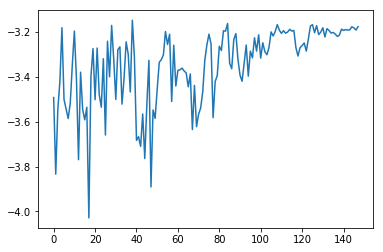

In [8]:
plt.plot(range(148),log_lik_sgld)

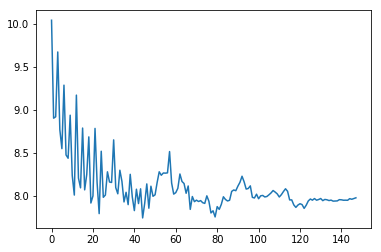

In [9]:
plt.plot(range(148),test_rmse)

In [7]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import psgld 

import model




if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



lambda_ = 1e-8
lr = 1e-4
alpha = 0.99


batch_size = 32
dataset_size= 456



network = Model()
criterion = nn.MSELoss(size_average=True)

optim = psgld.optim.psgld(network, lr, alpha, lambda_, dataset_size)
#optim = torch.optim.RMSprop(network.parameters(), lr=1e-4, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

losses_psgld = []
test_rmse = []
log_lik_psgld = []
t = 1.

for epoch in range(20):

    running_loss = 0
    for x, y in iter(train_loader):
        x = x.view(x.size(0), -1)

        network.zero_grad()
        output = network(x)
        loss = criterion(output, y)
        loss.backward()
        optim.step()

        losses_psgld.append(loss)

        running_loss += loss * batch_size / dataset_size
        prediction = output.data.max(1)[1]
        accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


        if (t >= 300) & (t % 100 == 0):
            with torch.autograd.no_grad():
                tau = 1.
                T = 50.
                rmse, log_lik = evaluate(network, test_loader, tau, T, y_train_mean, y_train_std)
                test_rmse.append(rmse)
                log_lik_psgld.append(log_lik)

        t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

Epoch 0 - loss: 383560.1250
Epoch 1 - loss: 561280.1875
Epoch 2 - loss: 569633.5000
Epoch 3 - loss: 575907.9375
Epoch 4 - loss: 584661.7500
Epoch 5 - loss: 590277.1250
Epoch 6 - loss: 604613.8750
Epoch 7 - loss: 603637.2500
Epoch 8 - loss: 602420.5000
Epoch 9 - loss: 601916.2500
Epoch 10 - loss: 601356.6250
Epoch 11 - loss: 600765.5625
Epoch 12 - loss: 600177.4375
Epoch 13 - loss: 599641.5625
Epoch 14 - loss: 598613.0625
Epoch 15 - loss: 597686.3750
Epoch 16 - loss: 597143.7500
Epoch 17 - loss: 596602.8125
Epoch 18 - loss: 596070.0625
Epoch 19 - loss: 595547.5000


In [11]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgfs



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")






batch_size = 32
dataset_size=456




network = Model()
criterion = nn.MSELoss(size_average=True)

optim = ksgfs.optim.KSGFS(network, criterion, batch_size, dataset_size, eta=1., v=0., lambda_=1., epsilon=0.1, l2=1e-3, invert_every=1)

losses_ksgfs = []
log_lik_ksgfs = []
test_rmse = []
t = 1.

for epoch in range(1000):

    running_loss = 0
    for x, y in iter(train_loader):
        x = x.view(x.size(0), -1)

        optim.update_curvature(x)

        network.zero_grad()
        output = network(x)
        loss = criterion(output, y)
        loss.backward()
        optim.step()


        losses_ksgfs.append(loss)
        running_loss += loss * batch_size / dataset_size
        prediction = output.data.max(1)[1]
        accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size

        if (t >= 300) & (t % 100 == 0):
            with torch.autograd.no_grad():
                tau = 1.
                T = 50.
                rmse, log_lik = evaluate(network, test_loader, tau, T, y_train_mean, y_train_std)
                test_rmse.append(rmse)
                log_lik_ksgfs.append(log_lik)
        t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

Epoch 0 - loss: 9.8815
Epoch 1 - loss: 2.9721
Epoch 2 - loss: 1.2096
Epoch 3 - loss: 0.7114
Epoch 4 - loss: 0.5666
Epoch 5 - loss: 0.4986
Epoch 6 - loss: 0.4568
Epoch 7 - loss: 0.4211
Epoch 8 - loss: 0.3911
Epoch 9 - loss: 0.3745
Epoch 10 - loss: 0.3545
Epoch 11 - loss: 0.3413
Epoch 12 - loss: 0.3385
Epoch 13 - loss: 0.3338
Epoch 14 - loss: 0.3266
Epoch 15 - loss: 0.3197
Epoch 16 - loss: 0.3178
Epoch 17 - loss: 0.3176
Epoch 18 - loss: 0.3057
Epoch 19 - loss: 0.3022
Epoch 20 - loss: 0.3025
Epoch 21 - loss: 0.2910
Epoch 22 - loss: 0.2852
Epoch 23 - loss: 0.2830
Epoch 24 - loss: 0.2773
Epoch 25 - loss: 0.2801
Epoch 26 - loss: 0.2719
Epoch 27 - loss: 0.2701
Epoch 28 - loss: 0.2638
Epoch 29 - loss: 0.2634
Epoch 30 - loss: 0.2578
Epoch 31 - loss: 0.2586
Epoch 32 - loss: 0.2483
Epoch 33 - loss: 0.2489
Epoch 34 - loss: 0.2404
Epoch 35 - loss: 0.2431
Epoch 36 - loss: 0.2451
Epoch 37 - loss: 0.2412
Epoch 38 - loss: 0.2386
Epoch 39 - loss: 0.2327
Epoch 40 - loss: 0.2309
Epoch 41 - loss: 0.2314
Ep

Epoch 333 - loss: 0.1313
Epoch 334 - loss: 0.1349
Epoch 335 - loss: 0.1287
Epoch 336 - loss: 0.1272
Epoch 337 - loss: 0.1273
Epoch 338 - loss: 0.1335
Epoch 339 - loss: 0.1371
Epoch 340 - loss: 0.1327
Epoch 341 - loss: 0.1362
Epoch 342 - loss: 0.1309
Epoch 343 - loss: 0.1279
Epoch 344 - loss: 0.1341
Epoch 345 - loss: 0.1337
Epoch 346 - loss: 0.1326
Epoch 347 - loss: 0.1360
Epoch 348 - loss: 0.1386
Epoch 349 - loss: 0.1329
Epoch 350 - loss: 0.1391
Epoch 351 - loss: 0.1348
Epoch 352 - loss: 0.1278
Epoch 353 - loss: 0.1329
Epoch 354 - loss: 0.1407
Epoch 355 - loss: 0.1381
Epoch 356 - loss: 0.1282
Epoch 357 - loss: 0.1280
Epoch 358 - loss: 0.1295
Epoch 359 - loss: 0.1314
Epoch 360 - loss: 0.1265
Epoch 361 - loss: 0.1345
Epoch 362 - loss: 0.1382
Epoch 363 - loss: 0.1390
Epoch 364 - loss: 0.1365
Epoch 365 - loss: 0.1353
Epoch 366 - loss: 0.1341
Epoch 367 - loss: 0.1354
Epoch 368 - loss: 0.1312
Epoch 369 - loss: 0.1255
Epoch 370 - loss: 0.1287
Epoch 371 - loss: 0.1363
Epoch 372 - loss: 0.1336


Epoch 661 - loss: 0.0979
Epoch 662 - loss: 0.1005
Epoch 663 - loss: 0.1018
Epoch 664 - loss: 0.1009
Epoch 665 - loss: 0.1009
Epoch 666 - loss: 0.1025
Epoch 667 - loss: 0.1054
Epoch 668 - loss: 0.1015
Epoch 669 - loss: 0.1001
Epoch 670 - loss: 0.0954
Epoch 671 - loss: 0.0961
Epoch 672 - loss: 0.0951
Epoch 673 - loss: 0.0991
Epoch 674 - loss: 0.1024
Epoch 675 - loss: 0.0975
Epoch 676 - loss: 0.0983
Epoch 677 - loss: 0.0991
Epoch 678 - loss: 0.0929
Epoch 679 - loss: 0.0951
Epoch 680 - loss: 0.0988
Epoch 681 - loss: 0.0972
Epoch 682 - loss: 0.0985
Epoch 683 - loss: 0.0949
Epoch 684 - loss: 0.0965
Epoch 685 - loss: 0.0991
Epoch 686 - loss: 0.0982
Epoch 687 - loss: 0.1005
Epoch 688 - loss: 0.0965
Epoch 689 - loss: 0.0973
Epoch 690 - loss: 0.0954
Epoch 691 - loss: 0.0963
Epoch 692 - loss: 0.0964
Epoch 693 - loss: 0.0984
Epoch 694 - loss: 0.0982
Epoch 695 - loss: 0.1016
Epoch 696 - loss: 0.1028
Epoch 697 - loss: 0.1007
Epoch 698 - loss: 0.0997
Epoch 699 - loss: 0.0956
Epoch 700 - loss: 0.0914


Epoch 989 - loss: 0.0895
Epoch 990 - loss: 0.0891
Epoch 991 - loss: 0.0872
Epoch 992 - loss: 0.0885
Epoch 993 - loss: 0.0898
Epoch 994 - loss: 0.0938
Epoch 995 - loss: 0.0924
Epoch 996 - loss: 0.0901
Epoch 997 - loss: 0.0951
Epoch 998 - loss: 0.0959
Epoch 999 - loss: 0.0923


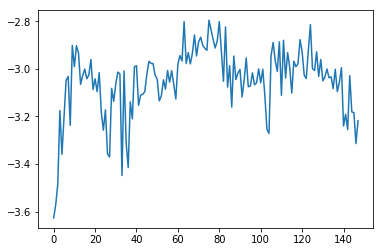

In [12]:
plt.plot(range(148), log_lik_ksgfs)

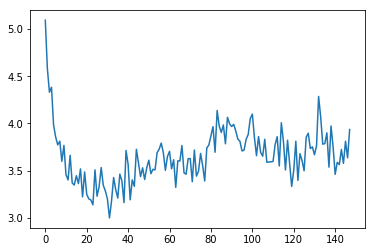

In [13]:
plt.plot(range(148), test_rmse)

In [29]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np
#from numpy.random import RandomState

import ksgld



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


batch_size = 32
dataset_size=456




network = Model()
criterion = nn.MSELoss(size_average=True)

optim = ksgld.optim.KSGLD(network, criterion, batch_size, dataset_size, eta=1., v=0., lambda_=1., epsilon=1e-1, l2=1e-3, invert_every=1)

losses_ksgld = []
log_lik_ksgld = []
test_rmse = []
t = 1.

for epoch in range(20):
    running_loss = 0
    for x, y in iter(train_loader):
        x = x.view(x.size(0), -1)

        optim.update_curvature(x)

        network.zero_grad()
        output = network(x)
#         print("Mean: ".format(torch.mean(output)))
        print(torch.std(output))
        loss = criterion(output, y)
        loss.backward()
        optim.step()

        losses_ksgld.append(loss)
        running_loss += loss * batch_size / dataset_size

        if (t >= 300) & (t % 100 == 0):
            with torch.autograd.no_grad():
                tau = 1.
                T = 50.
                rmse, log_lik = evaluate(network, test_loader, tau, T y_train_mean, y_train_std)
                test_rmse.append(rmse)
                log_lik_ksgld.append(log_lik)
        t += 1.


    print("Epoch {:d} - loss: {:.4f} ".format(epoch, running_loss))

tensor(2.6420)
tensor(2.5126)
tensor(2.5404)
tensor(2.3563)
tensor(2.2008)
tensor(1.9695)
tensor(1.8621)
tensor(1.8861)
tensor(1.6215)
tensor(1.5701)
tensor(1.0045)
tensor(1.3080)
tensor(1.1353)
tensor(1.0493)
tensor(1.1892)
Epoch 0 - loss: 8.4593 
tensor(0.7555)
tensor(0.7739)
tensor(0.8216)
tensor(0.6887)
tensor(0.6903)
tensor(0.5838)
tensor(0.5843)
tensor(0.6352)
tensor(0.4966)
tensor(0.5058)
tensor(0.3692)
tensor(0.3722)
tensor(0.3828)
tensor(0.2890)
tensor(0.3260)
Epoch 1 - loss: 1.8517 
tensor(0.3229)
tensor(0.3103)
tensor(0.3413)
tensor(0.3459)
tensor(0.3933)
tensor(0.3884)
tensor(0.4129)
tensor(0.4104)
tensor(0.3772)
tensor(0.3563)
tensor(0.3538)
tensor(0.3457)
tensor(0.5812)
tensor(0.4498)
tensor(0.3553)
Epoch 2 - loss: 0.7485 
tensor(0.5822)
tensor(0.3965)
tensor(0.4458)
tensor(0.5220)
tensor(0.5693)
tensor(0.5776)
tensor(0.5528)
tensor(0.5188)
tensor(0.5470)
tensor(0.5126)
tensor(0.4442)
tensor(0.5088)
tensor(0.7890)
tensor(0.6169)
tensor(0.4972)
Epoch 3 - loss: 0.5140 
tens

# Simulated Datasets

## Cubic

20 data points simulated as follows:

- x sampled from $\mathcal{U}(-4,4)$
- y sampled from $\mathcal{N}(x^3,3^2)$

In [2]:
x, _ = torch.empty(20,1).uniform_(-4,4).sort(0)
y = torch.normal(x**3,3)
grid = np.linspace(-6,6,400).reshape(-1,1)
y_true = grid ** 3

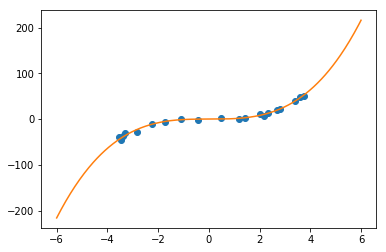

In [3]:
plt.plot(x.numpy(),y.numpy(),'o')
plt.plot(grid,y_true)

In [68]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.model = nn.Sequential(
                      nn.Linear(1, 50, bias=True),
                      nn.ReLU(),
                      nn.Linear(50, 50, bias=True),
                      nn.ReLU(),
                      nn.Linear(50, 50, bias=True),
                      nn.ReLU(),
                      nn.Linear(50, 1, bias=True)
                    ).to(device)


    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x

### SGLD

In [69]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import sgld

import model



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

lambda_ = 1e-4
lr = 1e-3


batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=True)

optim = sgld.optim.sgld(network, lr, lambda_, dataset_size)

losses_sgld = []
#test_rmse = []
#log_lik_sgld = []
predictions = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(20000):

    running_loss = 0
    
    network.zero_grad()
    output = network(x)
    loss = criterion(output, y)
    loss.backward()
    optim.step()

    losses_sgld.append(loss)


    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    if (t >= 300) & (t % 100 == 0):
        with torch.autograd.no_grad():
            output = network(x_test)
            predictions = torch.cat((predictions, output), 1)

    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

Epoch 0 - loss: 736.3558
Epoch 1 - loss: 733.6398
Epoch 2 - loss: 731.0995
Epoch 3 - loss: 729.5850
Epoch 4 - loss: 726.6674
Epoch 5 - loss: 723.8043
Epoch 6 - loss: 721.0245
Epoch 7 - loss: 717.1350
Epoch 8 - loss: 712.5626
Epoch 9 - loss: 707.8920
Epoch 10 - loss: 702.1854
Epoch 11 - loss: 695.3820
Epoch 12 - loss: 686.0397
Epoch 13 - loss: 675.7864
Epoch 14 - loss: 664.5538
Epoch 15 - loss: 651.8832
Epoch 16 - loss: 635.2906
Epoch 17 - loss: 615.5374
Epoch 18 - loss: 587.8661
Epoch 19 - loss: 555.1345
Epoch 20 - loss: 517.6302
Epoch 21 - loss: 474.8983
Epoch 22 - loss: 417.4516
Epoch 23 - loss: 357.8582
Epoch 24 - loss: 295.5563
Epoch 25 - loss: 242.1984
Epoch 26 - loss: 188.7619
Epoch 27 - loss: 148.9963
Epoch 28 - loss: 120.2571
Epoch 29 - loss: 104.9179
Epoch 30 - loss: 98.9819
Epoch 31 - loss: 96.5807
Epoch 32 - loss: 95.3668
Epoch 33 - loss: 94.4779
Epoch 34 - loss: 94.0548
Epoch 35 - loss: 93.8654
Epoch 36 - loss: 93.0290
Epoch 37 - loss: 92.8394
Epoch 38 - loss: 92.5330
Epoch

Epoch 375 - loss: 12.3865
Epoch 376 - loss: 12.3556
Epoch 377 - loss: 16.2087
Epoch 378 - loss: 16.4693
Epoch 379 - loss: 15.8297
Epoch 380 - loss: 16.5038
Epoch 381 - loss: 13.0642
Epoch 382 - loss: 12.3078
Epoch 383 - loss: 11.3804
Epoch 384 - loss: 11.5861
Epoch 385 - loss: 10.3587
Epoch 386 - loss: 8.8974
Epoch 387 - loss: 8.6983
Epoch 388 - loss: 8.7500
Epoch 389 - loss: 9.0893
Epoch 390 - loss: 9.4835
Epoch 391 - loss: 11.4343
Epoch 392 - loss: 14.2797
Epoch 393 - loss: 14.5576
Epoch 394 - loss: 18.9451
Epoch 395 - loss: 20.1232
Epoch 396 - loss: 24.0845
Epoch 397 - loss: 21.2579
Epoch 398 - loss: 20.4909
Epoch 399 - loss: 16.8137
Epoch 400 - loss: 16.4399
Epoch 401 - loss: 12.8350
Epoch 402 - loss: 11.1965
Epoch 403 - loss: 11.2662
Epoch 404 - loss: 14.2803
Epoch 405 - loss: 13.9950
Epoch 406 - loss: 16.5478
Epoch 407 - loss: 10.2452
Epoch 408 - loss: 10.6107
Epoch 409 - loss: 9.4486
Epoch 410 - loss: 10.4182
Epoch 411 - loss: 8.6538
Epoch 412 - loss: 8.1703
Epoch 413 - loss: 7.

Epoch 895 - loss: 10.9618
Epoch 896 - loss: 9.8176
Epoch 897 - loss: 11.2186
Epoch 898 - loss: 8.1183
Epoch 899 - loss: 6.2580
Epoch 900 - loss: 5.6233
Epoch 901 - loss: 5.4223
Epoch 902 - loss: 5.8127
Epoch 903 - loss: 5.5225
Epoch 904 - loss: 5.3502
Epoch 905 - loss: 6.4313
Epoch 906 - loss: 6.8569
Epoch 907 - loss: 6.4820
Epoch 908 - loss: 6.0521
Epoch 909 - loss: 5.6895
Epoch 910 - loss: 5.5462
Epoch 911 - loss: 5.7380
Epoch 912 - loss: 5.4226
Epoch 913 - loss: 5.7480
Epoch 914 - loss: 5.5780
Epoch 915 - loss: 5.9572
Epoch 916 - loss: 6.0342
Epoch 917 - loss: 5.9057
Epoch 918 - loss: 7.7146
Epoch 919 - loss: 12.3571
Epoch 920 - loss: 17.8058
Epoch 921 - loss: 22.8807
Epoch 922 - loss: 26.8836
Epoch 923 - loss: 25.4650
Epoch 924 - loss: 26.8385
Epoch 925 - loss: 19.3890
Epoch 926 - loss: 18.3432
Epoch 927 - loss: 14.3587
Epoch 928 - loss: 13.0609
Epoch 929 - loss: 12.7544
Epoch 930 - loss: 11.5107
Epoch 931 - loss: 8.8513
Epoch 932 - loss: 10.1695
Epoch 933 - loss: 7.9673
Epoch 934 

Epoch 1280 - loss: 12.9007
Epoch 1281 - loss: 10.3346
Epoch 1282 - loss: 11.2455
Epoch 1283 - loss: 10.3843
Epoch 1284 - loss: 9.5985
Epoch 1285 - loss: 7.6880
Epoch 1286 - loss: 8.0439
Epoch 1287 - loss: 8.3767
Epoch 1288 - loss: 9.1004
Epoch 1289 - loss: 9.8080
Epoch 1290 - loss: 11.5854
Epoch 1291 - loss: 12.5623
Epoch 1292 - loss: 13.2346
Epoch 1293 - loss: 14.8269
Epoch 1294 - loss: 14.2389
Epoch 1295 - loss: 17.8787
Epoch 1296 - loss: 15.6167
Epoch 1297 - loss: 12.5661
Epoch 1298 - loss: 10.5941
Epoch 1299 - loss: 10.6186
Epoch 1300 - loss: 9.8567
Epoch 1301 - loss: 9.8873
Epoch 1302 - loss: 11.6854
Epoch 1303 - loss: 14.2254
Epoch 1304 - loss: 12.2095
Epoch 1305 - loss: 12.7462
Epoch 1306 - loss: 12.7272
Epoch 1307 - loss: 13.4843
Epoch 1308 - loss: 10.9316
Epoch 1309 - loss: 10.3591
Epoch 1310 - loss: 10.3520
Epoch 1311 - loss: 9.1413
Epoch 1312 - loss: 8.7314
Epoch 1313 - loss: 8.2800
Epoch 1314 - loss: 7.4130
Epoch 1315 - loss: 6.8403
Epoch 1316 - loss: 8.8909
Epoch 1317 - lo

Epoch 1696 - loss: 13.2579
Epoch 1697 - loss: 15.4083
Epoch 1698 - loss: 17.9016
Epoch 1699 - loss: 19.4022
Epoch 1700 - loss: 18.0649
Epoch 1701 - loss: 14.5863
Epoch 1702 - loss: 15.0837
Epoch 1703 - loss: 12.8898
Epoch 1704 - loss: 12.1806
Epoch 1705 - loss: 13.7417
Epoch 1706 - loss: 11.0573
Epoch 1707 - loss: 10.4360
Epoch 1708 - loss: 8.7738
Epoch 1709 - loss: 9.6676
Epoch 1710 - loss: 8.9471
Epoch 1711 - loss: 7.4520
Epoch 1712 - loss: 8.1280
Epoch 1713 - loss: 9.6518
Epoch 1714 - loss: 10.9902
Epoch 1715 - loss: 12.0386
Epoch 1716 - loss: 11.4463
Epoch 1717 - loss: 10.1986
Epoch 1718 - loss: 8.1048
Epoch 1719 - loss: 6.1844
Epoch 1720 - loss: 6.1695
Epoch 1721 - loss: 6.7727
Epoch 1722 - loss: 6.1428
Epoch 1723 - loss: 6.5696
Epoch 1724 - loss: 6.5564
Epoch 1725 - loss: 7.5807
Epoch 1726 - loss: 6.9128
Epoch 1727 - loss: 8.0220
Epoch 1728 - loss: 8.3184
Epoch 1729 - loss: 7.7423
Epoch 1730 - loss: 6.7738
Epoch 1731 - loss: 6.9489
Epoch 1732 - loss: 8.5369
Epoch 1733 - loss: 11.

Epoch 2173 - loss: 5.6073
Epoch 2174 - loss: 5.1155
Epoch 2175 - loss: 5.6965
Epoch 2176 - loss: 6.0758
Epoch 2177 - loss: 5.3212
Epoch 2178 - loss: 4.9185
Epoch 2179 - loss: 5.1524
Epoch 2180 - loss: 5.3425
Epoch 2181 - loss: 4.9161
Epoch 2182 - loss: 4.9577
Epoch 2183 - loss: 5.1683
Epoch 2184 - loss: 4.9025
Epoch 2185 - loss: 5.3277
Epoch 2186 - loss: 5.6204
Epoch 2187 - loss: 6.7067
Epoch 2188 - loss: 6.3642
Epoch 2189 - loss: 6.0797
Epoch 2190 - loss: 6.5210
Epoch 2191 - loss: 7.4245
Epoch 2192 - loss: 7.2803
Epoch 2193 - loss: 7.2419
Epoch 2194 - loss: 7.1635
Epoch 2195 - loss: 7.1911
Epoch 2196 - loss: 7.9814
Epoch 2197 - loss: 7.9453
Epoch 2198 - loss: 7.5142
Epoch 2199 - loss: 6.0513
Epoch 2200 - loss: 5.4325
Epoch 2201 - loss: 4.8727
Epoch 2202 - loss: 4.7918
Epoch 2203 - loss: 5.0131
Epoch 2204 - loss: 5.2959
Epoch 2205 - loss: 4.8595
Epoch 2206 - loss: 5.2861
Epoch 2207 - loss: 5.7822
Epoch 2208 - loss: 6.2886
Epoch 2209 - loss: 7.5895
Epoch 2210 - loss: 7.8152
Epoch 2211 -

Epoch 2566 - loss: 15.6083
Epoch 2567 - loss: 16.7377
Epoch 2568 - loss: 20.4559
Epoch 2569 - loss: 17.7217
Epoch 2570 - loss: 17.7245
Epoch 2571 - loss: 13.8114
Epoch 2572 - loss: 11.7793
Epoch 2573 - loss: 10.9603
Epoch 2574 - loss: 7.2193
Epoch 2575 - loss: 7.0415
Epoch 2576 - loss: 5.4708
Epoch 2577 - loss: 5.4785
Epoch 2578 - loss: 6.2968
Epoch 2579 - loss: 5.0525
Epoch 2580 - loss: 5.2648
Epoch 2581 - loss: 5.6903
Epoch 2582 - loss: 5.0387
Epoch 2583 - loss: 5.3638
Epoch 2584 - loss: 5.9440
Epoch 2585 - loss: 6.0410
Epoch 2586 - loss: 5.3299
Epoch 2587 - loss: 5.2271
Epoch 2588 - loss: 4.9453
Epoch 2589 - loss: 4.7212
Epoch 2590 - loss: 4.8853
Epoch 2591 - loss: 4.8855
Epoch 2592 - loss: 5.5693
Epoch 2593 - loss: 5.3911
Epoch 2594 - loss: 5.1595
Epoch 2595 - loss: 4.9431
Epoch 2596 - loss: 5.2149
Epoch 2597 - loss: 5.0389
Epoch 2598 - loss: 5.4812
Epoch 2599 - loss: 5.6399
Epoch 2600 - loss: 5.4032
Epoch 2601 - loss: 5.4235
Epoch 2602 - loss: 6.4452
Epoch 2603 - loss: 6.5583
Epoc

Epoch 2927 - loss: 5.2747
Epoch 2928 - loss: 5.3851
Epoch 2929 - loss: 5.2322
Epoch 2930 - loss: 5.1150
Epoch 2931 - loss: 5.1671
Epoch 2932 - loss: 5.2502
Epoch 2933 - loss: 5.4704
Epoch 2934 - loss: 5.4939
Epoch 2935 - loss: 6.3472
Epoch 2936 - loss: 5.8555
Epoch 2937 - loss: 6.1679
Epoch 2938 - loss: 7.3447
Epoch 2939 - loss: 7.4377
Epoch 2940 - loss: 7.6392
Epoch 2941 - loss: 9.7303
Epoch 2942 - loss: 11.0872
Epoch 2943 - loss: 14.4938
Epoch 2944 - loss: 14.2136
Epoch 2945 - loss: 15.7401
Epoch 2946 - loss: 13.3797
Epoch 2947 - loss: 13.4819
Epoch 2948 - loss: 12.4059
Epoch 2949 - loss: 9.8452
Epoch 2950 - loss: 7.2851
Epoch 2951 - loss: 7.7932
Epoch 2952 - loss: 8.0190
Epoch 2953 - loss: 7.8680
Epoch 2954 - loss: 9.7915
Epoch 2955 - loss: 12.6797
Epoch 2956 - loss: 15.6623
Epoch 2957 - loss: 16.8134
Epoch 2958 - loss: 10.9430
Epoch 2959 - loss: 10.5640
Epoch 2960 - loss: 9.2253
Epoch 2961 - loss: 8.7528
Epoch 2962 - loss: 9.1909
Epoch 2963 - loss: 6.6400
Epoch 2964 - loss: 6.4909


Epoch 3419 - loss: 7.0903
Epoch 3420 - loss: 6.9859
Epoch 3421 - loss: 7.9483
Epoch 3422 - loss: 7.3912
Epoch 3423 - loss: 8.2426
Epoch 3424 - loss: 7.8640
Epoch 3425 - loss: 8.0621
Epoch 3426 - loss: 6.9379
Epoch 3427 - loss: 6.4968
Epoch 3428 - loss: 5.6561
Epoch 3429 - loss: 5.2191
Epoch 3430 - loss: 5.0377
Epoch 3431 - loss: 5.0553
Epoch 3432 - loss: 5.0182
Epoch 3433 - loss: 4.9829
Epoch 3434 - loss: 4.9392
Epoch 3435 - loss: 5.3471
Epoch 3436 - loss: 5.2012
Epoch 3437 - loss: 5.4137
Epoch 3438 - loss: 6.3494
Epoch 3439 - loss: 7.3851
Epoch 3440 - loss: 6.7547
Epoch 3441 - loss: 9.4168
Epoch 3442 - loss: 9.8832
Epoch 3443 - loss: 12.0168
Epoch 3444 - loss: 11.1652
Epoch 3445 - loss: 11.7247
Epoch 3446 - loss: 11.7520
Epoch 3447 - loss: 13.2291
Epoch 3448 - loss: 10.7255
Epoch 3449 - loss: 8.4317
Epoch 3450 - loss: 6.3957
Epoch 3451 - loss: 6.2650
Epoch 3452 - loss: 5.1444
Epoch 3453 - loss: 5.1932
Epoch 3454 - loss: 5.4037
Epoch 3455 - loss: 5.0610
Epoch 3456 - loss: 4.9699
Epoch 

Epoch 3777 - loss: 5.5297
Epoch 3778 - loss: 5.2540
Epoch 3779 - loss: 5.0301
Epoch 3780 - loss: 4.9181
Epoch 3781 - loss: 4.9787
Epoch 3782 - loss: 5.1047
Epoch 3783 - loss: 5.1158
Epoch 3784 - loss: 5.2501
Epoch 3785 - loss: 5.0556
Epoch 3786 - loss: 5.1911
Epoch 3787 - loss: 4.9024
Epoch 3788 - loss: 5.1746
Epoch 3789 - loss: 5.3582
Epoch 3790 - loss: 5.7203
Epoch 3791 - loss: 5.7935
Epoch 3792 - loss: 4.7731
Epoch 3793 - loss: 4.7554
Epoch 3794 - loss: 5.0773
Epoch 3795 - loss: 4.8115
Epoch 3796 - loss: 4.9131
Epoch 3797 - loss: 4.7577
Epoch 3798 - loss: 4.7322
Epoch 3799 - loss: 4.8911
Epoch 3800 - loss: 5.3383
Epoch 3801 - loss: 6.2302
Epoch 3802 - loss: 6.2478
Epoch 3803 - loss: 5.7935
Epoch 3804 - loss: 5.2548
Epoch 3805 - loss: 5.0270
Epoch 3806 - loss: 5.1184
Epoch 3807 - loss: 5.0447
Epoch 3808 - loss: 5.2675
Epoch 3809 - loss: 5.5520
Epoch 3810 - loss: 5.2218
Epoch 3811 - loss: 5.6202
Epoch 3812 - loss: 5.2150
Epoch 3813 - loss: 5.1189
Epoch 3814 - loss: 5.2032
Epoch 3815 -

Epoch 4214 - loss: 5.2294
Epoch 4215 - loss: 4.8386
Epoch 4216 - loss: 4.7926
Epoch 4217 - loss: 4.7963
Epoch 4218 - loss: 5.0843
Epoch 4219 - loss: 5.9407
Epoch 4220 - loss: 6.6404
Epoch 4221 - loss: 5.8927
Epoch 4222 - loss: 5.5810
Epoch 4223 - loss: 5.6711
Epoch 4224 - loss: 5.4874
Epoch 4225 - loss: 5.4719
Epoch 4226 - loss: 6.1098
Epoch 4227 - loss: 6.4194
Epoch 4228 - loss: 5.6269
Epoch 4229 - loss: 5.4103
Epoch 4230 - loss: 7.3761
Epoch 4231 - loss: 7.8291
Epoch 4232 - loss: 8.4028
Epoch 4233 - loss: 5.7244
Epoch 4234 - loss: 5.5691
Epoch 4235 - loss: 5.1835
Epoch 4236 - loss: 5.1934
Epoch 4237 - loss: 5.0441
Epoch 4238 - loss: 5.6865
Epoch 4239 - loss: 5.2374
Epoch 4240 - loss: 5.0890
Epoch 4241 - loss: 5.2045
Epoch 4242 - loss: 5.1909
Epoch 4243 - loss: 6.0403
Epoch 4244 - loss: 5.9967
Epoch 4245 - loss: 7.0404
Epoch 4246 - loss: 7.0523
Epoch 4247 - loss: 9.5746
Epoch 4248 - loss: 10.3263
Epoch 4249 - loss: 9.7584
Epoch 4250 - loss: 7.0902
Epoch 4251 - loss: 6.2405
Epoch 4252 

Epoch 4598 - loss: 14.5522
Epoch 4599 - loss: 12.6396
Epoch 4600 - loss: 8.6498
Epoch 4601 - loss: 9.6161
Epoch 4602 - loss: 8.0896
Epoch 4603 - loss: 7.9109
Epoch 4604 - loss: 6.2879
Epoch 4605 - loss: 6.5747
Epoch 4606 - loss: 6.1798
Epoch 4607 - loss: 6.2635
Epoch 4608 - loss: 6.3540
Epoch 4609 - loss: 6.0694
Epoch 4610 - loss: 6.5211
Epoch 4611 - loss: 5.8591
Epoch 4612 - loss: 5.7805
Epoch 4613 - loss: 5.7777
Epoch 4614 - loss: 5.5460
Epoch 4615 - loss: 5.0930
Epoch 4616 - loss: 5.2050
Epoch 4617 - loss: 4.9591
Epoch 4618 - loss: 5.1987
Epoch 4619 - loss: 5.4612
Epoch 4620 - loss: 6.6843
Epoch 4621 - loss: 6.1731
Epoch 4622 - loss: 5.2088
Epoch 4623 - loss: 4.9869
Epoch 4624 - loss: 5.2358
Epoch 4625 - loss: 5.1589
Epoch 4626 - loss: 5.2569
Epoch 4627 - loss: 5.2476
Epoch 4628 - loss: 5.7586
Epoch 4629 - loss: 5.5708
Epoch 4630 - loss: 4.8963
Epoch 4631 - loss: 5.0813
Epoch 4632 - loss: 5.0515
Epoch 4633 - loss: 5.4827
Epoch 4634 - loss: 5.2270
Epoch 4635 - loss: 5.4796
Epoch 4636

Epoch 4978 - loss: 5.7219
Epoch 4979 - loss: 6.0158
Epoch 4980 - loss: 5.4924
Epoch 4981 - loss: 5.4478
Epoch 4982 - loss: 5.8615
Epoch 4983 - loss: 5.7892
Epoch 4984 - loss: 5.8487
Epoch 4985 - loss: 5.3489
Epoch 4986 - loss: 4.9944
Epoch 4987 - loss: 5.0896
Epoch 4988 - loss: 5.2812
Epoch 4989 - loss: 5.3978
Epoch 4990 - loss: 5.8345
Epoch 4991 - loss: 5.8350
Epoch 4992 - loss: 5.2411
Epoch 4993 - loss: 5.0909
Epoch 4994 - loss: 5.0473
Epoch 4995 - loss: 5.1055
Epoch 4996 - loss: 5.1920
Epoch 4997 - loss: 5.2196
Epoch 4998 - loss: 4.9543
Epoch 4999 - loss: 4.9001
Epoch 5000 - loss: 5.0003
Epoch 5001 - loss: 4.8313
Epoch 5002 - loss: 4.8711
Epoch 5003 - loss: 4.8660
Epoch 5004 - loss: 4.9093
Epoch 5005 - loss: 4.9033
Epoch 5006 - loss: 4.8707
Epoch 5007 - loss: 4.7967
Epoch 5008 - loss: 4.8595
Epoch 5009 - loss: 4.8925
Epoch 5010 - loss: 4.7838
Epoch 5011 - loss: 4.7448
Epoch 5012 - loss: 4.7937
Epoch 5013 - loss: 4.9707
Epoch 5014 - loss: 4.9804
Epoch 5015 - loss: 4.7794
Epoch 5016 -

Epoch 5397 - loss: 4.9065
Epoch 5398 - loss: 4.9136
Epoch 5399 - loss: 4.8666
Epoch 5400 - loss: 4.9619
Epoch 5401 - loss: 4.7993
Epoch 5402 - loss: 4.8102
Epoch 5403 - loss: 4.6764
Epoch 5404 - loss: 4.7741
Epoch 5405 - loss: 4.7672
Epoch 5406 - loss: 4.8572
Epoch 5407 - loss: 4.8355
Epoch 5408 - loss: 4.6631
Epoch 5409 - loss: 4.7939
Epoch 5410 - loss: 4.8604
Epoch 5411 - loss: 4.8165
Epoch 5412 - loss: 5.0816
Epoch 5413 - loss: 4.9957
Epoch 5414 - loss: 4.7980
Epoch 5415 - loss: 4.7587
Epoch 5416 - loss: 4.9792
Epoch 5417 - loss: 4.6859
Epoch 5418 - loss: 4.7343
Epoch 5419 - loss: 4.7371
Epoch 5420 - loss: 4.6468
Epoch 5421 - loss: 4.7046
Epoch 5422 - loss: 4.6616
Epoch 5423 - loss: 4.7131
Epoch 5424 - loss: 4.6410
Epoch 5425 - loss: 4.9058
Epoch 5426 - loss: 4.7026
Epoch 5427 - loss: 4.8543
Epoch 5428 - loss: 5.0537
Epoch 5429 - loss: 4.9408
Epoch 5430 - loss: 4.7527
Epoch 5431 - loss: 4.9215
Epoch 5432 - loss: 4.7344
Epoch 5433 - loss: 4.7432
Epoch 5434 - loss: 4.7427
Epoch 5435 -

Epoch 5772 - loss: 5.1082
Epoch 5773 - loss: 5.0762
Epoch 5774 - loss: 5.0532
Epoch 5775 - loss: 5.0308
Epoch 5776 - loss: 5.2676
Epoch 5777 - loss: 5.2945
Epoch 5778 - loss: 5.0508
Epoch 5779 - loss: 5.2489
Epoch 5780 - loss: 4.9140
Epoch 5781 - loss: 4.8333
Epoch 5782 - loss: 5.2882
Epoch 5783 - loss: 5.1767
Epoch 5784 - loss: 5.2507
Epoch 5785 - loss: 4.9368
Epoch 5786 - loss: 5.2350
Epoch 5787 - loss: 4.9326
Epoch 5788 - loss: 4.9890
Epoch 5789 - loss: 5.1544
Epoch 5790 - loss: 4.9008
Epoch 5791 - loss: 4.9758
Epoch 5792 - loss: 5.1113
Epoch 5793 - loss: 5.3421
Epoch 5794 - loss: 4.7370
Epoch 5795 - loss: 4.8605
Epoch 5796 - loss: 5.0518
Epoch 5797 - loss: 4.9910
Epoch 5798 - loss: 5.0688
Epoch 5799 - loss: 4.9968
Epoch 5800 - loss: 4.9983
Epoch 5801 - loss: 5.0976
Epoch 5802 - loss: 4.8780
Epoch 5803 - loss: 5.2236
Epoch 5804 - loss: 5.1437
Epoch 5805 - loss: 4.7337
Epoch 5806 - loss: 4.8943
Epoch 5807 - loss: 5.1471
Epoch 5808 - loss: 5.0574
Epoch 5809 - loss: 4.8010
Epoch 5810 -

Epoch 6136 - loss: 4.8503
Epoch 6137 - loss: 4.7555
Epoch 6138 - loss: 4.7376
Epoch 6139 - loss: 4.8492
Epoch 6140 - loss: 4.7136
Epoch 6141 - loss: 4.7817
Epoch 6142 - loss: 4.7592
Epoch 6143 - loss: 4.8303
Epoch 6144 - loss: 4.7858
Epoch 6145 - loss: 4.8138
Epoch 6146 - loss: 4.9891
Epoch 6147 - loss: 4.8460
Epoch 6148 - loss: 4.7105
Epoch 6149 - loss: 4.9599
Epoch 6150 - loss: 4.9208
Epoch 6151 - loss: 4.9309
Epoch 6152 - loss: 4.9501
Epoch 6153 - loss: 4.7642
Epoch 6154 - loss: 4.8932
Epoch 6155 - loss: 4.8363
Epoch 6156 - loss: 4.7620
Epoch 6157 - loss: 4.7616
Epoch 6158 - loss: 4.8516
Epoch 6159 - loss: 4.6988
Epoch 6160 - loss: 4.9454
Epoch 6161 - loss: 4.9767
Epoch 6162 - loss: 4.9777
Epoch 6163 - loss: 4.7901
Epoch 6164 - loss: 4.8421
Epoch 6165 - loss: 5.0866
Epoch 6166 - loss: 5.1993
Epoch 6167 - loss: 5.0341
Epoch 6168 - loss: 5.1468
Epoch 6169 - loss: 5.4253
Epoch 6170 - loss: 5.0296
Epoch 6171 - loss: 5.0866
Epoch 6172 - loss: 5.5173
Epoch 6173 - loss: 5.1462
Epoch 6174 -

Epoch 6508 - loss: 4.4055
Epoch 6509 - loss: 4.3808
Epoch 6510 - loss: 4.5502
Epoch 6511 - loss: 4.3018
Epoch 6512 - loss: 4.6242
Epoch 6513 - loss: 4.5226
Epoch 6514 - loss: 4.4957
Epoch 6515 - loss: 4.4305
Epoch 6516 - loss: 4.4662
Epoch 6517 - loss: 4.6038
Epoch 6518 - loss: 4.7623
Epoch 6519 - loss: 4.5794
Epoch 6520 - loss: 4.8443
Epoch 6521 - loss: 4.6480
Epoch 6522 - loss: 4.7769
Epoch 6523 - loss: 4.5929
Epoch 6524 - loss: 4.4193
Epoch 6525 - loss: 4.5100
Epoch 6526 - loss: 4.4826
Epoch 6527 - loss: 4.4936
Epoch 6528 - loss: 4.3813
Epoch 6529 - loss: 4.4217
Epoch 6530 - loss: 4.3409
Epoch 6531 - loss: 4.6491
Epoch 6532 - loss: 4.6192
Epoch 6533 - loss: 4.3781
Epoch 6534 - loss: 4.4191
Epoch 6535 - loss: 4.7973
Epoch 6536 - loss: 4.3034
Epoch 6537 - loss: 4.3320
Epoch 6538 - loss: 4.5152
Epoch 6539 - loss: 4.2066
Epoch 6540 - loss: 4.2183
Epoch 6541 - loss: 4.3646
Epoch 6542 - loss: 4.1979
Epoch 6543 - loss: 4.2229
Epoch 6544 - loss: 4.4370
Epoch 6545 - loss: 4.3397
Epoch 6546 -

Epoch 6854 - loss: 4.7757
Epoch 6855 - loss: 4.3667
Epoch 6856 - loss: 4.3248
Epoch 6857 - loss: 4.6066
Epoch 6858 - loss: 4.4963
Epoch 6859 - loss: 4.5636
Epoch 6860 - loss: 4.4120
Epoch 6861 - loss: 4.4159
Epoch 6862 - loss: 4.4026
Epoch 6863 - loss: 4.5033
Epoch 6864 - loss: 4.5946
Epoch 6865 - loss: 4.5457
Epoch 6866 - loss: 4.6430
Epoch 6867 - loss: 4.6541
Epoch 6868 - loss: 4.6152
Epoch 6869 - loss: 4.7193
Epoch 6870 - loss: 4.8136
Epoch 6871 - loss: 4.8485
Epoch 6872 - loss: 4.5972
Epoch 6873 - loss: 4.6787
Epoch 6874 - loss: 4.6498
Epoch 6875 - loss: 4.5551
Epoch 6876 - loss: 4.9095
Epoch 6877 - loss: 4.7963
Epoch 6878 - loss: 4.6057
Epoch 6879 - loss: 4.5738
Epoch 6880 - loss: 4.7228
Epoch 6881 - loss: 4.5004
Epoch 6882 - loss: 4.4009
Epoch 6883 - loss: 4.4312
Epoch 6884 - loss: 4.4863
Epoch 6885 - loss: 4.2934
Epoch 6886 - loss: 4.3329
Epoch 6887 - loss: 4.3413
Epoch 6888 - loss: 4.3073
Epoch 6889 - loss: 4.2984
Epoch 6890 - loss: 4.3715
Epoch 6891 - loss: 4.3289
Epoch 6892 -

Epoch 7322 - loss: 7.3073
Epoch 7323 - loss: 6.3104
Epoch 7324 - loss: 5.6472
Epoch 7325 - loss: 7.5901
Epoch 7326 - loss: 7.8693
Epoch 7327 - loss: 8.7834
Epoch 7328 - loss: 8.4665
Epoch 7329 - loss: 7.8635
Epoch 7330 - loss: 7.9032
Epoch 7331 - loss: 7.1024
Epoch 7332 - loss: 8.5077
Epoch 7333 - loss: 5.8870
Epoch 7334 - loss: 5.3693
Epoch 7335 - loss: 6.0192
Epoch 7336 - loss: 4.7261
Epoch 7337 - loss: 4.9793
Epoch 7338 - loss: 4.8764
Epoch 7339 - loss: 4.7973
Epoch 7340 - loss: 4.7461
Epoch 7341 - loss: 5.3230
Epoch 7342 - loss: 4.9737
Epoch 7343 - loss: 4.5281
Epoch 7344 - loss: 4.5612
Epoch 7345 - loss: 4.9114
Epoch 7346 - loss: 5.4985
Epoch 7347 - loss: 6.3861
Epoch 7348 - loss: 5.2504
Epoch 7349 - loss: 5.6273
Epoch 7350 - loss: 7.1088
Epoch 7351 - loss: 5.6481
Epoch 7352 - loss: 7.6802
Epoch 7353 - loss: 7.3800
Epoch 7354 - loss: 7.0169
Epoch 7355 - loss: 6.0364
Epoch 7356 - loss: 6.2632
Epoch 7357 - loss: 7.2774
Epoch 7358 - loss: 6.8473
Epoch 7359 - loss: 6.0456
Epoch 7360 -

Epoch 7685 - loss: 7.0170
Epoch 7686 - loss: 6.2171
Epoch 7687 - loss: 5.5346
Epoch 7688 - loss: 5.3611
Epoch 7689 - loss: 6.4235
Epoch 7690 - loss: 9.6946
Epoch 7691 - loss: 8.3848
Epoch 7692 - loss: 8.5182
Epoch 7693 - loss: 6.6663
Epoch 7694 - loss: 5.8518
Epoch 7695 - loss: 5.6076
Epoch 7696 - loss: 5.5182
Epoch 7697 - loss: 5.4451
Epoch 7698 - loss: 5.0544
Epoch 7699 - loss: 4.9308
Epoch 7700 - loss: 5.8760
Epoch 7701 - loss: 6.0104
Epoch 7702 - loss: 5.4003
Epoch 7703 - loss: 4.8916
Epoch 7704 - loss: 5.0288
Epoch 7705 - loss: 4.7527
Epoch 7706 - loss: 4.4984
Epoch 7707 - loss: 4.5141
Epoch 7708 - loss: 4.7895
Epoch 7709 - loss: 4.7022
Epoch 7710 - loss: 4.8159
Epoch 7711 - loss: 4.6212
Epoch 7712 - loss: 4.6684
Epoch 7713 - loss: 5.1809
Epoch 7714 - loss: 5.0747
Epoch 7715 - loss: 5.5082
Epoch 7716 - loss: 4.9869
Epoch 7717 - loss: 4.8187
Epoch 7718 - loss: 5.0732
Epoch 7719 - loss: 5.2106
Epoch 7720 - loss: 4.8075
Epoch 7721 - loss: 4.8324
Epoch 7722 - loss: 4.8974
Epoch 7723 -

Epoch 8162 - loss: 5.4466
Epoch 8163 - loss: 5.7383
Epoch 8164 - loss: 6.7711
Epoch 8165 - loss: 8.0209
Epoch 8166 - loss: 6.5584
Epoch 8167 - loss: 5.7536
Epoch 8168 - loss: 6.0905
Epoch 8169 - loss: 5.8038
Epoch 8170 - loss: 5.5972
Epoch 8171 - loss: 5.0990
Epoch 8172 - loss: 5.1361
Epoch 8173 - loss: 5.5508
Epoch 8174 - loss: 5.6361
Epoch 8175 - loss: 5.7071
Epoch 8176 - loss: 5.3663
Epoch 8177 - loss: 5.5043
Epoch 8178 - loss: 5.1256
Epoch 8179 - loss: 4.7596
Epoch 8180 - loss: 5.6535
Epoch 8181 - loss: 5.1816
Epoch 8182 - loss: 5.4233
Epoch 8183 - loss: 4.7725
Epoch 8184 - loss: 4.5223
Epoch 8185 - loss: 4.6174
Epoch 8186 - loss: 4.9271
Epoch 8187 - loss: 6.6330
Epoch 8188 - loss: 9.2101
Epoch 8189 - loss: 7.8219
Epoch 8190 - loss: 10.0716
Epoch 8191 - loss: 11.5420
Epoch 8192 - loss: 10.0723
Epoch 8193 - loss: 10.4861
Epoch 8194 - loss: 11.2314
Epoch 8195 - loss: 9.4110
Epoch 8196 - loss: 8.6749
Epoch 8197 - loss: 7.4630
Epoch 8198 - loss: 7.3993
Epoch 8199 - loss: 5.7610
Epoch 8

Epoch 8550 - loss: 4.6175
Epoch 8551 - loss: 4.9889
Epoch 8552 - loss: 4.5209
Epoch 8553 - loss: 4.5533
Epoch 8554 - loss: 4.4522
Epoch 8555 - loss: 4.6728
Epoch 8556 - loss: 4.4435
Epoch 8557 - loss: 4.5896
Epoch 8558 - loss: 4.6254
Epoch 8559 - loss: 4.5261
Epoch 8560 - loss: 4.4890
Epoch 8561 - loss: 4.7133
Epoch 8562 - loss: 4.7193
Epoch 8563 - loss: 4.7573
Epoch 8564 - loss: 5.2295
Epoch 8565 - loss: 4.9856
Epoch 8566 - loss: 5.2261
Epoch 8567 - loss: 4.9602
Epoch 8568 - loss: 4.7278
Epoch 8569 - loss: 4.4234
Epoch 8570 - loss: 4.4459
Epoch 8571 - loss: 4.3913
Epoch 8572 - loss: 4.8117
Epoch 8573 - loss: 5.3317
Epoch 8574 - loss: 5.3591
Epoch 8575 - loss: 5.3905
Epoch 8576 - loss: 4.7962
Epoch 8577 - loss: 4.5295
Epoch 8578 - loss: 5.3272
Epoch 8579 - loss: 4.6945
Epoch 8580 - loss: 4.7652
Epoch 8581 - loss: 5.0000
Epoch 8582 - loss: 4.5901
Epoch 8583 - loss: 4.6986
Epoch 8584 - loss: 4.8119
Epoch 8585 - loss: 4.8424
Epoch 8586 - loss: 5.2962
Epoch 8587 - loss: 4.7728
Epoch 8588 -

Epoch 8878 - loss: 5.0076
Epoch 8879 - loss: 5.5428
Epoch 8880 - loss: 6.4093
Epoch 8881 - loss: 6.1098
Epoch 8882 - loss: 6.1580
Epoch 8883 - loss: 5.9571
Epoch 8884 - loss: 5.8621
Epoch 8885 - loss: 6.2225
Epoch 8886 - loss: 5.6050
Epoch 8887 - loss: 6.0910
Epoch 8888 - loss: 6.0014
Epoch 8889 - loss: 5.9123
Epoch 8890 - loss: 6.2302
Epoch 8891 - loss: 5.5983
Epoch 8892 - loss: 5.0189
Epoch 8893 - loss: 4.8896
Epoch 8894 - loss: 4.7206
Epoch 8895 - loss: 4.9681
Epoch 8896 - loss: 4.8882
Epoch 8897 - loss: 4.5967
Epoch 8898 - loss: 4.7445
Epoch 8899 - loss: 5.0897
Epoch 8900 - loss: 4.8399
Epoch 8901 - loss: 4.8573
Epoch 8902 - loss: 4.7858
Epoch 8903 - loss: 4.7610
Epoch 8904 - loss: 4.7656
Epoch 8905 - loss: 4.6679
Epoch 8906 - loss: 4.5961
Epoch 8907 - loss: 4.7023
Epoch 8908 - loss: 4.8837
Epoch 8909 - loss: 4.5924
Epoch 8910 - loss: 4.6421
Epoch 8911 - loss: 4.9351
Epoch 8912 - loss: 4.7611
Epoch 8913 - loss: 4.5107
Epoch 8914 - loss: 4.8354
Epoch 8915 - loss: 4.6948
Epoch 8916 -

Epoch 9209 - loss: 5.3556
Epoch 9210 - loss: 4.9370
Epoch 9211 - loss: 5.1084
Epoch 9212 - loss: 5.0218
Epoch 9213 - loss: 5.2704
Epoch 9214 - loss: 5.3159
Epoch 9215 - loss: 4.7991
Epoch 9216 - loss: 5.2762
Epoch 9217 - loss: 5.3259
Epoch 9218 - loss: 5.7271
Epoch 9219 - loss: 5.0572
Epoch 9220 - loss: 5.1904
Epoch 9221 - loss: 5.9704
Epoch 9222 - loss: 5.5884
Epoch 9223 - loss: 5.7008
Epoch 9224 - loss: 5.0244
Epoch 9225 - loss: 4.7685
Epoch 9226 - loss: 5.1025
Epoch 9227 - loss: 5.1604
Epoch 9228 - loss: 4.9056
Epoch 9229 - loss: 4.9660
Epoch 9230 - loss: 5.1343
Epoch 9231 - loss: 4.9859
Epoch 9232 - loss: 4.6982
Epoch 9233 - loss: 4.8355
Epoch 9234 - loss: 5.0753
Epoch 9235 - loss: 4.9917
Epoch 9236 - loss: 5.7837
Epoch 9237 - loss: 6.2691
Epoch 9238 - loss: 6.3196
Epoch 9239 - loss: 5.8891
Epoch 9240 - loss: 6.1236
Epoch 9241 - loss: 6.0328
Epoch 9242 - loss: 5.3740
Epoch 9243 - loss: 5.0509
Epoch 9244 - loss: 4.6919
Epoch 9245 - loss: 4.7668
Epoch 9246 - loss: 5.3743
Epoch 9247 -

Epoch 9562 - loss: 7.4846
Epoch 9563 - loss: 6.7899
Epoch 9564 - loss: 6.2785
Epoch 9565 - loss: 5.3398
Epoch 9566 - loss: 5.2306
Epoch 9567 - loss: 5.0907
Epoch 9568 - loss: 5.1801
Epoch 9569 - loss: 5.4191
Epoch 9570 - loss: 5.0403
Epoch 9571 - loss: 5.0566
Epoch 9572 - loss: 5.0999
Epoch 9573 - loss: 5.0686
Epoch 9574 - loss: 4.9657
Epoch 9575 - loss: 5.1124
Epoch 9576 - loss: 5.5061
Epoch 9577 - loss: 5.3790
Epoch 9578 - loss: 4.9452
Epoch 9579 - loss: 5.2370
Epoch 9580 - loss: 5.0192
Epoch 9581 - loss: 4.9816
Epoch 9582 - loss: 5.0802
Epoch 9583 - loss: 5.0613
Epoch 9584 - loss: 4.9303
Epoch 9585 - loss: 5.3720
Epoch 9586 - loss: 5.5934
Epoch 9587 - loss: 5.2849
Epoch 9588 - loss: 4.9542
Epoch 9589 - loss: 5.3080
Epoch 9590 - loss: 5.2885
Epoch 9591 - loss: 4.9990
Epoch 9592 - loss: 5.0664
Epoch 9593 - loss: 4.7588
Epoch 9594 - loss: 4.9067
Epoch 9595 - loss: 4.8051
Epoch 9596 - loss: 4.8373
Epoch 9597 - loss: 4.7165
Epoch 9598 - loss: 4.7292
Epoch 9599 - loss: 4.7803
Epoch 9600 -

Epoch 10032 - loss: 4.4817
Epoch 10033 - loss: 4.5510
Epoch 10034 - loss: 4.4473
Epoch 10035 - loss: 4.5849
Epoch 10036 - loss: 4.7538
Epoch 10037 - loss: 4.5949
Epoch 10038 - loss: 4.5485
Epoch 10039 - loss: 4.3926
Epoch 10040 - loss: 4.2858
Epoch 10041 - loss: 4.3073
Epoch 10042 - loss: 4.6369
Epoch 10043 - loss: 4.4348
Epoch 10044 - loss: 4.3255
Epoch 10045 - loss: 4.2740
Epoch 10046 - loss: 4.2487
Epoch 10047 - loss: 4.2531
Epoch 10048 - loss: 4.2186
Epoch 10049 - loss: 4.3075
Epoch 10050 - loss: 4.2759
Epoch 10051 - loss: 4.2848
Epoch 10052 - loss: 4.3207
Epoch 10053 - loss: 4.3595
Epoch 10054 - loss: 4.4777
Epoch 10055 - loss: 4.5064
Epoch 10056 - loss: 4.3627
Epoch 10057 - loss: 4.4398
Epoch 10058 - loss: 4.3016
Epoch 10059 - loss: 4.3207
Epoch 10060 - loss: 4.3440
Epoch 10061 - loss: 4.3489
Epoch 10062 - loss: 4.4439
Epoch 10063 - loss: 4.4629
Epoch 10064 - loss: 4.5600
Epoch 10065 - loss: 4.5407
Epoch 10066 - loss: 4.4773
Epoch 10067 - loss: 4.3027
Epoch 10068 - loss: 4.3064
E

Epoch 10420 - loss: 4.4711
Epoch 10421 - loss: 4.4329
Epoch 10422 - loss: 4.5432
Epoch 10423 - loss: 4.3209
Epoch 10424 - loss: 4.3194
Epoch 10425 - loss: 4.3405
Epoch 10426 - loss: 4.5832
Epoch 10427 - loss: 4.5657
Epoch 10428 - loss: 4.6906
Epoch 10429 - loss: 4.5375
Epoch 10430 - loss: 4.4961
Epoch 10431 - loss: 4.5052
Epoch 10432 - loss: 4.5146
Epoch 10433 - loss: 4.6192
Epoch 10434 - loss: 4.4310
Epoch 10435 - loss: 4.2610
Epoch 10436 - loss: 4.7566
Epoch 10437 - loss: 4.3009
Epoch 10438 - loss: 4.4240
Epoch 10439 - loss: 4.4071
Epoch 10440 - loss: 4.2983
Epoch 10441 - loss: 4.3405
Epoch 10442 - loss: 4.3324
Epoch 10443 - loss: 4.2731
Epoch 10444 - loss: 4.3213
Epoch 10445 - loss: 4.2843
Epoch 10446 - loss: 4.4509
Epoch 10447 - loss: 4.3576
Epoch 10448 - loss: 4.3197
Epoch 10449 - loss: 4.3397
Epoch 10450 - loss: 4.3683
Epoch 10451 - loss: 4.3389
Epoch 10452 - loss: 4.4255
Epoch 10453 - loss: 4.3729
Epoch 10454 - loss: 4.5353
Epoch 10455 - loss: 4.3444
Epoch 10456 - loss: 4.2771
E

Epoch 10805 - loss: 4.4022
Epoch 10806 - loss: 4.8348
Epoch 10807 - loss: 4.3116
Epoch 10808 - loss: 4.3217
Epoch 10809 - loss: 4.5305
Epoch 10810 - loss: 4.2734
Epoch 10811 - loss: 4.2751
Epoch 10812 - loss: 4.2464
Epoch 10813 - loss: 4.1733
Epoch 10814 - loss: 4.3232
Epoch 10815 - loss: 4.2169
Epoch 10816 - loss: 4.2148
Epoch 10817 - loss: 4.2767
Epoch 10818 - loss: 4.3099
Epoch 10819 - loss: 4.2406
Epoch 10820 - loss: 4.3083
Epoch 10821 - loss: 4.2492
Epoch 10822 - loss: 4.3069
Epoch 10823 - loss: 4.3070
Epoch 10824 - loss: 4.2357
Epoch 10825 - loss: 4.2972
Epoch 10826 - loss: 4.3898
Epoch 10827 - loss: 4.3217
Epoch 10828 - loss: 4.2969
Epoch 10829 - loss: 4.2635
Epoch 10830 - loss: 4.2998
Epoch 10831 - loss: 4.2987
Epoch 10832 - loss: 4.4263
Epoch 10833 - loss: 4.3623
Epoch 10834 - loss: 4.4444
Epoch 10835 - loss: 4.4161
Epoch 10836 - loss: 4.4079
Epoch 10837 - loss: 4.4279
Epoch 10838 - loss: 4.8276
Epoch 10839 - loss: 4.5897
Epoch 10840 - loss: 4.6160
Epoch 10841 - loss: 4.5891
E

Epoch 11173 - loss: 4.4541
Epoch 11174 - loss: 4.4211
Epoch 11175 - loss: 4.3183
Epoch 11176 - loss: 4.4663
Epoch 11177 - loss: 4.5455
Epoch 11178 - loss: 4.4176
Epoch 11179 - loss: 4.4944
Epoch 11180 - loss: 4.5486
Epoch 11181 - loss: 4.5588
Epoch 11182 - loss: 4.5812
Epoch 11183 - loss: 4.4612
Epoch 11184 - loss: 4.5614
Epoch 11185 - loss: 4.5593
Epoch 11186 - loss: 4.5780
Epoch 11187 - loss: 4.5881
Epoch 11188 - loss: 4.6311
Epoch 11189 - loss: 4.5340
Epoch 11190 - loss: 4.5648
Epoch 11191 - loss: 4.6178
Epoch 11192 - loss: 4.5371
Epoch 11193 - loss: 4.7066
Epoch 11194 - loss: 4.7136
Epoch 11195 - loss: 4.7050
Epoch 11196 - loss: 4.7163
Epoch 11197 - loss: 4.7108
Epoch 11198 - loss: 4.7122
Epoch 11199 - loss: 4.7418
Epoch 11200 - loss: 4.6772
Epoch 11201 - loss: 4.9127
Epoch 11202 - loss: 4.7995
Epoch 11203 - loss: 4.5306
Epoch 11204 - loss: 4.6607
Epoch 11205 - loss: 4.6210
Epoch 11206 - loss: 4.6147
Epoch 11207 - loss: 4.4844
Epoch 11208 - loss: 4.6300
Epoch 11209 - loss: 4.7406
E

Epoch 11511 - loss: 4.5896
Epoch 11512 - loss: 4.4988
Epoch 11513 - loss: 4.4117
Epoch 11514 - loss: 4.4217
Epoch 11515 - loss: 4.5839
Epoch 11516 - loss: 4.4813
Epoch 11517 - loss: 4.4483
Epoch 11518 - loss: 4.5986
Epoch 11519 - loss: 4.4320
Epoch 11520 - loss: 4.9177
Epoch 11521 - loss: 4.6060
Epoch 11522 - loss: 4.5349
Epoch 11523 - loss: 4.4452
Epoch 11524 - loss: 4.9475
Epoch 11525 - loss: 4.5042
Epoch 11526 - loss: 4.4798
Epoch 11527 - loss: 4.5198
Epoch 11528 - loss: 4.3988
Epoch 11529 - loss: 4.4750
Epoch 11530 - loss: 4.4621
Epoch 11531 - loss: 4.4543
Epoch 11532 - loss: 4.6253
Epoch 11533 - loss: 4.3981
Epoch 11534 - loss: 4.3410
Epoch 11535 - loss: 4.2904
Epoch 11536 - loss: 4.2455
Epoch 11537 - loss: 4.2869
Epoch 11538 - loss: 4.4746
Epoch 11539 - loss: 4.2910
Epoch 11540 - loss: 4.3398
Epoch 11541 - loss: 4.7028
Epoch 11542 - loss: 4.1780
Epoch 11543 - loss: 4.3315
Epoch 11544 - loss: 4.8806
Epoch 11545 - loss: 4.2415
Epoch 11546 - loss: 4.2197
Epoch 11547 - loss: 4.2059
E

Epoch 11886 - loss: 4.7728
Epoch 11887 - loss: 4.5847
Epoch 11888 - loss: 4.5739
Epoch 11889 - loss: 4.6154
Epoch 11890 - loss: 4.7339
Epoch 11891 - loss: 5.6289
Epoch 11892 - loss: 4.4550
Epoch 11893 - loss: 4.7506
Epoch 11894 - loss: 4.5354
Epoch 11895 - loss: 4.6291
Epoch 11896 - loss: 4.9333
Epoch 11897 - loss: 4.7804
Epoch 11898 - loss: 4.4975
Epoch 11899 - loss: 4.8909
Epoch 11900 - loss: 4.5905
Epoch 11901 - loss: 4.5852
Epoch 11902 - loss: 4.5452
Epoch 11903 - loss: 4.6116
Epoch 11904 - loss: 4.7752
Epoch 11905 - loss: 4.5577
Epoch 11906 - loss: 4.6154
Epoch 11907 - loss: 4.5574
Epoch 11908 - loss: 4.9306
Epoch 11909 - loss: 4.6722
Epoch 11910 - loss: 4.6618
Epoch 11911 - loss: 4.6236
Epoch 11912 - loss: 4.5930
Epoch 11913 - loss: 4.8276
Epoch 11914 - loss: 4.5502
Epoch 11915 - loss: 4.5954
Epoch 11916 - loss: 4.6147
Epoch 11917 - loss: 4.6806
Epoch 11918 - loss: 4.8353
Epoch 11919 - loss: 4.7454
Epoch 11920 - loss: 4.7228
Epoch 11921 - loss: 4.7866
Epoch 11922 - loss: 4.6448
E

Epoch 12265 - loss: 4.5907
Epoch 12266 - loss: 4.2261
Epoch 12267 - loss: 4.0853
Epoch 12268 - loss: 4.5245
Epoch 12269 - loss: 4.3837
Epoch 12270 - loss: 4.2161
Epoch 12271 - loss: 4.1459
Epoch 12272 - loss: 4.2446
Epoch 12273 - loss: 4.8215
Epoch 12274 - loss: 5.3938
Epoch 12275 - loss: 6.0615
Epoch 12276 - loss: 6.8571
Epoch 12277 - loss: 6.5873
Epoch 12278 - loss: 6.9786
Epoch 12279 - loss: 5.3755
Epoch 12280 - loss: 5.3884
Epoch 12281 - loss: 4.7389
Epoch 12282 - loss: 4.7723
Epoch 12283 - loss: 4.7699
Epoch 12284 - loss: 4.8602
Epoch 12285 - loss: 4.7105
Epoch 12286 - loss: 4.7376
Epoch 12287 - loss: 4.8180
Epoch 12288 - loss: 4.4278
Epoch 12289 - loss: 4.7371
Epoch 12290 - loss: 4.7761
Epoch 12291 - loss: 5.7300
Epoch 12292 - loss: 5.1168
Epoch 12293 - loss: 4.8015
Epoch 12294 - loss: 4.8784
Epoch 12295 - loss: 4.9187
Epoch 12296 - loss: 5.2648
Epoch 12297 - loss: 6.0394
Epoch 12298 - loss: 5.7353
Epoch 12299 - loss: 5.0103
Epoch 12300 - loss: 4.5301
Epoch 12301 - loss: 4.0278
E

Epoch 12670 - loss: 4.3887
Epoch 12671 - loss: 4.2074
Epoch 12672 - loss: 4.2609
Epoch 12673 - loss: 3.9942
Epoch 12674 - loss: 4.0288
Epoch 12675 - loss: 4.0756
Epoch 12676 - loss: 4.1662
Epoch 12677 - loss: 4.0969
Epoch 12678 - loss: 4.0714
Epoch 12679 - loss: 4.0587
Epoch 12680 - loss: 4.2000
Epoch 12681 - loss: 4.0414
Epoch 12682 - loss: 4.2867
Epoch 12683 - loss: 4.0184
Epoch 12684 - loss: 4.1111
Epoch 12685 - loss: 4.0021
Epoch 12686 - loss: 4.1304
Epoch 12687 - loss: 4.1915
Epoch 12688 - loss: 4.4674
Epoch 12689 - loss: 4.0743
Epoch 12690 - loss: 4.1928
Epoch 12691 - loss: 4.2725
Epoch 12692 - loss: 4.4912
Epoch 12693 - loss: 4.0522
Epoch 12694 - loss: 3.8439
Epoch 12695 - loss: 4.1943
Epoch 12696 - loss: 4.0043
Epoch 12697 - loss: 3.9990
Epoch 12698 - loss: 4.0192
Epoch 12699 - loss: 4.0944
Epoch 12700 - loss: 4.1337
Epoch 12701 - loss: 4.5810
Epoch 12702 - loss: 4.0105
Epoch 12703 - loss: 4.0321
Epoch 12704 - loss: 4.2144
Epoch 12705 - loss: 4.5269
Epoch 12706 - loss: 4.2534
E

Epoch 13095 - loss: 4.3203
Epoch 13096 - loss: 4.5774
Epoch 13097 - loss: 4.7569
Epoch 13098 - loss: 4.7965
Epoch 13099 - loss: 5.1516
Epoch 13100 - loss: 4.9793
Epoch 13101 - loss: 4.8600
Epoch 13102 - loss: 5.0950
Epoch 13103 - loss: 4.5592
Epoch 13104 - loss: 4.4038
Epoch 13105 - loss: 4.3255
Epoch 13106 - loss: 4.2837
Epoch 13107 - loss: 4.4656
Epoch 13108 - loss: 4.3301
Epoch 13109 - loss: 4.6036
Epoch 13110 - loss: 4.3931
Epoch 13111 - loss: 4.3537
Epoch 13112 - loss: 4.4588
Epoch 13113 - loss: 4.5110
Epoch 13114 - loss: 4.7779
Epoch 13115 - loss: 4.4220
Epoch 13116 - loss: 4.6225
Epoch 13117 - loss: 4.6590
Epoch 13118 - loss: 4.4387
Epoch 13119 - loss: 4.4000
Epoch 13120 - loss: 4.4978
Epoch 13121 - loss: 4.6534
Epoch 13122 - loss: 4.5452
Epoch 13123 - loss: 4.6934
Epoch 13124 - loss: 4.6502
Epoch 13125 - loss: 4.8291
Epoch 13126 - loss: 4.6679
Epoch 13127 - loss: 4.7595
Epoch 13128 - loss: 4.5822
Epoch 13129 - loss: 4.9159
Epoch 13130 - loss: 4.6721
Epoch 13131 - loss: 4.7366
E

Epoch 13454 - loss: 4.3999
Epoch 13455 - loss: 4.5845
Epoch 13456 - loss: 4.4498
Epoch 13457 - loss: 4.3609
Epoch 13458 - loss: 4.5421
Epoch 13459 - loss: 4.2329
Epoch 13460 - loss: 4.1385
Epoch 13461 - loss: 4.1088
Epoch 13462 - loss: 4.2405
Epoch 13463 - loss: 4.2192
Epoch 13464 - loss: 4.2327
Epoch 13465 - loss: 4.3822
Epoch 13466 - loss: 4.1634
Epoch 13467 - loss: 4.1305
Epoch 13468 - loss: 4.3502
Epoch 13469 - loss: 4.1856
Epoch 13470 - loss: 4.2150
Epoch 13471 - loss: 4.1606
Epoch 13472 - loss: 4.3924
Epoch 13473 - loss: 4.2295
Epoch 13474 - loss: 4.4286
Epoch 13475 - loss: 4.3043
Epoch 13476 - loss: 4.1931
Epoch 13477 - loss: 4.4320
Epoch 13478 - loss: 4.2543
Epoch 13479 - loss: 4.2802
Epoch 13480 - loss: 4.5722
Epoch 13481 - loss: 5.0367
Epoch 13482 - loss: 4.3608
Epoch 13483 - loss: 4.2295
Epoch 13484 - loss: 4.1910
Epoch 13485 - loss: 4.1658
Epoch 13486 - loss: 4.6409
Epoch 13487 - loss: 4.5536
Epoch 13488 - loss: 4.5429
Epoch 13489 - loss: 4.0096
Epoch 13490 - loss: 4.0303
E

Epoch 13834 - loss: 4.2071
Epoch 13835 - loss: 4.1921
Epoch 13836 - loss: 4.9366
Epoch 13837 - loss: 4.4357
Epoch 13838 - loss: 4.9853
Epoch 13839 - loss: 4.6716
Epoch 13840 - loss: 4.1394
Epoch 13841 - loss: 4.0954
Epoch 13842 - loss: 4.1064
Epoch 13843 - loss: 4.4516
Epoch 13844 - loss: 4.4023
Epoch 13845 - loss: 4.5356
Epoch 13846 - loss: 4.4900
Epoch 13847 - loss: 4.3563
Epoch 13848 - loss: 4.5353
Epoch 13849 - loss: 4.8694
Epoch 13850 - loss: 4.4270
Epoch 13851 - loss: 4.2794
Epoch 13852 - loss: 4.2354
Epoch 13853 - loss: 4.3900
Epoch 13854 - loss: 4.2482
Epoch 13855 - loss: 4.0589
Epoch 13856 - loss: 4.0527
Epoch 13857 - loss: 4.1149
Epoch 13858 - loss: 4.6430
Epoch 13859 - loss: 4.5182
Epoch 13860 - loss: 4.8586
Epoch 13861 - loss: 4.0998
Epoch 13862 - loss: 3.9329
Epoch 13863 - loss: 4.0826
Epoch 13864 - loss: 4.2327
Epoch 13865 - loss: 3.9871
Epoch 13866 - loss: 4.1381
Epoch 13867 - loss: 4.0460
Epoch 13868 - loss: 4.1352
Epoch 13869 - loss: 4.2118
Epoch 13870 - loss: 4.5489
E

Epoch 14223 - loss: 4.4792
Epoch 14224 - loss: 4.5060
Epoch 14225 - loss: 4.4808
Epoch 14226 - loss: 4.2964
Epoch 14227 - loss: 4.2706
Epoch 14228 - loss: 4.3149
Epoch 14229 - loss: 4.3080
Epoch 14230 - loss: 4.3623
Epoch 14231 - loss: 4.1882
Epoch 14232 - loss: 4.1157
Epoch 14233 - loss: 4.2279
Epoch 14234 - loss: 4.5118
Epoch 14235 - loss: 5.2292
Epoch 14236 - loss: 4.3633
Epoch 14237 - loss: 5.0516
Epoch 14238 - loss: 4.5341
Epoch 14239 - loss: 4.7116
Epoch 14240 - loss: 4.0680
Epoch 14241 - loss: 4.2365
Epoch 14242 - loss: 4.3582
Epoch 14243 - loss: 4.3493
Epoch 14244 - loss: 4.4004
Epoch 14245 - loss: 4.5120
Epoch 14246 - loss: 4.2880
Epoch 14247 - loss: 4.2849
Epoch 14248 - loss: 4.2893
Epoch 14249 - loss: 4.4297
Epoch 14250 - loss: 4.3591
Epoch 14251 - loss: 4.4679
Epoch 14252 - loss: 4.2328
Epoch 14253 - loss: 4.2297
Epoch 14254 - loss: 4.1776
Epoch 14255 - loss: 4.2932
Epoch 14256 - loss: 4.5603
Epoch 14257 - loss: 4.5248
Epoch 14258 - loss: 4.4480
Epoch 14259 - loss: 4.2659
E

Epoch 14601 - loss: 5.3292
Epoch 14602 - loss: 5.6192
Epoch 14603 - loss: 5.0705
Epoch 14604 - loss: 5.1202
Epoch 14605 - loss: 4.8533
Epoch 14606 - loss: 4.3818
Epoch 14607 - loss: 4.2903
Epoch 14608 - loss: 4.0540
Epoch 14609 - loss: 3.8958
Epoch 14610 - loss: 4.0422
Epoch 14611 - loss: 4.2052
Epoch 14612 - loss: 4.3430
Epoch 14613 - loss: 4.4874
Epoch 14614 - loss: 4.7922
Epoch 14615 - loss: 4.4190
Epoch 14616 - loss: 4.8210
Epoch 14617 - loss: 4.7846
Epoch 14618 - loss: 4.1461
Epoch 14619 - loss: 3.9659
Epoch 14620 - loss: 4.0851
Epoch 14621 - loss: 4.5150
Epoch 14622 - loss: 5.5119
Epoch 14623 - loss: 4.4074
Epoch 14624 - loss: 4.2360
Epoch 14625 - loss: 4.3332
Epoch 14626 - loss: 4.1022
Epoch 14627 - loss: 4.1099
Epoch 14628 - loss: 3.9215
Epoch 14629 - loss: 4.2761
Epoch 14630 - loss: 4.6878
Epoch 14631 - loss: 4.0647
Epoch 14632 - loss: 4.1358
Epoch 14633 - loss: 4.3544
Epoch 14634 - loss: 4.6405
Epoch 14635 - loss: 5.1059
Epoch 14636 - loss: 6.8059
Epoch 14637 - loss: 6.7298
E

Epoch 15023 - loss: 4.1166
Epoch 15024 - loss: 4.2252
Epoch 15025 - loss: 4.2536
Epoch 15026 - loss: 4.4297
Epoch 15027 - loss: 4.3945
Epoch 15028 - loss: 4.2165
Epoch 15029 - loss: 4.2987
Epoch 15030 - loss: 4.3811
Epoch 15031 - loss: 4.3151
Epoch 15032 - loss: 4.3043
Epoch 15033 - loss: 4.3035
Epoch 15034 - loss: 4.2694
Epoch 15035 - loss: 4.2683
Epoch 15036 - loss: 4.1793
Epoch 15037 - loss: 4.2516
Epoch 15038 - loss: 4.2688
Epoch 15039 - loss: 4.1593
Epoch 15040 - loss: 4.1453
Epoch 15041 - loss: 4.1594
Epoch 15042 - loss: 4.1782
Epoch 15043 - loss: 4.1276
Epoch 15044 - loss: 4.1695
Epoch 15045 - loss: 4.1847
Epoch 15046 - loss: 4.1984
Epoch 15047 - loss: 4.1516
Epoch 15048 - loss: 4.2059
Epoch 15049 - loss: 4.3227
Epoch 15050 - loss: 4.3710
Epoch 15051 - loss: 4.2981
Epoch 15052 - loss: 4.2744
Epoch 15053 - loss: 4.2115
Epoch 15054 - loss: 4.2578
Epoch 15055 - loss: 4.4125
Epoch 15056 - loss: 4.3452
Epoch 15057 - loss: 4.3068
Epoch 15058 - loss: 4.2718
Epoch 15059 - loss: 4.3715
E

Epoch 15405 - loss: 4.0929
Epoch 15406 - loss: 4.2565
Epoch 15407 - loss: 4.1813
Epoch 15408 - loss: 4.0396
Epoch 15409 - loss: 4.0527
Epoch 15410 - loss: 4.0842
Epoch 15411 - loss: 4.0368
Epoch 15412 - loss: 4.1188
Epoch 15413 - loss: 4.2056
Epoch 15414 - loss: 4.3310
Epoch 15415 - loss: 4.1534
Epoch 15416 - loss: 4.3031
Epoch 15417 - loss: 4.0509
Epoch 15418 - loss: 4.0684
Epoch 15419 - loss: 4.0677
Epoch 15420 - loss: 4.1063
Epoch 15421 - loss: 3.9942
Epoch 15422 - loss: 3.9875
Epoch 15423 - loss: 3.9606
Epoch 15424 - loss: 3.9902
Epoch 15425 - loss: 4.0269
Epoch 15426 - loss: 3.8756
Epoch 15427 - loss: 3.8844
Epoch 15428 - loss: 3.9742
Epoch 15429 - loss: 3.9589
Epoch 15430 - loss: 4.0673
Epoch 15431 - loss: 4.0161
Epoch 15432 - loss: 3.8915
Epoch 15433 - loss: 3.9459
Epoch 15434 - loss: 3.8868
Epoch 15435 - loss: 4.2101
Epoch 15436 - loss: 4.0325
Epoch 15437 - loss: 3.9967
Epoch 15438 - loss: 3.9883
Epoch 15439 - loss: 3.9677
Epoch 15440 - loss: 4.0926
Epoch 15441 - loss: 4.1924
E

Epoch 15866 - loss: 3.7985
Epoch 15867 - loss: 3.9854
Epoch 15868 - loss: 3.8475
Epoch 15869 - loss: 3.8229
Epoch 15870 - loss: 3.9135
Epoch 15871 - loss: 3.7927
Epoch 15872 - loss: 3.7967
Epoch 15873 - loss: 3.7862
Epoch 15874 - loss: 3.7246
Epoch 15875 - loss: 3.6816
Epoch 15876 - loss: 3.7902
Epoch 15877 - loss: 3.8056
Epoch 15878 - loss: 3.8709
Epoch 15879 - loss: 3.8971
Epoch 15880 - loss: 4.0200
Epoch 15881 - loss: 3.9179
Epoch 15882 - loss: 3.9308
Epoch 15883 - loss: 3.9814
Epoch 15884 - loss: 3.8583
Epoch 15885 - loss: 3.8042
Epoch 15886 - loss: 4.2005
Epoch 15887 - loss: 3.7624
Epoch 15888 - loss: 3.9096
Epoch 15889 - loss: 3.9058
Epoch 15890 - loss: 3.8335
Epoch 15891 - loss: 3.8778
Epoch 15892 - loss: 3.8286
Epoch 15893 - loss: 3.8204
Epoch 15894 - loss: 3.7519
Epoch 15895 - loss: 3.7341
Epoch 15896 - loss: 3.8918
Epoch 15897 - loss: 3.7312
Epoch 15898 - loss: 3.8033
Epoch 15899 - loss: 3.8395
Epoch 15900 - loss: 3.9774
Epoch 15901 - loss: 3.8774
Epoch 15902 - loss: 3.8582
E

Epoch 16262 - loss: 3.8424
Epoch 16263 - loss: 4.1138
Epoch 16264 - loss: 3.9824
Epoch 16265 - loss: 3.9126
Epoch 16266 - loss: 3.9480
Epoch 16267 - loss: 4.0175
Epoch 16268 - loss: 3.9766
Epoch 16269 - loss: 3.9200
Epoch 16270 - loss: 3.9436
Epoch 16271 - loss: 3.9142
Epoch 16272 - loss: 3.8859
Epoch 16273 - loss: 3.9421
Epoch 16274 - loss: 3.8914
Epoch 16275 - loss: 3.9450
Epoch 16276 - loss: 4.0107
Epoch 16277 - loss: 4.0841
Epoch 16278 - loss: 3.7962
Epoch 16279 - loss: 3.7140
Epoch 16280 - loss: 3.8296
Epoch 16281 - loss: 3.7977
Epoch 16282 - loss: 3.7310
Epoch 16283 - loss: 3.8055
Epoch 16284 - loss: 3.7244
Epoch 16285 - loss: 3.7937
Epoch 16286 - loss: 3.8723
Epoch 16287 - loss: 3.9798
Epoch 16288 - loss: 3.7309
Epoch 16289 - loss: 3.7015
Epoch 16290 - loss: 3.9021
Epoch 16291 - loss: 3.7518
Epoch 16292 - loss: 3.7648
Epoch 16293 - loss: 3.8660
Epoch 16294 - loss: 3.7965
Epoch 16295 - loss: 3.8727
Epoch 16296 - loss: 3.9545
Epoch 16297 - loss: 3.7857
Epoch 16298 - loss: 3.9038
E

Epoch 16661 - loss: 3.6527
Epoch 16662 - loss: 3.7890
Epoch 16663 - loss: 3.6374
Epoch 16664 - loss: 3.6867
Epoch 16665 - loss: 3.8399
Epoch 16666 - loss: 3.8368
Epoch 16667 - loss: 3.8033
Epoch 16668 - loss: 3.7929
Epoch 16669 - loss: 3.8468
Epoch 16670 - loss: 3.8518
Epoch 16671 - loss: 3.8459
Epoch 16672 - loss: 3.6604
Epoch 16673 - loss: 3.7170
Epoch 16674 - loss: 3.7480
Epoch 16675 - loss: 3.7915
Epoch 16676 - loss: 4.2035
Epoch 16677 - loss: 3.8506
Epoch 16678 - loss: 3.9022
Epoch 16679 - loss: 4.0354
Epoch 16680 - loss: 4.1082
Epoch 16681 - loss: 3.9879
Epoch 16682 - loss: 3.8137
Epoch 16683 - loss: 3.8085
Epoch 16684 - loss: 3.7314
Epoch 16685 - loss: 3.8437
Epoch 16686 - loss: 3.9950
Epoch 16687 - loss: 4.1374
Epoch 16688 - loss: 3.6950
Epoch 16689 - loss: 3.8997
Epoch 16690 - loss: 3.7328
Epoch 16691 - loss: 3.8073
Epoch 16692 - loss: 3.7591
Epoch 16693 - loss: 3.7800
Epoch 16694 - loss: 3.6362
Epoch 16695 - loss: 3.7299
Epoch 16696 - loss: 3.7169
Epoch 16697 - loss: 3.6120
E

Epoch 17102 - loss: 4.2472
Epoch 17103 - loss: 4.3197
Epoch 17104 - loss: 4.2521
Epoch 17105 - loss: 4.2793
Epoch 17106 - loss: 4.1879
Epoch 17107 - loss: 4.1923
Epoch 17108 - loss: 4.1975
Epoch 17109 - loss: 4.3965
Epoch 17110 - loss: 4.2405
Epoch 17111 - loss: 4.3186
Epoch 17112 - loss: 4.2395
Epoch 17113 - loss: 4.1297
Epoch 17114 - loss: 4.1598
Epoch 17115 - loss: 4.1719
Epoch 17116 - loss: 4.2955
Epoch 17117 - loss: 4.1886
Epoch 17118 - loss: 4.5850
Epoch 17119 - loss: 4.2500
Epoch 17120 - loss: 4.1771
Epoch 17121 - loss: 4.1183
Epoch 17122 - loss: 4.1572
Epoch 17123 - loss: 4.1592
Epoch 17124 - loss: 4.1663
Epoch 17125 - loss: 4.1725
Epoch 17126 - loss: 4.1459
Epoch 17127 - loss: 4.0766
Epoch 17128 - loss: 4.2292
Epoch 17129 - loss: 4.1389
Epoch 17130 - loss: 4.0731
Epoch 17131 - loss: 4.2626
Epoch 17132 - loss: 4.2360
Epoch 17133 - loss: 4.0997
Epoch 17134 - loss: 4.2927
Epoch 17135 - loss: 4.3464
Epoch 17136 - loss: 4.0909
Epoch 17137 - loss: 4.1069
Epoch 17138 - loss: 4.2353
E

Epoch 17484 - loss: 3.9365
Epoch 17485 - loss: 3.9677
Epoch 17486 - loss: 3.9373
Epoch 17487 - loss: 4.0284
Epoch 17488 - loss: 4.0275
Epoch 17489 - loss: 3.9219
Epoch 17490 - loss: 3.9525
Epoch 17491 - loss: 4.0596
Epoch 17492 - loss: 3.9139
Epoch 17493 - loss: 3.9960
Epoch 17494 - loss: 3.8569
Epoch 17495 - loss: 3.9810
Epoch 17496 - loss: 3.8463
Epoch 17497 - loss: 3.8786
Epoch 17498 - loss: 3.8800
Epoch 17499 - loss: 3.9481
Epoch 17500 - loss: 3.9089
Epoch 17501 - loss: 3.8847
Epoch 17502 - loss: 4.0301
Epoch 17503 - loss: 4.0477
Epoch 17504 - loss: 4.0554
Epoch 17505 - loss: 4.2857
Epoch 17506 - loss: 4.0545
Epoch 17507 - loss: 3.9859
Epoch 17508 - loss: 3.9109
Epoch 17509 - loss: 3.9325
Epoch 17510 - loss: 3.9077
Epoch 17511 - loss: 4.0039
Epoch 17512 - loss: 4.2026
Epoch 17513 - loss: 4.1583
Epoch 17514 - loss: 4.0741
Epoch 17515 - loss: 3.9505
Epoch 17516 - loss: 3.9969
Epoch 17517 - loss: 4.0062
Epoch 17518 - loss: 3.9827
Epoch 17519 - loss: 3.9550
Epoch 17520 - loss: 3.9697
E

Epoch 17810 - loss: 4.6287
Epoch 17811 - loss: 4.4572
Epoch 17812 - loss: 4.4933
Epoch 17813 - loss: 4.4916
Epoch 17814 - loss: 4.3474
Epoch 17815 - loss: 4.3112
Epoch 17816 - loss: 4.2999
Epoch 17817 - loss: 4.2870
Epoch 17818 - loss: 4.3653
Epoch 17819 - loss: 4.4031
Epoch 17820 - loss: 4.2596
Epoch 17821 - loss: 4.2578
Epoch 17822 - loss: 4.2734
Epoch 17823 - loss: 4.3110
Epoch 17824 - loss: 4.3338
Epoch 17825 - loss: 4.3187
Epoch 17826 - loss: 4.4525
Epoch 17827 - loss: 4.5662
Epoch 17828 - loss: 4.5339
Epoch 17829 - loss: 4.7142
Epoch 17830 - loss: 5.1876
Epoch 17831 - loss: 5.2719
Epoch 17832 - loss: 4.7708
Epoch 17833 - loss: 4.4922
Epoch 17834 - loss: 4.8442
Epoch 17835 - loss: 4.7879
Epoch 17836 - loss: 4.4634
Epoch 17837 - loss: 4.3462
Epoch 17838 - loss: 4.4439
Epoch 17839 - loss: 4.3003
Epoch 17840 - loss: 4.3759
Epoch 17841 - loss: 4.3552
Epoch 17842 - loss: 4.3417
Epoch 17843 - loss: 4.3500
Epoch 17844 - loss: 4.5720
Epoch 17845 - loss: 4.7273
Epoch 17846 - loss: 4.4814
E

Epoch 18221 - loss: 4.3969
Epoch 18222 - loss: 4.4606
Epoch 18223 - loss: 4.3748
Epoch 18224 - loss: 4.7391
Epoch 18225 - loss: 4.6013
Epoch 18226 - loss: 4.5173
Epoch 18227 - loss: 4.3334
Epoch 18228 - loss: 4.2552
Epoch 18229 - loss: 4.3227
Epoch 18230 - loss: 4.3922
Epoch 18231 - loss: 4.4751
Epoch 18232 - loss: 4.4013
Epoch 18233 - loss: 4.3778
Epoch 18234 - loss: 4.4296
Epoch 18235 - loss: 4.4002
Epoch 18236 - loss: 4.3349
Epoch 18237 - loss: 4.4019
Epoch 18238 - loss: 4.2863
Epoch 18239 - loss: 4.4174
Epoch 18240 - loss: 4.3052
Epoch 18241 - loss: 4.4706
Epoch 18242 - loss: 4.4221
Epoch 18243 - loss: 4.3928
Epoch 18244 - loss: 4.3607
Epoch 18245 - loss: 4.4598
Epoch 18246 - loss: 4.4261
Epoch 18247 - loss: 4.4374
Epoch 18248 - loss: 4.5542
Epoch 18249 - loss: 4.3314
Epoch 18250 - loss: 4.2724
Epoch 18251 - loss: 4.2473
Epoch 18252 - loss: 4.2843
Epoch 18253 - loss: 4.2630
Epoch 18254 - loss: 4.2641
Epoch 18255 - loss: 4.3322
Epoch 18256 - loss: 4.2186
Epoch 18257 - loss: 4.1875
E

Epoch 18638 - loss: 3.6024
Epoch 18639 - loss: 3.8249
Epoch 18640 - loss: 3.6881
Epoch 18641 - loss: 3.6843
Epoch 18642 - loss: 3.6414
Epoch 18643 - loss: 3.6438
Epoch 18644 - loss: 3.8220
Epoch 18645 - loss: 3.7068
Epoch 18646 - loss: 3.7637
Epoch 18647 - loss: 3.7316
Epoch 18648 - loss: 3.6918
Epoch 18649 - loss: 3.6781
Epoch 18650 - loss: 3.6478
Epoch 18651 - loss: 3.7466
Epoch 18652 - loss: 3.9313
Epoch 18653 - loss: 3.6810
Epoch 18654 - loss: 3.7624
Epoch 18655 - loss: 3.7261
Epoch 18656 - loss: 3.7056
Epoch 18657 - loss: 3.8109
Epoch 18658 - loss: 3.8867
Epoch 18659 - loss: 3.8215
Epoch 18660 - loss: 3.6625
Epoch 18661 - loss: 3.8328
Epoch 18662 - loss: 4.0507
Epoch 18663 - loss: 3.6989
Epoch 18664 - loss: 3.6850
Epoch 18665 - loss: 3.5800
Epoch 18666 - loss: 3.6342
Epoch 18667 - loss: 3.5986
Epoch 18668 - loss: 3.6226
Epoch 18669 - loss: 3.7555
Epoch 18670 - loss: 3.6944
Epoch 18671 - loss: 3.6636
Epoch 18672 - loss: 3.5501
Epoch 18673 - loss: 3.5753
Epoch 18674 - loss: 3.6406
E

Epoch 19069 - loss: 3.9945
Epoch 19070 - loss: 4.0184
Epoch 19071 - loss: 3.9879
Epoch 19072 - loss: 4.0492
Epoch 19073 - loss: 4.0970
Epoch 19074 - loss: 4.1512
Epoch 19075 - loss: 4.1198
Epoch 19076 - loss: 4.1299
Epoch 19077 - loss: 4.2817
Epoch 19078 - loss: 4.2539
Epoch 19079 - loss: 4.1584
Epoch 19080 - loss: 4.0904
Epoch 19081 - loss: 4.1491
Epoch 19082 - loss: 4.0751
Epoch 19083 - loss: 4.0615
Epoch 19084 - loss: 4.0516
Epoch 19085 - loss: 4.1915
Epoch 19086 - loss: 4.0759
Epoch 19087 - loss: 4.0143
Epoch 19088 - loss: 4.0333
Epoch 19089 - loss: 4.0530
Epoch 19090 - loss: 3.9674
Epoch 19091 - loss: 4.1132
Epoch 19092 - loss: 4.2395
Epoch 19093 - loss: 4.1602
Epoch 19094 - loss: 4.0116
Epoch 19095 - loss: 3.9711
Epoch 19096 - loss: 4.0404
Epoch 19097 - loss: 3.9644
Epoch 19098 - loss: 4.0602
Epoch 19099 - loss: 4.0318
Epoch 19100 - loss: 4.2418
Epoch 19101 - loss: 4.0285
Epoch 19102 - loss: 4.1131
Epoch 19103 - loss: 4.0842
Epoch 19104 - loss: 4.1004
Epoch 19105 - loss: 4.1151
E

Epoch 19531 - loss: 3.9490
Epoch 19532 - loss: 4.4610
Epoch 19533 - loss: 4.1026
Epoch 19534 - loss: 4.2073
Epoch 19535 - loss: 4.2478
Epoch 19536 - loss: 4.4158
Epoch 19537 - loss: 4.1402
Epoch 19538 - loss: 4.3268
Epoch 19539 - loss: 4.2744
Epoch 19540 - loss: 4.2745
Epoch 19541 - loss: 4.0986
Epoch 19542 - loss: 4.0163
Epoch 19543 - loss: 3.9179
Epoch 19544 - loss: 4.0091
Epoch 19545 - loss: 4.0594
Epoch 19546 - loss: 4.0221
Epoch 19547 - loss: 3.8737
Epoch 19548 - loss: 3.9064
Epoch 19549 - loss: 3.7476
Epoch 19550 - loss: 3.8186
Epoch 19551 - loss: 3.9146
Epoch 19552 - loss: 3.8671
Epoch 19553 - loss: 3.8217
Epoch 19554 - loss: 3.7951
Epoch 19555 - loss: 4.2307
Epoch 19556 - loss: 3.8605
Epoch 19557 - loss: 3.8650
Epoch 19558 - loss: 3.8992
Epoch 19559 - loss: 3.8418
Epoch 19560 - loss: 3.8878
Epoch 19561 - loss: 3.7894
Epoch 19562 - loss: 4.0686
Epoch 19563 - loss: 3.8557
Epoch 19564 - loss: 3.8158
Epoch 19565 - loss: 3.7911
Epoch 19566 - loss: 3.8388
Epoch 19567 - loss: 3.8340
E

Epoch 19937 - loss: 4.2437
Epoch 19938 - loss: 4.0279
Epoch 19939 - loss: 3.9336
Epoch 19940 - loss: 3.9271
Epoch 19941 - loss: 4.0533
Epoch 19942 - loss: 4.2400
Epoch 19943 - loss: 4.0026
Epoch 19944 - loss: 3.9599
Epoch 19945 - loss: 4.1140
Epoch 19946 - loss: 3.9405
Epoch 19947 - loss: 3.9136
Epoch 19948 - loss: 4.0775
Epoch 19949 - loss: 4.1905
Epoch 19950 - loss: 4.3838
Epoch 19951 - loss: 4.1936
Epoch 19952 - loss: 4.1573
Epoch 19953 - loss: 4.3034
Epoch 19954 - loss: 4.1425
Epoch 19955 - loss: 4.3756
Epoch 19956 - loss: 4.1672
Epoch 19957 - loss: 4.0721
Epoch 19958 - loss: 4.1992
Epoch 19959 - loss: 4.1475
Epoch 19960 - loss: 4.1681
Epoch 19961 - loss: 4.0982
Epoch 19962 - loss: 3.9410
Epoch 19963 - loss: 3.9334
Epoch 19964 - loss: 3.9633
Epoch 19965 - loss: 4.0117
Epoch 19966 - loss: 4.0776
Epoch 19967 - loss: 3.9338
Epoch 19968 - loss: 3.9894
Epoch 19969 - loss: 3.9839
Epoch 19970 - loss: 4.0337
Epoch 19971 - loss: 3.9669
Epoch 19972 - loss: 3.9472
Epoch 19973 - loss: 4.0993
E

In [196]:
predictions.size()

torch.Size([400, 99])

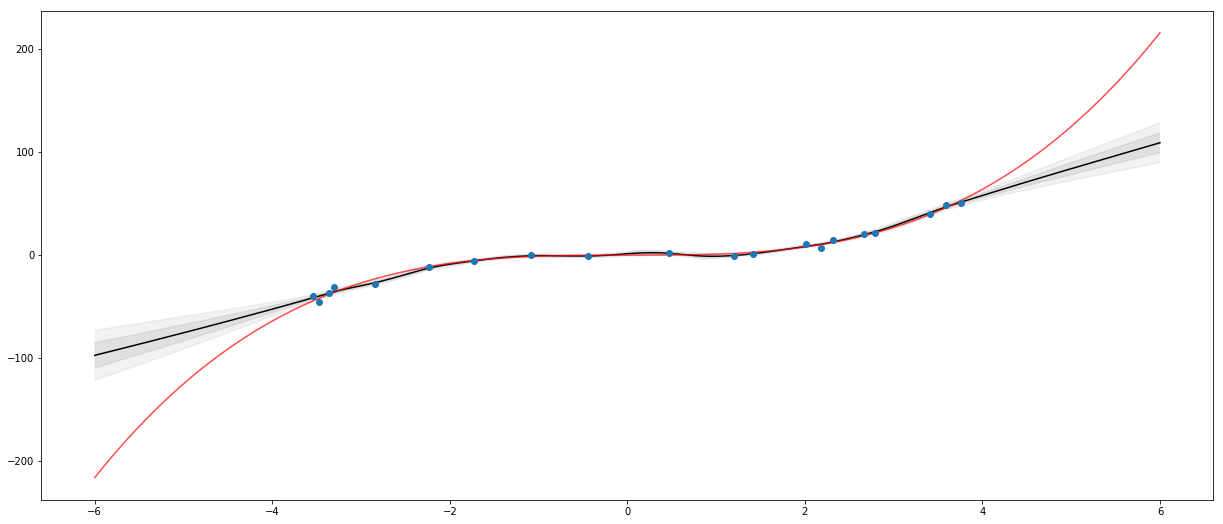

In [70]:
upper1 = np.mean(predictions[:,1:].detach().numpy(),1) + np.std(predictions[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions[:,1:].detach().numpy(),1) + 2 * np.std(predictions[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions[:,1:].detach().numpy(),1) - np.std(predictions[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions[:,1:].detach().numpy(),1) - 2 * np.std(predictions[:,1:].detach().numpy(),1)


plt.figure(figsize=(21,9))
plt.plot(grid,np.mean(predictions[:,1:].detach().numpy(),1),'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.15)
plt.plot(grid,lower2,'gray',alpha=0.1)
plt.fill_between(grid.squeeze(),lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid.squeeze(),lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,grid ** 3,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')



### pSGLD

In [76]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import psgld




if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

lambda_ = 1e-1
lr = 1e-7
alpha = 0.99


batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=True)

optim = psgld.optim.psgld(network, lr, lambda_, alpha, dataset_size)


predictions_psgld = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(20000):

    running_loss = 0

    
    network.zero_grad()
    output = network(x)
    loss = criterion(output, y)
    loss.backward()
    optim.step()



    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    if (t >= 300) & (t % 100 == 0):
        with torch.autograd.no_grad():
            output = network(x_test)
            predictions_psgld = torch.cat((predictions_psgld, output), 1)

    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

Epoch 0 - loss: 738.7508
Epoch 1 - loss: 1465.3035
Epoch 2 - loss: 2347.7563
Epoch 3 - loss: 2386.6177
Epoch 4 - loss: 2772.9524
Epoch 5 - loss: 2545.2666
Epoch 6 - loss: 3076.2239
Epoch 7 - loss: 2930.4185
Epoch 8 - loss: 2928.8696
Epoch 9 - loss: 2928.9419
Epoch 10 - loss: 2928.9912
Epoch 11 - loss: 2884.1194
Epoch 12 - loss: 2883.6602
Epoch 13 - loss: 2883.6667
Epoch 14 - loss: 3218.5723
Epoch 15 - loss: 3218.2139
Epoch 16 - loss: 3218.2134
Epoch 17 - loss: 3383.9644
Epoch 18 - loss: 3383.8716
Epoch 19 - loss: 3383.8567
Epoch 20 - loss: 3383.7559
Epoch 21 - loss: 3383.8289
Epoch 22 - loss: 3383.7969
Epoch 23 - loss: 3383.7388
Epoch 24 - loss: 3383.7007
Epoch 25 - loss: 3383.6470
Epoch 26 - loss: 3383.6235
Epoch 27 - loss: 3383.5796
Epoch 28 - loss: 3383.5234
Epoch 29 - loss: 3379.9661
Epoch 30 - loss: 3379.8679
Epoch 31 - loss: 3377.1704
Epoch 32 - loss: 3377.1431
Epoch 33 - loss: 3377.0962
Epoch 34 - loss: 3376.9272
Epoch 35 - loss: 3376.8450
Epoch 36 - loss: 3376.8406
Epoch 37 - l

Epoch 314 - loss: 3390.5718
Epoch 315 - loss: 3390.5386
Epoch 316 - loss: 3390.4792
Epoch 317 - loss: 3390.4844
Epoch 318 - loss: 3390.4211
Epoch 319 - loss: 3390.3745
Epoch 320 - loss: 3390.4897
Epoch 321 - loss: 3390.4155
Epoch 322 - loss: 3390.4070
Epoch 323 - loss: 3390.3997
Epoch 324 - loss: 3390.3640
Epoch 325 - loss: 3390.3911
Epoch 326 - loss: 3390.3608
Epoch 327 - loss: 3390.3066
Epoch 328 - loss: 3390.2820
Epoch 329 - loss: 3390.3704
Epoch 330 - loss: 3390.2825
Epoch 331 - loss: 3390.2090
Epoch 332 - loss: 3390.1523
Epoch 333 - loss: 3390.2036
Epoch 334 - loss: 3390.2212
Epoch 335 - loss: 3390.1938
Epoch 336 - loss: 3390.1108
Epoch 337 - loss: 3390.0129
Epoch 338 - loss: 3389.9780
Epoch 339 - loss: 3389.9165
Epoch 340 - loss: 3389.8679
Epoch 341 - loss: 3389.9058
Epoch 342 - loss: 3389.8491
Epoch 343 - loss: 3389.7598
Epoch 344 - loss: 3389.7695
Epoch 345 - loss: 3389.7759
Epoch 346 - loss: 3389.8274
Epoch 347 - loss: 3389.8652
Epoch 348 - loss: 3389.8359
Epoch 349 - loss: 33

Epoch 779 - loss: 3360.0171
Epoch 780 - loss: 3359.9382
Epoch 781 - loss: 3359.8677
Epoch 782 - loss: 3359.8621
Epoch 783 - loss: 3359.7766
Epoch 784 - loss: 3359.7336
Epoch 785 - loss: 3359.7056
Epoch 786 - loss: 3359.7632
Epoch 787 - loss: 3359.7651
Epoch 788 - loss: 3359.7605
Epoch 789 - loss: 3359.8247
Epoch 790 - loss: 3359.7598
Epoch 791 - loss: 3359.8027
Epoch 792 - loss: 3359.7817
Epoch 793 - loss: 3359.8020
Epoch 794 - loss: 3359.7708
Epoch 795 - loss: 3359.6655
Epoch 796 - loss: 3359.6504
Epoch 797 - loss: 3359.5903
Epoch 798 - loss: 3359.5190
Epoch 799 - loss: 3359.4692
Epoch 800 - loss: 3359.4741
Epoch 801 - loss: 3359.4844
Epoch 802 - loss: 3359.4536
Epoch 803 - loss: 3359.4116
Epoch 804 - loss: 3359.3872
Epoch 805 - loss: 3359.3015
Epoch 806 - loss: 3359.2390
Epoch 807 - loss: 3359.1843
Epoch 808 - loss: 3359.1731
Epoch 809 - loss: 3359.1101
Epoch 810 - loss: 3359.1406
Epoch 811 - loss: 3359.0945
Epoch 812 - loss: 3359.0337
Epoch 813 - loss: 3359.0730
Epoch 814 - loss: 33

Epoch 1229 - loss: 3354.3914
Epoch 1230 - loss: 3354.3960
Epoch 1231 - loss: 3354.3843
Epoch 1232 - loss: 3354.3696
Epoch 1233 - loss: 3354.3562
Epoch 1234 - loss: 3354.3345
Epoch 1235 - loss: 3354.3179
Epoch 1236 - loss: 3354.3091
Epoch 1237 - loss: 3354.3145
Epoch 1238 - loss: 3354.3171
Epoch 1239 - loss: 3354.3052
Epoch 1240 - loss: 3354.3125
Epoch 1241 - loss: 3354.3367
Epoch 1242 - loss: 3354.3118
Epoch 1243 - loss: 3354.3137
Epoch 1244 - loss: 3354.3040
Epoch 1245 - loss: 3354.2905
Epoch 1246 - loss: 3354.2727
Epoch 1247 - loss: 3354.2625
Epoch 1248 - loss: 3354.2649
Epoch 1249 - loss: 3354.2493
Epoch 1250 - loss: 3354.2356
Epoch 1251 - loss: 3354.2598
Epoch 1252 - loss: 3354.2358
Epoch 1253 - loss: 3354.2480
Epoch 1254 - loss: 3354.2473
Epoch 1255 - loss: 3354.2622
Epoch 1256 - loss: 3354.2524
Epoch 1257 - loss: 3354.2566
Epoch 1258 - loss: 3354.2324
Epoch 1259 - loss: 3354.2339
Epoch 1260 - loss: 3354.2280
Epoch 1261 - loss: 3354.2031
Epoch 1262 - loss: 3354.2129
Epoch 1263 - l

Epoch 1541 - loss: 3353.9922
Epoch 1542 - loss: 3353.9915
Epoch 1543 - loss: 3353.9656
Epoch 1544 - loss: 3353.9780
Epoch 1545 - loss: 3353.9719
Epoch 1546 - loss: 3353.9663
Epoch 1547 - loss: 3353.9683
Epoch 1548 - loss: 3353.9480
Epoch 1549 - loss: 3353.9363
Epoch 1550 - loss: 3353.9160
Epoch 1551 - loss: 3353.9136
Epoch 1552 - loss: 3353.8899
Epoch 1553 - loss: 3353.8809
Epoch 1554 - loss: 3353.8684
Epoch 1555 - loss: 3353.8452
Epoch 1556 - loss: 3353.8484
Epoch 1557 - loss: 3353.8503
Epoch 1558 - loss: 3353.8496
Epoch 1559 - loss: 3353.8601
Epoch 1560 - loss: 3353.8511
Epoch 1561 - loss: 3353.8442
Epoch 1562 - loss: 3353.8413
Epoch 1563 - loss: 3353.8347
Epoch 1564 - loss: 3353.8386
Epoch 1565 - loss: 3353.8345
Epoch 1566 - loss: 3353.8320
Epoch 1567 - loss: 3353.8047
Epoch 1568 - loss: 3353.7930
Epoch 1569 - loss: 3353.7700
Epoch 1570 - loss: 3353.7629
Epoch 1571 - loss: 3353.7578
Epoch 1572 - loss: 3353.7983
Epoch 1573 - loss: 3353.8035
Epoch 1574 - loss: 3353.7866
Epoch 1575 - l

Epoch 1945 - loss: 3353.2527
Epoch 1946 - loss: 3353.2710
Epoch 1947 - loss: 3353.2507
Epoch 1948 - loss: 3353.2441
Epoch 1949 - loss: 3353.2407
Epoch 1950 - loss: 3353.2500
Epoch 1951 - loss: 3353.2488
Epoch 1952 - loss: 3353.2681
Epoch 1953 - loss: 3353.2664
Epoch 1954 - loss: 3353.2571
Epoch 1955 - loss: 3353.2351
Epoch 1956 - loss: 3353.2300
Epoch 1957 - loss: 3353.2368
Epoch 1958 - loss: 3353.2207
Epoch 1959 - loss: 3353.2246
Epoch 1960 - loss: 3353.2231
Epoch 1961 - loss: 3353.2095
Epoch 1962 - loss: 3353.1992
Epoch 1963 - loss: 3353.1902
Epoch 1964 - loss: 3353.2173
Epoch 1965 - loss: 3353.2449
Epoch 1966 - loss: 3353.2200
Epoch 1967 - loss: 3353.2383
Epoch 1968 - loss: 3353.2312
Epoch 1969 - loss: 3353.2603
Epoch 1970 - loss: 3353.2300
Epoch 1971 - loss: 3353.2332
Epoch 1972 - loss: 3353.2290
Epoch 1973 - loss: 3353.2371
Epoch 1974 - loss: 3353.2183
Epoch 1975 - loss: 3353.2375
Epoch 1976 - loss: 3353.2078
Epoch 1977 - loss: 3353.1863
Epoch 1978 - loss: 3353.1887
Epoch 1979 - l

Epoch 2301 - loss: 3353.2124
Epoch 2302 - loss: 3353.2102
Epoch 2303 - loss: 3353.2090
Epoch 2304 - loss: 3353.2114
Epoch 2305 - loss: 3353.2180
Epoch 2306 - loss: 3353.2144
Epoch 2307 - loss: 3353.2173
Epoch 2308 - loss: 3353.2192
Epoch 2309 - loss: 3353.2188
Epoch 2310 - loss: 3353.2200
Epoch 2311 - loss: 3353.2219
Epoch 2312 - loss: 3353.2234
Epoch 2313 - loss: 3353.2136
Epoch 2314 - loss: 3353.2183
Epoch 2315 - loss: 3353.2280
Epoch 2316 - loss: 3353.2227
Epoch 2317 - loss: 3353.2227
Epoch 2318 - loss: 3353.2136
Epoch 2319 - loss: 3353.2173
Epoch 2320 - loss: 3353.2188
Epoch 2321 - loss: 3353.2129
Epoch 2322 - loss: 3353.2095
Epoch 2323 - loss: 3353.2065
Epoch 2324 - loss: 3353.2063
Epoch 2325 - loss: 3353.2026
Epoch 2326 - loss: 3353.2058
Epoch 2327 - loss: 3353.2036
Epoch 2328 - loss: 3353.2090
Epoch 2329 - loss: 3353.2144
Epoch 2330 - loss: 3353.2117
Epoch 2331 - loss: 3353.2097
Epoch 2332 - loss: 3353.2090
Epoch 2333 - loss: 3353.2056
Epoch 2334 - loss: 3353.2043
Epoch 2335 - l

Epoch 2587 - loss: 3353.1821
Epoch 2588 - loss: 3353.1790
Epoch 2589 - loss: 3353.1821
Epoch 2590 - loss: 3353.1843
Epoch 2591 - loss: 3353.1816
Epoch 2592 - loss: 3353.1831
Epoch 2593 - loss: 3353.1841
Epoch 2594 - loss: 3353.1882
Epoch 2595 - loss: 3353.1851
Epoch 2596 - loss: 3353.1797
Epoch 2597 - loss: 3353.1765
Epoch 2598 - loss: 3353.1753
Epoch 2599 - loss: 3353.1758
Epoch 2600 - loss: 3353.1704
Epoch 2601 - loss: 3353.1653
Epoch 2602 - loss: 3353.1550
Epoch 2603 - loss: 3353.1450
Epoch 2604 - loss: 3353.1450
Epoch 2605 - loss: 3353.1438
Epoch 2606 - loss: 3353.1421
Epoch 2607 - loss: 3353.1440
Epoch 2608 - loss: 3353.1531
Epoch 2609 - loss: 3353.1543
Epoch 2610 - loss: 3353.1528
Epoch 2611 - loss: 3353.1477
Epoch 2612 - loss: 3353.1484
Epoch 2613 - loss: 3353.1438
Epoch 2614 - loss: 3353.1360
Epoch 2615 - loss: 3353.1353
Epoch 2616 - loss: 3353.1343
Epoch 2617 - loss: 3353.1304
Epoch 2618 - loss: 3353.1250
Epoch 2619 - loss: 3353.1187
Epoch 2620 - loss: 3353.1172
Epoch 2621 - l

Epoch 2939 - loss: 3353.1204
Epoch 2940 - loss: 3353.1140
Epoch 2941 - loss: 3353.1204
Epoch 2942 - loss: 3353.1316
Epoch 2943 - loss: 3353.1265
Epoch 2944 - loss: 3353.1230
Epoch 2945 - loss: 3353.1187
Epoch 2946 - loss: 3353.1274
Epoch 2947 - loss: 3353.1282
Epoch 2948 - loss: 3353.1309
Epoch 2949 - loss: 3353.1394
Epoch 2950 - loss: 3353.1497
Epoch 2951 - loss: 3353.1470
Epoch 2952 - loss: 3353.1453
Epoch 2953 - loss: 3353.1460
Epoch 2954 - loss: 3353.1465
Epoch 2955 - loss: 3353.1431
Epoch 2956 - loss: 3353.1375
Epoch 2957 - loss: 3353.1375
Epoch 2958 - loss: 3353.1433
Epoch 2959 - loss: 3353.1460
Epoch 2960 - loss: 3353.1472
Epoch 2961 - loss: 3353.1433
Epoch 2962 - loss: 3353.1445
Epoch 2963 - loss: 3353.1431
Epoch 2964 - loss: 3353.1414
Epoch 2965 - loss: 3353.1519
Epoch 2966 - loss: 3353.1504
Epoch 2967 - loss: 3353.1531
Epoch 2968 - loss: 3353.1499
Epoch 2969 - loss: 3353.1555
Epoch 2970 - loss: 3353.1523
Epoch 2971 - loss: 3353.1609
Epoch 2972 - loss: 3353.1597
Epoch 2973 - l

Epoch 3294 - loss: 3353.1375
Epoch 3295 - loss: 3353.1362
Epoch 3296 - loss: 3353.1367
Epoch 3297 - loss: 3353.1394
Epoch 3298 - loss: 3353.1414
Epoch 3299 - loss: 3353.1414
Epoch 3300 - loss: 3353.1399
Epoch 3301 - loss: 3353.1375
Epoch 3302 - loss: 3353.1355
Epoch 3303 - loss: 3353.1379
Epoch 3304 - loss: 3353.1379
Epoch 3305 - loss: 3353.1372
Epoch 3306 - loss: 3353.1367
Epoch 3307 - loss: 3353.1353
Epoch 3308 - loss: 3353.1335
Epoch 3309 - loss: 3353.1353
Epoch 3310 - loss: 3353.1340
Epoch 3311 - loss: 3353.1313
Epoch 3312 - loss: 3353.1296
Epoch 3313 - loss: 3353.1304
Epoch 3314 - loss: 3353.1321
Epoch 3315 - loss: 3353.1355
Epoch 3316 - loss: 3353.1328
Epoch 3317 - loss: 3353.1309
Epoch 3318 - loss: 3353.1316
Epoch 3319 - loss: 3353.1313
Epoch 3320 - loss: 3353.1313
Epoch 3321 - loss: 3353.1309
Epoch 3322 - loss: 3353.1313
Epoch 3323 - loss: 3353.1309
Epoch 3324 - loss: 3353.1296
Epoch 3325 - loss: 3353.1301
Epoch 3326 - loss: 3353.1301
Epoch 3327 - loss: 3353.1304
Epoch 3328 - l

Epoch 3628 - loss: 3353.0696
Epoch 3629 - loss: 3353.0691
Epoch 3630 - loss: 3353.0679
Epoch 3631 - loss: 3353.0691
Epoch 3632 - loss: 3353.0684
Epoch 3633 - loss: 3353.0671
Epoch 3634 - loss: 3353.0703
Epoch 3635 - loss: 3353.0698
Epoch 3636 - loss: 3353.0696
Epoch 3637 - loss: 3353.0715
Epoch 3638 - loss: 3353.0698
Epoch 3639 - loss: 3353.0669
Epoch 3640 - loss: 3353.0679
Epoch 3641 - loss: 3353.0676
Epoch 3642 - loss: 3353.0684
Epoch 3643 - loss: 3353.0676
Epoch 3644 - loss: 3353.0669
Epoch 3645 - loss: 3353.0696
Epoch 3646 - loss: 3353.0703
Epoch 3647 - loss: 3353.0718
Epoch 3648 - loss: 3353.0703
Epoch 3649 - loss: 3353.0691
Epoch 3650 - loss: 3353.0669
Epoch 3651 - loss: 3353.0703
Epoch 3652 - loss: 3353.0718
Epoch 3653 - loss: 3353.0708
Epoch 3654 - loss: 3353.0730
Epoch 3655 - loss: 3353.0696
Epoch 3656 - loss: 3353.0684
Epoch 3657 - loss: 3353.0696
Epoch 3658 - loss: 3353.0708
Epoch 3659 - loss: 3353.0718
Epoch 3660 - loss: 3353.0691
Epoch 3661 - loss: 3353.0669
Epoch 3662 - l

Epoch 3955 - loss: 3353.0312
Epoch 3956 - loss: 3353.0332
Epoch 3957 - loss: 3353.0325
Epoch 3958 - loss: 3353.0320
Epoch 3959 - loss: 3353.0312
Epoch 3960 - loss: 3353.0308
Epoch 3961 - loss: 3353.0305
Epoch 3962 - loss: 3353.0293
Epoch 3963 - loss: 3353.0293
Epoch 3964 - loss: 3353.0278
Epoch 3965 - loss: 3353.0239
Epoch 3966 - loss: 3353.0254
Epoch 3967 - loss: 3353.0261
Epoch 3968 - loss: 3353.0261
Epoch 3969 - loss: 3353.0273
Epoch 3970 - loss: 3353.0249
Epoch 3971 - loss: 3353.0266
Epoch 3972 - loss: 3353.0266
Epoch 3973 - loss: 3353.0278
Epoch 3974 - loss: 3353.0281
Epoch 3975 - loss: 3353.0273
Epoch 3976 - loss: 3353.0269
Epoch 3977 - loss: 3353.0286
Epoch 3978 - loss: 3353.0281
Epoch 3979 - loss: 3353.0281
Epoch 3980 - loss: 3353.0278
Epoch 3981 - loss: 3353.0234
Epoch 3982 - loss: 3353.0222
Epoch 3983 - loss: 3353.0229
Epoch 3984 - loss: 3353.0266
Epoch 3985 - loss: 3353.0269
Epoch 3986 - loss: 3353.0273
Epoch 3987 - loss: 3353.0312
Epoch 3988 - loss: 3353.0317
Epoch 3989 - l

Epoch 4387 - loss: 3353.0286
Epoch 4388 - loss: 3353.0288
Epoch 4389 - loss: 3353.0288
Epoch 4390 - loss: 3353.0298
Epoch 4391 - loss: 3353.0288
Epoch 4392 - loss: 3353.0288
Epoch 4393 - loss: 3353.0298
Epoch 4394 - loss: 3353.0298
Epoch 4395 - loss: 3353.0305
Epoch 4396 - loss: 3353.0300
Epoch 4397 - loss: 3353.0305
Epoch 4398 - loss: 3353.0305
Epoch 4399 - loss: 3353.0305
Epoch 4400 - loss: 3353.0312
Epoch 4401 - loss: 3353.0308
Epoch 4402 - loss: 3353.0312
Epoch 4403 - loss: 3353.0317
Epoch 4404 - loss: 3353.0320
Epoch 4405 - loss: 3353.0317
Epoch 4406 - loss: 3353.0325
Epoch 4407 - loss: 3353.0320
Epoch 4408 - loss: 3353.0325
Epoch 4409 - loss: 3353.0317
Epoch 4410 - loss: 3353.0320
Epoch 4411 - loss: 3353.0317
Epoch 4412 - loss: 3353.0317
Epoch 4413 - loss: 3353.0320
Epoch 4414 - loss: 3353.0320
Epoch 4415 - loss: 3353.0317
Epoch 4416 - loss: 3353.0327
Epoch 4417 - loss: 3353.0327
Epoch 4418 - loss: 3353.0320
Epoch 4419 - loss: 3353.0320
Epoch 4420 - loss: 3353.0332
Epoch 4421 - l

Epoch 4730 - loss: 3353.0444
Epoch 4731 - loss: 3353.0442
Epoch 4732 - loss: 3353.0442
Epoch 4733 - loss: 3353.0454
Epoch 4734 - loss: 3353.0449
Epoch 4735 - loss: 3353.0444
Epoch 4736 - loss: 3353.0435
Epoch 4737 - loss: 3353.0442
Epoch 4738 - loss: 3353.0444
Epoch 4739 - loss: 3353.0454
Epoch 4740 - loss: 3353.0461
Epoch 4741 - loss: 3353.0461
Epoch 4742 - loss: 3353.0464
Epoch 4743 - loss: 3353.0444
Epoch 4744 - loss: 3353.0461
Epoch 4745 - loss: 3353.0454
Epoch 4746 - loss: 3353.0454
Epoch 4747 - loss: 3353.0444
Epoch 4748 - loss: 3353.0454
Epoch 4749 - loss: 3353.0442
Epoch 4750 - loss: 3353.0449
Epoch 4751 - loss: 3353.0442
Epoch 4752 - loss: 3353.0442
Epoch 4753 - loss: 3353.0444
Epoch 4754 - loss: 3353.0442
Epoch 4755 - loss: 3353.0444
Epoch 4756 - loss: 3353.0449
Epoch 4757 - loss: 3353.0444
Epoch 4758 - loss: 3353.0444
Epoch 4759 - loss: 3353.0437
Epoch 4760 - loss: 3353.0442
Epoch 4761 - loss: 3353.0444
Epoch 4762 - loss: 3353.0449
Epoch 4763 - loss: 3353.0449
Epoch 4764 - l

Epoch 5077 - loss: 3353.0500
Epoch 5078 - loss: 3353.0500
Epoch 5079 - loss: 3353.0496
Epoch 5080 - loss: 3353.0496
Epoch 5081 - loss: 3353.0500
Epoch 5082 - loss: 3353.0496
Epoch 5083 - loss: 3353.0500
Epoch 5084 - loss: 3353.0500
Epoch 5085 - loss: 3353.0500
Epoch 5086 - loss: 3353.0503
Epoch 5087 - loss: 3353.0500
Epoch 5088 - loss: 3353.0496
Epoch 5089 - loss: 3353.0500
Epoch 5090 - loss: 3353.0500
Epoch 5091 - loss: 3353.0496
Epoch 5092 - loss: 3353.0500
Epoch 5093 - loss: 3353.0500
Epoch 5094 - loss: 3353.0503
Epoch 5095 - loss: 3353.0500
Epoch 5096 - loss: 3353.0500
Epoch 5097 - loss: 3353.0503
Epoch 5098 - loss: 3353.0500
Epoch 5099 - loss: 3353.0500
Epoch 5100 - loss: 3353.0500
Epoch 5101 - loss: 3353.0500
Epoch 5102 - loss: 3353.0500
Epoch 5103 - loss: 3353.0500
Epoch 5104 - loss: 3353.0500
Epoch 5105 - loss: 3353.0500
Epoch 5106 - loss: 3353.0500
Epoch 5107 - loss: 3353.0500
Epoch 5108 - loss: 3353.0496
Epoch 5109 - loss: 3353.0500
Epoch 5110 - loss: 3353.0503
Epoch 5111 - l

Epoch 5373 - loss: 3353.0540
Epoch 5374 - loss: 3353.0540
Epoch 5375 - loss: 3353.0540
Epoch 5376 - loss: 3353.0540
Epoch 5377 - loss: 3353.0540
Epoch 5378 - loss: 3353.0540
Epoch 5379 - loss: 3353.0532
Epoch 5380 - loss: 3353.0532
Epoch 5381 - loss: 3353.0535
Epoch 5382 - loss: 3353.0527
Epoch 5383 - loss: 3353.0532
Epoch 5384 - loss: 3353.0540
Epoch 5385 - loss: 3353.0532
Epoch 5386 - loss: 3353.0532
Epoch 5387 - loss: 3353.0540
Epoch 5388 - loss: 3353.0532
Epoch 5389 - loss: 3353.0535
Epoch 5390 - loss: 3353.0535
Epoch 5391 - loss: 3353.0532
Epoch 5392 - loss: 3353.0532
Epoch 5393 - loss: 3353.0535
Epoch 5394 - loss: 3353.0532
Epoch 5395 - loss: 3353.0535
Epoch 5396 - loss: 3353.0540
Epoch 5397 - loss: 3353.0535
Epoch 5398 - loss: 3353.0532
Epoch 5399 - loss: 3353.0532
Epoch 5400 - loss: 3353.0532
Epoch 5401 - loss: 3353.0540
Epoch 5402 - loss: 3353.0535
Epoch 5403 - loss: 3353.0540
Epoch 5404 - loss: 3353.0535
Epoch 5405 - loss: 3353.0535
Epoch 5406 - loss: 3353.0532
Epoch 5407 - l

Epoch 5701 - loss: 3353.0503
Epoch 5702 - loss: 3353.0508
Epoch 5703 - loss: 3353.0508
Epoch 5704 - loss: 3353.0508
Epoch 5705 - loss: 3353.0508
Epoch 5706 - loss: 3353.0508
Epoch 5707 - loss: 3353.0513
Epoch 5708 - loss: 3353.0508
Epoch 5709 - loss: 3353.0508
Epoch 5710 - loss: 3353.0508
Epoch 5711 - loss: 3353.0513
Epoch 5712 - loss: 3353.0513
Epoch 5713 - loss: 3353.0513
Epoch 5714 - loss: 3353.0508
Epoch 5715 - loss: 3353.0515
Epoch 5716 - loss: 3353.0515
Epoch 5717 - loss: 3353.0515
Epoch 5718 - loss: 3353.0515
Epoch 5719 - loss: 3353.0508
Epoch 5720 - loss: 3353.0515
Epoch 5721 - loss: 3353.0515
Epoch 5722 - loss: 3353.0515
Epoch 5723 - loss: 3353.0515
Epoch 5724 - loss: 3353.0520
Epoch 5725 - loss: 3353.0515
Epoch 5726 - loss: 3353.0515
Epoch 5727 - loss: 3353.0522
Epoch 5728 - loss: 3353.0515
Epoch 5729 - loss: 3353.0515
Epoch 5730 - loss: 3353.0515
Epoch 5731 - loss: 3353.0520
Epoch 5732 - loss: 3353.0520
Epoch 5733 - loss: 3353.0522
Epoch 5734 - loss: 3353.0520
Epoch 5735 - l

Epoch 6068 - loss: 3353.0562
Epoch 6069 - loss: 3353.0559
Epoch 6070 - loss: 3353.0559
Epoch 6071 - loss: 3353.0559
Epoch 6072 - loss: 3353.0554
Epoch 6073 - loss: 3353.0559
Epoch 6074 - loss: 3353.0559
Epoch 6075 - loss: 3353.0559
Epoch 6076 - loss: 3353.0559
Epoch 6077 - loss: 3353.0562
Epoch 6078 - loss: 3353.0559
Epoch 6079 - loss: 3353.0559
Epoch 6080 - loss: 3353.0559
Epoch 6081 - loss: 3353.0559
Epoch 6082 - loss: 3353.0559
Epoch 6083 - loss: 3353.0562
Epoch 6084 - loss: 3353.0559
Epoch 6085 - loss: 3353.0559
Epoch 6086 - loss: 3353.0559
Epoch 6087 - loss: 3353.0559
Epoch 6088 - loss: 3353.0559
Epoch 6089 - loss: 3353.0559
Epoch 6090 - loss: 3353.0559
Epoch 6091 - loss: 3353.0554
Epoch 6092 - loss: 3353.0559
Epoch 6093 - loss: 3353.0559
Epoch 6094 - loss: 3353.0559
Epoch 6095 - loss: 3353.0559
Epoch 6096 - loss: 3353.0559
Epoch 6097 - loss: 3353.0559
Epoch 6098 - loss: 3353.0559
Epoch 6099 - loss: 3353.0559
Epoch 6100 - loss: 3353.0559
Epoch 6101 - loss: 3353.0554
Epoch 6102 - l

Epoch 6390 - loss: 3353.0562
Epoch 6391 - loss: 3353.0559
Epoch 6392 - loss: 3353.0559
Epoch 6393 - loss: 3353.0562
Epoch 6394 - loss: 3353.0562
Epoch 6395 - loss: 3353.0559
Epoch 6396 - loss: 3353.0559
Epoch 6397 - loss: 3353.0559
Epoch 6398 - loss: 3353.0554
Epoch 6399 - loss: 3353.0554
Epoch 6400 - loss: 3353.0554
Epoch 6401 - loss: 3353.0562
Epoch 6402 - loss: 3353.0559
Epoch 6403 - loss: 3353.0562
Epoch 6404 - loss: 3353.0562
Epoch 6405 - loss: 3353.0559
Epoch 6406 - loss: 3353.0559
Epoch 6407 - loss: 3353.0559
Epoch 6408 - loss: 3353.0559
Epoch 6409 - loss: 3353.0562
Epoch 6410 - loss: 3353.0562
Epoch 6411 - loss: 3353.0559
Epoch 6412 - loss: 3353.0559
Epoch 6413 - loss: 3353.0559
Epoch 6414 - loss: 3353.0562
Epoch 6415 - loss: 3353.0562
Epoch 6416 - loss: 3353.0562
Epoch 6417 - loss: 3353.0562
Epoch 6418 - loss: 3353.0562
Epoch 6419 - loss: 3353.0562
Epoch 6420 - loss: 3353.0562
Epoch 6421 - loss: 3353.0559
Epoch 6422 - loss: 3353.0559
Epoch 6423 - loss: 3353.0562
Epoch 6424 - l

Epoch 6770 - loss: 3353.0571
Epoch 6771 - loss: 3353.0571
Epoch 6772 - loss: 3353.0566
Epoch 6773 - loss: 3353.0566
Epoch 6774 - loss: 3353.0566
Epoch 6775 - loss: 3353.0571
Epoch 6776 - loss: 3353.0571
Epoch 6777 - loss: 3353.0571
Epoch 6778 - loss: 3353.0571
Epoch 6779 - loss: 3353.0571
Epoch 6780 - loss: 3353.0571
Epoch 6781 - loss: 3353.0571
Epoch 6782 - loss: 3353.0571
Epoch 6783 - loss: 3353.0571
Epoch 6784 - loss: 3353.0566
Epoch 6785 - loss: 3353.0571
Epoch 6786 - loss: 3353.0571
Epoch 6787 - loss: 3353.0574
Epoch 6788 - loss: 3353.0571
Epoch 6789 - loss: 3353.0571
Epoch 6790 - loss: 3353.0571
Epoch 6791 - loss: 3353.0571
Epoch 6792 - loss: 3353.0571
Epoch 6793 - loss: 3353.0571
Epoch 6794 - loss: 3353.0571
Epoch 6795 - loss: 3353.0571
Epoch 6796 - loss: 3353.0571
Epoch 6797 - loss: 3353.0571
Epoch 6798 - loss: 3353.0571
Epoch 6799 - loss: 3353.0571
Epoch 6800 - loss: 3353.0574
Epoch 6801 - loss: 3353.0571
Epoch 6802 - loss: 3353.0571
Epoch 6803 - loss: 3353.0571
Epoch 6804 - l

Epoch 7104 - loss: 3353.0586
Epoch 7105 - loss: 3353.0586
Epoch 7106 - loss: 3353.0579
Epoch 7107 - loss: 3353.0581
Epoch 7108 - loss: 3353.0579
Epoch 7109 - loss: 3353.0579
Epoch 7110 - loss: 3353.0579
Epoch 7111 - loss: 3353.0579
Epoch 7112 - loss: 3353.0579
Epoch 7113 - loss: 3353.0579
Epoch 7114 - loss: 3353.0581
Epoch 7115 - loss: 3353.0581
Epoch 7116 - loss: 3353.0581
Epoch 7117 - loss: 3353.0581
Epoch 7118 - loss: 3353.0581
Epoch 7119 - loss: 3353.0581
Epoch 7120 - loss: 3353.0581
Epoch 7121 - loss: 3353.0579
Epoch 7122 - loss: 3353.0581
Epoch 7123 - loss: 3353.0574
Epoch 7124 - loss: 3353.0579
Epoch 7125 - loss: 3353.0579
Epoch 7126 - loss: 3353.0579
Epoch 7127 - loss: 3353.0579
Epoch 7128 - loss: 3353.0579
Epoch 7129 - loss: 3353.0581
Epoch 7130 - loss: 3353.0581
Epoch 7131 - loss: 3353.0579
Epoch 7132 - loss: 3353.0579
Epoch 7133 - loss: 3353.0579
Epoch 7134 - loss: 3353.0581
Epoch 7135 - loss: 3353.0581
Epoch 7136 - loss: 3353.0581
Epoch 7137 - loss: 3353.0581
Epoch 7138 - l

Epoch 7546 - loss: 3353.0581
Epoch 7547 - loss: 3353.0581
Epoch 7548 - loss: 3353.0581
Epoch 7549 - loss: 3353.0581
Epoch 7550 - loss: 3353.0581
Epoch 7551 - loss: 3353.0579
Epoch 7552 - loss: 3353.0581
Epoch 7553 - loss: 3353.0581
Epoch 7554 - loss: 3353.0581
Epoch 7555 - loss: 3353.0579
Epoch 7556 - loss: 3353.0579
Epoch 7557 - loss: 3353.0581
Epoch 7558 - loss: 3353.0581
Epoch 7559 - loss: 3353.0579
Epoch 7560 - loss: 3353.0581
Epoch 7561 - loss: 3353.0579
Epoch 7562 - loss: 3353.0581
Epoch 7563 - loss: 3353.0581
Epoch 7564 - loss: 3353.0581
Epoch 7565 - loss: 3353.0581
Epoch 7566 - loss: 3353.0581
Epoch 7567 - loss: 3353.0581
Epoch 7568 - loss: 3353.0581
Epoch 7569 - loss: 3353.0579
Epoch 7570 - loss: 3353.0579
Epoch 7571 - loss: 3353.0581
Epoch 7572 - loss: 3353.0581
Epoch 7573 - loss: 3353.0581
Epoch 7574 - loss: 3353.0579
Epoch 7575 - loss: 3353.0581
Epoch 7576 - loss: 3353.0581
Epoch 7577 - loss: 3353.0581
Epoch 7578 - loss: 3353.0581
Epoch 7579 - loss: 3353.0581
Epoch 7580 - l

Epoch 7879 - loss: 3353.0581
Epoch 7880 - loss: 3353.0586
Epoch 7881 - loss: 3353.0581
Epoch 7882 - loss: 3353.0581
Epoch 7883 - loss: 3353.0581
Epoch 7884 - loss: 3353.0581
Epoch 7885 - loss: 3353.0581
Epoch 7886 - loss: 3353.0581
Epoch 7887 - loss: 3353.0581
Epoch 7888 - loss: 3353.0586
Epoch 7889 - loss: 3353.0586
Epoch 7890 - loss: 3353.0586
Epoch 7891 - loss: 3353.0581
Epoch 7892 - loss: 3353.0586
Epoch 7893 - loss: 3353.0586
Epoch 7894 - loss: 3353.0581
Epoch 7895 - loss: 3353.0581
Epoch 7896 - loss: 3353.0581
Epoch 7897 - loss: 3353.0586
Epoch 7898 - loss: 3353.0586
Epoch 7899 - loss: 3353.0591
Epoch 7900 - loss: 3353.0591
Epoch 7901 - loss: 3353.0586
Epoch 7902 - loss: 3353.0586
Epoch 7903 - loss: 3353.0586
Epoch 7904 - loss: 3353.0591
Epoch 7905 - loss: 3353.0586
Epoch 7906 - loss: 3353.0586
Epoch 7907 - loss: 3353.0586
Epoch 7908 - loss: 3353.0586
Epoch 7909 - loss: 3353.0586
Epoch 7910 - loss: 3353.0586
Epoch 7911 - loss: 3353.0586
Epoch 7912 - loss: 3353.0586
Epoch 7913 - l

Epoch 8209 - loss: 3353.0581
Epoch 8210 - loss: 3353.0586
Epoch 8211 - loss: 3353.0581
Epoch 8212 - loss: 3353.0581
Epoch 8213 - loss: 3353.0581
Epoch 8214 - loss: 3353.0581
Epoch 8215 - loss: 3353.0581
Epoch 8216 - loss: 3353.0581
Epoch 8217 - loss: 3353.0581
Epoch 8218 - loss: 3353.0581
Epoch 8219 - loss: 3353.0581
Epoch 8220 - loss: 3353.0581
Epoch 8221 - loss: 3353.0581
Epoch 8222 - loss: 3353.0581
Epoch 8223 - loss: 3353.0581
Epoch 8224 - loss: 3353.0581
Epoch 8225 - loss: 3353.0581
Epoch 8226 - loss: 3353.0581
Epoch 8227 - loss: 3353.0581
Epoch 8228 - loss: 3353.0581
Epoch 8229 - loss: 3353.0581
Epoch 8230 - loss: 3353.0581
Epoch 8231 - loss: 3353.0581
Epoch 8232 - loss: 3353.0581
Epoch 8233 - loss: 3353.0581
Epoch 8234 - loss: 3353.0581
Epoch 8235 - loss: 3353.0579
Epoch 8236 - loss: 3353.0581
Epoch 8237 - loss: 3353.0581
Epoch 8238 - loss: 3353.0581
Epoch 8239 - loss: 3353.0581
Epoch 8240 - loss: 3353.0581
Epoch 8241 - loss: 3353.0581
Epoch 8242 - loss: 3353.0581
Epoch 8243 - l

Epoch 8582 - loss: 3353.0581
Epoch 8583 - loss: 3353.0581
Epoch 8584 - loss: 3353.0581
Epoch 8585 - loss: 3353.0581
Epoch 8586 - loss: 3353.0579
Epoch 8587 - loss: 3353.0579
Epoch 8588 - loss: 3353.0581
Epoch 8589 - loss: 3353.0581
Epoch 8590 - loss: 3353.0581
Epoch 8591 - loss: 3353.0581
Epoch 8592 - loss: 3353.0581
Epoch 8593 - loss: 3353.0581
Epoch 8594 - loss: 3353.0581
Epoch 8595 - loss: 3353.0581
Epoch 8596 - loss: 3353.0581
Epoch 8597 - loss: 3353.0581
Epoch 8598 - loss: 3353.0581
Epoch 8599 - loss: 3353.0581
Epoch 8600 - loss: 3353.0581
Epoch 8601 - loss: 3353.0581
Epoch 8602 - loss: 3353.0581
Epoch 8603 - loss: 3353.0581
Epoch 8604 - loss: 3353.0581
Epoch 8605 - loss: 3353.0581
Epoch 8606 - loss: 3353.0581
Epoch 8607 - loss: 3353.0581
Epoch 8608 - loss: 3353.0581
Epoch 8609 - loss: 3353.0581
Epoch 8610 - loss: 3353.0581
Epoch 8611 - loss: 3353.0581
Epoch 8612 - loss: 3353.0581
Epoch 8613 - loss: 3353.0581
Epoch 8614 - loss: 3353.0581
Epoch 8615 - loss: 3353.0581
Epoch 8616 - l

Epoch 8873 - loss: 3353.0581
Epoch 8874 - loss: 3353.0581
Epoch 8875 - loss: 3353.0581
Epoch 8876 - loss: 3353.0586
Epoch 8877 - loss: 3353.0586
Epoch 8878 - loss: 3353.0586
Epoch 8879 - loss: 3353.0586
Epoch 8880 - loss: 3353.0586
Epoch 8881 - loss: 3353.0586
Epoch 8882 - loss: 3353.0586
Epoch 8883 - loss: 3353.0586
Epoch 8884 - loss: 3353.0586
Epoch 8885 - loss: 3353.0581
Epoch 8886 - loss: 3353.0581
Epoch 8887 - loss: 3353.0581
Epoch 8888 - loss: 3353.0581
Epoch 8889 - loss: 3353.0586
Epoch 8890 - loss: 3353.0586
Epoch 8891 - loss: 3353.0586
Epoch 8892 - loss: 3353.0586
Epoch 8893 - loss: 3353.0586
Epoch 8894 - loss: 3353.0586
Epoch 8895 - loss: 3353.0586
Epoch 8896 - loss: 3353.0586
Epoch 8897 - loss: 3353.0586
Epoch 8898 - loss: 3353.0586
Epoch 8899 - loss: 3353.0586
Epoch 8900 - loss: 3353.0586
Epoch 8901 - loss: 3353.0586
Epoch 8902 - loss: 3353.0586
Epoch 8903 - loss: 3353.0586
Epoch 8904 - loss: 3353.0581
Epoch 8905 - loss: 3353.0581
Epoch 8906 - loss: 3353.0581
Epoch 8907 - l

KeyboardInterrupt: 

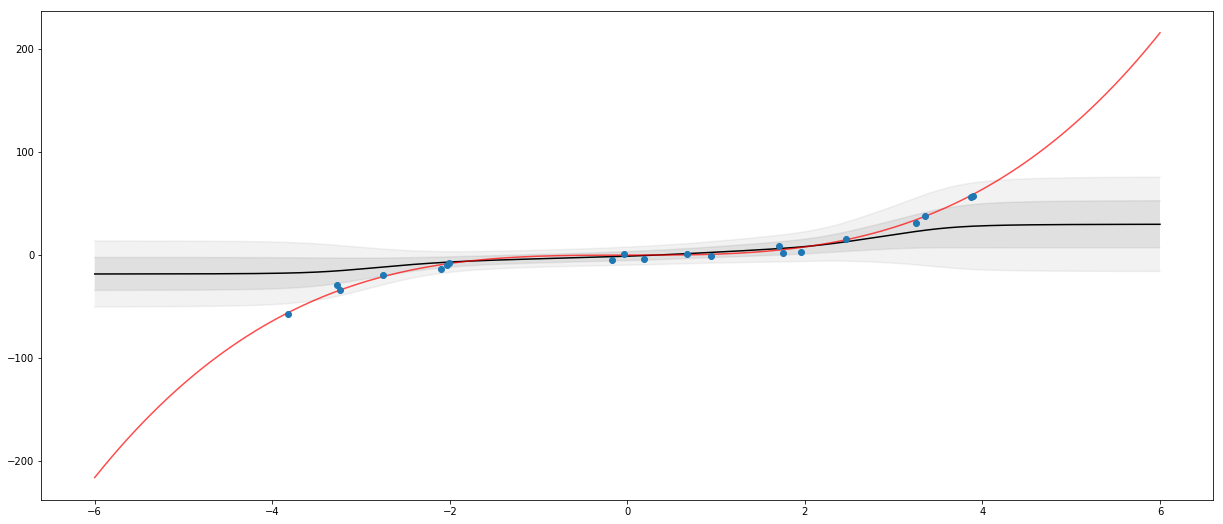

In [181]:
upper1 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) + np.std(predictions_psgld[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) + 2 * np.std(predictions_psgld[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) - np.std(predictions_psgld[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) - 2 * np.std(predictions_psgld[:,1:].detach().numpy(),1)

plt.figure(figsize=(21,9))
plt.plot(grid,np.mean(predictions_psgld[:,1:].detach().numpy(),1), 'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.12)
plt.plot(grid,lower2,'gray',alpha=0.1)
plt.fill_between(grid.squeeze(),lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid.squeeze(),lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,grid ** 3,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')


### KSGLD

In [82]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgld




if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

lambda_ = 1e-1
lr = 1e-3
alpha = 0.99


batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=True)

optim = ksgld.optim.KSGLD(network, criterion, batch_size, dataset_size, eta=1., v=0., lambda_=1e-1, epsilon=5e-5, l2=1e-3, invert_every=1)


predictions_ksgld = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(20000):

    running_loss = 0
    
    optim.update_curvature(x)
    
    network.zero_grad()
    output = network(x)
    loss = criterion(output, y)
    loss.backward()
    optim.step()



    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    if (t >= 300) & (t % 100 == 0):
        with torch.autograd.no_grad():
            output = network(x_test)
            predictions_ksgld = torch.cat((predictions_ksgld, output), 1)

    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

Epoch 0 - loss: 738.4934
Epoch 1 - loss: 738.3257
Epoch 2 - loss: 738.1792
Epoch 3 - loss: 738.0730
Epoch 4 - loss: 737.8964
Epoch 5 - loss: 737.7934
Epoch 6 - loss: 737.6491
Epoch 7 - loss: 737.7350
Epoch 8 - loss: 737.5099
Epoch 9 - loss: 737.4498
Epoch 10 - loss: 737.3743
Epoch 11 - loss: 737.2593
Epoch 12 - loss: 737.0725
Epoch 13 - loss: 736.8638
Epoch 14 - loss: 736.6996
Epoch 15 - loss: 736.5817
Epoch 16 - loss: 736.3918
Epoch 17 - loss: 736.2516
Epoch 18 - loss: 736.0989
Epoch 19 - loss: 735.7876
Epoch 20 - loss: 735.6090
Epoch 21 - loss: 735.5640
Epoch 22 - loss: 735.4510
Epoch 23 - loss: 735.3610
Epoch 24 - loss: 735.2194
Epoch 25 - loss: 735.1818
Epoch 26 - loss: 735.0465
Epoch 27 - loss: 734.7334
Epoch 28 - loss: 734.6182
Epoch 29 - loss: 734.4451
Epoch 30 - loss: 734.1397
Epoch 31 - loss: 733.9765
Epoch 32 - loss: 733.7759
Epoch 33 - loss: 733.8152
Epoch 34 - loss: 733.5886
Epoch 35 - loss: 733.3654
Epoch 36 - loss: 733.2958
Epoch 37 - loss: 733.3691
Epoch 38 - loss: 733.2

Epoch 333 - loss: 682.3361
Epoch 334 - loss: 683.0472
Epoch 335 - loss: 683.4569
Epoch 336 - loss: 683.6466
Epoch 337 - loss: 683.3067
Epoch 338 - loss: 683.1498
Epoch 339 - loss: 682.9435
Epoch 340 - loss: 682.4128
Epoch 341 - loss: 681.8920
Epoch 342 - loss: 681.3485
Epoch 343 - loss: 681.3743
Epoch 344 - loss: 680.1399
Epoch 345 - loss: 680.0627
Epoch 346 - loss: 679.1711
Epoch 347 - loss: 679.3999
Epoch 348 - loss: 678.9641
Epoch 349 - loss: 678.9967
Epoch 350 - loss: 679.0990
Epoch 351 - loss: 680.0714
Epoch 352 - loss: 679.1940
Epoch 353 - loss: 677.9000
Epoch 354 - loss: 677.3972
Epoch 355 - loss: 677.2420
Epoch 356 - loss: 677.4424
Epoch 357 - loss: 676.6664
Epoch 358 - loss: 676.2580
Epoch 359 - loss: 676.5560
Epoch 360 - loss: 676.1782
Epoch 361 - loss: 676.1724
Epoch 362 - loss: 676.0265
Epoch 363 - loss: 675.6550
Epoch 364 - loss: 675.4611
Epoch 365 - loss: 674.8159
Epoch 366 - loss: 674.3625
Epoch 367 - loss: 674.3642
Epoch 368 - loss: 673.3051
Epoch 369 - loss: 673.3248
E

Epoch 666 - loss: 586.5858
Epoch 667 - loss: 585.3428
Epoch 668 - loss: 585.6493
Epoch 669 - loss: 582.8780
Epoch 670 - loss: 581.6151
Epoch 671 - loss: 584.9148
Epoch 672 - loss: 584.5776
Epoch 673 - loss: 583.5779
Epoch 674 - loss: 582.9634
Epoch 675 - loss: 581.7450
Epoch 676 - loss: 580.9163
Epoch 677 - loss: 580.1991
Epoch 678 - loss: 578.8292
Epoch 679 - loss: 577.5148
Epoch 680 - loss: 578.6157
Epoch 681 - loss: 577.3937
Epoch 682 - loss: 576.9164
Epoch 683 - loss: 577.3516
Epoch 684 - loss: 576.1014
Epoch 685 - loss: 576.8290
Epoch 686 - loss: 574.2025
Epoch 687 - loss: 571.8756
Epoch 688 - loss: 567.6432
Epoch 689 - loss: 567.1862
Epoch 690 - loss: 567.7747
Epoch 691 - loss: 567.3126
Epoch 692 - loss: 567.8265
Epoch 693 - loss: 564.6606
Epoch 694 - loss: 565.9572
Epoch 695 - loss: 566.4059
Epoch 696 - loss: 565.9785
Epoch 697 - loss: 564.2365
Epoch 698 - loss: 561.2893
Epoch 699 - loss: 558.7478
Epoch 700 - loss: 560.0676
Epoch 701 - loss: 559.0499
Epoch 702 - loss: 559.0306
E

Epoch 1000 - loss: 466.9878
Epoch 1001 - loss: 466.4851
Epoch 1002 - loss: 466.6768
Epoch 1003 - loss: 469.0479
Epoch 1004 - loss: 470.3575
Epoch 1005 - loss: 468.3508
Epoch 1006 - loss: 471.6322
Epoch 1007 - loss: 472.1510
Epoch 1008 - loss: 472.2863
Epoch 1009 - loss: 472.3708
Epoch 1010 - loss: 470.3715
Epoch 1011 - loss: 464.8527
Epoch 1012 - loss: 467.7508
Epoch 1013 - loss: 469.2236
Epoch 1014 - loss: 471.5675
Epoch 1015 - loss: 472.9545
Epoch 1016 - loss: 473.2694
Epoch 1017 - loss: 472.8437
Epoch 1018 - loss: 475.7625
Epoch 1019 - loss: 473.4741
Epoch 1020 - loss: 475.4217
Epoch 1021 - loss: 476.8770
Epoch 1022 - loss: 476.2865
Epoch 1023 - loss: 477.1641
Epoch 1024 - loss: 477.1076
Epoch 1025 - loss: 473.9335
Epoch 1026 - loss: 474.5659
Epoch 1027 - loss: 472.8519
Epoch 1028 - loss: 470.6314
Epoch 1029 - loss: 472.1422
Epoch 1030 - loss: 474.3210
Epoch 1031 - loss: 477.9375
Epoch 1032 - loss: 476.4260
Epoch 1033 - loss: 474.4994
Epoch 1034 - loss: 474.9128
Epoch 1035 - loss: 4

Epoch 1329 - loss: 442.3651
Epoch 1330 - loss: 442.1432
Epoch 1331 - loss: 443.5058
Epoch 1332 - loss: 444.8115
Epoch 1333 - loss: 448.2717
Epoch 1334 - loss: 449.2139
Epoch 1335 - loss: 448.9327
Epoch 1336 - loss: 449.4088
Epoch 1337 - loss: 453.2834
Epoch 1338 - loss: 456.4818
Epoch 1339 - loss: 456.0775
Epoch 1340 - loss: 454.5512
Epoch 1341 - loss: 448.2071
Epoch 1342 - loss: 441.0102
Epoch 1343 - loss: 438.7656
Epoch 1344 - loss: 438.7962
Epoch 1345 - loss: 435.9807
Epoch 1346 - loss: 432.5036
Epoch 1347 - loss: 434.3452
Epoch 1348 - loss: 437.4426
Epoch 1349 - loss: 440.2073
Epoch 1350 - loss: 434.0366
Epoch 1351 - loss: 430.0248
Epoch 1352 - loss: 428.6396
Epoch 1353 - loss: 424.3752
Epoch 1354 - loss: 420.4818
Epoch 1355 - loss: 425.0106
Epoch 1356 - loss: 427.8412
Epoch 1357 - loss: 429.7900
Epoch 1358 - loss: 436.6554
Epoch 1359 - loss: 438.0277
Epoch 1360 - loss: 437.8403
Epoch 1361 - loss: 441.2609
Epoch 1362 - loss: 443.0222
Epoch 1363 - loss: 451.2640
Epoch 1364 - loss: 4

Epoch 1632 - loss: 350.3217
Epoch 1633 - loss: 352.0846
Epoch 1634 - loss: 345.4416
Epoch 1635 - loss: 351.2547
Epoch 1636 - loss: 338.5235
Epoch 1637 - loss: 331.7387
Epoch 1638 - loss: 332.4492
Epoch 1639 - loss: 339.2779
Epoch 1640 - loss: 338.3492
Epoch 1641 - loss: 341.6001
Epoch 1642 - loss: 336.7681
Epoch 1643 - loss: 325.8459
Epoch 1644 - loss: 323.9431
Epoch 1645 - loss: 326.6982
Epoch 1646 - loss: 329.2083
Epoch 1647 - loss: 327.0071
Epoch 1648 - loss: 324.4814
Epoch 1649 - loss: 320.2583
Epoch 1650 - loss: 319.6196
Epoch 1651 - loss: 322.2161
Epoch 1652 - loss: 330.2044
Epoch 1653 - loss: 323.2494
Epoch 1654 - loss: 323.8299
Epoch 1655 - loss: 320.2044
Epoch 1656 - loss: 326.8507
Epoch 1657 - loss: 329.5902
Epoch 1658 - loss: 330.3297
Epoch 1659 - loss: 318.5146
Epoch 1660 - loss: 314.4910
Epoch 1661 - loss: 317.2914
Epoch 1662 - loss: 316.1954
Epoch 1663 - loss: 302.5093
Epoch 1664 - loss: 302.2515
Epoch 1665 - loss: 298.5005
Epoch 1666 - loss: 290.4896
Epoch 1667 - loss: 2

Epoch 1941 - loss: 270.4277
Epoch 1942 - loss: 267.4233
Epoch 1943 - loss: 262.1058
Epoch 1944 - loss: 265.0767
Epoch 1945 - loss: 272.3736
Epoch 1946 - loss: 263.3475
Epoch 1947 - loss: 247.1214
Epoch 1948 - loss: 266.2913
Epoch 1949 - loss: 260.9185
Epoch 1950 - loss: 256.5604
Epoch 1951 - loss: 249.0015
Epoch 1952 - loss: 255.3152
Epoch 1953 - loss: 252.6877
Epoch 1954 - loss: 257.2054
Epoch 1955 - loss: 260.8663
Epoch 1956 - loss: 260.6784
Epoch 1957 - loss: 261.3111
Epoch 1958 - loss: 264.8636
Epoch 1959 - loss: 267.5127
Epoch 1960 - loss: 266.1969
Epoch 1961 - loss: 256.8718
Epoch 1962 - loss: 256.2040
Epoch 1963 - loss: 253.8575
Epoch 1964 - loss: 251.9474
Epoch 1965 - loss: 248.8743
Epoch 1966 - loss: 246.6738
Epoch 1967 - loss: 239.4742
Epoch 1968 - loss: 241.4829
Epoch 1969 - loss: 241.5512
Epoch 1970 - loss: 229.6903
Epoch 1971 - loss: 228.3695
Epoch 1972 - loss: 238.1056
Epoch 1973 - loss: 244.2208
Epoch 1974 - loss: 253.2903
Epoch 1975 - loss: 254.1371
Epoch 1976 - loss: 2

Epoch 2243 - loss: 333.6576
Epoch 2244 - loss: 334.6158
Epoch 2245 - loss: 326.7427
Epoch 2246 - loss: 324.6026
Epoch 2247 - loss: 321.9017
Epoch 2248 - loss: 329.3979
Epoch 2249 - loss: 315.8174
Epoch 2250 - loss: 317.4094
Epoch 2251 - loss: 321.0475
Epoch 2252 - loss: 318.8788
Epoch 2253 - loss: 316.9615
Epoch 2254 - loss: 329.6320
Epoch 2255 - loss: 328.8592
Epoch 2256 - loss: 333.6759
Epoch 2257 - loss: 335.2983
Epoch 2258 - loss: 324.4956
Epoch 2259 - loss: 326.6823
Epoch 2260 - loss: 326.2914
Epoch 2261 - loss: 324.2903
Epoch 2262 - loss: 323.9927
Epoch 2263 - loss: 329.4979
Epoch 2264 - loss: 336.9174
Epoch 2265 - loss: 337.1789
Epoch 2266 - loss: 329.5331
Epoch 2267 - loss: 322.0839
Epoch 2268 - loss: 323.2232
Epoch 2269 - loss: 324.5413
Epoch 2270 - loss: 325.5373
Epoch 2271 - loss: 330.6999
Epoch 2272 - loss: 335.9277
Epoch 2273 - loss: 332.1962
Epoch 2274 - loss: 333.4423
Epoch 2275 - loss: 326.7130
Epoch 2276 - loss: 322.5280
Epoch 2277 - loss: 325.1223
Epoch 2278 - loss: 3

Epoch 2543 - loss: 524.6416
Epoch 2544 - loss: 513.0641
Epoch 2545 - loss: 501.1500
Epoch 2546 - loss: 501.7322
Epoch 2547 - loss: 504.7157
Epoch 2548 - loss: 504.6619
Epoch 2549 - loss: 507.2481
Epoch 2550 - loss: 531.5432
Epoch 2551 - loss: 542.5948
Epoch 2552 - loss: 529.1127
Epoch 2553 - loss: 524.6815
Epoch 2554 - loss: 518.4098
Epoch 2555 - loss: 507.9105
Epoch 2556 - loss: 515.8793
Epoch 2557 - loss: 551.7052
Epoch 2558 - loss: 548.2166
Epoch 2559 - loss: 542.6615
Epoch 2560 - loss: 546.2473
Epoch 2561 - loss: 554.8211
Epoch 2562 - loss: 545.2798
Epoch 2563 - loss: 551.9130
Epoch 2564 - loss: 547.5818
Epoch 2565 - loss: 557.8109
Epoch 2566 - loss: 568.8384
Epoch 2567 - loss: 578.9491
Epoch 2568 - loss: 566.9210
Epoch 2569 - loss: 570.2789
Epoch 2570 - loss: 567.3423
Epoch 2571 - loss: 566.3835
Epoch 2572 - loss: 557.8314
Epoch 2573 - loss: 548.6179
Epoch 2574 - loss: 575.6497
Epoch 2575 - loss: 591.9255
Epoch 2576 - loss: 578.9663
Epoch 2577 - loss: 563.6453
Epoch 2578 - loss: 5

Epoch 2855 - loss: 557.6917
Epoch 2856 - loss: 532.0961
Epoch 2857 - loss: 523.1677
Epoch 2858 - loss: 527.7834
Epoch 2859 - loss: 540.5895
Epoch 2860 - loss: 552.6285
Epoch 2861 - loss: 539.6268
Epoch 2862 - loss: 553.9433
Epoch 2863 - loss: 556.9616
Epoch 2864 - loss: 541.9967
Epoch 2865 - loss: 550.8868
Epoch 2866 - loss: 550.1761
Epoch 2867 - loss: 576.9670
Epoch 2868 - loss: 571.0052
Epoch 2869 - loss: 581.4476
Epoch 2870 - loss: 574.6714
Epoch 2871 - loss: 590.7831
Epoch 2872 - loss: 582.6683
Epoch 2873 - loss: 586.3128
Epoch 2874 - loss: 583.9178
Epoch 2875 - loss: 576.7326
Epoch 2876 - loss: 574.7910
Epoch 2877 - loss: 553.8407
Epoch 2878 - loss: 541.7368
Epoch 2879 - loss: 530.9579
Epoch 2880 - loss: 525.5823
Epoch 2881 - loss: 538.4623
Epoch 2882 - loss: 529.1115
Epoch 2883 - loss: 537.7155
Epoch 2884 - loss: 526.9753
Epoch 2885 - loss: 535.5242
Epoch 2886 - loss: 550.8643
Epoch 2887 - loss: 548.0098
Epoch 2888 - loss: 536.8923
Epoch 2889 - loss: 542.3766
Epoch 2890 - loss: 5

Epoch 3192 - loss: 634.9590
Epoch 3193 - loss: 647.4770
Epoch 3194 - loss: 633.5729
Epoch 3195 - loss: 623.7634
Epoch 3196 - loss: 611.0201
Epoch 3197 - loss: 622.9054
Epoch 3198 - loss: 653.9603
Epoch 3199 - loss: 660.6016
Epoch 3200 - loss: 673.0952
Epoch 3201 - loss: 676.6741
Epoch 3202 - loss: 688.4999
Epoch 3203 - loss: 677.7994
Epoch 3204 - loss: 676.7789
Epoch 3205 - loss: 678.5579
Epoch 3206 - loss: 692.6034
Epoch 3207 - loss: 700.8047
Epoch 3208 - loss: 699.5134
Epoch 3209 - loss: 694.5254
Epoch 3210 - loss: 706.7617
Epoch 3211 - loss: 725.9316
Epoch 3212 - loss: 730.6234
Epoch 3213 - loss: 715.4213
Epoch 3214 - loss: 724.5026
Epoch 3215 - loss: 720.9708
Epoch 3216 - loss: 707.3659
Epoch 3217 - loss: 692.6418
Epoch 3218 - loss: 679.9310
Epoch 3219 - loss: 671.7501
Epoch 3220 - loss: 675.0306
Epoch 3221 - loss: 687.8417
Epoch 3222 - loss: 691.1657
Epoch 3223 - loss: 694.9451
Epoch 3224 - loss: 709.8990
Epoch 3225 - loss: 723.1139
Epoch 3226 - loss: 721.2772
Epoch 3227 - loss: 7

Epoch 3507 - loss: 709.9656
Epoch 3508 - loss: 714.9511
Epoch 3509 - loss: 716.7239
Epoch 3510 - loss: 744.7542
Epoch 3511 - loss: 747.8873
Epoch 3512 - loss: 723.1831
Epoch 3513 - loss: 722.2045
Epoch 3514 - loss: 711.4409
Epoch 3515 - loss: 709.9085
Epoch 3516 - loss: 689.4946
Epoch 3517 - loss: 666.8640
Epoch 3518 - loss: 644.0094
Epoch 3519 - loss: 661.5598
Epoch 3520 - loss: 706.9316
Epoch 3521 - loss: 721.6620
Epoch 3522 - loss: 690.5053
Epoch 3523 - loss: 694.3098
Epoch 3524 - loss: 719.8649
Epoch 3525 - loss: 687.6169
Epoch 3526 - loss: 653.3112
Epoch 3527 - loss: 654.5531
Epoch 3528 - loss: 647.0294
Epoch 3529 - loss: 645.5605
Epoch 3530 - loss: 649.3251
Epoch 3531 - loss: 659.7472
Epoch 3532 - loss: 664.6647
Epoch 3533 - loss: 654.6363
Epoch 3534 - loss: 667.9866
Epoch 3535 - loss: 682.6510
Epoch 3536 - loss: 679.8267
Epoch 3537 - loss: 668.5323
Epoch 3538 - loss: 677.2296
Epoch 3539 - loss: 661.4927
Epoch 3540 - loss: 668.0460
Epoch 3541 - loss: 663.3219
Epoch 3542 - loss: 6

Epoch 3812 - loss: 646.1977
Epoch 3813 - loss: 632.4100
Epoch 3814 - loss: 634.1433
Epoch 3815 - loss: 632.2142
Epoch 3816 - loss: 627.2823
Epoch 3817 - loss: 627.6393
Epoch 3818 - loss: 639.0355
Epoch 3819 - loss: 640.7969
Epoch 3820 - loss: 633.6710
Epoch 3821 - loss: 631.7334
Epoch 3822 - loss: 619.0884
Epoch 3823 - loss: 620.0087
Epoch 3824 - loss: 603.7019
Epoch 3825 - loss: 604.4479
Epoch 3826 - loss: 601.1243
Epoch 3827 - loss: 612.1530
Epoch 3828 - loss: 590.9345
Epoch 3829 - loss: 593.9775
Epoch 3830 - loss: 587.8219
Epoch 3831 - loss: 585.3303
Epoch 3832 - loss: 602.5848
Epoch 3833 - loss: 611.4489
Epoch 3834 - loss: 628.3376
Epoch 3835 - loss: 629.4399
Epoch 3836 - loss: 647.9381
Epoch 3837 - loss: 647.3078
Epoch 3838 - loss: 666.5579
Epoch 3839 - loss: 719.1566
Epoch 3840 - loss: 716.5400
Epoch 3841 - loss: 760.2788
Epoch 3842 - loss: 689.2587
Epoch 3843 - loss: 670.8248
Epoch 3844 - loss: 647.5198
Epoch 3845 - loss: 635.3174
Epoch 3846 - loss: 645.3621
Epoch 3847 - loss: 6

Epoch 4130 - loss: 688.0544
Epoch 4131 - loss: 733.0049
Epoch 4132 - loss: 719.8757
Epoch 4133 - loss: 762.5097
Epoch 4134 - loss: 736.9118
Epoch 4135 - loss: 714.9911
Epoch 4136 - loss: 789.3047
Epoch 4137 - loss: 698.4828
Epoch 4138 - loss: 720.3608
Epoch 4139 - loss: 679.7540
Epoch 4140 - loss: 729.2959
Epoch 4141 - loss: 663.0416
Epoch 4142 - loss: 704.0861
Epoch 4143 - loss: 666.0908
Epoch 4144 - loss: 616.2583
Epoch 4145 - loss: 628.3928
Epoch 4146 - loss: 616.6011
Epoch 4147 - loss: 614.4897
Epoch 4148 - loss: 620.0558
Epoch 4149 - loss: 682.7189
Epoch 4150 - loss: 639.7501
Epoch 4151 - loss: 601.7853
Epoch 4152 - loss: 605.7660
Epoch 4153 - loss: 605.6411
Epoch 4154 - loss: 694.4766
Epoch 4155 - loss: 761.3627
Epoch 4156 - loss: 765.1581
Epoch 4157 - loss: 788.6259
Epoch 4158 - loss: 761.7350
Epoch 4159 - loss: 731.8474
Epoch 4160 - loss: 679.6747
Epoch 4161 - loss: 675.2166
Epoch 4162 - loss: 697.5444
Epoch 4163 - loss: 700.3554
Epoch 4164 - loss: 653.3587
Epoch 4165 - loss: 6

Epoch 4470 - loss: 889.6418
Epoch 4471 - loss: 913.8936
Epoch 4472 - loss: 878.6925
Epoch 4473 - loss: 917.0768
Epoch 4474 - loss: 977.7497
Epoch 4475 - loss: 1080.5537
Epoch 4476 - loss: 1086.1594
Epoch 4477 - loss: 1039.8335
Epoch 4478 - loss: 1152.8496
Epoch 4479 - loss: 1261.6766
Epoch 4480 - loss: 1188.6194
Epoch 4481 - loss: 1197.5663
Epoch 4482 - loss: 1231.5974
Epoch 4483 - loss: 1158.5181
Epoch 4484 - loss: 1079.2069
Epoch 4485 - loss: 1082.6346
Epoch 4486 - loss: 1112.1162
Epoch 4487 - loss: 1136.6091
Epoch 4488 - loss: 1106.7997
Epoch 4489 - loss: 1063.8871
Epoch 4490 - loss: 1033.1292
Epoch 4491 - loss: 955.2164
Epoch 4492 - loss: 824.7508
Epoch 4493 - loss: 858.6627
Epoch 4494 - loss: 789.5952
Epoch 4495 - loss: 771.1324
Epoch 4496 - loss: 696.1385
Epoch 4497 - loss: 710.1467
Epoch 4498 - loss: 766.5189
Epoch 4499 - loss: 824.9539
Epoch 4500 - loss: 872.3303
Epoch 4501 - loss: 893.9562
Epoch 4502 - loss: 884.7728
Epoch 4503 - loss: 963.8116
Epoch 4504 - loss: 933.6727
Epoc

Epoch 4798 - loss: 9393.0732
Epoch 4799 - loss: 8211.3516
Epoch 4800 - loss: 8304.7578
Epoch 4801 - loss: 7130.7773
Epoch 4802 - loss: 5622.3467
Epoch 4803 - loss: 5733.5752
Epoch 4804 - loss: 5988.6846
Epoch 4805 - loss: 5756.6548
Epoch 4806 - loss: 6738.0439
Epoch 4807 - loss: 6348.0142
Epoch 4808 - loss: 6420.8706
Epoch 4809 - loss: 6591.9155
Epoch 4810 - loss: 5813.7188
Epoch 4811 - loss: 6520.9971
Epoch 4812 - loss: 6842.6924
Epoch 4813 - loss: 7034.5029
Epoch 4814 - loss: 6509.6357
Epoch 4815 - loss: 6324.4639
Epoch 4816 - loss: 5645.0200
Epoch 4817 - loss: 5914.0142
Epoch 4818 - loss: 5132.9707
Epoch 4819 - loss: 6879.9297
Epoch 4820 - loss: 6167.6963
Epoch 4821 - loss: 6741.5430
Epoch 4822 - loss: 6362.6001
Epoch 4823 - loss: 7173.3086
Epoch 4824 - loss: 8205.8506
Epoch 4825 - loss: 8408.4697
Epoch 4826 - loss: 8276.1895
Epoch 4827 - loss: 7792.6885
Epoch 4828 - loss: 6810.6104
Epoch 4829 - loss: 7561.9131
Epoch 4830 - loss: 6304.6123
Epoch 4831 - loss: 6932.7720
Epoch 4832 - l

Epoch 5094 - loss: 839.1522
Epoch 5095 - loss: 840.2620
Epoch 5096 - loss: 849.1334
Epoch 5097 - loss: 862.1360
Epoch 5098 - loss: 850.9241
Epoch 5099 - loss: 877.0995
Epoch 5100 - loss: 870.5609
Epoch 5101 - loss: 847.2492
Epoch 5102 - loss: 841.5482
Epoch 5103 - loss: 843.4956
Epoch 5104 - loss: 833.8423
Epoch 5105 - loss: 824.3455
Epoch 5106 - loss: 825.3348
Epoch 5107 - loss: 823.7814
Epoch 5108 - loss: 824.9422
Epoch 5109 - loss: 822.3905
Epoch 5110 - loss: 825.0883
Epoch 5111 - loss: 824.4318
Epoch 5112 - loss: 822.0992
Epoch 5113 - loss: 821.1649
Epoch 5114 - loss: 821.1671
Epoch 5115 - loss: 819.9034
Epoch 5116 - loss: 817.0477
Epoch 5117 - loss: 816.2469
Epoch 5118 - loss: 817.3301
Epoch 5119 - loss: 821.0451
Epoch 5120 - loss: 823.4163
Epoch 5121 - loss: 820.5438
Epoch 5122 - loss: 819.5713
Epoch 5123 - loss: 817.7001
Epoch 5124 - loss: 817.5981
Epoch 5125 - loss: 819.2947
Epoch 5126 - loss: 821.0555
Epoch 5127 - loss: 819.2570
Epoch 5128 - loss: 819.6460
Epoch 5129 - loss: 8

Epoch 5404 - loss: 934.7176
Epoch 5405 - loss: 931.0329
Epoch 5406 - loss: 921.6031
Epoch 5407 - loss: 931.6126
Epoch 5408 - loss: 923.5444
Epoch 5409 - loss: 927.9733
Epoch 5410 - loss: 927.7980
Epoch 5411 - loss: 956.9381
Epoch 5412 - loss: 967.6349
Epoch 5413 - loss: 961.1681
Epoch 5414 - loss: 944.2773
Epoch 5415 - loss: 934.7777
Epoch 5416 - loss: 934.2604
Epoch 5417 - loss: 950.7874
Epoch 5418 - loss: 941.9601
Epoch 5419 - loss: 937.8022
Epoch 5420 - loss: 923.6237
Epoch 5421 - loss: 923.9470
Epoch 5422 - loss: 916.1322
Epoch 5423 - loss: 924.0175
Epoch 5424 - loss: 900.1735
Epoch 5425 - loss: 903.6008
Epoch 5426 - loss: 915.1991
Epoch 5427 - loss: 919.1927
Epoch 5428 - loss: 921.8083
Epoch 5429 - loss: 927.2081
Epoch 5430 - loss: 921.1716
Epoch 5431 - loss: 922.1107
Epoch 5432 - loss: 921.6262
Epoch 5433 - loss: 948.3131
Epoch 5434 - loss: 958.9323
Epoch 5435 - loss: 950.7069
Epoch 5436 - loss: 973.6883
Epoch 5437 - loss: 958.2200
Epoch 5438 - loss: 930.9111
Epoch 5439 - loss: 9

Epoch 5709 - loss: 1733.9304
Epoch 5710 - loss: 1916.0134
Epoch 5711 - loss: 1891.2812
Epoch 5712 - loss: 1853.8000
Epoch 5713 - loss: 1852.9014
Epoch 5714 - loss: 1808.4723
Epoch 5715 - loss: 1767.1783
Epoch 5716 - loss: 1695.4553
Epoch 5717 - loss: 1682.3326
Epoch 5718 - loss: 1695.7585
Epoch 5719 - loss: 1747.0459
Epoch 5720 - loss: 1867.8914
Epoch 5721 - loss: 1888.1523
Epoch 5722 - loss: 1909.0840
Epoch 5723 - loss: 1854.7865
Epoch 5724 - loss: 1832.9128
Epoch 5725 - loss: 1769.1237
Epoch 5726 - loss: 1651.8033
Epoch 5727 - loss: 1722.4099
Epoch 5728 - loss: 1749.6012
Epoch 5729 - loss: 1875.5950
Epoch 5730 - loss: 1905.9475
Epoch 5731 - loss: 1768.2039
Epoch 5732 - loss: 1728.9420
Epoch 5733 - loss: 1669.7992
Epoch 5734 - loss: 1685.2350
Epoch 5735 - loss: 1701.1927
Epoch 5736 - loss: 1636.0179
Epoch 5737 - loss: 1696.0193
Epoch 5738 - loss: 1729.6373
Epoch 5739 - loss: 1732.2494
Epoch 5740 - loss: 1790.7148
Epoch 5741 - loss: 1775.5074
Epoch 5742 - loss: 1687.6156
Epoch 5743 - l

Epoch 6026 - loss: 1391.7200
Epoch 6027 - loss: 1381.5598
Epoch 6028 - loss: 1435.9596
Epoch 6029 - loss: 1504.2990
Epoch 6030 - loss: 1515.6455
Epoch 6031 - loss: 1522.3254
Epoch 6032 - loss: 1498.5149
Epoch 6033 - loss: 1476.5491
Epoch 6034 - loss: 1429.8367
Epoch 6035 - loss: 1366.8142
Epoch 6036 - loss: 1339.3855
Epoch 6037 - loss: 1333.0164
Epoch 6038 - loss: 1316.3948
Epoch 6039 - loss: 1367.0951
Epoch 6040 - loss: 1257.9032
Epoch 6041 - loss: 1268.7272
Epoch 6042 - loss: 1283.0002
Epoch 6043 - loss: 1229.3572
Epoch 6044 - loss: 1159.4060
Epoch 6045 - loss: 1163.2998
Epoch 6046 - loss: 1126.2844
Epoch 6047 - loss: 1152.7483
Epoch 6048 - loss: 1164.7220
Epoch 6049 - loss: 1105.8772
Epoch 6050 - loss: 1129.1168
Epoch 6051 - loss: 1158.1924
Epoch 6052 - loss: 1231.5264
Epoch 6053 - loss: 1273.2992
Epoch 6054 - loss: 1256.7283
Epoch 6055 - loss: 1259.6262
Epoch 6056 - loss: 1293.9127
Epoch 6057 - loss: 1272.1483
Epoch 6058 - loss: 1222.7937
Epoch 6059 - loss: 1186.3093
Epoch 6060 - l

Epoch 6347 - loss: 1063.3333
Epoch 6348 - loss: 1091.1392
Epoch 6349 - loss: 1129.7804
Epoch 6350 - loss: 1147.9641
Epoch 6351 - loss: 1121.3610
Epoch 6352 - loss: 1141.2449
Epoch 6353 - loss: 1128.7566
Epoch 6354 - loss: 1100.1589
Epoch 6355 - loss: 1076.0168
Epoch 6356 - loss: 1045.3290
Epoch 6357 - loss: 1082.7490
Epoch 6358 - loss: 1080.4211
Epoch 6359 - loss: 1088.3712
Epoch 6360 - loss: 1108.5156
Epoch 6361 - loss: 1109.6459
Epoch 6362 - loss: 1134.7719
Epoch 6363 - loss: 1153.3512
Epoch 6364 - loss: 1090.9629
Epoch 6365 - loss: 1116.7029
Epoch 6366 - loss: 1226.4949
Epoch 6367 - loss: 1213.1091
Epoch 6368 - loss: 1257.7927
Epoch 6369 - loss: 1252.9192
Epoch 6370 - loss: 1223.0498
Epoch 6371 - loss: 1246.7300
Epoch 6372 - loss: 1234.3054
Epoch 6373 - loss: 1219.4480
Epoch 6374 - loss: 1262.1868
Epoch 6375 - loss: 1263.8320
Epoch 6376 - loss: 1224.9061
Epoch 6377 - loss: 1274.3123
Epoch 6378 - loss: 1297.9680
Epoch 6379 - loss: 1357.7527
Epoch 6380 - loss: 1347.6857
Epoch 6381 - l

Epoch 6638 - loss: 1204.3541
Epoch 6639 - loss: 1244.6641
Epoch 6640 - loss: 1125.4519
Epoch 6641 - loss: 1111.4763
Epoch 6642 - loss: 1101.4194
Epoch 6643 - loss: 1082.3131
Epoch 6644 - loss: 1123.8809
Epoch 6645 - loss: 1157.6257
Epoch 6646 - loss: 1182.7799
Epoch 6647 - loss: 1209.5050
Epoch 6648 - loss: 1191.3177
Epoch 6649 - loss: 1192.8494
Epoch 6650 - loss: 1224.6379
Epoch 6651 - loss: 1246.7515
Epoch 6652 - loss: 1227.1478
Epoch 6653 - loss: 1167.0885
Epoch 6654 - loss: 1167.6870
Epoch 6655 - loss: 1184.2507
Epoch 6656 - loss: 1234.0638
Epoch 6657 - loss: 1213.7698
Epoch 6658 - loss: 1281.0510
Epoch 6659 - loss: 1326.4036
Epoch 6660 - loss: 1271.1527
Epoch 6661 - loss: 1324.5916
Epoch 6662 - loss: 1302.7742
Epoch 6663 - loss: 1308.3732
Epoch 6664 - loss: 1301.7915
Epoch 6665 - loss: 1286.0208
Epoch 6666 - loss: 1245.5547
Epoch 6667 - loss: 1257.2131
Epoch 6668 - loss: 1239.5706
Epoch 6669 - loss: 1229.2000
Epoch 6670 - loss: 1261.7759
Epoch 6671 - loss: 1308.6068
Epoch 6672 - l

Epoch 6954 - loss: 1781.1418
Epoch 6955 - loss: 1770.3141
Epoch 6956 - loss: 1795.5254
Epoch 6957 - loss: 1774.4089
Epoch 6958 - loss: 1720.0164
Epoch 6959 - loss: 1681.1316
Epoch 6960 - loss: 1712.5273
Epoch 6961 - loss: 1860.4434
Epoch 6962 - loss: 1817.5348
Epoch 6963 - loss: 1947.3278
Epoch 6964 - loss: 2032.9934
Epoch 6965 - loss: 2029.1586
Epoch 6966 - loss: 2041.1648
Epoch 6967 - loss: 2021.8070
Epoch 6968 - loss: 1965.8894
Epoch 6969 - loss: 1931.0339
Epoch 6970 - loss: 1818.3440
Epoch 6971 - loss: 1704.3684
Epoch 6972 - loss: 1712.2982
Epoch 6973 - loss: 1721.1562
Epoch 6974 - loss: 1688.4320
Epoch 6975 - loss: 1647.8080
Epoch 6976 - loss: 1653.6892
Epoch 6977 - loss: 1642.1324
Epoch 6978 - loss: 1593.2627
Epoch 6979 - loss: 1589.9436
Epoch 6980 - loss: 1602.4281
Epoch 6981 - loss: 1570.6963
Epoch 6982 - loss: 1515.0916
Epoch 6983 - loss: 1446.3806
Epoch 6984 - loss: 1476.0006
Epoch 6985 - loss: 1481.2268
Epoch 6986 - loss: 1487.4312
Epoch 6987 - loss: 1447.6993
Epoch 6988 - l

Epoch 7246 - loss: 1174.4281
Epoch 7247 - loss: 1203.9047
Epoch 7248 - loss: 1202.8977
Epoch 7249 - loss: 1207.6415
Epoch 7250 - loss: 1254.1587
Epoch 7251 - loss: 1225.6268
Epoch 7252 - loss: 1250.8333
Epoch 7253 - loss: 1191.8502
Epoch 7254 - loss: 1209.2024
Epoch 7255 - loss: 1203.1298
Epoch 7256 - loss: 1181.7031
Epoch 7257 - loss: 1199.0325
Epoch 7258 - loss: 1166.2853
Epoch 7259 - loss: 1199.3575
Epoch 7260 - loss: 1253.3541
Epoch 7261 - loss: 1314.7780
Epoch 7262 - loss: 1291.3237
Epoch 7263 - loss: 1319.6099
Epoch 7264 - loss: 1302.2073
Epoch 7265 - loss: 1324.4802
Epoch 7266 - loss: 1334.1267
Epoch 7267 - loss: 1392.7635
Epoch 7268 - loss: 1410.8059
Epoch 7269 - loss: 1392.3236
Epoch 7270 - loss: 1420.3367
Epoch 7271 - loss: 1407.2761
Epoch 7272 - loss: 1390.9177
Epoch 7273 - loss: 1356.6361
Epoch 7274 - loss: 1304.0837
Epoch 7275 - loss: 1349.1814
Epoch 7276 - loss: 1292.6482
Epoch 7277 - loss: 1300.7201
Epoch 7278 - loss: 1301.9261
Epoch 7279 - loss: 1248.6602
Epoch 7280 - l

Epoch 7551 - loss: 1801.7676
Epoch 7552 - loss: 1809.6555
Epoch 7553 - loss: 1772.8806
Epoch 7554 - loss: 1760.6523
Epoch 7555 - loss: 1805.5657
Epoch 7556 - loss: 1730.1748
Epoch 7557 - loss: 1666.8137
Epoch 7558 - loss: 1663.6663
Epoch 7559 - loss: 1640.2214
Epoch 7560 - loss: 1584.3639
Epoch 7561 - loss: 1604.3282
Epoch 7562 - loss: 1618.4275
Epoch 7563 - loss: 1604.1997
Epoch 7564 - loss: 1616.9675
Epoch 7565 - loss: 1548.7505
Epoch 7566 - loss: 1633.2410
Epoch 7567 - loss: 1671.7363
Epoch 7568 - loss: 1674.4625
Epoch 7569 - loss: 1584.9062
Epoch 7570 - loss: 1544.3251
Epoch 7571 - loss: 1500.3093
Epoch 7572 - loss: 1550.3342
Epoch 7573 - loss: 1579.7969
Epoch 7574 - loss: 1590.5819
Epoch 7575 - loss: 1521.9580
Epoch 7576 - loss: 1545.4429
Epoch 7577 - loss: 1510.7368
Epoch 7578 - loss: 1435.5951
Epoch 7579 - loss: 1338.4027
Epoch 7580 - loss: 1304.5603
Epoch 7581 - loss: 1294.8223
Epoch 7582 - loss: 1314.2220
Epoch 7583 - loss: 1264.9792
Epoch 7584 - loss: 1239.9343
Epoch 7585 - l

Epoch 7846 - loss: 1321.4518
Epoch 7847 - loss: 1329.8110
Epoch 7848 - loss: 1369.2239
Epoch 7849 - loss: 1348.6782
Epoch 7850 - loss: 1389.9270
Epoch 7851 - loss: 1410.4060
Epoch 7852 - loss: 1390.1019
Epoch 7853 - loss: 1362.2288
Epoch 7854 - loss: 1478.4338
Epoch 7855 - loss: 1460.6715
Epoch 7856 - loss: 1539.7832
Epoch 7857 - loss: 1511.2142
Epoch 7858 - loss: 1495.2493
Epoch 7859 - loss: 1490.1628
Epoch 7860 - loss: 1501.6072
Epoch 7861 - loss: 1461.8694
Epoch 7862 - loss: 1465.7189
Epoch 7863 - loss: 1386.2490
Epoch 7864 - loss: 1328.4407
Epoch 7865 - loss: 1322.6791
Epoch 7866 - loss: 1382.5312
Epoch 7867 - loss: 1284.3054
Epoch 7868 - loss: 1284.4235
Epoch 7869 - loss: 1279.4576
Epoch 7870 - loss: 1274.7178
Epoch 7871 - loss: 1275.3466
Epoch 7872 - loss: 1298.3696
Epoch 7873 - loss: 1299.1746
Epoch 7874 - loss: 1288.1429
Epoch 7875 - loss: 1269.1235
Epoch 7876 - loss: 1233.1836
Epoch 7877 - loss: 1213.1289
Epoch 7878 - loss: 1225.8726
Epoch 7879 - loss: 1188.3643
Epoch 7880 - l

Epoch 8183 - loss: 1068.6671
Epoch 8184 - loss: 1071.8601
Epoch 8185 - loss: 1083.8507
Epoch 8186 - loss: 1090.6840
Epoch 8187 - loss: 1108.4911
Epoch 8188 - loss: 1119.0417
Epoch 8189 - loss: 1139.4559
Epoch 8190 - loss: 1200.8939
Epoch 8191 - loss: 1141.2325
Epoch 8192 - loss: 1126.3014
Epoch 8193 - loss: 1146.8788
Epoch 8194 - loss: 1174.6301
Epoch 8195 - loss: 1162.1160
Epoch 8196 - loss: 1175.7571
Epoch 8197 - loss: 1159.4043
Epoch 8198 - loss: 1118.3044
Epoch 8199 - loss: 1090.1292
Epoch 8200 - loss: 1130.2296
Epoch 8201 - loss: 1148.5171
Epoch 8202 - loss: 1115.0337
Epoch 8203 - loss: 1094.6573
Epoch 8204 - loss: 1054.7703
Epoch 8205 - loss: 1036.1997
Epoch 8206 - loss: 1053.3264
Epoch 8207 - loss: 1054.9672
Epoch 8208 - loss: 1012.6722
Epoch 8209 - loss: 993.0316
Epoch 8210 - loss: 975.2132
Epoch 8211 - loss: 980.1610
Epoch 8212 - loss: 940.9867
Epoch 8213 - loss: 922.2535
Epoch 8214 - loss: 916.6154
Epoch 8215 - loss: 930.5690
Epoch 8216 - loss: 953.8287
Epoch 8217 - loss: 955

Epoch 8493 - loss: 1031.2021
Epoch 8494 - loss: 1025.3569
Epoch 8495 - loss: 1006.6411
Epoch 8496 - loss: 1013.1675
Epoch 8497 - loss: 1021.9363
Epoch 8498 - loss: 1003.2803
Epoch 8499 - loss: 983.9512
Epoch 8500 - loss: 994.6086
Epoch 8501 - loss: 1036.9255
Epoch 8502 - loss: 1042.5776
Epoch 8503 - loss: 1068.8197
Epoch 8504 - loss: 1053.0123
Epoch 8505 - loss: 1020.3128
Epoch 8506 - loss: 1035.6683
Epoch 8507 - loss: 1030.8197
Epoch 8508 - loss: 995.3763
Epoch 8509 - loss: 989.4391
Epoch 8510 - loss: 1023.0900
Epoch 8511 - loss: 1037.9844
Epoch 8512 - loss: 1015.5303
Epoch 8513 - loss: 982.0509
Epoch 8514 - loss: 959.9026
Epoch 8515 - loss: 939.1017
Epoch 8516 - loss: 973.5466
Epoch 8517 - loss: 1043.3837
Epoch 8518 - loss: 1061.0905
Epoch 8519 - loss: 1016.8260
Epoch 8520 - loss: 980.4316
Epoch 8521 - loss: 983.5933
Epoch 8522 - loss: 995.3754
Epoch 8523 - loss: 998.5973
Epoch 8524 - loss: 1017.7612
Epoch 8525 - loss: 1050.7914
Epoch 8526 - loss: 1046.1687
Epoch 8527 - loss: 1002.11

Epoch 8808 - loss: 1318.7188
Epoch 8809 - loss: 1350.4092
Epoch 8810 - loss: 1338.2356
Epoch 8811 - loss: 1372.6375
Epoch 8812 - loss: 1410.7826
Epoch 8813 - loss: 1449.6931
Epoch 8814 - loss: 1452.6185
Epoch 8815 - loss: 1444.9385
Epoch 8816 - loss: 1505.8113
Epoch 8817 - loss: 1577.7164
Epoch 8818 - loss: 1539.3927
Epoch 8819 - loss: 1653.0811
Epoch 8820 - loss: 1582.6809
Epoch 8821 - loss: 1574.2544
Epoch 8822 - loss: 1569.7772
Epoch 8823 - loss: 1680.1611
Epoch 8824 - loss: 1737.0457
Epoch 8825 - loss: 1743.4026
Epoch 8826 - loss: 1656.6570
Epoch 8827 - loss: 1651.8047
Epoch 8828 - loss: 1643.4277
Epoch 8829 - loss: 1685.1846
Epoch 8830 - loss: 1647.1703
Epoch 8831 - loss: 1584.2400
Epoch 8832 - loss: 1720.1101
Epoch 8833 - loss: 1736.1960
Epoch 8834 - loss: 1739.4329
Epoch 8835 - loss: 1756.0195
Epoch 8836 - loss: 1729.5352
Epoch 8837 - loss: 1731.5989
Epoch 8838 - loss: 1774.4514
Epoch 8839 - loss: 1809.7340
Epoch 8840 - loss: 1837.6016
Epoch 8841 - loss: 1823.7250
Epoch 8842 - l

Epoch 9100 - loss: 1625.1007
Epoch 9101 - loss: 1780.3796
Epoch 9102 - loss: 1680.0105
Epoch 9103 - loss: 1713.4672
Epoch 9104 - loss: 1726.5238
Epoch 9105 - loss: 1711.9193
Epoch 9106 - loss: 1640.2307
Epoch 9107 - loss: 1600.8523
Epoch 9108 - loss: 1581.7722
Epoch 9109 - loss: 1639.6227
Epoch 9110 - loss: 1618.2112
Epoch 9111 - loss: 1612.0417
Epoch 9112 - loss: 1606.1377
Epoch 9113 - loss: 1783.9189
Epoch 9114 - loss: 1705.5823
Epoch 9115 - loss: 1780.1696
Epoch 9116 - loss: 1822.0857
Epoch 9117 - loss: 1688.1113
Epoch 9118 - loss: 1682.6898
Epoch 9119 - loss: 1663.7014
Epoch 9120 - loss: 1699.4567
Epoch 9121 - loss: 1751.6633
Epoch 9122 - loss: 1760.2703
Epoch 9123 - loss: 1745.1088
Epoch 9124 - loss: 1782.5107
Epoch 9125 - loss: 1793.5195
Epoch 9126 - loss: 1793.2063
Epoch 9127 - loss: 1808.5615
Epoch 9128 - loss: 1718.5746
Epoch 9129 - loss: 1747.3676
Epoch 9130 - loss: 1802.5049
Epoch 9131 - loss: 1925.7175
Epoch 9132 - loss: 1868.2344
Epoch 9133 - loss: 1745.5105
Epoch 9134 - l

Epoch 9403 - loss: 1059.4299
Epoch 9404 - loss: 1043.8621
Epoch 9405 - loss: 1024.2233
Epoch 9406 - loss: 930.1694
Epoch 9407 - loss: 967.6022
Epoch 9408 - loss: 960.1667
Epoch 9409 - loss: 935.9990
Epoch 9410 - loss: 924.7453
Epoch 9411 - loss: 890.5089
Epoch 9412 - loss: 806.3041
Epoch 9413 - loss: 797.5798
Epoch 9414 - loss: 781.4158
Epoch 9415 - loss: 790.1634
Epoch 9416 - loss: 800.8636
Epoch 9417 - loss: 764.7380
Epoch 9418 - loss: 758.3641
Epoch 9419 - loss: 728.9164
Epoch 9420 - loss: 783.3774
Epoch 9421 - loss: 770.5269
Epoch 9422 - loss: 769.9596
Epoch 9423 - loss: 743.1911
Epoch 9424 - loss: 762.7602
Epoch 9425 - loss: 773.8195
Epoch 9426 - loss: 793.1250
Epoch 9427 - loss: 813.0345
Epoch 9428 - loss: 820.5965
Epoch 9429 - loss: 803.4545
Epoch 9430 - loss: 768.9482
Epoch 9431 - loss: 776.3447
Epoch 9432 - loss: 782.8723
Epoch 9433 - loss: 807.1002
Epoch 9434 - loss: 837.5311
Epoch 9435 - loss: 838.5568
Epoch 9436 - loss: 835.8747
Epoch 9437 - loss: 870.0866
Epoch 9438 - loss

Epoch 9706 - loss: 1237.7949
Epoch 9707 - loss: 1250.7474
Epoch 9708 - loss: 1209.7400
Epoch 9709 - loss: 1205.6754
Epoch 9710 - loss: 1206.0870
Epoch 9711 - loss: 1245.8342
Epoch 9712 - loss: 1201.0371
Epoch 9713 - loss: 1156.0421
Epoch 9714 - loss: 1131.4280
Epoch 9715 - loss: 1148.1204
Epoch 9716 - loss: 1123.2308
Epoch 9717 - loss: 1130.2961
Epoch 9718 - loss: 975.4844
Epoch 9719 - loss: 998.5876
Epoch 9720 - loss: 921.4554
Epoch 9721 - loss: 924.9852
Epoch 9722 - loss: 903.1976
Epoch 9723 - loss: 895.4659
Epoch 9724 - loss: 887.3587
Epoch 9725 - loss: 922.7627
Epoch 9726 - loss: 905.4196
Epoch 9727 - loss: 872.9723
Epoch 9728 - loss: 850.3128
Epoch 9729 - loss: 861.0045
Epoch 9730 - loss: 869.5882
Epoch 9731 - loss: 840.4484
Epoch 9732 - loss: 889.6502
Epoch 9733 - loss: 890.0592
Epoch 9734 - loss: 836.8957
Epoch 9735 - loss: 835.4171
Epoch 9736 - loss: 829.1210
Epoch 9737 - loss: 789.9315
Epoch 9738 - loss: 753.4832
Epoch 9739 - loss: 745.5131
Epoch 9740 - loss: 750.5026
Epoch 97

Epoch 10031 - loss: 672.4230
Epoch 10032 - loss: 680.0411
Epoch 10033 - loss: 685.9852
Epoch 10034 - loss: 682.7551
Epoch 10035 - loss: 678.3732
Epoch 10036 - loss: 676.5452
Epoch 10037 - loss: 675.2945
Epoch 10038 - loss: 674.0834
Epoch 10039 - loss: 676.7807
Epoch 10040 - loss: 676.6540
Epoch 10041 - loss: 673.6049
Epoch 10042 - loss: 666.8698
Epoch 10043 - loss: 668.7970
Epoch 10044 - loss: 668.5590
Epoch 10045 - loss: 666.3317
Epoch 10046 - loss: 672.8923
Epoch 10047 - loss: 670.9540
Epoch 10048 - loss: 669.5675
Epoch 10049 - loss: 669.2040
Epoch 10050 - loss: 665.4442
Epoch 10051 - loss: 661.7209
Epoch 10052 - loss: 655.2974
Epoch 10053 - loss: 652.0445
Epoch 10054 - loss: 653.9535
Epoch 10055 - loss: 655.2550
Epoch 10056 - loss: 654.5170
Epoch 10057 - loss: 652.0627
Epoch 10058 - loss: 650.4779
Epoch 10059 - loss: 650.2768
Epoch 10060 - loss: 652.7264
Epoch 10061 - loss: 648.8616
Epoch 10062 - loss: 647.1899
Epoch 10063 - loss: 648.8529
Epoch 10064 - loss: 649.9746
Epoch 10065 - 

Epoch 10352 - loss: 691.6863
Epoch 10353 - loss: 693.8477
Epoch 10354 - loss: 703.9489
Epoch 10355 - loss: 700.8361
Epoch 10356 - loss: 696.6014
Epoch 10357 - loss: 687.8477
Epoch 10358 - loss: 679.5109
Epoch 10359 - loss: 672.7230
Epoch 10360 - loss: 667.8136
Epoch 10361 - loss: 677.2272
Epoch 10362 - loss: 677.2057
Epoch 10363 - loss: 678.9364
Epoch 10364 - loss: 678.1076
Epoch 10365 - loss: 680.7037
Epoch 10366 - loss: 684.3965
Epoch 10367 - loss: 690.8911
Epoch 10368 - loss: 695.0695
Epoch 10369 - loss: 694.3042
Epoch 10370 - loss: 691.0169
Epoch 10371 - loss: 683.8936
Epoch 10372 - loss: 680.2343
Epoch 10373 - loss: 670.7731
Epoch 10374 - loss: 676.1856
Epoch 10375 - loss: 678.2147
Epoch 10376 - loss: 685.2823
Epoch 10377 - loss: 685.3756
Epoch 10378 - loss: 690.9193
Epoch 10379 - loss: 685.9019
Epoch 10380 - loss: 686.8672
Epoch 10381 - loss: 683.1398
Epoch 10382 - loss: 686.1227
Epoch 10383 - loss: 685.0851
Epoch 10384 - loss: 693.5540
Epoch 10385 - loss: 682.5239
Epoch 10386 - 

Epoch 10644 - loss: 689.6010
Epoch 10645 - loss: 704.8244
Epoch 10646 - loss: 704.8441
Epoch 10647 - loss: 710.3453
Epoch 10648 - loss: 712.2972
Epoch 10649 - loss: 716.5496
Epoch 10650 - loss: 708.6555
Epoch 10651 - loss: 696.0049
Epoch 10652 - loss: 685.8273
Epoch 10653 - loss: 682.1224
Epoch 10654 - loss: 682.2327
Epoch 10655 - loss: 686.4408
Epoch 10656 - loss: 673.3746
Epoch 10657 - loss: 681.8114
Epoch 10658 - loss: 689.1562
Epoch 10659 - loss: 686.6687
Epoch 10660 - loss: 689.4972
Epoch 10661 - loss: 690.3678
Epoch 10662 - loss: 689.0660
Epoch 10663 - loss: 690.4276
Epoch 10664 - loss: 685.5714
Epoch 10665 - loss: 686.5359
Epoch 10666 - loss: 674.5892
Epoch 10667 - loss: 673.0770
Epoch 10668 - loss: 666.9915
Epoch 10669 - loss: 665.0091
Epoch 10670 - loss: 655.8997
Epoch 10671 - loss: 665.3738
Epoch 10672 - loss: 668.7057
Epoch 10673 - loss: 666.9208
Epoch 10674 - loss: 673.5792
Epoch 10675 - loss: 673.9941
Epoch 10676 - loss: 676.6595
Epoch 10677 - loss: 687.3473
Epoch 10678 - 

Epoch 10938 - loss: 839.7390
Epoch 10939 - loss: 851.7752
Epoch 10940 - loss: 860.6135
Epoch 10941 - loss: 870.1535
Epoch 10942 - loss: 871.5184
Epoch 10943 - loss: 869.8405
Epoch 10944 - loss: 862.8414
Epoch 10945 - loss: 879.3135
Epoch 10946 - loss: 863.4535
Epoch 10947 - loss: 844.6478
Epoch 10948 - loss: 857.0992
Epoch 10949 - loss: 845.0101
Epoch 10950 - loss: 826.1418
Epoch 10951 - loss: 801.6237
Epoch 10952 - loss: 806.3715
Epoch 10953 - loss: 816.8185
Epoch 10954 - loss: 822.6129
Epoch 10955 - loss: 817.3508
Epoch 10956 - loss: 838.4032
Epoch 10957 - loss: 824.1584
Epoch 10958 - loss: 827.6689
Epoch 10959 - loss: 845.8442
Epoch 10960 - loss: 831.9297
Epoch 10961 - loss: 818.7773
Epoch 10962 - loss: 822.8207
Epoch 10963 - loss: 826.7621
Epoch 10964 - loss: 817.1600
Epoch 10965 - loss: 810.7062
Epoch 10966 - loss: 836.6650
Epoch 10967 - loss: 868.1746
Epoch 10968 - loss: 858.3335
Epoch 10969 - loss: 857.4962
Epoch 10970 - loss: 873.7756
Epoch 10971 - loss: 857.8702
Epoch 10972 - 

Epoch 11235 - loss: 816.0700
Epoch 11236 - loss: 811.2278
Epoch 11237 - loss: 814.1888
Epoch 11238 - loss: 811.8214
Epoch 11239 - loss: 822.4484
Epoch 11240 - loss: 811.0920
Epoch 11241 - loss: 810.8400
Epoch 11242 - loss: 797.2281
Epoch 11243 - loss: 806.4849
Epoch 11244 - loss: 825.0864
Epoch 11245 - loss: 810.7850
Epoch 11246 - loss: 811.2755
Epoch 11247 - loss: 799.2858
Epoch 11248 - loss: 809.7377
Epoch 11249 - loss: 795.6509
Epoch 11250 - loss: 794.7987
Epoch 11251 - loss: 802.7822
Epoch 11252 - loss: 796.2635
Epoch 11253 - loss: 794.4562
Epoch 11254 - loss: 806.9270
Epoch 11255 - loss: 786.0074
Epoch 11256 - loss: 783.3868
Epoch 11257 - loss: 785.2357
Epoch 11258 - loss: 767.0701
Epoch 11259 - loss: 776.1032
Epoch 11260 - loss: 787.3579
Epoch 11261 - loss: 784.3696
Epoch 11262 - loss: 787.2767
Epoch 11263 - loss: 807.1680
Epoch 11264 - loss: 810.1099
Epoch 11265 - loss: 805.1365
Epoch 11266 - loss: 804.4539
Epoch 11267 - loss: 795.8580
Epoch 11268 - loss: 795.3698
Epoch 11269 - 

Epoch 11542 - loss: 890.0548
Epoch 11543 - loss: 884.1952
Epoch 11544 - loss: 900.9037
Epoch 11545 - loss: 888.5954
Epoch 11546 - loss: 878.4243
Epoch 11547 - loss: 881.3338
Epoch 11548 - loss: 872.1080
Epoch 11549 - loss: 885.1297
Epoch 11550 - loss: 875.8260
Epoch 11551 - loss: 879.3687
Epoch 11552 - loss: 872.9927
Epoch 11553 - loss: 871.3009
Epoch 11554 - loss: 876.4940
Epoch 11555 - loss: 864.5379
Epoch 11556 - loss: 869.4059
Epoch 11557 - loss: 887.2714
Epoch 11558 - loss: 880.9799
Epoch 11559 - loss: 878.6237
Epoch 11560 - loss: 898.9518
Epoch 11561 - loss: 908.9496
Epoch 11562 - loss: 904.7565
Epoch 11563 - loss: 910.6608
Epoch 11564 - loss: 896.8802
Epoch 11565 - loss: 901.1484
Epoch 11566 - loss: 899.1425
Epoch 11567 - loss: 912.4883
Epoch 11568 - loss: 933.1974
Epoch 11569 - loss: 930.9964
Epoch 11570 - loss: 920.2880
Epoch 11571 - loss: 930.2563
Epoch 11572 - loss: 911.0705
Epoch 11573 - loss: 920.3585
Epoch 11574 - loss: 915.6531
Epoch 11575 - loss: 893.2408
Epoch 11576 - 

Epoch 11842 - loss: 722.8851
Epoch 11843 - loss: 728.2350
Epoch 11844 - loss: 718.8283
Epoch 11845 - loss: 718.8895
Epoch 11846 - loss: 715.3489
Epoch 11847 - loss: 719.1822
Epoch 11848 - loss: 706.4183
Epoch 11849 - loss: 709.5737
Epoch 11850 - loss: 708.2186
Epoch 11851 - loss: 696.7722
Epoch 11852 - loss: 715.0896
Epoch 11853 - loss: 717.5600
Epoch 11854 - loss: 720.7578
Epoch 11855 - loss: 717.0924
Epoch 11856 - loss: 701.0773
Epoch 11857 - loss: 694.1245
Epoch 11858 - loss: 705.0950
Epoch 11859 - loss: 707.8455
Epoch 11860 - loss: 713.6714
Epoch 11861 - loss: 714.4520
Epoch 11862 - loss: 703.9225
Epoch 11863 - loss: 713.3401
Epoch 11864 - loss: 714.4833
Epoch 11865 - loss: 720.2804
Epoch 11866 - loss: 720.1892
Epoch 11867 - loss: 706.0410
Epoch 11868 - loss: 712.9041
Epoch 11869 - loss: 710.3443
Epoch 11870 - loss: 711.4230
Epoch 11871 - loss: 701.7189
Epoch 11872 - loss: 704.0835
Epoch 11873 - loss: 701.7235
Epoch 11874 - loss: 705.3882
Epoch 11875 - loss: 691.1687
Epoch 11876 - 

Epoch 12143 - loss: 796.2802
Epoch 12144 - loss: 792.0460
Epoch 12145 - loss: 779.2819
Epoch 12146 - loss: 784.0383
Epoch 12147 - loss: 784.1878
Epoch 12148 - loss: 769.9611
Epoch 12149 - loss: 766.1013
Epoch 12150 - loss: 765.3535
Epoch 12151 - loss: 757.8853
Epoch 12152 - loss: 753.4783
Epoch 12153 - loss: 768.1213
Epoch 12154 - loss: 767.2841
Epoch 12155 - loss: 775.7360
Epoch 12156 - loss: 790.3207
Epoch 12157 - loss: 782.0127
Epoch 12158 - loss: 789.7328
Epoch 12159 - loss: 783.2455
Epoch 12160 - loss: 801.7828
Epoch 12161 - loss: 798.0013
Epoch 12162 - loss: 786.2039
Epoch 12163 - loss: 782.2346
Epoch 12164 - loss: 787.0641
Epoch 12165 - loss: 810.0259
Epoch 12166 - loss: 814.2939
Epoch 12167 - loss: 811.6633
Epoch 12168 - loss: 809.1705
Epoch 12169 - loss: 805.3761
Epoch 12170 - loss: 811.9238
Epoch 12171 - loss: 803.1698
Epoch 12172 - loss: 793.0884
Epoch 12173 - loss: 782.2870
Epoch 12174 - loss: 786.1804
Epoch 12175 - loss: 815.1993
Epoch 12176 - loss: 804.6562
Epoch 12177 - 

Epoch 12435 - loss: 950.2323
Epoch 12436 - loss: 947.5457
Epoch 12437 - loss: 931.7753
Epoch 12438 - loss: 937.9467
Epoch 12439 - loss: 919.9207
Epoch 12440 - loss: 918.6593
Epoch 12441 - loss: 902.3577
Epoch 12442 - loss: 904.2946
Epoch 12443 - loss: 885.3340
Epoch 12444 - loss: 891.8508
Epoch 12445 - loss: 899.9866
Epoch 12446 - loss: 906.2135
Epoch 12447 - loss: 873.7113
Epoch 12448 - loss: 865.7477
Epoch 12449 - loss: 863.9579
Epoch 12450 - loss: 879.4618
Epoch 12451 - loss: 881.1906
Epoch 12452 - loss: 890.5043
Epoch 12453 - loss: 889.6051
Epoch 12454 - loss: 888.1265
Epoch 12455 - loss: 895.9501
Epoch 12456 - loss: 901.2041
Epoch 12457 - loss: 905.7103
Epoch 12458 - loss: 908.9251
Epoch 12459 - loss: 909.6965
Epoch 12460 - loss: 887.9963
Epoch 12461 - loss: 884.9902
Epoch 12462 - loss: 872.0759
Epoch 12463 - loss: 873.1362
Epoch 12464 - loss: 866.7565
Epoch 12465 - loss: 870.5842
Epoch 12466 - loss: 876.9584
Epoch 12467 - loss: 877.0743
Epoch 12468 - loss: 874.9597
Epoch 12469 - 

Epoch 12748 - loss: 911.5536
Epoch 12749 - loss: 911.8290
Epoch 12750 - loss: 884.0832
Epoch 12751 - loss: 870.0500
Epoch 12752 - loss: 881.0374
Epoch 12753 - loss: 896.0006
Epoch 12754 - loss: 899.7927
Epoch 12755 - loss: 931.5723
Epoch 12756 - loss: 936.8362
Epoch 12757 - loss: 914.0041
Epoch 12758 - loss: 906.7676
Epoch 12759 - loss: 935.9845
Epoch 12760 - loss: 914.9616
Epoch 12761 - loss: 915.9573
Epoch 12762 - loss: 914.4222
Epoch 12763 - loss: 911.4823
Epoch 12764 - loss: 911.1464
Epoch 12765 - loss: 917.1095
Epoch 12766 - loss: 902.4427
Epoch 12767 - loss: 884.8804
Epoch 12768 - loss: 892.6796
Epoch 12769 - loss: 896.9437
Epoch 12770 - loss: 896.3849
Epoch 12771 - loss: 870.3751
Epoch 12772 - loss: 863.2405
Epoch 12773 - loss: 858.4319
Epoch 12774 - loss: 871.0726
Epoch 12775 - loss: 877.5941
Epoch 12776 - loss: 889.1830
Epoch 12777 - loss: 908.5427
Epoch 12778 - loss: 908.3301
Epoch 12779 - loss: 883.4419
Epoch 12780 - loss: 889.8975
Epoch 12781 - loss: 884.7825
Epoch 12782 - 

Epoch 13047 - loss: 853.9103
Epoch 13048 - loss: 845.9873
Epoch 13049 - loss: 844.8322
Epoch 13050 - loss: 829.2178
Epoch 13051 - loss: 849.6066
Epoch 13052 - loss: 843.7365
Epoch 13053 - loss: 843.6660
Epoch 13054 - loss: 850.1768
Epoch 13055 - loss: 838.0187
Epoch 13056 - loss: 824.2156
Epoch 13057 - loss: 822.2795
Epoch 13058 - loss: 819.6174
Epoch 13059 - loss: 807.3812
Epoch 13060 - loss: 817.8864
Epoch 13061 - loss: 824.7319
Epoch 13062 - loss: 823.8950
Epoch 13063 - loss: 819.7987
Epoch 13064 - loss: 831.8911
Epoch 13065 - loss: 848.4920
Epoch 13066 - loss: 862.3530
Epoch 13067 - loss: 858.6277
Epoch 13068 - loss: 862.3734
Epoch 13069 - loss: 852.3055
Epoch 13070 - loss: 853.3125
Epoch 13071 - loss: 855.4941
Epoch 13072 - loss: 823.1102
Epoch 13073 - loss: 835.2675
Epoch 13074 - loss: 817.1348
Epoch 13075 - loss: 795.7670
Epoch 13076 - loss: 793.2881
Epoch 13077 - loss: 800.1785
Epoch 13078 - loss: 801.0948
Epoch 13079 - loss: 812.3827
Epoch 13080 - loss: 827.7375
Epoch 13081 - 

Epoch 13355 - loss: 925.6442
Epoch 13356 - loss: 944.5732
Epoch 13357 - loss: 940.8707
Epoch 13358 - loss: 943.1375
Epoch 13359 - loss: 949.6333
Epoch 13360 - loss: 967.5609
Epoch 13361 - loss: 952.7621
Epoch 13362 - loss: 943.3927
Epoch 13363 - loss: 929.9067
Epoch 13364 - loss: 920.8389
Epoch 13365 - loss: 915.6994
Epoch 13366 - loss: 917.6747
Epoch 13367 - loss: 930.6569
Epoch 13368 - loss: 918.8995
Epoch 13369 - loss: 917.3757
Epoch 13370 - loss: 911.9700
Epoch 13371 - loss: 897.3123
Epoch 13372 - loss: 902.1340
Epoch 13373 - loss: 895.6636
Epoch 13374 - loss: 880.8229
Epoch 13375 - loss: 885.5682
Epoch 13376 - loss: 893.8125
Epoch 13377 - loss: 893.3385
Epoch 13378 - loss: 875.7762
Epoch 13379 - loss: 875.4451
Epoch 13380 - loss: 880.7430
Epoch 13381 - loss: 865.6973
Epoch 13382 - loss: 864.8540
Epoch 13383 - loss: 852.9354
Epoch 13384 - loss: 857.6623
Epoch 13385 - loss: 846.6367
Epoch 13386 - loss: 827.0045
Epoch 13387 - loss: 841.6271
Epoch 13388 - loss: 851.3993
Epoch 13389 - 

Epoch 13657 - loss: 674.6771
Epoch 13658 - loss: 670.8008
Epoch 13659 - loss: 667.0580
Epoch 13660 - loss: 669.0178
Epoch 13661 - loss: 665.9512
Epoch 13662 - loss: 667.4879
Epoch 13663 - loss: 670.2085
Epoch 13664 - loss: 674.8135
Epoch 13665 - loss: 676.5373
Epoch 13666 - loss: 679.7346
Epoch 13667 - loss: 675.6456
Epoch 13668 - loss: 681.4921
Epoch 13669 - loss: 685.7927
Epoch 13670 - loss: 675.4727
Epoch 13671 - loss: 670.1783
Epoch 13672 - loss: 683.1307
Epoch 13673 - loss: 677.8057
Epoch 13674 - loss: 681.0314
Epoch 13675 - loss: 678.9718
Epoch 13676 - loss: 672.4608
Epoch 13677 - loss: 669.7881
Epoch 13678 - loss: 672.2856
Epoch 13679 - loss: 678.7204
Epoch 13680 - loss: 676.4398
Epoch 13681 - loss: 675.8166
Epoch 13682 - loss: 667.9863
Epoch 13683 - loss: 672.5958
Epoch 13684 - loss: 679.7698
Epoch 13685 - loss: 680.6595
Epoch 13686 - loss: 675.8984
Epoch 13687 - loss: 675.5612
Epoch 13688 - loss: 672.7357
Epoch 13689 - loss: 663.4377
Epoch 13690 - loss: 662.9022
Epoch 13691 - 

Epoch 13957 - loss: 687.6009
Epoch 13958 - loss: 692.6361
Epoch 13959 - loss: 687.4910
Epoch 13960 - loss: 688.1532
Epoch 13961 - loss: 686.6757
Epoch 13962 - loss: 677.7302
Epoch 13963 - loss: 681.3406
Epoch 13964 - loss: 673.9760
Epoch 13965 - loss: 669.8729
Epoch 13966 - loss: 667.6303
Epoch 13967 - loss: 662.8868
Epoch 13968 - loss: 663.1290
Epoch 13969 - loss: 663.7618
Epoch 13970 - loss: 655.4716
Epoch 13971 - loss: 653.6841
Epoch 13972 - loss: 651.0474
Epoch 13973 - loss: 650.5702
Epoch 13974 - loss: 651.1828
Epoch 13975 - loss: 651.3818
Epoch 13976 - loss: 652.4489
Epoch 13977 - loss: 655.9664
Epoch 13978 - loss: 653.0249
Epoch 13979 - loss: 652.3918
Epoch 13980 - loss: 654.3319
Epoch 13981 - loss: 653.5701
Epoch 13982 - loss: 649.6824
Epoch 13983 - loss: 650.2162
Epoch 13984 - loss: 650.2405
Epoch 13985 - loss: 648.2570
Epoch 13986 - loss: 649.7640
Epoch 13987 - loss: 651.9515
Epoch 13988 - loss: 656.9765
Epoch 13989 - loss: 656.4138
Epoch 13990 - loss: 658.7780
Epoch 13991 - 

Epoch 14266 - loss: 643.7987
Epoch 14267 - loss: 643.9350
Epoch 14268 - loss: 643.7040
Epoch 14269 - loss: 643.9540
Epoch 14270 - loss: 643.3737
Epoch 14271 - loss: 645.3538
Epoch 14272 - loss: 644.7610
Epoch 14273 - loss: 645.7841
Epoch 14274 - loss: 643.8094
Epoch 14275 - loss: 643.6619
Epoch 14276 - loss: 643.2114
Epoch 14277 - loss: 644.4237
Epoch 14278 - loss: 644.4086
Epoch 14279 - loss: 643.3843
Epoch 14280 - loss: 642.4092
Epoch 14281 - loss: 643.9743
Epoch 14282 - loss: 643.6686
Epoch 14283 - loss: 643.5924
Epoch 14284 - loss: 643.6765
Epoch 14285 - loss: 643.0307
Epoch 14286 - loss: 643.6757
Epoch 14287 - loss: 642.5804
Epoch 14288 - loss: 643.6543
Epoch 14289 - loss: 645.2962
Epoch 14290 - loss: 646.1384
Epoch 14291 - loss: 647.7887
Epoch 14292 - loss: 647.5617
Epoch 14293 - loss: 648.4128
Epoch 14294 - loss: 646.8743
Epoch 14295 - loss: 645.5891
Epoch 14296 - loss: 644.2219
Epoch 14297 - loss: 644.9244
Epoch 14298 - loss: 645.6976
Epoch 14299 - loss: 645.8615
Epoch 14300 - 

Epoch 14590 - loss: 718.5663
Epoch 14591 - loss: 718.4520
Epoch 14592 - loss: 714.4530
Epoch 14593 - loss: 719.0582
Epoch 14594 - loss: 713.5475
Epoch 14595 - loss: 717.4057
Epoch 14596 - loss: 715.2436
Epoch 14597 - loss: 716.3167
Epoch 14598 - loss: 719.0133
Epoch 14599 - loss: 712.3751
Epoch 14600 - loss: 720.1071
Epoch 14601 - loss: 720.7152
Epoch 14602 - loss: 706.3206
Epoch 14603 - loss: 708.2368
Epoch 14604 - loss: 711.8674
Epoch 14605 - loss: 706.5927
Epoch 14606 - loss: 710.1270
Epoch 14607 - loss: 722.6046
Epoch 14608 - loss: 712.6779
Epoch 14609 - loss: 714.9144
Epoch 14610 - loss: 711.0250
Epoch 14611 - loss: 713.9691
Epoch 14612 - loss: 715.5380
Epoch 14613 - loss: 712.5865
Epoch 14614 - loss: 716.5770
Epoch 14615 - loss: 717.1509
Epoch 14616 - loss: 697.1544
Epoch 14617 - loss: 691.8808
Epoch 14618 - loss: 680.8062
Epoch 14619 - loss: 681.6544
Epoch 14620 - loss: 680.9965
Epoch 14621 - loss: 673.8705
Epoch 14622 - loss: 672.1548
Epoch 14623 - loss: 681.7601
Epoch 14624 - 

Epoch 14891 - loss: 634.2792
Epoch 14892 - loss: 634.3104
Epoch 14893 - loss: 636.0811
Epoch 14894 - loss: 633.8926
Epoch 14895 - loss: 632.9117
Epoch 14896 - loss: 632.5270
Epoch 14897 - loss: 633.2054
Epoch 14898 - loss: 633.2851
Epoch 14899 - loss: 634.5701
Epoch 14900 - loss: 635.6601
Epoch 14901 - loss: 639.7128
Epoch 14902 - loss: 642.1075
Epoch 14903 - loss: 639.6898
Epoch 14904 - loss: 640.6566
Epoch 14905 - loss: 641.3885
Epoch 14906 - loss: 643.5741
Epoch 14907 - loss: 649.0129
Epoch 14908 - loss: 648.9942
Epoch 14909 - loss: 646.8262
Epoch 14910 - loss: 647.3253
Epoch 14911 - loss: 650.6252
Epoch 14912 - loss: 652.2058
Epoch 14913 - loss: 653.3038
Epoch 14914 - loss: 659.5698
Epoch 14915 - loss: 659.4714
Epoch 14916 - loss: 672.6346
Epoch 14917 - loss: 669.7603
Epoch 14918 - loss: 668.0316
Epoch 14919 - loss: 671.3541
Epoch 14920 - loss: 671.4497
Epoch 14921 - loss: 671.5001
Epoch 14922 - loss: 669.4301
Epoch 14923 - loss: 659.8951
Epoch 14924 - loss: 659.6437
Epoch 14925 - 

Epoch 15190 - loss: 637.3741
Epoch 15191 - loss: 637.6441
Epoch 15192 - loss: 637.8558
Epoch 15193 - loss: 637.9368
Epoch 15194 - loss: 637.8680
Epoch 15195 - loss: 637.8773
Epoch 15196 - loss: 637.9613
Epoch 15197 - loss: 637.9065
Epoch 15198 - loss: 637.6718
Epoch 15199 - loss: 638.0462
Epoch 15200 - loss: 638.1656
Epoch 15201 - loss: 638.1008
Epoch 15202 - loss: 637.8452
Epoch 15203 - loss: 638.0865
Epoch 15204 - loss: 637.9399
Epoch 15205 - loss: 638.2198
Epoch 15206 - loss: 637.9210
Epoch 15207 - loss: 637.8154
Epoch 15208 - loss: 637.9526
Epoch 15209 - loss: 637.8428
Epoch 15210 - loss: 637.9780
Epoch 15211 - loss: 637.9907
Epoch 15212 - loss: 638.3431
Epoch 15213 - loss: 638.2557
Epoch 15214 - loss: 638.3896
Epoch 15215 - loss: 638.4178
Epoch 15216 - loss: 638.5060
Epoch 15217 - loss: 638.7953
Epoch 15218 - loss: 638.7756
Epoch 15219 - loss: 638.4870
Epoch 15220 - loss: 638.5364
Epoch 15221 - loss: 638.3759
Epoch 15222 - loss: 638.2153
Epoch 15223 - loss: 637.7785
Epoch 15224 - 

Epoch 15494 - loss: 639.1188
Epoch 15495 - loss: 639.0400
Epoch 15496 - loss: 639.4299
Epoch 15497 - loss: 638.8246
Epoch 15498 - loss: 639.1478
Epoch 15499 - loss: 639.1711
Epoch 15500 - loss: 638.5280
Epoch 15501 - loss: 638.5463
Epoch 15502 - loss: 638.6204
Epoch 15503 - loss: 638.6626
Epoch 15504 - loss: 638.3596
Epoch 15505 - loss: 638.6766
Epoch 15506 - loss: 638.4877
Epoch 15507 - loss: 638.7472
Epoch 15508 - loss: 638.7321
Epoch 15509 - loss: 639.2899
Epoch 15510 - loss: 639.4391
Epoch 15511 - loss: 639.0310
Epoch 15512 - loss: 639.3934
Epoch 15513 - loss: 639.1854
Epoch 15514 - loss: 639.0222
Epoch 15515 - loss: 638.7360
Epoch 15516 - loss: 639.1048
Epoch 15517 - loss: 639.3922
Epoch 15518 - loss: 639.5203
Epoch 15519 - loss: 639.0365
Epoch 15520 - loss: 638.8990
Epoch 15521 - loss: 638.2919
Epoch 15522 - loss: 638.3452
Epoch 15523 - loss: 638.3853
Epoch 15524 - loss: 638.4113
Epoch 15525 - loss: 637.8590
Epoch 15526 - loss: 638.3878
Epoch 15527 - loss: 637.7753
Epoch 15528 - 

Epoch 15790 - loss: 641.3914
Epoch 15791 - loss: 640.9803
Epoch 15792 - loss: 642.1201
Epoch 15793 - loss: 642.4838
Epoch 15794 - loss: 642.7063
Epoch 15795 - loss: 643.3648
Epoch 15796 - loss: 643.1222
Epoch 15797 - loss: 642.8845
Epoch 15798 - loss: 643.5944
Epoch 15799 - loss: 643.9449
Epoch 15800 - loss: 643.6740
Epoch 15801 - loss: 644.2800
Epoch 15802 - loss: 645.4469
Epoch 15803 - loss: 646.3118
Epoch 15804 - loss: 647.1541
Epoch 15805 - loss: 647.8582
Epoch 15806 - loss: 646.8685
Epoch 15807 - loss: 647.9763
Epoch 15808 - loss: 649.8091
Epoch 15809 - loss: 649.9144
Epoch 15810 - loss: 650.4400
Epoch 15811 - loss: 649.6376
Epoch 15812 - loss: 651.4674
Epoch 15813 - loss: 651.3443
Epoch 15814 - loss: 652.8292
Epoch 15815 - loss: 652.4835
Epoch 15816 - loss: 652.8612
Epoch 15817 - loss: 653.4628
Epoch 15818 - loss: 654.6622
Epoch 15819 - loss: 654.8199
Epoch 15820 - loss: 655.5565
Epoch 15821 - loss: 656.9834
Epoch 15822 - loss: 657.7057
Epoch 15823 - loss: 657.0529
Epoch 15824 - 

Epoch 16117 - loss: 646.8206
Epoch 16118 - loss: 646.2707
Epoch 16119 - loss: 648.2080
Epoch 16120 - loss: 648.5399
Epoch 16121 - loss: 649.1334
Epoch 16122 - loss: 649.6953
Epoch 16123 - loss: 649.7210
Epoch 16124 - loss: 648.5445
Epoch 16125 - loss: 649.8542
Epoch 16126 - loss: 650.1202
Epoch 16127 - loss: 649.1405
Epoch 16128 - loss: 649.6946
Epoch 16129 - loss: 648.7978
Epoch 16130 - loss: 650.4255
Epoch 16131 - loss: 651.1800
Epoch 16132 - loss: 649.5388
Epoch 16133 - loss: 649.9653
Epoch 16134 - loss: 648.3619
Epoch 16135 - loss: 648.1185
Epoch 16136 - loss: 646.3828
Epoch 16137 - loss: 646.6754
Epoch 16138 - loss: 647.6185
Epoch 16139 - loss: 645.5286
Epoch 16140 - loss: 644.4460
Epoch 16141 - loss: 644.2007
Epoch 16142 - loss: 643.7512
Epoch 16143 - loss: 644.4945
Epoch 16144 - loss: 643.4721
Epoch 16145 - loss: 644.1763
Epoch 16146 - loss: 643.3695
Epoch 16147 - loss: 642.0027
Epoch 16148 - loss: 643.4673
Epoch 16149 - loss: 641.9120
Epoch 16150 - loss: 641.0278
Epoch 16151 - 

Epoch 16442 - loss: 648.8831
Epoch 16443 - loss: 647.6756
Epoch 16444 - loss: 648.8567
Epoch 16445 - loss: 648.1834
Epoch 16446 - loss: 647.3613
Epoch 16447 - loss: 647.6985
Epoch 16448 - loss: 647.5412
Epoch 16449 - loss: 649.1755
Epoch 16450 - loss: 647.9827
Epoch 16451 - loss: 648.5226
Epoch 16452 - loss: 648.1176
Epoch 16453 - loss: 648.1296
Epoch 16454 - loss: 648.5934
Epoch 16455 - loss: 649.1435
Epoch 16456 - loss: 650.2142
Epoch 16457 - loss: 651.2647
Epoch 16458 - loss: 649.6505
Epoch 16459 - loss: 650.3295
Epoch 16460 - loss: 651.7043
Epoch 16461 - loss: 651.3429
Epoch 16462 - loss: 651.2761
Epoch 16463 - loss: 652.0485
Epoch 16464 - loss: 648.3851
Epoch 16465 - loss: 648.3209
Epoch 16466 - loss: 648.5939
Epoch 16467 - loss: 647.6198
Epoch 16468 - loss: 647.0218
Epoch 16469 - loss: 647.1111
Epoch 16470 - loss: 646.4174
Epoch 16471 - loss: 645.0872
Epoch 16472 - loss: 645.4172
Epoch 16473 - loss: 644.8417
Epoch 16474 - loss: 644.3541
Epoch 16475 - loss: 643.2484
Epoch 16476 - 

Epoch 16763 - loss: 634.7915
Epoch 16764 - loss: 635.1781
Epoch 16765 - loss: 636.0693
Epoch 16766 - loss: 636.5936
Epoch 16767 - loss: 637.3930
Epoch 16768 - loss: 638.5512
Epoch 16769 - loss: 638.0619
Epoch 16770 - loss: 637.9534
Epoch 16771 - loss: 636.3937
Epoch 16772 - loss: 636.3854
Epoch 16773 - loss: 637.0473
Epoch 16774 - loss: 637.2109
Epoch 16775 - loss: 636.5407
Epoch 16776 - loss: 637.5447
Epoch 16777 - loss: 637.0087
Epoch 16778 - loss: 637.2888
Epoch 16779 - loss: 636.8074
Epoch 16780 - loss: 636.6227
Epoch 16781 - loss: 636.4540
Epoch 16782 - loss: 636.7764
Epoch 16783 - loss: 637.0181
Epoch 16784 - loss: 636.6451
Epoch 16785 - loss: 636.5116
Epoch 16786 - loss: 635.6446
Epoch 16787 - loss: 635.6273
Epoch 16788 - loss: 636.3182
Epoch 16789 - loss: 635.9578
Epoch 16790 - loss: 635.5621
Epoch 16791 - loss: 636.0349
Epoch 16792 - loss: 636.2634
Epoch 16793 - loss: 636.1912
Epoch 16794 - loss: 635.9635
Epoch 16795 - loss: 637.1985
Epoch 16796 - loss: 637.5605
Epoch 16797 - 

Epoch 17068 - loss: 653.4806
Epoch 17069 - loss: 653.9316
Epoch 17070 - loss: 653.8383
Epoch 17071 - loss: 654.7054
Epoch 17072 - loss: 654.7582
Epoch 17073 - loss: 654.7140
Epoch 17074 - loss: 652.5558
Epoch 17075 - loss: 652.4835
Epoch 17076 - loss: 652.5904
Epoch 17077 - loss: 651.3758
Epoch 17078 - loss: 650.6974
Epoch 17079 - loss: 649.9910
Epoch 17080 - loss: 648.7206
Epoch 17081 - loss: 648.1623
Epoch 17082 - loss: 649.0005
Epoch 17083 - loss: 649.4096
Epoch 17084 - loss: 648.9216
Epoch 17085 - loss: 649.1260
Epoch 17086 - loss: 648.5965
Epoch 17087 - loss: 648.3066
Epoch 17088 - loss: 647.0984
Epoch 17089 - loss: 647.2958
Epoch 17090 - loss: 648.4093
Epoch 17091 - loss: 647.6739
Epoch 17092 - loss: 647.4524
Epoch 17093 - loss: 647.0348
Epoch 17094 - loss: 647.0178
Epoch 17095 - loss: 646.6992
Epoch 17096 - loss: 646.3666
Epoch 17097 - loss: 645.3443
Epoch 17098 - loss: 645.7803
Epoch 17099 - loss: 645.6879
Epoch 17100 - loss: 645.2773
Epoch 17101 - loss: 644.8073
Epoch 17102 - 

Epoch 17368 - loss: 637.7492
Epoch 17369 - loss: 637.8566
Epoch 17370 - loss: 637.9205
Epoch 17371 - loss: 637.7467
Epoch 17372 - loss: 637.0968
Epoch 17373 - loss: 637.2023
Epoch 17374 - loss: 637.0756
Epoch 17375 - loss: 637.4705
Epoch 17376 - loss: 637.4404
Epoch 17377 - loss: 637.2003
Epoch 17378 - loss: 637.4423
Epoch 17379 - loss: 637.2699
Epoch 17380 - loss: 637.6137
Epoch 17381 - loss: 637.4130
Epoch 17382 - loss: 637.1569
Epoch 17383 - loss: 636.7430
Epoch 17384 - loss: 637.2557
Epoch 17385 - loss: 637.4056
Epoch 17386 - loss: 637.8536
Epoch 17387 - loss: 637.6971
Epoch 17388 - loss: 637.1775
Epoch 17389 - loss: 637.1332
Epoch 17390 - loss: 637.1846
Epoch 17391 - loss: 637.0428
Epoch 17392 - loss: 636.5116
Epoch 17393 - loss: 636.8032
Epoch 17394 - loss: 636.6643
Epoch 17395 - loss: 636.4473
Epoch 17396 - loss: 636.5189
Epoch 17397 - loss: 636.3690
Epoch 17398 - loss: 636.4477
Epoch 17399 - loss: 636.4315
Epoch 17400 - loss: 636.5133
Epoch 17401 - loss: 636.6705
Epoch 17402 - 

Epoch 17678 - loss: 631.7283
Epoch 17679 - loss: 631.7050
Epoch 17680 - loss: 631.9971
Epoch 17681 - loss: 631.9561
Epoch 17682 - loss: 632.0690
Epoch 17683 - loss: 631.7227
Epoch 17684 - loss: 631.6151
Epoch 17685 - loss: 632.0976
Epoch 17686 - loss: 631.9012
Epoch 17687 - loss: 631.6080
Epoch 17688 - loss: 631.6709
Epoch 17689 - loss: 631.1763
Epoch 17690 - loss: 630.8231
Epoch 17691 - loss: 630.7922
Epoch 17692 - loss: 630.6911
Epoch 17693 - loss: 630.7423
Epoch 17694 - loss: 630.8442
Epoch 17695 - loss: 630.7284
Epoch 17696 - loss: 630.9581
Epoch 17697 - loss: 631.0118
Epoch 17698 - loss: 631.1417
Epoch 17699 - loss: 631.4127
Epoch 17700 - loss: 631.6630
Epoch 17701 - loss: 631.7321
Epoch 17702 - loss: 631.9781
Epoch 17703 - loss: 631.8754
Epoch 17704 - loss: 632.0984
Epoch 17705 - loss: 631.9787
Epoch 17706 - loss: 632.2419
Epoch 17707 - loss: 632.1562
Epoch 17708 - loss: 632.0010
Epoch 17709 - loss: 632.0801
Epoch 17710 - loss: 632.2416
Epoch 17711 - loss: 632.0682
Epoch 17712 - 

Epoch 17979 - loss: 631.9498
Epoch 17980 - loss: 632.0633
Epoch 17981 - loss: 632.1432
Epoch 17982 - loss: 632.3209
Epoch 17983 - loss: 632.4125
Epoch 17984 - loss: 632.5047
Epoch 17985 - loss: 632.5457
Epoch 17986 - loss: 632.6970
Epoch 17987 - loss: 632.5828
Epoch 17988 - loss: 632.6005
Epoch 17989 - loss: 633.0596
Epoch 17990 - loss: 632.7374
Epoch 17991 - loss: 632.6711
Epoch 17992 - loss: 632.5587
Epoch 17993 - loss: 632.1613
Epoch 17994 - loss: 632.1140
Epoch 17995 - loss: 631.9235
Epoch 17996 - loss: 631.5380
Epoch 17997 - loss: 631.3480
Epoch 17998 - loss: 631.8372
Epoch 17999 - loss: 631.6330
Epoch 18000 - loss: 631.5749
Epoch 18001 - loss: 631.7611
Epoch 18002 - loss: 632.2372
Epoch 18003 - loss: 632.0504
Epoch 18004 - loss: 631.9968
Epoch 18005 - loss: 631.8306
Epoch 18006 - loss: 632.1418
Epoch 18007 - loss: 632.1865
Epoch 18008 - loss: 632.3700
Epoch 18009 - loss: 632.3947
Epoch 18010 - loss: 632.4048
Epoch 18011 - loss: 632.7135
Epoch 18012 - loss: 632.8069
Epoch 18013 - 

Epoch 18275 - loss: 640.4799
Epoch 18276 - loss: 640.0266
Epoch 18277 - loss: 640.9725
Epoch 18278 - loss: 640.9841
Epoch 18279 - loss: 640.2762
Epoch 18280 - loss: 640.0406
Epoch 18281 - loss: 640.9652
Epoch 18282 - loss: 641.0910
Epoch 18283 - loss: 641.4739
Epoch 18284 - loss: 641.6329
Epoch 18285 - loss: 641.4471
Epoch 18286 - loss: 641.0621
Epoch 18287 - loss: 641.2909
Epoch 18288 - loss: 641.7177
Epoch 18289 - loss: 641.1627
Epoch 18290 - loss: 641.0753
Epoch 18291 - loss: 641.1307
Epoch 18292 - loss: 641.9224
Epoch 18293 - loss: 641.4528
Epoch 18294 - loss: 641.6600
Epoch 18295 - loss: 641.5424
Epoch 18296 - loss: 641.8678
Epoch 18297 - loss: 641.8990
Epoch 18298 - loss: 641.6287
Epoch 18299 - loss: 641.3869
Epoch 18300 - loss: 641.3288
Epoch 18301 - loss: 641.5235
Epoch 18302 - loss: 641.0503
Epoch 18303 - loss: 641.3953
Epoch 18304 - loss: 641.8649
Epoch 18305 - loss: 642.2446
Epoch 18306 - loss: 641.7258
Epoch 18307 - loss: 641.6502
Epoch 18308 - loss: 642.3370
Epoch 18309 - 

Epoch 18595 - loss: 645.0898
Epoch 18596 - loss: 644.8898
Epoch 18597 - loss: 643.4902
Epoch 18598 - loss: 643.5466
Epoch 18599 - loss: 643.4837
Epoch 18600 - loss: 643.3038
Epoch 18601 - loss: 642.9881
Epoch 18602 - loss: 642.8073
Epoch 18603 - loss: 643.3307
Epoch 18604 - loss: 643.3749
Epoch 18605 - loss: 642.6056
Epoch 18606 - loss: 643.6237
Epoch 18607 - loss: 644.0179
Epoch 18608 - loss: 644.3987
Epoch 18609 - loss: 644.4142
Epoch 18610 - loss: 644.4219
Epoch 18611 - loss: 643.9408
Epoch 18612 - loss: 643.6437
Epoch 18613 - loss: 643.7521
Epoch 18614 - loss: 643.1248
Epoch 18615 - loss: 643.5701
Epoch 18616 - loss: 644.5364
Epoch 18617 - loss: 645.0555
Epoch 18618 - loss: 646.5131
Epoch 18619 - loss: 646.5981
Epoch 18620 - loss: 645.3824
Epoch 18621 - loss: 645.8852
Epoch 18622 - loss: 645.9953
Epoch 18623 - loss: 646.3776
Epoch 18624 - loss: 646.1866
Epoch 18625 - loss: 646.6031
Epoch 18626 - loss: 647.9222
Epoch 18627 - loss: 647.9865
Epoch 18628 - loss: 647.5226
Epoch 18629 - 

Epoch 18906 - loss: 641.8898
Epoch 18907 - loss: 641.2574
Epoch 18908 - loss: 641.7330
Epoch 18909 - loss: 641.9443
Epoch 18910 - loss: 641.6639
Epoch 18911 - loss: 640.6458
Epoch 18912 - loss: 640.2670
Epoch 18913 - loss: 639.8221
Epoch 18914 - loss: 638.3082
Epoch 18915 - loss: 638.6282
Epoch 18916 - loss: 638.7768
Epoch 18917 - loss: 639.1974
Epoch 18918 - loss: 639.8185
Epoch 18919 - loss: 640.1746
Epoch 18920 - loss: 640.6652
Epoch 18921 - loss: 641.8608
Epoch 18922 - loss: 641.8421
Epoch 18923 - loss: 643.1808
Epoch 18924 - loss: 642.2323
Epoch 18925 - loss: 642.2667
Epoch 18926 - loss: 641.6112
Epoch 18927 - loss: 641.7202
Epoch 18928 - loss: 641.6689
Epoch 18929 - loss: 640.6432
Epoch 18930 - loss: 640.7505
Epoch 18931 - loss: 642.1752
Epoch 18932 - loss: 643.8427
Epoch 18933 - loss: 645.6373
Epoch 18934 - loss: 644.2103
Epoch 18935 - loss: 643.7948
Epoch 18936 - loss: 643.5865
Epoch 18937 - loss: 643.1205
Epoch 18938 - loss: 642.9286
Epoch 18939 - loss: 642.6386
Epoch 18940 - 

Epoch 19208 - loss: 656.1105
Epoch 19209 - loss: 656.0071
Epoch 19210 - loss: 655.4028
Epoch 19211 - loss: 656.7670
Epoch 19212 - loss: 657.4719
Epoch 19213 - loss: 656.2870
Epoch 19214 - loss: 656.8411
Epoch 19215 - loss: 655.2526
Epoch 19216 - loss: 657.4390
Epoch 19217 - loss: 656.0421
Epoch 19218 - loss: 655.4137
Epoch 19219 - loss: 654.0123
Epoch 19220 - loss: 654.2755
Epoch 19221 - loss: 652.0211
Epoch 19222 - loss: 651.6437
Epoch 19223 - loss: 650.2719
Epoch 19224 - loss: 651.3095
Epoch 19225 - loss: 650.4958
Epoch 19226 - loss: 650.9609
Epoch 19227 - loss: 650.4742
Epoch 19228 - loss: 650.8511
Epoch 19229 - loss: 650.0775
Epoch 19230 - loss: 649.3854
Epoch 19231 - loss: 650.4606
Epoch 19232 - loss: 650.4427
Epoch 19233 - loss: 651.0690
Epoch 19234 - loss: 652.3373
Epoch 19235 - loss: 651.9161
Epoch 19236 - loss: 651.6915
Epoch 19237 - loss: 651.7801
Epoch 19238 - loss: 651.2291
Epoch 19239 - loss: 651.8929
Epoch 19240 - loss: 652.3771
Epoch 19241 - loss: 652.7103
Epoch 19242 - 

Epoch 19514 - loss: 637.1615
Epoch 19515 - loss: 637.1306
Epoch 19516 - loss: 636.9105
Epoch 19517 - loss: 636.7154
Epoch 19518 - loss: 636.9229
Epoch 19519 - loss: 637.0858
Epoch 19520 - loss: 637.3289
Epoch 19521 - loss: 637.3242
Epoch 19522 - loss: 637.2355
Epoch 19523 - loss: 636.6744
Epoch 19524 - loss: 636.5509
Epoch 19525 - loss: 636.4786
Epoch 19526 - loss: 636.2991
Epoch 19527 - loss: 636.9434
Epoch 19528 - loss: 637.2344
Epoch 19529 - loss: 637.1674
Epoch 19530 - loss: 637.0895
Epoch 19531 - loss: 637.4514
Epoch 19532 - loss: 637.2703
Epoch 19533 - loss: 636.7142
Epoch 19534 - loss: 636.5851
Epoch 19535 - loss: 636.2205
Epoch 19536 - loss: 636.3179
Epoch 19537 - loss: 636.6649
Epoch 19538 - loss: 636.6595
Epoch 19539 - loss: 636.7327
Epoch 19540 - loss: 636.5111
Epoch 19541 - loss: 635.9872
Epoch 19542 - loss: 635.8167
Epoch 19543 - loss: 636.1128
Epoch 19544 - loss: 636.1020
Epoch 19545 - loss: 636.0720
Epoch 19546 - loss: 635.9036
Epoch 19547 - loss: 635.7463
Epoch 19548 - 

Epoch 19837 - loss: 635.8767
Epoch 19838 - loss: 636.0972
Epoch 19839 - loss: 636.1102
Epoch 19840 - loss: 636.0504
Epoch 19841 - loss: 636.0453
Epoch 19842 - loss: 635.8295
Epoch 19843 - loss: 636.5184
Epoch 19844 - loss: 636.1814
Epoch 19845 - loss: 635.9869
Epoch 19846 - loss: 635.9396
Epoch 19847 - loss: 636.2648
Epoch 19848 - loss: 635.9730
Epoch 19849 - loss: 636.1553
Epoch 19850 - loss: 636.4612
Epoch 19851 - loss: 636.6409
Epoch 19852 - loss: 636.8346
Epoch 19853 - loss: 636.5737
Epoch 19854 - loss: 637.1664
Epoch 19855 - loss: 636.8047
Epoch 19856 - loss: 637.3546
Epoch 19857 - loss: 636.9000
Epoch 19858 - loss: 637.0577
Epoch 19859 - loss: 636.8307
Epoch 19860 - loss: 636.9385
Epoch 19861 - loss: 637.6708
Epoch 19862 - loss: 637.5054
Epoch 19863 - loss: 637.5728
Epoch 19864 - loss: 637.7245
Epoch 19865 - loss: 637.6097
Epoch 19866 - loss: 637.9047
Epoch 19867 - loss: 638.4813
Epoch 19868 - loss: 638.4694
Epoch 19869 - loss: 638.2983
Epoch 19870 - loss: 637.9101
Epoch 19871 - 

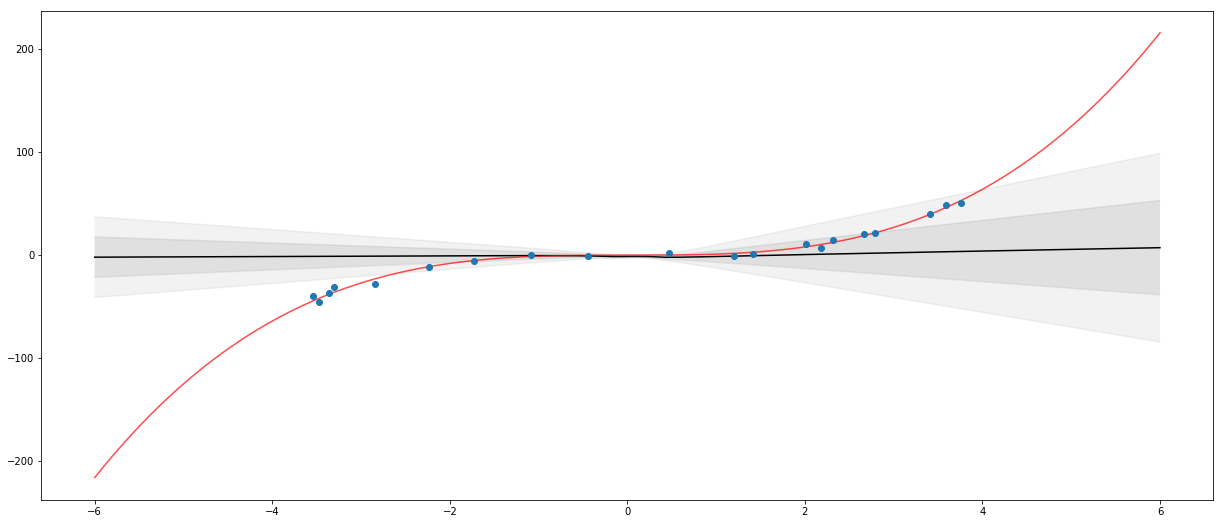

In [83]:
upper1 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) + np.std(predictions_ksgld[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) + 2 * np.std(predictions_ksgld[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) - np.std(predictions_ksgld[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) - 2 * np.std(predictions_ksgld[:,1:].detach().numpy(),1)

plt.figure(figsize=(21,9))
plt.plot(grid,np.mean(predictions_ksgld[:,1:].detach().numpy(),1), 'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.12)
plt.plot(grid,lower2,'gray',alpha=0.1)
plt.fill_between(grid.squeeze(),lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid.squeeze(),lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,grid ** 3,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')



### KSGFS

In [84]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgfs




if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

lambda_ = 1.
lr = 1e-4
alpha = 0.99


batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=True)

optim = ksgfs.optim.KSGFS(network, criterion, batch_size, dataset_size, eta=1., v=0., lambda_=1., epsilon=1e-2, l2=1e-3, invert_every=1)


predictions_ksgfs = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(20000):

    running_loss = 0
    
    optim.update_curvature(x)
    
    network.zero_grad()
    output = network(x)
    loss = criterion(output, y)
    loss.backward()
    optim.step()



    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    if (t >= 300) & (t % 100 == 0):
        with torch.autograd.no_grad():
            output = network(x_test)
            predictions_ksgfs = torch.cat((predictions_ksgfs, output), 1)

    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

Epoch 0 - loss: 736.8389
Epoch 1 - loss: 734.3026
Epoch 2 - loss: 732.3255
Epoch 3 - loss: 729.8394
Epoch 4 - loss: 726.7915
Epoch 5 - loss: 724.0930
Epoch 6 - loss: 720.3629
Epoch 7 - loss: 715.2206
Epoch 8 - loss: 710.6262
Epoch 9 - loss: 703.8185
Epoch 10 - loss: 696.0129
Epoch 11 - loss: 689.1409
Epoch 12 - loss: 680.5656
Epoch 13 - loss: 670.3927
Epoch 14 - loss: 658.3986
Epoch 15 - loss: 645.1017
Epoch 16 - loss: 632.9177
Epoch 17 - loss: 619.6254
Epoch 18 - loss: 603.7971
Epoch 19 - loss: 584.6581
Epoch 20 - loss: 570.6447
Epoch 21 - loss: 550.2335
Epoch 22 - loss: 531.0450
Epoch 23 - loss: 513.7854
Epoch 24 - loss: 494.4387
Epoch 25 - loss: 474.1764
Epoch 26 - loss: 455.6688
Epoch 27 - loss: 438.4976
Epoch 28 - loss: 416.0112
Epoch 29 - loss: 398.9689
Epoch 30 - loss: 380.4273
Epoch 31 - loss: 363.7544
Epoch 32 - loss: 348.2393
Epoch 33 - loss: 328.2936
Epoch 34 - loss: 311.4344
Epoch 35 - loss: 293.8885
Epoch 36 - loss: 280.0308
Epoch 37 - loss: 264.0960
Epoch 38 - loss: 248.2

Epoch 342 - loss: 11.1623
Epoch 343 - loss: 11.0983
Epoch 344 - loss: 11.1034
Epoch 345 - loss: 11.0487
Epoch 346 - loss: 11.0165
Epoch 347 - loss: 11.0360
Epoch 348 - loss: 11.0455
Epoch 349 - loss: 11.0244
Epoch 350 - loss: 11.0220
Epoch 351 - loss: 10.9268
Epoch 352 - loss: 10.8977
Epoch 353 - loss: 10.8589
Epoch 354 - loss: 10.8267
Epoch 355 - loss: 10.8448
Epoch 356 - loss: 10.8261
Epoch 357 - loss: 10.7799
Epoch 358 - loss: 10.7167
Epoch 359 - loss: 10.6283
Epoch 360 - loss: 10.6428
Epoch 361 - loss: 10.5791
Epoch 362 - loss: 10.5686
Epoch 363 - loss: 10.5106
Epoch 364 - loss: 10.4842
Epoch 365 - loss: 10.4510
Epoch 366 - loss: 10.3992
Epoch 367 - loss: 10.3574
Epoch 368 - loss: 10.3271
Epoch 369 - loss: 10.2812
Epoch 370 - loss: 10.3053
Epoch 371 - loss: 10.2729
Epoch 372 - loss: 10.2420
Epoch 373 - loss: 10.1814
Epoch 374 - loss: 10.1348
Epoch 375 - loss: 10.0656
Epoch 376 - loss: 9.9925
Epoch 377 - loss: 9.9750
Epoch 378 - loss: 9.9091
Epoch 379 - loss: 9.8998
Epoch 380 - loss

Epoch 671 - loss: 6.5131
Epoch 672 - loss: 6.5337
Epoch 673 - loss: 6.5321
Epoch 674 - loss: 6.5612
Epoch 675 - loss: 6.5856
Epoch 676 - loss: 6.5839
Epoch 677 - loss: 6.5659
Epoch 678 - loss: 6.5514
Epoch 679 - loss: 6.5114
Epoch 680 - loss: 6.4964
Epoch 681 - loss: 6.4989
Epoch 682 - loss: 6.4897
Epoch 683 - loss: 6.4936
Epoch 684 - loss: 6.4769
Epoch 685 - loss: 6.4562
Epoch 686 - loss: 6.4585
Epoch 687 - loss: 6.4695
Epoch 688 - loss: 6.4709
Epoch 689 - loss: 6.4721
Epoch 690 - loss: 6.4811
Epoch 691 - loss: 6.4967
Epoch 692 - loss: 6.4959
Epoch 693 - loss: 6.4734
Epoch 694 - loss: 6.4466
Epoch 695 - loss: 6.4512
Epoch 696 - loss: 6.4504
Epoch 697 - loss: 6.4467
Epoch 698 - loss: 6.4449
Epoch 699 - loss: 6.4293
Epoch 700 - loss: 6.4343
Epoch 701 - loss: 6.4147
Epoch 702 - loss: 6.4249
Epoch 703 - loss: 6.4465
Epoch 704 - loss: 6.4384
Epoch 705 - loss: 6.4713
Epoch 706 - loss: 6.4069
Epoch 707 - loss: 6.3971
Epoch 708 - loss: 6.3950
Epoch 709 - loss: 6.3847
Epoch 710 - loss: 6.3829


Epoch 1016 - loss: 5.6214
Epoch 1017 - loss: 5.5970
Epoch 1018 - loss: 5.5957
Epoch 1019 - loss: 5.5668
Epoch 1020 - loss: 5.5885
Epoch 1021 - loss: 5.5929
Epoch 1022 - loss: 5.5640
Epoch 1023 - loss: 5.5851
Epoch 1024 - loss: 5.5690
Epoch 1025 - loss: 5.5605
Epoch 1026 - loss: 5.5580
Epoch 1027 - loss: 5.5517
Epoch 1028 - loss: 5.5942
Epoch 1029 - loss: 5.5484
Epoch 1030 - loss: 5.5689
Epoch 1031 - loss: 5.5610
Epoch 1032 - loss: 5.5794
Epoch 1033 - loss: 5.5900
Epoch 1034 - loss: 5.6583
Epoch 1035 - loss: 5.6532
Epoch 1036 - loss: 5.5892
Epoch 1037 - loss: 5.5992
Epoch 1038 - loss: 5.5211
Epoch 1039 - loss: 5.5210
Epoch 1040 - loss: 5.5104
Epoch 1041 - loss: 5.5129
Epoch 1042 - loss: 5.5053
Epoch 1043 - loss: 5.5011
Epoch 1044 - loss: 5.5352
Epoch 1045 - loss: 5.5483
Epoch 1046 - loss: 5.5286
Epoch 1047 - loss: 5.5094
Epoch 1048 - loss: 5.5185
Epoch 1049 - loss: 5.5478
Epoch 1050 - loss: 5.5298
Epoch 1051 - loss: 5.5204
Epoch 1052 - loss: 5.5263
Epoch 1053 - loss: 5.5327
Epoch 1054 -

Epoch 1357 - loss: 5.1628
Epoch 1358 - loss: 5.1655
Epoch 1359 - loss: 5.1646
Epoch 1360 - loss: 5.1791
Epoch 1361 - loss: 5.1678
Epoch 1362 - loss: 5.1688
Epoch 1363 - loss: 5.2035
Epoch 1364 - loss: 5.2154
Epoch 1365 - loss: 5.2202
Epoch 1366 - loss: 5.1827
Epoch 1367 - loss: 5.1827
Epoch 1368 - loss: 5.1709
Epoch 1369 - loss: 5.1859
Epoch 1370 - loss: 5.2307
Epoch 1371 - loss: 5.2111
Epoch 1372 - loss: 5.2258
Epoch 1373 - loss: 5.2583
Epoch 1374 - loss: 5.2858
Epoch 1375 - loss: 5.2487
Epoch 1376 - loss: 5.2787
Epoch 1377 - loss: 5.2827
Epoch 1378 - loss: 5.2760
Epoch 1379 - loss: 5.2499
Epoch 1380 - loss: 5.2511
Epoch 1381 - loss: 5.2145
Epoch 1382 - loss: 5.2150
Epoch 1383 - loss: 5.2447
Epoch 1384 - loss: 5.2317
Epoch 1385 - loss: 5.2270
Epoch 1386 - loss: 5.2089
Epoch 1387 - loss: 5.2071
Epoch 1388 - loss: 5.2768
Epoch 1389 - loss: 5.2380
Epoch 1390 - loss: 5.2152
Epoch 1391 - loss: 5.2244
Epoch 1392 - loss: 5.2484
Epoch 1393 - loss: 5.2343
Epoch 1394 - loss: 5.1750
Epoch 1395 -

Epoch 1700 - loss: 5.1163
Epoch 1701 - loss: 5.1379
Epoch 1702 - loss: 5.1013
Epoch 1703 - loss: 5.0919
Epoch 1704 - loss: 5.0599
Epoch 1705 - loss: 5.0684
Epoch 1706 - loss: 5.0460
Epoch 1707 - loss: 5.0929
Epoch 1708 - loss: 5.0965
Epoch 1709 - loss: 5.0819
Epoch 1710 - loss: 5.1064
Epoch 1711 - loss: 5.1091
Epoch 1712 - loss: 5.0889
Epoch 1713 - loss: 5.1035
Epoch 1714 - loss: 5.1193
Epoch 1715 - loss: 5.1346
Epoch 1716 - loss: 5.1867
Epoch 1717 - loss: 5.1505
Epoch 1718 - loss: 5.1621
Epoch 1719 - loss: 5.1699
Epoch 1720 - loss: 5.0946
Epoch 1721 - loss: 5.0838
Epoch 1722 - loss: 5.1040
Epoch 1723 - loss: 5.1059
Epoch 1724 - loss: 5.0942
Epoch 1725 - loss: 5.0458
Epoch 1726 - loss: 5.0254
Epoch 1727 - loss: 5.0239
Epoch 1728 - loss: 5.0340
Epoch 1729 - loss: 5.0563
Epoch 1730 - loss: 5.0495
Epoch 1731 - loss: 5.0845
Epoch 1732 - loss: 5.0324
Epoch 1733 - loss: 5.0092
Epoch 1734 - loss: 5.0329
Epoch 1735 - loss: 5.0634
Epoch 1736 - loss: 5.0768
Epoch 1737 - loss: 5.0310
Epoch 1738 -

Epoch 2026 - loss: 4.8536
Epoch 2027 - loss: 4.8509
Epoch 2028 - loss: 4.8506
Epoch 2029 - loss: 4.8520
Epoch 2030 - loss: 4.8485
Epoch 2031 - loss: 4.8559
Epoch 2032 - loss: 4.8436
Epoch 2033 - loss: 4.8464
Epoch 2034 - loss: 4.8527
Epoch 2035 - loss: 4.8514
Epoch 2036 - loss: 4.8470
Epoch 2037 - loss: 4.8524
Epoch 2038 - loss: 4.8471
Epoch 2039 - loss: 4.8624
Epoch 2040 - loss: 4.8690
Epoch 2041 - loss: 4.8675
Epoch 2042 - loss: 4.8634
Epoch 2043 - loss: 4.8755
Epoch 2044 - loss: 4.8819
Epoch 2045 - loss: 4.8861
Epoch 2046 - loss: 4.8652
Epoch 2047 - loss: 4.8771
Epoch 2048 - loss: 4.8767
Epoch 2049 - loss: 4.8930
Epoch 2050 - loss: 4.9556
Epoch 2051 - loss: 4.9258
Epoch 2052 - loss: 4.9219
Epoch 2053 - loss: 4.9402
Epoch 2054 - loss: 4.8940
Epoch 2055 - loss: 4.9404
Epoch 2056 - loss: 4.9244
Epoch 2057 - loss: 4.9589
Epoch 2058 - loss: 4.8957
Epoch 2059 - loss: 4.8726
Epoch 2060 - loss: 4.8484
Epoch 2061 - loss: 4.8477
Epoch 2062 - loss: 4.8559
Epoch 2063 - loss: 4.8621
Epoch 2064 -

Epoch 2388 - loss: 4.7642
Epoch 2389 - loss: 4.7792
Epoch 2390 - loss: 4.8447
Epoch 2391 - loss: 4.8051
Epoch 2392 - loss: 4.8162
Epoch 2393 - loss: 4.8147
Epoch 2394 - loss: 4.8209
Epoch 2395 - loss: 4.8339
Epoch 2396 - loss: 4.8086
Epoch 2397 - loss: 4.8417
Epoch 2398 - loss: 4.8590
Epoch 2399 - loss: 4.8558
Epoch 2400 - loss: 4.8079
Epoch 2401 - loss: 4.7799
Epoch 2402 - loss: 4.7967
Epoch 2403 - loss: 4.8047
Epoch 2404 - loss: 4.8926
Epoch 2405 - loss: 4.8760
Epoch 2406 - loss: 4.8837
Epoch 2407 - loss: 4.8931
Epoch 2408 - loss: 4.8528
Epoch 2409 - loss: 4.8067
Epoch 2410 - loss: 4.7920
Epoch 2411 - loss: 4.7782
Epoch 2412 - loss: 4.7728
Epoch 2413 - loss: 4.7789
Epoch 2414 - loss: 4.7734
Epoch 2415 - loss: 4.7946
Epoch 2416 - loss: 4.8098
Epoch 2417 - loss: 4.7746
Epoch 2418 - loss: 4.7660
Epoch 2419 - loss: 4.7767
Epoch 2420 - loss: 4.7966
Epoch 2421 - loss: 4.7873
Epoch 2422 - loss: 4.7927
Epoch 2423 - loss: 4.7844
Epoch 2424 - loss: 4.7815
Epoch 2425 - loss: 4.8252
Epoch 2426 -

Epoch 2736 - loss: 4.6746
Epoch 2737 - loss: 4.6524
Epoch 2738 - loss: 4.6507
Epoch 2739 - loss: 4.6583
Epoch 2740 - loss: 4.6825
Epoch 2741 - loss: 4.6734
Epoch 2742 - loss: 4.6801
Epoch 2743 - loss: 4.6676
Epoch 2744 - loss: 4.6713
Epoch 2745 - loss: 4.6791
Epoch 2746 - loss: 4.6931
Epoch 2747 - loss: 4.7269
Epoch 2748 - loss: 4.7280
Epoch 2749 - loss: 4.7311
Epoch 2750 - loss: 4.7645
Epoch 2751 - loss: 4.7524
Epoch 2752 - loss: 4.7677
Epoch 2753 - loss: 4.7461
Epoch 2754 - loss: 4.7072
Epoch 2755 - loss: 4.6882
Epoch 2756 - loss: 4.6917
Epoch 2757 - loss: 4.6943
Epoch 2758 - loss: 4.7332
Epoch 2759 - loss: 4.7248
Epoch 2760 - loss: 4.7100
Epoch 2761 - loss: 4.7090
Epoch 2762 - loss: 4.7334
Epoch 2763 - loss: 4.7226
Epoch 2764 - loss: 4.7714
Epoch 2765 - loss: 4.7525
Epoch 2766 - loss: 4.7199
Epoch 2767 - loss: 4.7009
Epoch 2768 - loss: 4.6857
Epoch 2769 - loss: 4.6882
Epoch 2770 - loss: 4.6834
Epoch 2771 - loss: 4.6866
Epoch 2772 - loss: 4.6880
Epoch 2773 - loss: 4.6736
Epoch 2774 -

Epoch 3090 - loss: 4.6331
Epoch 3091 - loss: 4.6352
Epoch 3092 - loss: 4.6627
Epoch 3093 - loss: 4.6561
Epoch 3094 - loss: 4.6541
Epoch 3095 - loss: 4.6528
Epoch 3096 - loss: 4.6448
Epoch 3097 - loss: 4.6520
Epoch 3098 - loss: 4.6607
Epoch 3099 - loss: 4.6302
Epoch 3100 - loss: 4.6101
Epoch 3101 - loss: 4.6096
Epoch 3102 - loss: 4.6075
Epoch 3103 - loss: 4.6043
Epoch 3104 - loss: 4.6120
Epoch 3105 - loss: 4.6051
Epoch 3106 - loss: 4.6097
Epoch 3107 - loss: 4.6014
Epoch 3108 - loss: 4.6150
Epoch 3109 - loss: 4.6089
Epoch 3110 - loss: 4.6090
Epoch 3111 - loss: 4.6159
Epoch 3112 - loss: 4.6083
Epoch 3113 - loss: 4.6203
Epoch 3114 - loss: 4.6088
Epoch 3115 - loss: 4.6141
Epoch 3116 - loss: 4.6164
Epoch 3117 - loss: 4.6007
Epoch 3118 - loss: 4.6074
Epoch 3119 - loss: 4.6018
Epoch 3120 - loss: 4.6026
Epoch 3121 - loss: 4.6016
Epoch 3122 - loss: 4.6047
Epoch 3123 - loss: 4.6148
Epoch 3124 - loss: 4.6235
Epoch 3125 - loss: 4.6353
Epoch 3126 - loss: 4.6377
Epoch 3127 - loss: 4.6440
Epoch 3128 -

Epoch 3438 - loss: 4.6432
Epoch 3439 - loss: 4.6299
Epoch 3440 - loss: 4.6204
Epoch 3441 - loss: 4.6464
Epoch 3442 - loss: 4.6567
Epoch 3443 - loss: 4.6776
Epoch 3444 - loss: 4.6879
Epoch 3445 - loss: 4.6544
Epoch 3446 - loss: 4.6476
Epoch 3447 - loss: 4.6328
Epoch 3448 - loss: 4.6214
Epoch 3449 - loss: 4.5921
Epoch 3450 - loss: 4.5907
Epoch 3451 - loss: 4.6025
Epoch 3452 - loss: 4.5988
Epoch 3453 - loss: 4.6139
Epoch 3454 - loss: 4.6000
Epoch 3455 - loss: 4.5967
Epoch 3456 - loss: 4.6019
Epoch 3457 - loss: 4.5890
Epoch 3458 - loss: 4.5780
Epoch 3459 - loss: 4.5778
Epoch 3460 - loss: 4.5732
Epoch 3461 - loss: 4.5933
Epoch 3462 - loss: 4.6012
Epoch 3463 - loss: 4.6334
Epoch 3464 - loss: 4.6194
Epoch 3465 - loss: 4.6180
Epoch 3466 - loss: 4.5950
Epoch 3467 - loss: 4.5948
Epoch 3468 - loss: 4.5998
Epoch 3469 - loss: 4.5996
Epoch 3470 - loss: 4.6059
Epoch 3471 - loss: 4.6121
Epoch 3472 - loss: 4.6120
Epoch 3473 - loss: 4.6182
Epoch 3474 - loss: 4.6335
Epoch 3475 - loss: 4.6306
Epoch 3476 -

Epoch 3791 - loss: 4.5931
Epoch 3792 - loss: 4.6078
Epoch 3793 - loss: 4.5911
Epoch 3794 - loss: 4.6527
Epoch 3795 - loss: 4.6367
Epoch 3796 - loss: 4.6383
Epoch 3797 - loss: 4.6204
Epoch 3798 - loss: 4.6006
Epoch 3799 - loss: 4.5772
Epoch 3800 - loss: 4.5760
Epoch 3801 - loss: 4.5700
Epoch 3802 - loss: 4.6171
Epoch 3803 - loss: 4.6513
Epoch 3804 - loss: 4.6072
Epoch 3805 - loss: 4.5550
Epoch 3806 - loss: 4.5318
Epoch 3807 - loss: 4.5240
Epoch 3808 - loss: 4.5311
Epoch 3809 - loss: 4.5271
Epoch 3810 - loss: 4.5252
Epoch 3811 - loss: 4.5397
Epoch 3812 - loss: 4.5489
Epoch 3813 - loss: 4.5539
Epoch 3814 - loss: 4.5659
Epoch 3815 - loss: 4.5440
Epoch 3816 - loss: 4.5387
Epoch 3817 - loss: 4.5256
Epoch 3818 - loss: 4.5353
Epoch 3819 - loss: 4.5235
Epoch 3820 - loss: 4.5303
Epoch 3821 - loss: 4.5322
Epoch 3822 - loss: 4.5469
Epoch 3823 - loss: 4.5503
Epoch 3824 - loss: 4.5293
Epoch 3825 - loss: 4.5358
Epoch 3826 - loss: 4.5412
Epoch 3827 - loss: 4.5115
Epoch 3828 - loss: 4.5210
Epoch 3829 -

Epoch 4147 - loss: 4.4713
Epoch 4148 - loss: 4.4823
Epoch 4149 - loss: 4.5051
Epoch 4150 - loss: 4.4980
Epoch 4151 - loss: 4.4992
Epoch 4152 - loss: 4.4924
Epoch 4153 - loss: 4.4677
Epoch 4154 - loss: 4.4914
Epoch 4155 - loss: 4.5663
Epoch 4156 - loss: 4.5653
Epoch 4157 - loss: 4.5029
Epoch 4158 - loss: 4.5254
Epoch 4159 - loss: 4.5277
Epoch 4160 - loss: 4.5174
Epoch 4161 - loss: 4.5240
Epoch 4162 - loss: 4.5317
Epoch 4163 - loss: 4.5247
Epoch 4164 - loss: 4.4922
Epoch 4165 - loss: 4.5007
Epoch 4166 - loss: 4.5121
Epoch 4167 - loss: 4.4977
Epoch 4168 - loss: 4.5613
Epoch 4169 - loss: 4.5480
Epoch 4170 - loss: 4.5365
Epoch 4171 - loss: 4.5150
Epoch 4172 - loss: 4.5424
Epoch 4173 - loss: 4.5563
Epoch 4174 - loss: 4.5389
Epoch 4175 - loss: 4.5435
Epoch 4176 - loss: 4.5442
Epoch 4177 - loss: 4.5354
Epoch 4178 - loss: 4.4914
Epoch 4179 - loss: 4.4956
Epoch 4180 - loss: 4.4830
Epoch 4181 - loss: 4.4768
Epoch 4182 - loss: 4.5150
Epoch 4183 - loss: 4.4930
Epoch 4184 - loss: 4.5061
Epoch 4185 -

Epoch 4487 - loss: 4.4001
Epoch 4488 - loss: 4.3978
Epoch 4489 - loss: 4.3848
Epoch 4490 - loss: 4.4025
Epoch 4491 - loss: 4.3870
Epoch 4492 - loss: 4.4029
Epoch 4493 - loss: 4.4422
Epoch 4494 - loss: 4.4147
Epoch 4495 - loss: 4.4050
Epoch 4496 - loss: 4.4087
Epoch 4497 - loss: 4.4130
Epoch 4498 - loss: 4.4119
Epoch 4499 - loss: 4.4250
Epoch 4500 - loss: 4.4366
Epoch 4501 - loss: 4.4349
Epoch 4502 - loss: 4.4188
Epoch 4503 - loss: 4.4179
Epoch 4504 - loss: 4.4062
Epoch 4505 - loss: 4.4292
Epoch 4506 - loss: 4.4085
Epoch 4507 - loss: 4.4178
Epoch 4508 - loss: 4.4045
Epoch 4509 - loss: 4.3924
Epoch 4510 - loss: 4.4041
Epoch 4511 - loss: 4.4335
Epoch 4512 - loss: 4.4250
Epoch 4513 - loss: 4.4270
Epoch 4514 - loss: 4.3959
Epoch 4515 - loss: 4.3915
Epoch 4516 - loss: 4.3917
Epoch 4517 - loss: 4.3937
Epoch 4518 - loss: 4.3958
Epoch 4519 - loss: 4.3918
Epoch 4520 - loss: 4.3928
Epoch 4521 - loss: 4.4200
Epoch 4522 - loss: 4.4273
Epoch 4523 - loss: 4.4306
Epoch 4524 - loss: 4.4398
Epoch 4525 -

Epoch 4822 - loss: 4.3951
Epoch 4823 - loss: 4.3814
Epoch 4824 - loss: 4.3806
Epoch 4825 - loss: 4.3880
Epoch 4826 - loss: 4.3910
Epoch 4827 - loss: 4.3695
Epoch 4828 - loss: 4.3708
Epoch 4829 - loss: 4.3810
Epoch 4830 - loss: 4.3903
Epoch 4831 - loss: 4.3831
Epoch 4832 - loss: 4.3873
Epoch 4833 - loss: 4.3787
Epoch 4834 - loss: 4.4023
Epoch 4835 - loss: 4.3990
Epoch 4836 - loss: 4.4100
Epoch 4837 - loss: 4.3988
Epoch 4838 - loss: 4.3737
Epoch 4839 - loss: 4.3846
Epoch 4840 - loss: 4.3967
Epoch 4841 - loss: 4.4012
Epoch 4842 - loss: 4.3862
Epoch 4843 - loss: 4.3815
Epoch 4844 - loss: 4.3759
Epoch 4845 - loss: 4.3796
Epoch 4846 - loss: 4.3771
Epoch 4847 - loss: 4.3881
Epoch 4848 - loss: 4.4090
Epoch 4849 - loss: 4.4017
Epoch 4850 - loss: 4.3829
Epoch 4851 - loss: 4.3835
Epoch 4852 - loss: 4.4258
Epoch 4853 - loss: 4.5083
Epoch 4854 - loss: 4.4843
Epoch 4855 - loss: 4.5442
Epoch 4856 - loss: 4.5021
Epoch 4857 - loss: 4.5300
Epoch 4858 - loss: 4.4943
Epoch 4859 - loss: 4.4708
Epoch 4860 -

Epoch 5160 - loss: 4.3711
Epoch 5161 - loss: 4.3885
Epoch 5162 - loss: 4.3915
Epoch 5163 - loss: 4.3986
Epoch 5164 - loss: 4.3960
Epoch 5165 - loss: 4.3887
Epoch 5166 - loss: 4.3861
Epoch 5167 - loss: 4.3779
Epoch 5168 - loss: 4.3711
Epoch 5169 - loss: 4.3931
Epoch 5170 - loss: 4.3874
Epoch 5171 - loss: 4.4114
Epoch 5172 - loss: 4.4099
Epoch 5173 - loss: 4.3927
Epoch 5174 - loss: 4.3752
Epoch 5175 - loss: 4.3789
Epoch 5176 - loss: 4.3648
Epoch 5177 - loss: 4.3749
Epoch 5178 - loss: 4.3906
Epoch 5179 - loss: 4.3772
Epoch 5180 - loss: 4.3781
Epoch 5181 - loss: 4.3747
Epoch 5182 - loss: 4.3899
Epoch 5183 - loss: 4.3796
Epoch 5184 - loss: 4.4015
Epoch 5185 - loss: 4.3872
Epoch 5186 - loss: 4.3809
Epoch 5187 - loss: 4.3771
Epoch 5188 - loss: 4.4252
Epoch 5189 - loss: 4.4137
Epoch 5190 - loss: 4.4046
Epoch 5191 - loss: 4.4171
Epoch 5192 - loss: 4.4327
Epoch 5193 - loss: 4.3725
Epoch 5194 - loss: 4.3677
Epoch 5195 - loss: 4.3916
Epoch 5196 - loss: 4.3848
Epoch 5197 - loss: 4.3989
Epoch 5198 -

Epoch 5482 - loss: 4.4458
Epoch 5483 - loss: 4.4200
Epoch 5484 - loss: 4.4230
Epoch 5485 - loss: 4.4019
Epoch 5486 - loss: 4.4100
Epoch 5487 - loss: 4.4113
Epoch 5488 - loss: 4.4402
Epoch 5489 - loss: 4.5117
Epoch 5490 - loss: 4.4963
Epoch 5491 - loss: 4.4312
Epoch 5492 - loss: 4.4024
Epoch 5493 - loss: 4.4482
Epoch 5494 - loss: 4.4313
Epoch 5495 - loss: 4.4300
Epoch 5496 - loss: 4.4063
Epoch 5497 - loss: 4.4554
Epoch 5498 - loss: 4.4912
Epoch 5499 - loss: 4.5006
Epoch 5500 - loss: 4.5344
Epoch 5501 - loss: 4.6122
Epoch 5502 - loss: 4.4848
Epoch 5503 - loss: 4.4874
Epoch 5504 - loss: 4.4734
Epoch 5505 - loss: 4.4736
Epoch 5506 - loss: 4.4795
Epoch 5507 - loss: 4.4413
Epoch 5508 - loss: 4.4528
Epoch 5509 - loss: 4.4641
Epoch 5510 - loss: 4.5285
Epoch 5511 - loss: 4.4692
Epoch 5512 - loss: 4.4478
Epoch 5513 - loss: 4.4601
Epoch 5514 - loss: 4.4573
Epoch 5515 - loss: 4.4685
Epoch 5516 - loss: 4.4895
Epoch 5517 - loss: 4.4638
Epoch 5518 - loss: 4.4843
Epoch 5519 - loss: 4.4593
Epoch 5520 -

Epoch 5817 - loss: 4.4283
Epoch 5818 - loss: 4.3994
Epoch 5819 - loss: 4.4334
Epoch 5820 - loss: 4.4519
Epoch 5821 - loss: 4.4675
Epoch 5822 - loss: 4.4428
Epoch 5823 - loss: 4.4369
Epoch 5824 - loss: 4.4390
Epoch 5825 - loss: 4.4133
Epoch 5826 - loss: 4.4142
Epoch 5827 - loss: 4.3643
Epoch 5828 - loss: 4.4013
Epoch 5829 - loss: 4.3800
Epoch 5830 - loss: 4.3749
Epoch 5831 - loss: 4.4319
Epoch 5832 - loss: 4.4233
Epoch 5833 - loss: 4.4762
Epoch 5834 - loss: 4.4671
Epoch 5835 - loss: 4.4898
Epoch 5836 - loss: 4.4685
Epoch 5837 - loss: 4.4696
Epoch 5838 - loss: 4.4242
Epoch 5839 - loss: 4.4081
Epoch 5840 - loss: 4.3888
Epoch 5841 - loss: 4.3778
Epoch 5842 - loss: 4.4052
Epoch 5843 - loss: 4.4708
Epoch 5844 - loss: 4.4299
Epoch 5845 - loss: 4.4313
Epoch 5846 - loss: 4.4189
Epoch 5847 - loss: 4.3972
Epoch 5848 - loss: 4.3903
Epoch 5849 - loss: 4.4079
Epoch 5850 - loss: 4.4401
Epoch 5851 - loss: 4.4758
Epoch 5852 - loss: 4.4439
Epoch 5853 - loss: 4.3994
Epoch 5854 - loss: 4.4453
Epoch 5855 -

Epoch 6153 - loss: 4.4808
Epoch 6154 - loss: 4.4933
Epoch 6155 - loss: 4.4711
Epoch 6156 - loss: 4.4688
Epoch 6157 - loss: 4.4155
Epoch 6158 - loss: 4.4165
Epoch 6159 - loss: 4.3922
Epoch 6160 - loss: 4.3825
Epoch 6161 - loss: 4.3793
Epoch 6162 - loss: 4.3814
Epoch 6163 - loss: 4.3798
Epoch 6164 - loss: 4.3732
Epoch 6165 - loss: 4.3741
Epoch 6166 - loss: 4.3961
Epoch 6167 - loss: 4.4014
Epoch 6168 - loss: 4.3989
Epoch 6169 - loss: 4.3956
Epoch 6170 - loss: 4.4457
Epoch 6171 - loss: 4.4144
Epoch 6172 - loss: 4.4021
Epoch 6173 - loss: 4.4135
Epoch 6174 - loss: 4.4311
Epoch 6175 - loss: 4.3960
Epoch 6176 - loss: 4.3914
Epoch 6177 - loss: 4.3993
Epoch 6178 - loss: 4.3812
Epoch 6179 - loss: 4.3920
Epoch 6180 - loss: 4.4049
Epoch 6181 - loss: 4.4098
Epoch 6182 - loss: 4.4328
Epoch 6183 - loss: 4.4186
Epoch 6184 - loss: 4.4544
Epoch 6185 - loss: 4.4676
Epoch 6186 - loss: 4.4850
Epoch 6187 - loss: 4.4338
Epoch 6188 - loss: 4.4392
Epoch 6189 - loss: 4.4469
Epoch 6190 - loss: 4.4173
Epoch 6191 -

Epoch 6499 - loss: 4.4499
Epoch 6500 - loss: 4.4466
Epoch 6501 - loss: 4.4444
Epoch 6502 - loss: 4.4553
Epoch 6503 - loss: 4.4538
Epoch 6504 - loss: 4.4710
Epoch 6505 - loss: 4.4652
Epoch 6506 - loss: 4.4684
Epoch 6507 - loss: 4.4545
Epoch 6508 - loss: 4.5010
Epoch 6509 - loss: 4.4669
Epoch 6510 - loss: 4.4305
Epoch 6511 - loss: 4.4849
Epoch 6512 - loss: 4.4386
Epoch 6513 - loss: 4.4350
Epoch 6514 - loss: 4.4370
Epoch 6515 - loss: 4.4290
Epoch 6516 - loss: 4.4366
Epoch 6517 - loss: 4.4909
Epoch 6518 - loss: 4.4889
Epoch 6519 - loss: 4.4663
Epoch 6520 - loss: 4.3982
Epoch 6521 - loss: 4.3970
Epoch 6522 - loss: 4.4124
Epoch 6523 - loss: 4.3867
Epoch 6524 - loss: 4.3828
Epoch 6525 - loss: 4.3783
Epoch 6526 - loss: 4.3869
Epoch 6527 - loss: 4.3856
Epoch 6528 - loss: 4.3959
Epoch 6529 - loss: 4.4507
Epoch 6530 - loss: 4.4132
Epoch 6531 - loss: 4.4313
Epoch 6532 - loss: 4.4530
Epoch 6533 - loss: 4.4200
Epoch 6534 - loss: 4.4059
Epoch 6535 - loss: 4.4280
Epoch 6536 - loss: 4.4679
Epoch 6537 -

Epoch 6846 - loss: 4.4144
Epoch 6847 - loss: 4.4439
Epoch 6848 - loss: 4.4365
Epoch 6849 - loss: 4.4446
Epoch 6850 - loss: 4.4250
Epoch 6851 - loss: 4.4379
Epoch 6852 - loss: 4.4436
Epoch 6853 - loss: 4.4298
Epoch 6854 - loss: 4.4299
Epoch 6855 - loss: 4.4456
Epoch 6856 - loss: 4.4321
Epoch 6857 - loss: 4.4355
Epoch 6858 - loss: 4.4279
Epoch 6859 - loss: 4.4184
Epoch 6860 - loss: 4.4253
Epoch 6861 - loss: 4.4404
Epoch 6862 - loss: 4.4434
Epoch 6863 - loss: 4.4452
Epoch 6864 - loss: 4.4211
Epoch 6865 - loss: 4.4130
Epoch 6866 - loss: 4.4004
Epoch 6867 - loss: 4.3997
Epoch 6868 - loss: 4.3835
Epoch 6869 - loss: 4.4149
Epoch 6870 - loss: 4.4154
Epoch 6871 - loss: 4.3997
Epoch 6872 - loss: 4.4055
Epoch 6873 - loss: 4.4022
Epoch 6874 - loss: 4.4187
Epoch 6875 - loss: 4.4103
Epoch 6876 - loss: 4.4043
Epoch 6877 - loss: 4.4380
Epoch 6878 - loss: 4.4639
Epoch 6879 - loss: 4.4774
Epoch 6880 - loss: 4.4490
Epoch 6881 - loss: 4.4432
Epoch 6882 - loss: 4.4216
Epoch 6883 - loss: 4.3934
Epoch 6884 -

Epoch 7193 - loss: 4.3926
Epoch 7194 - loss: 4.3824
Epoch 7195 - loss: 4.3818
Epoch 7196 - loss: 4.3908
Epoch 7197 - loss: 4.3779
Epoch 7198 - loss: 4.3759
Epoch 7199 - loss: 4.3757
Epoch 7200 - loss: 4.3747
Epoch 7201 - loss: 4.3784
Epoch 7202 - loss: 4.3561
Epoch 7203 - loss: 4.3607
Epoch 7204 - loss: 4.3603
Epoch 7205 - loss: 4.3812
Epoch 7206 - loss: 4.3864
Epoch 7207 - loss: 4.3627
Epoch 7208 - loss: 4.3616
Epoch 7209 - loss: 4.3612
Epoch 7210 - loss: 4.3646
Epoch 7211 - loss: 4.3716
Epoch 7212 - loss: 4.3663
Epoch 7213 - loss: 4.3513
Epoch 7214 - loss: 4.3768
Epoch 7215 - loss: 4.3699
Epoch 7216 - loss: 4.3628
Epoch 7217 - loss: 4.3805
Epoch 7218 - loss: 4.3821
Epoch 7219 - loss: 4.3747
Epoch 7220 - loss: 4.3522
Epoch 7221 - loss: 4.3709
Epoch 7222 - loss: 4.3754
Epoch 7223 - loss: 4.3583
Epoch 7224 - loss: 4.3658
Epoch 7225 - loss: 4.3831
Epoch 7226 - loss: 4.3747
Epoch 7227 - loss: 4.3761
Epoch 7228 - loss: 4.3877
Epoch 7229 - loss: 4.3896
Epoch 7230 - loss: 4.3944
Epoch 7231 -

Epoch 7517 - loss: 4.3585
Epoch 7518 - loss: 4.3804
Epoch 7519 - loss: 4.3915
Epoch 7520 - loss: 4.3932
Epoch 7521 - loss: 4.3995
Epoch 7522 - loss: 4.4205
Epoch 7523 - loss: 4.4032
Epoch 7524 - loss: 4.3508
Epoch 7525 - loss: 4.3494
Epoch 7526 - loss: 4.3430
Epoch 7527 - loss: 4.3517
Epoch 7528 - loss: 4.3513
Epoch 7529 - loss: 4.3539
Epoch 7530 - loss: 4.3727
Epoch 7531 - loss: 4.3608
Epoch 7532 - loss: 4.3783
Epoch 7533 - loss: 4.3834
Epoch 7534 - loss: 4.4168
Epoch 7535 - loss: 4.3564
Epoch 7536 - loss: 4.3565
Epoch 7537 - loss: 4.3513
Epoch 7538 - loss: 4.3664
Epoch 7539 - loss: 4.3663
Epoch 7540 - loss: 4.3622
Epoch 7541 - loss: 4.3770
Epoch 7542 - loss: 4.3722
Epoch 7543 - loss: 4.3594
Epoch 7544 - loss: 4.3583
Epoch 7545 - loss: 4.3562
Epoch 7546 - loss: 4.3503
Epoch 7547 - loss: 4.3742
Epoch 7548 - loss: 4.3733
Epoch 7549 - loss: 4.3890
Epoch 7550 - loss: 4.3611
Epoch 7551 - loss: 4.3620
Epoch 7552 - loss: 4.3653
Epoch 7553 - loss: 4.3563
Epoch 7554 - loss: 4.3482
Epoch 7555 -

Epoch 7834 - loss: 4.3201
Epoch 7835 - loss: 4.3196
Epoch 7836 - loss: 4.3172
Epoch 7837 - loss: 4.3167
Epoch 7838 - loss: 4.3527
Epoch 7839 - loss: 4.3506
Epoch 7840 - loss: 4.3462
Epoch 7841 - loss: 4.3672
Epoch 7842 - loss: 4.3839
Epoch 7843 - loss: 4.3654
Epoch 7844 - loss: 4.3831
Epoch 7845 - loss: 4.3652
Epoch 7846 - loss: 4.4133
Epoch 7847 - loss: 4.3742
Epoch 7848 - loss: 4.3489
Epoch 7849 - loss: 4.3574
Epoch 7850 - loss: 4.3407
Epoch 7851 - loss: 4.3303
Epoch 7852 - loss: 4.3540
Epoch 7853 - loss: 4.3990
Epoch 7854 - loss: 4.4733
Epoch 7855 - loss: 4.4710
Epoch 7856 - loss: 4.5146
Epoch 7857 - loss: 4.4784
Epoch 7858 - loss: 4.4165
Epoch 7859 - loss: 4.3704
Epoch 7860 - loss: 4.3888
Epoch 7861 - loss: 4.3650
Epoch 7862 - loss: 4.3634
Epoch 7863 - loss: 4.3645
Epoch 7864 - loss: 4.3662
Epoch 7865 - loss: 4.3389
Epoch 7866 - loss: 4.3234
Epoch 7867 - loss: 4.3206
Epoch 7868 - loss: 4.3274
Epoch 7869 - loss: 4.3259
Epoch 7870 - loss: 4.3276
Epoch 7871 - loss: 4.3420
Epoch 7872 -

Epoch 8163 - loss: 4.4713
Epoch 8164 - loss: 4.5605
Epoch 8165 - loss: 4.5773
Epoch 8166 - loss: 4.4624
Epoch 8167 - loss: 4.4208
Epoch 8168 - loss: 4.4221
Epoch 8169 - loss: 4.3958
Epoch 8170 - loss: 4.3641
Epoch 8171 - loss: 4.3454
Epoch 8172 - loss: 4.3389
Epoch 8173 - loss: 4.3430
Epoch 8174 - loss: 4.3418
Epoch 8175 - loss: 4.3246
Epoch 8176 - loss: 4.3270
Epoch 8177 - loss: 4.3366
Epoch 8178 - loss: 4.3638
Epoch 8179 - loss: 4.3678
Epoch 8180 - loss: 4.3772
Epoch 8181 - loss: 4.3718
Epoch 8182 - loss: 4.4385
Epoch 8183 - loss: 4.3772
Epoch 8184 - loss: 4.3135
Epoch 8185 - loss: 4.3156
Epoch 8186 - loss: 4.3200
Epoch 8187 - loss: 4.3384
Epoch 8188 - loss: 4.3425
Epoch 8189 - loss: 4.3633
Epoch 8190 - loss: 4.3206
Epoch 8191 - loss: 4.3269
Epoch 8192 - loss: 4.3342
Epoch 8193 - loss: 4.3490
Epoch 8194 - loss: 4.3523
Epoch 8195 - loss: 4.3539
Epoch 8196 - loss: 4.3112
Epoch 8197 - loss: 4.2872
Epoch 8198 - loss: 4.3272
Epoch 8199 - loss: 4.3085
Epoch 8200 - loss: 4.2908
Epoch 8201 -

Epoch 8479 - loss: 4.3574
Epoch 8480 - loss: 4.3788
Epoch 8481 - loss: 4.3765
Epoch 8482 - loss: 4.3853
Epoch 8483 - loss: 4.3671
Epoch 8484 - loss: 4.3986
Epoch 8485 - loss: 4.3891
Epoch 8486 - loss: 4.3602
Epoch 8487 - loss: 4.3326
Epoch 8488 - loss: 4.3208
Epoch 8489 - loss: 4.3298
Epoch 8490 - loss: 4.3494
Epoch 8491 - loss: 4.3363
Epoch 8492 - loss: 4.3697
Epoch 8493 - loss: 4.3853
Epoch 8494 - loss: 4.3623
Epoch 8495 - loss: 4.3931
Epoch 8496 - loss: 4.3558
Epoch 8497 - loss: 4.3818
Epoch 8498 - loss: 4.3371
Epoch 8499 - loss: 4.3212
Epoch 8500 - loss: 4.3309
Epoch 8501 - loss: 4.3321
Epoch 8502 - loss: 4.3306
Epoch 8503 - loss: 4.3107
Epoch 8504 - loss: 4.3048
Epoch 8505 - loss: 4.3334
Epoch 8506 - loss: 4.3245
Epoch 8507 - loss: 4.3299
Epoch 8508 - loss: 4.3416
Epoch 8509 - loss: 4.3402
Epoch 8510 - loss: 4.3542
Epoch 8511 - loss: 4.3817
Epoch 8512 - loss: 4.3349
Epoch 8513 - loss: 4.3240
Epoch 8514 - loss: 4.3394
Epoch 8515 - loss: 4.3285
Epoch 8516 - loss: 4.3794
Epoch 8517 -

Epoch 8799 - loss: 4.3257
Epoch 8800 - loss: 4.3271
Epoch 8801 - loss: 4.3591
Epoch 8802 - loss: 4.3697
Epoch 8803 - loss: 4.3558
Epoch 8804 - loss: 4.3507
Epoch 8805 - loss: 4.3936
Epoch 8806 - loss: 4.4084
Epoch 8807 - loss: 4.4028
Epoch 8808 - loss: 4.4143
Epoch 8809 - loss: 4.4148
Epoch 8810 - loss: 4.3914
Epoch 8811 - loss: 4.4342
Epoch 8812 - loss: 4.4328
Epoch 8813 - loss: 4.4767
Epoch 8814 - loss: 4.4996
Epoch 8815 - loss: 4.4406
Epoch 8816 - loss: 4.4326
Epoch 8817 - loss: 4.4194
Epoch 8818 - loss: 4.4361
Epoch 8819 - loss: 4.4571
Epoch 8820 - loss: 4.4463
Epoch 8821 - loss: 4.4225
Epoch 8822 - loss: 4.4041
Epoch 8823 - loss: 4.3782
Epoch 8824 - loss: 4.4003
Epoch 8825 - loss: 4.3992
Epoch 8826 - loss: 4.4393
Epoch 8827 - loss: 4.4366
Epoch 8828 - loss: 4.4082
Epoch 8829 - loss: 4.3782
Epoch 8830 - loss: 4.3886
Epoch 8831 - loss: 4.3810
Epoch 8832 - loss: 4.4132
Epoch 8833 - loss: 4.3800
Epoch 8834 - loss: 4.3844
Epoch 8835 - loss: 4.3812
Epoch 8836 - loss: 4.3748
Epoch 8837 -

Epoch 9164 - loss: 4.3200
Epoch 9165 - loss: 4.3323
Epoch 9166 - loss: 4.3274
Epoch 9167 - loss: 4.3527
Epoch 9168 - loss: 4.3545
Epoch 9169 - loss: 4.3538
Epoch 9170 - loss: 4.3991
Epoch 9171 - loss: 4.3204
Epoch 9172 - loss: 4.3165
Epoch 9173 - loss: 4.3062
Epoch 9174 - loss: 4.3416
Epoch 9175 - loss: 4.3127
Epoch 9176 - loss: 4.3200
Epoch 9177 - loss: 4.3248
Epoch 9178 - loss: 4.3485
Epoch 9179 - loss: 4.3531
Epoch 9180 - loss: 4.3448
Epoch 9181 - loss: 4.3412
Epoch 9182 - loss: 4.3365
Epoch 9183 - loss: 4.3300
Epoch 9184 - loss: 4.3298
Epoch 9185 - loss: 4.3402
Epoch 9186 - loss: 4.3337
Epoch 9187 - loss: 4.3301
Epoch 9188 - loss: 4.3497
Epoch 9189 - loss: 4.3305
Epoch 9190 - loss: 4.3488
Epoch 9191 - loss: 4.3380
Epoch 9192 - loss: 4.3794
Epoch 9193 - loss: 4.3821
Epoch 9194 - loss: 4.3920
Epoch 9195 - loss: 4.4067
Epoch 9196 - loss: 4.3833
Epoch 9197 - loss: 4.3858
Epoch 9198 - loss: 4.3515
Epoch 9199 - loss: 4.3653
Epoch 9200 - loss: 4.3778
Epoch 9201 - loss: 4.4311
Epoch 9202 -

Epoch 9509 - loss: 4.4697
Epoch 9510 - loss: 4.4106
Epoch 9511 - loss: 4.3776
Epoch 9512 - loss: 4.3553
Epoch 9513 - loss: 4.3557
Epoch 9514 - loss: 4.3396
Epoch 9515 - loss: 4.3392
Epoch 9516 - loss: 4.3446
Epoch 9517 - loss: 4.3493
Epoch 9518 - loss: 4.3435
Epoch 9519 - loss: 4.3730
Epoch 9520 - loss: 4.3666
Epoch 9521 - loss: 4.3809
Epoch 9522 - loss: 4.3496
Epoch 9523 - loss: 4.3572
Epoch 9524 - loss: 4.3389
Epoch 9525 - loss: 4.3222
Epoch 9526 - loss: 4.3347
Epoch 9527 - loss: 4.3385
Epoch 9528 - loss: 4.3155
Epoch 9529 - loss: 4.3248
Epoch 9530 - loss: 4.3036
Epoch 9531 - loss: 4.3119
Epoch 9532 - loss: 4.3126
Epoch 9533 - loss: 4.3319
Epoch 9534 - loss: 4.3701
Epoch 9535 - loss: 4.3961
Epoch 9536 - loss: 4.4177
Epoch 9537 - loss: 4.3789
Epoch 9538 - loss: 4.3870
Epoch 9539 - loss: 4.3894
Epoch 9540 - loss: 4.3898
Epoch 9541 - loss: 4.3456
Epoch 9542 - loss: 4.3383
Epoch 9543 - loss: 4.3277
Epoch 9544 - loss: 4.3628
Epoch 9545 - loss: 4.3620
Epoch 9546 - loss: 4.3596
Epoch 9547 -

Epoch 9839 - loss: 4.3109
Epoch 9840 - loss: 4.2823
Epoch 9841 - loss: 4.2666
Epoch 9842 - loss: 4.2956
Epoch 9843 - loss: 4.2935
Epoch 9844 - loss: 4.3074
Epoch 9845 - loss: 4.2766
Epoch 9846 - loss: 4.2864
Epoch 9847 - loss: 4.2653
Epoch 9848 - loss: 4.2706
Epoch 9849 - loss: 4.2565
Epoch 9850 - loss: 4.2461
Epoch 9851 - loss: 4.2882
Epoch 9852 - loss: 4.2959
Epoch 9853 - loss: 4.2840
Epoch 9854 - loss: 4.2730
Epoch 9855 - loss: 4.2640
Epoch 9856 - loss: 4.2958
Epoch 9857 - loss: 4.2838
Epoch 9858 - loss: 4.2917
Epoch 9859 - loss: 4.3081
Epoch 9860 - loss: 4.2856
Epoch 9861 - loss: 4.2752
Epoch 9862 - loss: 4.2913
Epoch 9863 - loss: 4.3292
Epoch 9864 - loss: 4.2958
Epoch 9865 - loss: 4.2968
Epoch 9866 - loss: 4.3110
Epoch 9867 - loss: 4.3296
Epoch 9868 - loss: 4.3678
Epoch 9869 - loss: 4.3570
Epoch 9870 - loss: 4.3742
Epoch 9871 - loss: 4.2901
Epoch 9872 - loss: 4.2759
Epoch 9873 - loss: 4.3031
Epoch 9874 - loss: 4.3148
Epoch 9875 - loss: 4.3162
Epoch 9876 - loss: 4.3294
Epoch 9877 -

Epoch 10153 - loss: 4.3735
Epoch 10154 - loss: 4.3438
Epoch 10155 - loss: 4.3146
Epoch 10156 - loss: 4.3043
Epoch 10157 - loss: 4.3049
Epoch 10158 - loss: 4.2990
Epoch 10159 - loss: 4.3473
Epoch 10160 - loss: 4.3130
Epoch 10161 - loss: 4.2946
Epoch 10162 - loss: 4.3245
Epoch 10163 - loss: 4.2939
Epoch 10164 - loss: 4.2703
Epoch 10165 - loss: 4.2713
Epoch 10166 - loss: 4.2764
Epoch 10167 - loss: 4.2999
Epoch 10168 - loss: 4.3284
Epoch 10169 - loss: 4.3104
Epoch 10170 - loss: 4.3429
Epoch 10171 - loss: 4.3081
Epoch 10172 - loss: 4.4105
Epoch 10173 - loss: 4.3361
Epoch 10174 - loss: 4.3718
Epoch 10175 - loss: 4.3644
Epoch 10176 - loss: 4.3487
Epoch 10177 - loss: 4.3563
Epoch 10178 - loss: 4.3209
Epoch 10179 - loss: 4.3451
Epoch 10180 - loss: 4.3658
Epoch 10181 - loss: 4.4382
Epoch 10182 - loss: 4.3810
Epoch 10183 - loss: 4.3571
Epoch 10184 - loss: 4.3647
Epoch 10185 - loss: 4.3959
Epoch 10186 - loss: 4.4127
Epoch 10187 - loss: 4.4449
Epoch 10188 - loss: 4.5329
Epoch 10189 - loss: 4.5812
E

Epoch 10496 - loss: 4.3427
Epoch 10497 - loss: 4.3223
Epoch 10498 - loss: 4.3362
Epoch 10499 - loss: 4.3374
Epoch 10500 - loss: 4.3694
Epoch 10501 - loss: 4.3514
Epoch 10502 - loss: 4.3562
Epoch 10503 - loss: 4.3433
Epoch 10504 - loss: 4.3544
Epoch 10505 - loss: 4.3307
Epoch 10506 - loss: 4.3191
Epoch 10507 - loss: 4.2903
Epoch 10508 - loss: 4.3080
Epoch 10509 - loss: 4.3104
Epoch 10510 - loss: 4.2913
Epoch 10511 - loss: 4.2958
Epoch 10512 - loss: 4.2940
Epoch 10513 - loss: 4.3162
Epoch 10514 - loss: 4.2917
Epoch 10515 - loss: 4.3017
Epoch 10516 - loss: 4.2865
Epoch 10517 - loss: 4.3024
Epoch 10518 - loss: 4.3207
Epoch 10519 - loss: 4.2856
Epoch 10520 - loss: 4.2850
Epoch 10521 - loss: 4.2797
Epoch 10522 - loss: 4.2784
Epoch 10523 - loss: 4.3257
Epoch 10524 - loss: 4.3055
Epoch 10525 - loss: 4.3306
Epoch 10526 - loss: 4.3280
Epoch 10527 - loss: 4.3127
Epoch 10528 - loss: 4.3363
Epoch 10529 - loss: 4.3206
Epoch 10530 - loss: 4.3272
Epoch 10531 - loss: 4.3128
Epoch 10532 - loss: 4.3186
E

Epoch 10825 - loss: 4.3260
Epoch 10826 - loss: 4.3316
Epoch 10827 - loss: 4.3655
Epoch 10828 - loss: 4.3326
Epoch 10829 - loss: 4.3375
Epoch 10830 - loss: 4.3496
Epoch 10831 - loss: 4.3867
Epoch 10832 - loss: 4.3637
Epoch 10833 - loss: 4.3323
Epoch 10834 - loss: 4.3372
Epoch 10835 - loss: 4.3752
Epoch 10836 - loss: 4.3581
Epoch 10837 - loss: 4.3428
Epoch 10838 - loss: 4.3342
Epoch 10839 - loss: 4.3280
Epoch 10840 - loss: 4.2992
Epoch 10841 - loss: 4.3205
Epoch 10842 - loss: 4.2560
Epoch 10843 - loss: 4.2498
Epoch 10844 - loss: 4.2497
Epoch 10845 - loss: 4.2716
Epoch 10846 - loss: 4.2772
Epoch 10847 - loss: 4.2970
Epoch 10848 - loss: 4.2936
Epoch 10849 - loss: 4.2782
Epoch 10850 - loss: 4.2911
Epoch 10851 - loss: 4.2682
Epoch 10852 - loss: 4.2765
Epoch 10853 - loss: 4.2769
Epoch 10854 - loss: 4.2780
Epoch 10855 - loss: 4.2955
Epoch 10856 - loss: 4.3217
Epoch 10857 - loss: 4.3091
Epoch 10858 - loss: 4.2726
Epoch 10859 - loss: 4.2682
Epoch 10860 - loss: 4.2639
Epoch 10861 - loss: 4.2885
E

Epoch 11149 - loss: 4.2576
Epoch 11150 - loss: 4.2537
Epoch 11151 - loss: 4.2694
Epoch 11152 - loss: 4.2578
Epoch 11153 - loss: 4.2552
Epoch 11154 - loss: 4.2388
Epoch 11155 - loss: 4.2535
Epoch 11156 - loss: 4.2157
Epoch 11157 - loss: 4.2532
Epoch 11158 - loss: 4.2473
Epoch 11159 - loss: 4.2572
Epoch 11160 - loss: 4.2749
Epoch 11161 - loss: 4.2598
Epoch 11162 - loss: 4.2145
Epoch 11163 - loss: 4.2391
Epoch 11164 - loss: 4.2484
Epoch 11165 - loss: 4.2561
Epoch 11166 - loss: 4.2746
Epoch 11167 - loss: 4.2637
Epoch 11168 - loss: 4.2520
Epoch 11169 - loss: 4.2502
Epoch 11170 - loss: 4.2623
Epoch 11171 - loss: 4.2476
Epoch 11172 - loss: 4.2628
Epoch 11173 - loss: 4.2553
Epoch 11174 - loss: 4.2487
Epoch 11175 - loss: 4.2575
Epoch 11176 - loss: 4.2825
Epoch 11177 - loss: 4.2662
Epoch 11178 - loss: 4.2762
Epoch 11179 - loss: 4.2805
Epoch 11180 - loss: 4.2716
Epoch 11181 - loss: 4.2897
Epoch 11182 - loss: 4.2535
Epoch 11183 - loss: 4.2445
Epoch 11184 - loss: 4.2538
Epoch 11185 - loss: 4.2691
E

Epoch 11464 - loss: 4.3080
Epoch 11465 - loss: 4.3135
Epoch 11466 - loss: 4.3280
Epoch 11467 - loss: 4.3285
Epoch 11468 - loss: 4.3360
Epoch 11469 - loss: 4.3144
Epoch 11470 - loss: 4.3010
Epoch 11471 - loss: 4.2777
Epoch 11472 - loss: 4.3158
Epoch 11473 - loss: 4.2766
Epoch 11474 - loss: 4.2814
Epoch 11475 - loss: 4.2797
Epoch 11476 - loss: 4.2902
Epoch 11477 - loss: 4.3135
Epoch 11478 - loss: 4.3125
Epoch 11479 - loss: 4.3122
Epoch 11480 - loss: 4.3007
Epoch 11481 - loss: 4.3316
Epoch 11482 - loss: 4.3681
Epoch 11483 - loss: 4.3687
Epoch 11484 - loss: 4.3812
Epoch 11485 - loss: 4.4096
Epoch 11486 - loss: 4.3907
Epoch 11487 - loss: 4.3504
Epoch 11488 - loss: 4.3455
Epoch 11489 - loss: 4.3719
Epoch 11490 - loss: 4.3571
Epoch 11491 - loss: 4.3413
Epoch 11492 - loss: 4.3116
Epoch 11493 - loss: 4.3293
Epoch 11494 - loss: 4.3252
Epoch 11495 - loss: 4.3460
Epoch 11496 - loss: 4.3267
Epoch 11497 - loss: 4.3452
Epoch 11498 - loss: 4.3512
Epoch 11499 - loss: 4.3261
Epoch 11500 - loss: 4.3516
E

Epoch 11812 - loss: 4.2914
Epoch 11813 - loss: 4.3452
Epoch 11814 - loss: 4.3224
Epoch 11815 - loss: 4.3296
Epoch 11816 - loss: 4.3681
Epoch 11817 - loss: 4.3331
Epoch 11818 - loss: 4.3187
Epoch 11819 - loss: 4.3198
Epoch 11820 - loss: 4.3429
Epoch 11821 - loss: 4.2848
Epoch 11822 - loss: 4.2836
Epoch 11823 - loss: 4.2834
Epoch 11824 - loss: 4.2857
Epoch 11825 - loss: 4.2671
Epoch 11826 - loss: 4.2632
Epoch 11827 - loss: 4.2677
Epoch 11828 - loss: 4.2560
Epoch 11829 - loss: 4.2597
Epoch 11830 - loss: 4.2587
Epoch 11831 - loss: 4.2676
Epoch 11832 - loss: 4.2545
Epoch 11833 - loss: 4.2751
Epoch 11834 - loss: 4.2857
Epoch 11835 - loss: 4.2796
Epoch 11836 - loss: 4.2713
Epoch 11837 - loss: 4.2686
Epoch 11838 - loss: 4.2757
Epoch 11839 - loss: 4.2753
Epoch 11840 - loss: 4.2744
Epoch 11841 - loss: 4.2751
Epoch 11842 - loss: 4.2894
Epoch 11843 - loss: 4.3071
Epoch 11844 - loss: 4.3007
Epoch 11845 - loss: 4.3240
Epoch 11846 - loss: 4.2848
Epoch 11847 - loss: 4.2780
Epoch 11848 - loss: 4.2908
E

Epoch 12151 - loss: 4.3356
Epoch 12152 - loss: 4.3468
Epoch 12153 - loss: 4.3696
Epoch 12154 - loss: 4.3654
Epoch 12155 - loss: 4.3501
Epoch 12156 - loss: 4.3955
Epoch 12157 - loss: 4.3741
Epoch 12158 - loss: 4.4093
Epoch 12159 - loss: 4.3785
Epoch 12160 - loss: 4.3809
Epoch 12161 - loss: 4.3966
Epoch 12162 - loss: 4.3967
Epoch 12163 - loss: 4.4017
Epoch 12164 - loss: 4.3565
Epoch 12165 - loss: 4.3937
Epoch 12166 - loss: 4.3986
Epoch 12167 - loss: 4.3622
Epoch 12168 - loss: 4.3307
Epoch 12169 - loss: 4.3693
Epoch 12170 - loss: 4.3390
Epoch 12171 - loss: 4.3633
Epoch 12172 - loss: 4.3707
Epoch 12173 - loss: 4.3066
Epoch 12174 - loss: 4.3319
Epoch 12175 - loss: 4.3398
Epoch 12176 - loss: 4.2926
Epoch 12177 - loss: 4.2914
Epoch 12178 - loss: 4.2916
Epoch 12179 - loss: 4.2674
Epoch 12180 - loss: 4.2716
Epoch 12181 - loss: 4.2631
Epoch 12182 - loss: 4.2973
Epoch 12183 - loss: 4.2808
Epoch 12184 - loss: 4.3055
Epoch 12185 - loss: 4.2676
Epoch 12186 - loss: 4.2780
Epoch 12187 - loss: 4.3177
E

Epoch 12494 - loss: 4.2912
Epoch 12495 - loss: 4.3038
Epoch 12496 - loss: 4.2871
Epoch 12497 - loss: 4.2560
Epoch 12498 - loss: 4.2772
Epoch 12499 - loss: 4.2749
Epoch 12500 - loss: 4.2925
Epoch 12501 - loss: 4.2582
Epoch 12502 - loss: 4.2549
Epoch 12503 - loss: 4.2834
Epoch 12504 - loss: 4.2902
Epoch 12505 - loss: 4.2985
Epoch 12506 - loss: 4.2973
Epoch 12507 - loss: 4.3060
Epoch 12508 - loss: 4.3822
Epoch 12509 - loss: 4.3680
Epoch 12510 - loss: 4.4332
Epoch 12511 - loss: 4.3525
Epoch 12512 - loss: 4.2936
Epoch 12513 - loss: 4.2944
Epoch 12514 - loss: 4.2779
Epoch 12515 - loss: 4.2739
Epoch 12516 - loss: 4.3218
Epoch 12517 - loss: 4.3175
Epoch 12518 - loss: 4.3241
Epoch 12519 - loss: 4.3378
Epoch 12520 - loss: 4.3166
Epoch 12521 - loss: 4.3259
Epoch 12522 - loss: 4.3137
Epoch 12523 - loss: 4.3049
Epoch 12524 - loss: 4.2842
Epoch 12525 - loss: 4.2920
Epoch 12526 - loss: 4.2889
Epoch 12527 - loss: 4.3204
Epoch 12528 - loss: 4.2654
Epoch 12529 - loss: 4.2545
Epoch 12530 - loss: 4.2471
E

Epoch 12849 - loss: 4.3546
Epoch 12850 - loss: 4.3181
Epoch 12851 - loss: 4.3331
Epoch 12852 - loss: 4.3335
Epoch 12853 - loss: 4.3606
Epoch 12854 - loss: 4.3543
Epoch 12855 - loss: 4.3361
Epoch 12856 - loss: 4.3403
Epoch 12857 - loss: 4.3130
Epoch 12858 - loss: 4.3273
Epoch 12859 - loss: 4.3200
Epoch 12860 - loss: 4.3088
Epoch 12861 - loss: 4.3316
Epoch 12862 - loss: 4.3218
Epoch 12863 - loss: 4.3057
Epoch 12864 - loss: 4.3196
Epoch 12865 - loss: 4.3245
Epoch 12866 - loss: 4.3424
Epoch 12867 - loss: 4.3438
Epoch 12868 - loss: 4.3304
Epoch 12869 - loss: 4.3264
Epoch 12870 - loss: 4.3353
Epoch 12871 - loss: 4.3270
Epoch 12872 - loss: 4.3303
Epoch 12873 - loss: 4.3362
Epoch 12874 - loss: 4.3368
Epoch 12875 - loss: 4.3305
Epoch 12876 - loss: 4.3623
Epoch 12877 - loss: 4.3729
Epoch 12878 - loss: 4.3663
Epoch 12879 - loss: 4.3418
Epoch 12880 - loss: 4.3208
Epoch 12881 - loss: 4.3072
Epoch 12882 - loss: 4.3110
Epoch 12883 - loss: 4.3082
Epoch 12884 - loss: 4.3315
Epoch 12885 - loss: 4.3160
E

Epoch 13193 - loss: 4.2680
Epoch 13194 - loss: 4.2827
Epoch 13195 - loss: 4.3211
Epoch 13196 - loss: 4.3022
Epoch 13197 - loss: 4.2743
Epoch 13198 - loss: 4.2823
Epoch 13199 - loss: 4.2747
Epoch 13200 - loss: 4.2544
Epoch 13201 - loss: 4.2491
Epoch 13202 - loss: 4.2588
Epoch 13203 - loss: 4.2689
Epoch 13204 - loss: 4.2760
Epoch 13205 - loss: 4.2653
Epoch 13206 - loss: 4.2687
Epoch 13207 - loss: 4.2519
Epoch 13208 - loss: 4.2671
Epoch 13209 - loss: 4.2728
Epoch 13210 - loss: 4.2789
Epoch 13211 - loss: 4.2482
Epoch 13212 - loss: 4.2559
Epoch 13213 - loss: 4.2447
Epoch 13214 - loss: 4.2541
Epoch 13215 - loss: 4.2497
Epoch 13216 - loss: 4.2749
Epoch 13217 - loss: 4.2508
Epoch 13218 - loss: 4.2757
Epoch 13219 - loss: 4.3012
Epoch 13220 - loss: 4.3281
Epoch 13221 - loss: 4.2978
Epoch 13222 - loss: 4.2903
Epoch 13223 - loss: 4.3092
Epoch 13224 - loss: 4.3344
Epoch 13225 - loss: 4.3086
Epoch 13226 - loss: 4.3035
Epoch 13227 - loss: 4.3047
Epoch 13228 - loss: 4.2909
Epoch 13229 - loss: 4.3151
E

Epoch 13517 - loss: 4.4830
Epoch 13518 - loss: 4.4344
Epoch 13519 - loss: 4.3903
Epoch 13520 - loss: 4.4225
Epoch 13521 - loss: 4.3878
Epoch 13522 - loss: 4.3631
Epoch 13523 - loss: 4.3602
Epoch 13524 - loss: 4.3473
Epoch 13525 - loss: 4.3521
Epoch 13526 - loss: 4.4040
Epoch 13527 - loss: 4.3708
Epoch 13528 - loss: 4.3500
Epoch 13529 - loss: 4.3430
Epoch 13530 - loss: 4.3617
Epoch 13531 - loss: 4.3672
Epoch 13532 - loss: 4.3310
Epoch 13533 - loss: 4.2995
Epoch 13534 - loss: 4.3297
Epoch 13535 - loss: 4.3197
Epoch 13536 - loss: 4.3175
Epoch 13537 - loss: 4.3181
Epoch 13538 - loss: 4.3001
Epoch 13539 - loss: 4.2858
Epoch 13540 - loss: 4.2946
Epoch 13541 - loss: 4.2930
Epoch 13542 - loss: 4.2863
Epoch 13543 - loss: 4.3033
Epoch 13544 - loss: 4.3251
Epoch 13545 - loss: 4.3142
Epoch 13546 - loss: 4.3349
Epoch 13547 - loss: 4.3305
Epoch 13548 - loss: 4.3329
Epoch 13549 - loss: 4.3283
Epoch 13550 - loss: 4.3230
Epoch 13551 - loss: 4.3452
Epoch 13552 - loss: 4.3521
Epoch 13553 - loss: 4.3750
E

Epoch 13852 - loss: 4.3580
Epoch 13853 - loss: 4.3493
Epoch 13854 - loss: 4.3588
Epoch 13855 - loss: 4.3800
Epoch 13856 - loss: 4.3605
Epoch 13857 - loss: 4.3486
Epoch 13858 - loss: 4.3219
Epoch 13859 - loss: 4.2948
Epoch 13860 - loss: 4.2998
Epoch 13861 - loss: 4.2978
Epoch 13862 - loss: 4.2943
Epoch 13863 - loss: 4.2853
Epoch 13864 - loss: 4.3032
Epoch 13865 - loss: 4.2987
Epoch 13866 - loss: 4.3123
Epoch 13867 - loss: 4.3173
Epoch 13868 - loss: 4.3302
Epoch 13869 - loss: 4.3349
Epoch 13870 - loss: 4.3849
Epoch 13871 - loss: 4.4087
Epoch 13872 - loss: 4.4196
Epoch 13873 - loss: 4.3796
Epoch 13874 - loss: 4.3666
Epoch 13875 - loss: 4.3275
Epoch 13876 - loss: 4.3366
Epoch 13877 - loss: 4.3270
Epoch 13878 - loss: 4.3239
Epoch 13879 - loss: 4.3612
Epoch 13880 - loss: 4.3959
Epoch 13881 - loss: 4.3819
Epoch 13882 - loss: 4.4087
Epoch 13883 - loss: 4.3794
Epoch 13884 - loss: 4.3511
Epoch 13885 - loss: 4.3505
Epoch 13886 - loss: 4.3753
Epoch 13887 - loss: 4.4255
Epoch 13888 - loss: 4.4124
E

Epoch 14171 - loss: 4.2675
Epoch 14172 - loss: 4.2507
Epoch 14173 - loss: 4.2418
Epoch 14174 - loss: 4.2657
Epoch 14175 - loss: 4.2853
Epoch 14176 - loss: 4.3042
Epoch 14177 - loss: 4.2776
Epoch 14178 - loss: 4.2709
Epoch 14179 - loss: 4.2511
Epoch 14180 - loss: 4.2522
Epoch 14181 - loss: 4.2680
Epoch 14182 - loss: 4.2666
Epoch 14183 - loss: 4.2503
Epoch 14184 - loss: 4.2392
Epoch 14185 - loss: 4.2236
Epoch 14186 - loss: 4.2398
Epoch 14187 - loss: 4.2413
Epoch 14188 - loss: 4.2414
Epoch 14189 - loss: 4.2868
Epoch 14190 - loss: 4.2292
Epoch 14191 - loss: 4.2126
Epoch 14192 - loss: 4.2371
Epoch 14193 - loss: 4.2690
Epoch 14194 - loss: 4.3076
Epoch 14195 - loss: 4.2737
Epoch 14196 - loss: 4.2527
Epoch 14197 - loss: 4.2791
Epoch 14198 - loss: 4.3382
Epoch 14199 - loss: 4.3354
Epoch 14200 - loss: 4.3260
Epoch 14201 - loss: 4.3607
Epoch 14202 - loss: 4.3316
Epoch 14203 - loss: 4.3232
Epoch 14204 - loss: 4.3360
Epoch 14205 - loss: 4.4019
Epoch 14206 - loss: 4.3931
Epoch 14207 - loss: 4.4148
E

Epoch 14495 - loss: 4.2900
Epoch 14496 - loss: 4.2958
Epoch 14497 - loss: 4.3145
Epoch 14498 - loss: 4.3219
Epoch 14499 - loss: 4.3295
Epoch 14500 - loss: 4.3141
Epoch 14501 - loss: 4.3014
Epoch 14502 - loss: 4.2904
Epoch 14503 - loss: 4.2677
Epoch 14504 - loss: 4.2654
Epoch 14505 - loss: 4.2647
Epoch 14506 - loss: 4.2488
Epoch 14507 - loss: 4.2679
Epoch 14508 - loss: 4.3084
Epoch 14509 - loss: 4.3482
Epoch 14510 - loss: 4.3677
Epoch 14511 - loss: 4.3739
Epoch 14512 - loss: 4.3119
Epoch 14513 - loss: 4.3145
Epoch 14514 - loss: 4.2838
Epoch 14515 - loss: 4.2096
Epoch 14516 - loss: 4.2211
Epoch 14517 - loss: 4.2196
Epoch 14518 - loss: 4.2250
Epoch 14519 - loss: 4.2384
Epoch 14520 - loss: 4.2257
Epoch 14521 - loss: 4.2161
Epoch 14522 - loss: 4.2157
Epoch 14523 - loss: 4.2235
Epoch 14524 - loss: 4.2278
Epoch 14525 - loss: 4.2193
Epoch 14526 - loss: 4.2167
Epoch 14527 - loss: 4.3197
Epoch 14528 - loss: 4.2265
Epoch 14529 - loss: 4.2152
Epoch 14530 - loss: 4.2269
Epoch 14531 - loss: 4.2361
E

Epoch 14800 - loss: 4.3280
Epoch 14801 - loss: 4.3441
Epoch 14802 - loss: 4.3054
Epoch 14803 - loss: 4.2975
Epoch 14804 - loss: 4.2966
Epoch 14805 - loss: 4.2960
Epoch 14806 - loss: 4.2790
Epoch 14807 - loss: 4.2380
Epoch 14808 - loss: 4.2235
Epoch 14809 - loss: 4.2290
Epoch 14810 - loss: 4.2282
Epoch 14811 - loss: 4.2078
Epoch 14812 - loss: 4.2257
Epoch 14813 - loss: 4.2372
Epoch 14814 - loss: 4.2176
Epoch 14815 - loss: 4.2112
Epoch 14816 - loss: 4.2172
Epoch 14817 - loss: 4.2280
Epoch 14818 - loss: 4.2839
Epoch 14819 - loss: 4.2848
Epoch 14820 - loss: 4.3805
Epoch 14821 - loss: 4.3855
Epoch 14822 - loss: 4.3632
Epoch 14823 - loss: 4.3676
Epoch 14824 - loss: 4.3230
Epoch 14825 - loss: 4.3057
Epoch 14826 - loss: 4.2728
Epoch 14827 - loss: 4.2297
Epoch 14828 - loss: 4.2208
Epoch 14829 - loss: 4.2184
Epoch 14830 - loss: 4.2182
Epoch 14831 - loss: 4.2120
Epoch 14832 - loss: 4.2211
Epoch 14833 - loss: 4.2238
Epoch 14834 - loss: 4.2030
Epoch 14835 - loss: 4.2169
Epoch 14836 - loss: 4.2465
E

Epoch 15120 - loss: 4.2506
Epoch 15121 - loss: 4.2602
Epoch 15122 - loss: 4.2578
Epoch 15123 - loss: 4.2537
Epoch 15124 - loss: 4.3131
Epoch 15125 - loss: 4.2666
Epoch 15126 - loss: 4.2595
Epoch 15127 - loss: 4.2823
Epoch 15128 - loss: 4.3233
Epoch 15129 - loss: 4.2496
Epoch 15130 - loss: 4.2357
Epoch 15131 - loss: 4.2243
Epoch 15132 - loss: 4.2489
Epoch 15133 - loss: 4.2455
Epoch 15134 - loss: 4.2327
Epoch 15135 - loss: 4.2342
Epoch 15136 - loss: 4.2208
Epoch 15137 - loss: 4.2285
Epoch 15138 - loss: 4.2261
Epoch 15139 - loss: 4.2329
Epoch 15140 - loss: 4.2751
Epoch 15141 - loss: 4.2619
Epoch 15142 - loss: 4.2486
Epoch 15143 - loss: 4.2416
Epoch 15144 - loss: 4.2529
Epoch 15145 - loss: 4.2524
Epoch 15146 - loss: 4.2269
Epoch 15147 - loss: 4.2484
Epoch 15148 - loss: 4.2289
Epoch 15149 - loss: 4.2604
Epoch 15150 - loss: 4.2515
Epoch 15151 - loss: 4.2419
Epoch 15152 - loss: 4.2256
Epoch 15153 - loss: 4.2254
Epoch 15154 - loss: 4.2400
Epoch 15155 - loss: 4.2271
Epoch 15156 - loss: 4.2500
E

Epoch 15433 - loss: 4.1904
Epoch 15434 - loss: 4.1945
Epoch 15435 - loss: 4.1956
Epoch 15436 - loss: 4.2449
Epoch 15437 - loss: 4.2938
Epoch 15438 - loss: 4.3089
Epoch 15439 - loss: 4.3058
Epoch 15440 - loss: 4.2726
Epoch 15441 - loss: 4.2936
Epoch 15442 - loss: 4.2671
Epoch 15443 - loss: 4.3292
Epoch 15444 - loss: 4.3181
Epoch 15445 - loss: 4.2887
Epoch 15446 - loss: 4.2412
Epoch 15447 - loss: 4.2556
Epoch 15448 - loss: 4.2371
Epoch 15449 - loss: 4.2750
Epoch 15450 - loss: 4.3000
Epoch 15451 - loss: 4.2972
Epoch 15452 - loss: 4.2779
Epoch 15453 - loss: 4.2643
Epoch 15454 - loss: 4.2555
Epoch 15455 - loss: 4.2617
Epoch 15456 - loss: 4.2480
Epoch 15457 - loss: 4.2443
Epoch 15458 - loss: 4.2562
Epoch 15459 - loss: 4.2458
Epoch 15460 - loss: 4.2750
Epoch 15461 - loss: 4.2959
Epoch 15462 - loss: 4.2840
Epoch 15463 - loss: 4.2456
Epoch 15464 - loss: 4.2474
Epoch 15465 - loss: 4.2430
Epoch 15466 - loss: 4.2496
Epoch 15467 - loss: 4.2593
Epoch 15468 - loss: 4.2656
Epoch 15469 - loss: 4.2722
E

Epoch 15765 - loss: 4.2495
Epoch 15766 - loss: 4.2586
Epoch 15767 - loss: 4.2707
Epoch 15768 - loss: 4.2887
Epoch 15769 - loss: 4.2893
Epoch 15770 - loss: 4.3096
Epoch 15771 - loss: 4.2980
Epoch 15772 - loss: 4.2781
Epoch 15773 - loss: 4.3308
Epoch 15774 - loss: 4.2733
Epoch 15775 - loss: 4.2704
Epoch 15776 - loss: 4.3386
Epoch 15777 - loss: 4.2924
Epoch 15778 - loss: 4.2612
Epoch 15779 - loss: 4.2461
Epoch 15780 - loss: 4.2648
Epoch 15781 - loss: 4.2467
Epoch 15782 - loss: 4.2096
Epoch 15783 - loss: 4.2204
Epoch 15784 - loss: 4.2204
Epoch 15785 - loss: 4.2032
Epoch 15786 - loss: 4.2388
Epoch 15787 - loss: 4.2276
Epoch 15788 - loss: 4.2652
Epoch 15789 - loss: 4.2799
Epoch 15790 - loss: 4.3290
Epoch 15791 - loss: 4.2616
Epoch 15792 - loss: 4.2458
Epoch 15793 - loss: 4.2402
Epoch 15794 - loss: 4.2483
Epoch 15795 - loss: 4.2569
Epoch 15796 - loss: 4.2553
Epoch 15797 - loss: 4.2703
Epoch 15798 - loss: 4.2254
Epoch 15799 - loss: 4.2180
Epoch 15800 - loss: 4.2603
Epoch 15801 - loss: 4.2296
E

Epoch 16076 - loss: 4.4078
Epoch 16077 - loss: 4.3777
Epoch 16078 - loss: 4.3106
Epoch 16079 - loss: 4.2725
Epoch 16080 - loss: 4.2555
Epoch 16081 - loss: 4.2427
Epoch 16082 - loss: 4.2602
Epoch 16083 - loss: 4.2318
Epoch 16084 - loss: 4.2125
Epoch 16085 - loss: 4.2412
Epoch 16086 - loss: 4.2170
Epoch 16087 - loss: 4.2102
Epoch 16088 - loss: 4.2170
Epoch 16089 - loss: 4.2324
Epoch 16090 - loss: 4.2265
Epoch 16091 - loss: 4.2129
Epoch 16092 - loss: 4.1948
Epoch 16093 - loss: 4.1865
Epoch 16094 - loss: 4.1856
Epoch 16095 - loss: 4.1864
Epoch 16096 - loss: 4.1843
Epoch 16097 - loss: 4.1930
Epoch 16098 - loss: 4.2143
Epoch 16099 - loss: 4.2096
Epoch 16100 - loss: 4.1884
Epoch 16101 - loss: 4.1853
Epoch 16102 - loss: 4.1823
Epoch 16103 - loss: 4.1813
Epoch 16104 - loss: 4.1794
Epoch 16105 - loss: 4.2036
Epoch 16106 - loss: 4.2034
Epoch 16107 - loss: 4.1819
Epoch 16108 - loss: 4.1913
Epoch 16109 - loss: 4.2030
Epoch 16110 - loss: 4.2308
Epoch 16111 - loss: 4.2220
Epoch 16112 - loss: 4.2128
E

Epoch 16421 - loss: 4.2034
Epoch 16422 - loss: 4.1734
Epoch 16423 - loss: 4.1679
Epoch 16424 - loss: 4.1843
Epoch 16425 - loss: 4.2036
Epoch 16426 - loss: 4.1801
Epoch 16427 - loss: 4.1703
Epoch 16428 - loss: 4.1606
Epoch 16429 - loss: 4.2010
Epoch 16430 - loss: 4.1762
Epoch 16431 - loss: 4.1631
Epoch 16432 - loss: 4.1510
Epoch 16433 - loss: 4.1745
Epoch 16434 - loss: 4.1853
Epoch 16435 - loss: 4.1861
Epoch 16436 - loss: 4.2030
Epoch 16437 - loss: 4.2001
Epoch 16438 - loss: 4.2126
Epoch 16439 - loss: 4.1987
Epoch 16440 - loss: 4.2154
Epoch 16441 - loss: 4.2131
Epoch 16442 - loss: 4.1922
Epoch 16443 - loss: 4.2072
Epoch 16444 - loss: 4.1956
Epoch 16445 - loss: 4.2201
Epoch 16446 - loss: 4.2161
Epoch 16447 - loss: 4.2118
Epoch 16448 - loss: 4.2125
Epoch 16449 - loss: 4.2355
Epoch 16450 - loss: 4.2170
Epoch 16451 - loss: 4.2413
Epoch 16452 - loss: 4.1838
Epoch 16453 - loss: 4.1818
Epoch 16454 - loss: 4.1788
Epoch 16455 - loss: 4.1945
Epoch 16456 - loss: 4.1881
Epoch 16457 - loss: 4.1993
E

Epoch 16744 - loss: 4.1838
Epoch 16745 - loss: 4.1994
Epoch 16746 - loss: 4.1969
Epoch 16747 - loss: 4.2128
Epoch 16748 - loss: 4.2518
Epoch 16749 - loss: 4.2198
Epoch 16750 - loss: 4.2446
Epoch 16751 - loss: 4.2331
Epoch 16752 - loss: 4.1998
Epoch 16753 - loss: 4.2179
Epoch 16754 - loss: 4.2000
Epoch 16755 - loss: 4.2269
Epoch 16756 - loss: 4.2076
Epoch 16757 - loss: 4.2006
Epoch 16758 - loss: 4.2119
Epoch 16759 - loss: 4.2255
Epoch 16760 - loss: 4.2201
Epoch 16761 - loss: 4.2037
Epoch 16762 - loss: 4.1996
Epoch 16763 - loss: 4.1846
Epoch 16764 - loss: 4.1816
Epoch 16765 - loss: 4.1957
Epoch 16766 - loss: 4.1894
Epoch 16767 - loss: 4.1734
Epoch 16768 - loss: 4.1847
Epoch 16769 - loss: 4.1777
Epoch 16770 - loss: 4.1880
Epoch 16771 - loss: 4.1882
Epoch 16772 - loss: 4.1840
Epoch 16773 - loss: 4.1720
Epoch 16774 - loss: 4.1564
Epoch 16775 - loss: 4.2176
Epoch 16776 - loss: 4.2412
Epoch 16777 - loss: 4.2243
Epoch 16778 - loss: 4.2327
Epoch 16779 - loss: 4.2207
Epoch 16780 - loss: 4.2090
E

Epoch 17052 - loss: 4.1925
Epoch 17053 - loss: 4.2192
Epoch 17054 - loss: 4.2191
Epoch 17055 - loss: 4.2229
Epoch 17056 - loss: 4.2191
Epoch 17057 - loss: 4.2158
Epoch 17058 - loss: 4.2228
Epoch 17059 - loss: 4.1968
Epoch 17060 - loss: 4.2027
Epoch 17061 - loss: 4.2005
Epoch 17062 - loss: 4.1957
Epoch 17063 - loss: 4.2192
Epoch 17064 - loss: 4.2183
Epoch 17065 - loss: 4.2363
Epoch 17066 - loss: 4.2210
Epoch 17067 - loss: 4.2202
Epoch 17068 - loss: 4.2125
Epoch 17069 - loss: 4.2248
Epoch 17070 - loss: 4.2226
Epoch 17071 - loss: 4.2209
Epoch 17072 - loss: 4.2876
Epoch 17073 - loss: 4.3261
Epoch 17074 - loss: 4.3005
Epoch 17075 - loss: 4.3482
Epoch 17076 - loss: 4.3141
Epoch 17077 - loss: 4.3509
Epoch 17078 - loss: 4.3330
Epoch 17079 - loss: 4.3304
Epoch 17080 - loss: 4.2924
Epoch 17081 - loss: 4.3238
Epoch 17082 - loss: 4.3363
Epoch 17083 - loss: 4.2733
Epoch 17084 - loss: 4.2683
Epoch 17085 - loss: 4.3178
Epoch 17086 - loss: 4.2664
Epoch 17087 - loss: 4.2376
Epoch 17088 - loss: 4.2662
E

Epoch 17356 - loss: 4.3235
Epoch 17357 - loss: 4.3598
Epoch 17358 - loss: 4.3388
Epoch 17359 - loss: 4.3372
Epoch 17360 - loss: 4.3372
Epoch 17361 - loss: 4.3121
Epoch 17362 - loss: 4.3901
Epoch 17363 - loss: 4.3519
Epoch 17364 - loss: 4.3136
Epoch 17365 - loss: 4.3265
Epoch 17366 - loss: 4.3279
Epoch 17367 - loss: 4.3397
Epoch 17368 - loss: 4.3410
Epoch 17369 - loss: 4.3097
Epoch 17370 - loss: 4.3367
Epoch 17371 - loss: 4.2998
Epoch 17372 - loss: 4.3094
Epoch 17373 - loss: 4.2917
Epoch 17374 - loss: 4.3292
Epoch 17375 - loss: 4.3406
Epoch 17376 - loss: 4.3011
Epoch 17377 - loss: 4.3043
Epoch 17378 - loss: 4.3609
Epoch 17379 - loss: 4.3382
Epoch 17380 - loss: 4.3531
Epoch 17381 - loss: 4.3091
Epoch 17382 - loss: 4.3032
Epoch 17383 - loss: 4.3192
Epoch 17384 - loss: 4.3041
Epoch 17385 - loss: 4.3180
Epoch 17386 - loss: 4.2905
Epoch 17387 - loss: 4.2535
Epoch 17388 - loss: 4.2375
Epoch 17389 - loss: 4.2269
Epoch 17390 - loss: 4.2347
Epoch 17391 - loss: 4.2414
Epoch 17392 - loss: 4.2229
E

Epoch 17671 - loss: 4.1988
Epoch 17672 - loss: 4.1746
Epoch 17673 - loss: 4.1830
Epoch 17674 - loss: 4.1900
Epoch 17675 - loss: 4.1906
Epoch 17676 - loss: 4.1890
Epoch 17677 - loss: 4.2218
Epoch 17678 - loss: 4.2128
Epoch 17679 - loss: 4.2272
Epoch 17680 - loss: 4.2115
Epoch 17681 - loss: 4.2045
Epoch 17682 - loss: 4.2266
Epoch 17683 - loss: 4.2519
Epoch 17684 - loss: 4.2713
Epoch 17685 - loss: 4.2385
Epoch 17686 - loss: 4.2682
Epoch 17687 - loss: 4.2590
Epoch 17688 - loss: 4.2655
Epoch 17689 - loss: 4.2740
Epoch 17690 - loss: 4.2563
Epoch 17691 - loss: 4.2711
Epoch 17692 - loss: 4.2291
Epoch 17693 - loss: 4.2165
Epoch 17694 - loss: 4.1912
Epoch 17695 - loss: 4.2202
Epoch 17696 - loss: 4.1995
Epoch 17697 - loss: 4.1962
Epoch 17698 - loss: 4.2127
Epoch 17699 - loss: 4.2327
Epoch 17700 - loss: 4.2275
Epoch 17701 - loss: 4.2403
Epoch 17702 - loss: 4.2423
Epoch 17703 - loss: 4.2211
Epoch 17704 - loss: 4.2131
Epoch 17705 - loss: 4.2080
Epoch 17706 - loss: 4.2101
Epoch 17707 - loss: 4.2136
E

Epoch 18015 - loss: 4.2451
Epoch 18016 - loss: 4.2427
Epoch 18017 - loss: 4.2489
Epoch 18018 - loss: 4.2269
Epoch 18019 - loss: 4.2208
Epoch 18020 - loss: 4.2320
Epoch 18021 - loss: 4.2344
Epoch 18022 - loss: 4.2661
Epoch 18023 - loss: 4.2994
Epoch 18024 - loss: 4.2801
Epoch 18025 - loss: 4.2618
Epoch 18026 - loss: 4.2295
Epoch 18027 - loss: 4.2807
Epoch 18028 - loss: 4.2460
Epoch 18029 - loss: 4.2379
Epoch 18030 - loss: 4.2517
Epoch 18031 - loss: 4.2560
Epoch 18032 - loss: 4.2728
Epoch 18033 - loss: 4.2528
Epoch 18034 - loss: 4.2415
Epoch 18035 - loss: 4.2452
Epoch 18036 - loss: 4.2565
Epoch 18037 - loss: 4.2680
Epoch 18038 - loss: 4.3017
Epoch 18039 - loss: 4.2923
Epoch 18040 - loss: 4.2868
Epoch 18041 - loss: 4.2658
Epoch 18042 - loss: 4.2890
Epoch 18043 - loss: 4.3397
Epoch 18044 - loss: 4.3186
Epoch 18045 - loss: 4.3040
Epoch 18046 - loss: 4.2976
Epoch 18047 - loss: 4.2605
Epoch 18048 - loss: 4.2479
Epoch 18049 - loss: 4.2281
Epoch 18050 - loss: 4.2150
Epoch 18051 - loss: 4.2362
E

Epoch 18324 - loss: 4.1935
Epoch 18325 - loss: 4.2297
Epoch 18326 - loss: 4.2425
Epoch 18327 - loss: 4.2094
Epoch 18328 - loss: 4.2144
Epoch 18329 - loss: 4.2178
Epoch 18330 - loss: 4.2059
Epoch 18331 - loss: 4.1818
Epoch 18332 - loss: 4.1813
Epoch 18333 - loss: 4.2326
Epoch 18334 - loss: 4.2098
Epoch 18335 - loss: 4.2127
Epoch 18336 - loss: 4.2206
Epoch 18337 - loss: 4.2480
Epoch 18338 - loss: 4.3005
Epoch 18339 - loss: 4.3315
Epoch 18340 - loss: 4.2941
Epoch 18341 - loss: 4.2748
Epoch 18342 - loss: 4.2263
Epoch 18343 - loss: 4.2521
Epoch 18344 - loss: 4.2347
Epoch 18345 - loss: 4.2207
Epoch 18346 - loss: 4.2375
Epoch 18347 - loss: 4.2208
Epoch 18348 - loss: 4.2403
Epoch 18349 - loss: 4.2516
Epoch 18350 - loss: 4.2448
Epoch 18351 - loss: 4.1979
Epoch 18352 - loss: 4.1798
Epoch 18353 - loss: 4.2154
Epoch 18354 - loss: 4.2390
Epoch 18355 - loss: 4.2584
Epoch 18356 - loss: 4.2648
Epoch 18357 - loss: 4.2611
Epoch 18358 - loss: 4.2601
Epoch 18359 - loss: 4.2458
Epoch 18360 - loss: 4.2744
E

Epoch 18639 - loss: 4.2476
Epoch 18640 - loss: 4.2153
Epoch 18641 - loss: 4.2108
Epoch 18642 - loss: 4.2019
Epoch 18643 - loss: 4.2375
Epoch 18644 - loss: 4.2475
Epoch 18645 - loss: 4.1994
Epoch 18646 - loss: 4.1814
Epoch 18647 - loss: 4.1680
Epoch 18648 - loss: 4.1698
Epoch 18649 - loss: 4.1678
Epoch 18650 - loss: 4.1784
Epoch 18651 - loss: 4.1963
Epoch 18652 - loss: 4.2034
Epoch 18653 - loss: 4.2143
Epoch 18654 - loss: 4.2244
Epoch 18655 - loss: 4.2240
Epoch 18656 - loss: 4.2452
Epoch 18657 - loss: 4.1923
Epoch 18658 - loss: 4.1817
Epoch 18659 - loss: 4.2020
Epoch 18660 - loss: 4.2088
Epoch 18661 - loss: 4.2039
Epoch 18662 - loss: 4.2374
Epoch 18663 - loss: 4.2177
Epoch 18664 - loss: 4.2281
Epoch 18665 - loss: 4.2640
Epoch 18666 - loss: 4.2973
Epoch 18667 - loss: 4.2717
Epoch 18668 - loss: 4.3150
Epoch 18669 - loss: 4.3033
Epoch 18670 - loss: 4.3142
Epoch 18671 - loss: 4.2908
Epoch 18672 - loss: 4.2837
Epoch 18673 - loss: 4.2655
Epoch 18674 - loss: 4.2842
Epoch 18675 - loss: 4.3188
E

Epoch 18980 - loss: 4.2105
Epoch 18981 - loss: 4.2249
Epoch 18982 - loss: 4.2188
Epoch 18983 - loss: 4.1993
Epoch 18984 - loss: 4.2189
Epoch 18985 - loss: 4.2022
Epoch 18986 - loss: 4.2169
Epoch 18987 - loss: 4.2263
Epoch 18988 - loss: 4.2201
Epoch 18989 - loss: 4.2112
Epoch 18990 - loss: 4.2136
Epoch 18991 - loss: 4.1852
Epoch 18992 - loss: 4.1782
Epoch 18993 - loss: 4.1772
Epoch 18994 - loss: 4.1847
Epoch 18995 - loss: 4.1905
Epoch 18996 - loss: 4.2335
Epoch 18997 - loss: 4.1927
Epoch 18998 - loss: 4.2207
Epoch 18999 - loss: 4.2100
Epoch 19000 - loss: 4.2269
Epoch 19001 - loss: 4.2044
Epoch 19002 - loss: 4.2077
Epoch 19003 - loss: 4.2216
Epoch 19004 - loss: 4.2539
Epoch 19005 - loss: 4.2465
Epoch 19006 - loss: 4.2948
Epoch 19007 - loss: 4.2758
Epoch 19008 - loss: 4.2561
Epoch 19009 - loss: 4.2124
Epoch 19010 - loss: 4.2010
Epoch 19011 - loss: 4.2519
Epoch 19012 - loss: 4.2162
Epoch 19013 - loss: 4.1751
Epoch 19014 - loss: 4.1681
Epoch 19015 - loss: 4.1547
Epoch 19016 - loss: 4.1529
E

Epoch 19326 - loss: 4.2393
Epoch 19327 - loss: 4.2295
Epoch 19328 - loss: 4.1971
Epoch 19329 - loss: 4.1795
Epoch 19330 - loss: 4.1703
Epoch 19331 - loss: 4.1525
Epoch 19332 - loss: 4.1592
Epoch 19333 - loss: 4.1684
Epoch 19334 - loss: 4.1829
Epoch 19335 - loss: 4.2161
Epoch 19336 - loss: 4.1989
Epoch 19337 - loss: 4.1749
Epoch 19338 - loss: 4.1740
Epoch 19339 - loss: 4.1760
Epoch 19340 - loss: 4.1620
Epoch 19341 - loss: 4.1623
Epoch 19342 - loss: 4.2309
Epoch 19343 - loss: 4.2379
Epoch 19344 - loss: 4.1710
Epoch 19345 - loss: 4.1220
Epoch 19346 - loss: 4.1409
Epoch 19347 - loss: 4.2107
Epoch 19348 - loss: 4.2070
Epoch 19349 - loss: 4.2287
Epoch 19350 - loss: 4.2293
Epoch 19351 - loss: 4.2071
Epoch 19352 - loss: 4.2812
Epoch 19353 - loss: 4.2548
Epoch 19354 - loss: 4.2011
Epoch 19355 - loss: 4.1602
Epoch 19356 - loss: 4.1352
Epoch 19357 - loss: 4.1557
Epoch 19358 - loss: 4.1481
Epoch 19359 - loss: 4.1510
Epoch 19360 - loss: 4.1447
Epoch 19361 - loss: 4.1256
Epoch 19362 - loss: 4.1224
E

Epoch 19648 - loss: 4.2583
Epoch 19649 - loss: 4.2300
Epoch 19650 - loss: 4.1988
Epoch 19651 - loss: 4.2124
Epoch 19652 - loss: 4.1881
Epoch 19653 - loss: 4.1668
Epoch 19654 - loss: 4.1629
Epoch 19655 - loss: 4.1969
Epoch 19656 - loss: 4.1937
Epoch 19657 - loss: 4.1523
Epoch 19658 - loss: 4.1437
Epoch 19659 - loss: 4.1448
Epoch 19660 - loss: 4.1457
Epoch 19661 - loss: 4.1120
Epoch 19662 - loss: 4.1223
Epoch 19663 - loss: 4.1608
Epoch 19664 - loss: 4.1719
Epoch 19665 - loss: 4.1617
Epoch 19666 - loss: 4.1712
Epoch 19667 - loss: 4.1736
Epoch 19668 - loss: 4.1751
Epoch 19669 - loss: 4.1689
Epoch 19670 - loss: 4.1477
Epoch 19671 - loss: 4.1714
Epoch 19672 - loss: 4.1508
Epoch 19673 - loss: 4.1433
Epoch 19674 - loss: 4.1353
Epoch 19675 - loss: 4.1375
Epoch 19676 - loss: 4.1561
Epoch 19677 - loss: 4.1746
Epoch 19678 - loss: 4.1754
Epoch 19679 - loss: 4.1949
Epoch 19680 - loss: 4.1659
Epoch 19681 - loss: 4.1787
Epoch 19682 - loss: 4.1840
Epoch 19683 - loss: 4.1635
Epoch 19684 - loss: 4.1738
E

Epoch 19957 - loss: 4.2158
Epoch 19958 - loss: 4.2058
Epoch 19959 - loss: 4.2160
Epoch 19960 - loss: 4.2118
Epoch 19961 - loss: 4.1634
Epoch 19962 - loss: 4.1565
Epoch 19963 - loss: 4.1786
Epoch 19964 - loss: 4.1593
Epoch 19965 - loss: 4.1505
Epoch 19966 - loss: 4.1432
Epoch 19967 - loss: 4.1491
Epoch 19968 - loss: 4.1703
Epoch 19969 - loss: 4.2015
Epoch 19970 - loss: 4.1683
Epoch 19971 - loss: 4.1647
Epoch 19972 - loss: 4.1576
Epoch 19973 - loss: 4.1586
Epoch 19974 - loss: 4.1579
Epoch 19975 - loss: 4.1648
Epoch 19976 - loss: 4.1665
Epoch 19977 - loss: 4.1595
Epoch 19978 - loss: 4.1665
Epoch 19979 - loss: 4.1617
Epoch 19980 - loss: 4.1799
Epoch 19981 - loss: 4.1439
Epoch 19982 - loss: 4.1404
Epoch 19983 - loss: 4.1640
Epoch 19984 - loss: 4.1695
Epoch 19985 - loss: 4.1453
Epoch 19986 - loss: 4.1569
Epoch 19987 - loss: 4.1717
Epoch 19988 - loss: 4.1736
Epoch 19989 - loss: 4.1440
Epoch 19990 - loss: 4.1480
Epoch 19991 - loss: 4.1574
Epoch 19992 - loss: 4.1713
Epoch 19993 - loss: 4.1715
E

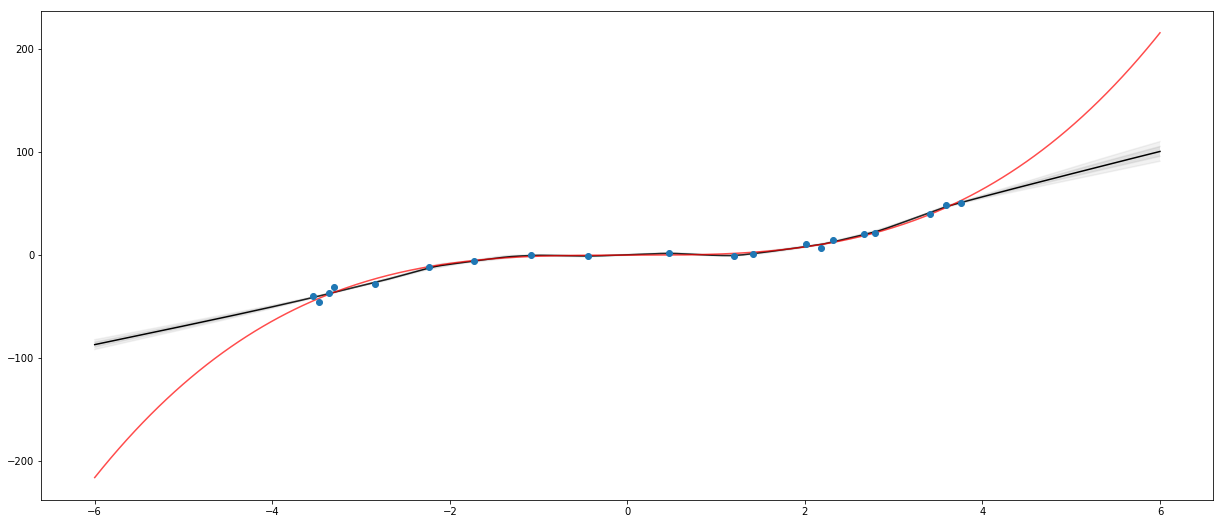

In [85]:
upper1 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) + np.std(predictions_ksgfs[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) + 2 * np.std(predictions_ksgfs[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) - np.std(predictions_ksgfs[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) - 2 * np.std(predictions_ksgfs[:,1:].detach().numpy(),1)

plt.figure(figsize=(21,9))
plt.plot(grid,np.mean(predictions_ksgfs[:,1:].detach().numpy(),1), 'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.12)
plt.plot(grid,lower2,'gray',alpha=0.1)
plt.fill_between(grid.squeeze(),lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid.squeeze(),lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,grid ** 3,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')



## Sinus (Louizos, Welling (2016))

20 data points simulated as follows:
- 12 samples $x_i$ from $\mathcal{U}(0,0.6)$ and 8 samples from $\mathcal{U}(0.8,1)$
- $y = x_i + \epsilon_i + \sin(4(x_i + \epsilon_i)) + \sin(13(x_i + \epsilon_i))$ with $\epsilon_i \sim \mathcal{N}(0,0.0009)$

See https://arxiv.org/pdf/1603.04733.pdf

In [86]:
import math
# Create simulated data set
x1 = torch.empty(12, 1).uniform_(0, 0.6)
x2 = torch.empty(8, 1).uniform_(0.8, 1)

x,_ = torch.cat((x1,x2),0).sort(0)

epsilon = torch.normal(torch.zeros_like(x),math.sqrt(0.0009))
y = x + epsilon + torch.sin(4*(x + epsilon)) + torch.sin(13 * (x + epsilon))

grid = np.linspace(-1,2,400)
y_true = grid + np.sin(4 * grid) + np.sin(13 * grid)

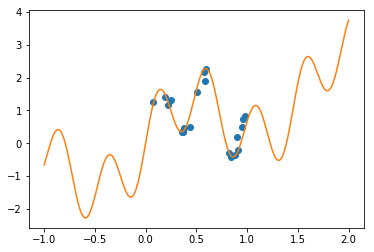

In [87]:
plt.plot(x.numpy(),y.numpy(),'o')
plt.plot(grid, y_true)

### SGLD

In [91]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import sgld

import model



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

lambda_ = 1e-6
lr = 1e-4


batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=True)

optim = sgld.optim.sgld(network, lr, lambda_, dataset_size)

losses_sgld = []
#test_rmse = []
#log_lik_sgld = []
predictions = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(20000):

    running_loss = 0
    
    network.zero_grad()
    output = network(x)
    loss = criterion(output, y)
    loss.backward()
    optim.step()

    losses_sgld.append(loss)


    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    if (t >= 300) & (t % 100 == 0):
        with torch.autograd.no_grad():
            output = network(x_test)
            predictions = torch.cat((predictions, output), 1)

    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

Epoch 0 - loss: 1.6279
Epoch 1 - loss: 1.6324
Epoch 2 - loss: 1.6373
Epoch 3 - loss: 1.6404
Epoch 4 - loss: 1.6313
Epoch 5 - loss: 1.6356
Epoch 6 - loss: 1.6496
Epoch 7 - loss: 1.6423
Epoch 8 - loss: 1.6415
Epoch 9 - loss: 1.6427
Epoch 10 - loss: 1.6419
Epoch 11 - loss: 1.6337
Epoch 12 - loss: 1.6332
Epoch 13 - loss: 1.6198
Epoch 14 - loss: 1.6233
Epoch 15 - loss: 1.6272
Epoch 16 - loss: 1.6238
Epoch 17 - loss: 1.6269
Epoch 18 - loss: 1.6170
Epoch 19 - loss: 1.6209
Epoch 20 - loss: 1.6266
Epoch 21 - loss: 1.6265
Epoch 22 - loss: 1.6294
Epoch 23 - loss: 1.6259
Epoch 24 - loss: 1.6291
Epoch 25 - loss: 1.6328
Epoch 26 - loss: 1.6368
Epoch 27 - loss: 1.6357
Epoch 28 - loss: 1.6238
Epoch 29 - loss: 1.6389
Epoch 30 - loss: 1.6358
Epoch 31 - loss: 1.6388
Epoch 32 - loss: 1.6301
Epoch 33 - loss: 1.6429
Epoch 34 - loss: 1.6473
Epoch 35 - loss: 1.6420
Epoch 36 - loss: 1.6456
Epoch 37 - loss: 1.6500
Epoch 38 - loss: 1.6517
Epoch 39 - loss: 1.6491
Epoch 40 - loss: 1.6375
Epoch 41 - loss: 1.6480
Ep

Epoch 387 - loss: 1.6152
Epoch 388 - loss: 1.6111
Epoch 389 - loss: 1.6123
Epoch 390 - loss: 1.6013
Epoch 391 - loss: 1.5901
Epoch 392 - loss: 1.5746
Epoch 393 - loss: 1.5749
Epoch 394 - loss: 1.5815
Epoch 395 - loss: 1.5781
Epoch 396 - loss: 1.5669
Epoch 397 - loss: 1.5730
Epoch 398 - loss: 1.5754
Epoch 399 - loss: 1.5674
Epoch 400 - loss: 1.5573
Epoch 401 - loss: 1.5610
Epoch 402 - loss: 1.5693
Epoch 403 - loss: 1.5789
Epoch 404 - loss: 1.5834
Epoch 405 - loss: 1.5892
Epoch 406 - loss: 1.5864
Epoch 407 - loss: 1.5995
Epoch 408 - loss: 1.5883
Epoch 409 - loss: 1.6011
Epoch 410 - loss: 1.5965
Epoch 411 - loss: 1.5926
Epoch 412 - loss: 1.5772
Epoch 413 - loss: 1.5842
Epoch 414 - loss: 1.5833
Epoch 415 - loss: 1.5900
Epoch 416 - loss: 1.5801
Epoch 417 - loss: 1.5861
Epoch 418 - loss: 1.5911
Epoch 419 - loss: 1.5869
Epoch 420 - loss: 1.5844
Epoch 421 - loss: 1.5886
Epoch 422 - loss: 1.5844
Epoch 423 - loss: 1.5934
Epoch 424 - loss: 1.5789
Epoch 425 - loss: 1.5947
Epoch 426 - loss: 1.6018


Epoch 735 - loss: 1.4299
Epoch 736 - loss: 1.4375
Epoch 737 - loss: 1.4431
Epoch 738 - loss: 1.4426
Epoch 739 - loss: 1.4481
Epoch 740 - loss: 1.4519
Epoch 741 - loss: 1.4387
Epoch 742 - loss: 1.4367
Epoch 743 - loss: 1.4479
Epoch 744 - loss: 1.4587
Epoch 745 - loss: 1.4514
Epoch 746 - loss: 1.4469
Epoch 747 - loss: 1.4366
Epoch 748 - loss: 1.4367
Epoch 749 - loss: 1.4296
Epoch 750 - loss: 1.4185
Epoch 751 - loss: 1.4234
Epoch 752 - loss: 1.4270
Epoch 753 - loss: 1.4287
Epoch 754 - loss: 1.4352
Epoch 755 - loss: 1.4218
Epoch 756 - loss: 1.4170
Epoch 757 - loss: 1.4085
Epoch 758 - loss: 1.4135
Epoch 759 - loss: 1.4140
Epoch 760 - loss: 1.4146
Epoch 761 - loss: 1.4169
Epoch 762 - loss: 1.4236
Epoch 763 - loss: 1.4121
Epoch 764 - loss: 1.4136
Epoch 765 - loss: 1.4257
Epoch 766 - loss: 1.4279
Epoch 767 - loss: 1.4192
Epoch 768 - loss: 1.4053
Epoch 769 - loss: 1.4057
Epoch 770 - loss: 1.4025
Epoch 771 - loss: 1.3999
Epoch 772 - loss: 1.3922
Epoch 773 - loss: 1.3918
Epoch 774 - loss: 1.3897


Epoch 1241 - loss: 1.1124
Epoch 1242 - loss: 1.1135
Epoch 1243 - loss: 1.1168
Epoch 1244 - loss: 1.1223
Epoch 1245 - loss: 1.1243
Epoch 1246 - loss: 1.1198
Epoch 1247 - loss: 1.1215
Epoch 1248 - loss: 1.1193
Epoch 1249 - loss: 1.1220
Epoch 1250 - loss: 1.1127
Epoch 1251 - loss: 1.1233
Epoch 1252 - loss: 1.1239
Epoch 1253 - loss: 1.1128
Epoch 1254 - loss: 1.1084
Epoch 1255 - loss: 1.1029
Epoch 1256 - loss: 1.1116
Epoch 1257 - loss: 1.1182
Epoch 1258 - loss: 1.1179
Epoch 1259 - loss: 1.1154
Epoch 1260 - loss: 1.1139
Epoch 1261 - loss: 1.1088
Epoch 1262 - loss: 1.1109
Epoch 1263 - loss: 1.1101
Epoch 1264 - loss: 1.1091
Epoch 1265 - loss: 1.1032
Epoch 1266 - loss: 1.1093
Epoch 1267 - loss: 1.1127
Epoch 1268 - loss: 1.1143
Epoch 1269 - loss: 1.1195
Epoch 1270 - loss: 1.1169
Epoch 1271 - loss: 1.1096
Epoch 1272 - loss: 1.0963
Epoch 1273 - loss: 1.0926
Epoch 1274 - loss: 1.0931
Epoch 1275 - loss: 1.0808
Epoch 1276 - loss: 1.0705
Epoch 1277 - loss: 1.0711
Epoch 1278 - loss: 1.0671
Epoch 1279 -

Epoch 1607 - loss: 0.9588
Epoch 1608 - loss: 0.9627
Epoch 1609 - loss: 0.9687
Epoch 1610 - loss: 0.9792
Epoch 1611 - loss: 0.9902
Epoch 1612 - loss: 0.9955
Epoch 1613 - loss: 1.0020
Epoch 1614 - loss: 1.0001
Epoch 1615 - loss: 1.0018
Epoch 1616 - loss: 1.0151
Epoch 1617 - loss: 1.0170
Epoch 1618 - loss: 1.0028
Epoch 1619 - loss: 1.0015
Epoch 1620 - loss: 1.0129
Epoch 1621 - loss: 1.0052
Epoch 1622 - loss: 1.0153
Epoch 1623 - loss: 1.0095
Epoch 1624 - loss: 1.0010
Epoch 1625 - loss: 1.0001
Epoch 1626 - loss: 0.9994
Epoch 1627 - loss: 0.9906
Epoch 1628 - loss: 1.0020
Epoch 1629 - loss: 0.9930
Epoch 1630 - loss: 0.9892
Epoch 1631 - loss: 0.9888
Epoch 1632 - loss: 0.9928
Epoch 1633 - loss: 0.9904
Epoch 1634 - loss: 0.9909
Epoch 1635 - loss: 0.9852
Epoch 1636 - loss: 0.9924
Epoch 1637 - loss: 0.9966
Epoch 1638 - loss: 1.0090
Epoch 1639 - loss: 1.0199
Epoch 1640 - loss: 1.0185
Epoch 1641 - loss: 1.0117
Epoch 1642 - loss: 1.0108
Epoch 1643 - loss: 1.0085
Epoch 1644 - loss: 1.0044
Epoch 1645 -

Epoch 2000 - loss: 0.8804
Epoch 2001 - loss: 0.8741
Epoch 2002 - loss: 0.8725
Epoch 2003 - loss: 0.8806
Epoch 2004 - loss: 0.8817
Epoch 2005 - loss: 0.8892
Epoch 2006 - loss: 0.8896
Epoch 2007 - loss: 0.8875
Epoch 2008 - loss: 0.8892
Epoch 2009 - loss: 0.8843
Epoch 2010 - loss: 0.8775
Epoch 2011 - loss: 0.8770
Epoch 2012 - loss: 0.8746
Epoch 2013 - loss: 0.8747
Epoch 2014 - loss: 0.8723
Epoch 2015 - loss: 0.8688
Epoch 2016 - loss: 0.8629
Epoch 2017 - loss: 0.8697
Epoch 2018 - loss: 0.8770
Epoch 2019 - loss: 0.8726
Epoch 2020 - loss: 0.8698
Epoch 2021 - loss: 0.8695
Epoch 2022 - loss: 0.8729
Epoch 2023 - loss: 0.8723
Epoch 2024 - loss: 0.8736
Epoch 2025 - loss: 0.8722
Epoch 2026 - loss: 0.8783
Epoch 2027 - loss: 0.8695
Epoch 2028 - loss: 0.8625
Epoch 2029 - loss: 0.8605
Epoch 2030 - loss: 0.8640
Epoch 2031 - loss: 0.8683
Epoch 2032 - loss: 0.8688
Epoch 2033 - loss: 0.8743
Epoch 2034 - loss: 0.8680
Epoch 2035 - loss: 0.8697
Epoch 2036 - loss: 0.8700
Epoch 2037 - loss: 0.8647
Epoch 2038 -

Epoch 2392 - loss: 0.7994
Epoch 2393 - loss: 0.7944
Epoch 2394 - loss: 0.8070
Epoch 2395 - loss: 0.8097
Epoch 2396 - loss: 0.8049
Epoch 2397 - loss: 0.8138
Epoch 2398 - loss: 0.8214
Epoch 2399 - loss: 0.8185
Epoch 2400 - loss: 0.8214
Epoch 2401 - loss: 0.8170
Epoch 2402 - loss: 0.8163
Epoch 2403 - loss: 0.8247
Epoch 2404 - loss: 0.8184
Epoch 2405 - loss: 0.8191
Epoch 2406 - loss: 0.8225
Epoch 2407 - loss: 0.8239
Epoch 2408 - loss: 0.8205
Epoch 2409 - loss: 0.8231
Epoch 2410 - loss: 0.8224
Epoch 2411 - loss: 0.8253
Epoch 2412 - loss: 0.8301
Epoch 2413 - loss: 0.8326
Epoch 2414 - loss: 0.8389
Epoch 2415 - loss: 0.8383
Epoch 2416 - loss: 0.8401
Epoch 2417 - loss: 0.8385
Epoch 2418 - loss: 0.8331
Epoch 2419 - loss: 0.8347
Epoch 2420 - loss: 0.8389
Epoch 2421 - loss: 0.8364
Epoch 2422 - loss: 0.8311
Epoch 2423 - loss: 0.8259
Epoch 2424 - loss: 0.8237
Epoch 2425 - loss: 0.8172
Epoch 2426 - loss: 0.8209
Epoch 2427 - loss: 0.8074
Epoch 2428 - loss: 0.8095
Epoch 2429 - loss: 0.8097
Epoch 2430 -

Epoch 2834 - loss: 0.7007
Epoch 2835 - loss: 0.6986
Epoch 2836 - loss: 0.6993
Epoch 2837 - loss: 0.6994
Epoch 2838 - loss: 0.6985
Epoch 2839 - loss: 0.6967
Epoch 2840 - loss: 0.6936
Epoch 2841 - loss: 0.6905
Epoch 2842 - loss: 0.6894
Epoch 2843 - loss: 0.6913
Epoch 2844 - loss: 0.6890
Epoch 2845 - loss: 0.6878
Epoch 2846 - loss: 0.6923
Epoch 2847 - loss: 0.6913
Epoch 2848 - loss: 0.6961
Epoch 2849 - loss: 0.6954
Epoch 2850 - loss: 0.6958
Epoch 2851 - loss: 0.6957
Epoch 2852 - loss: 0.6963
Epoch 2853 - loss: 0.6944
Epoch 2854 - loss: 0.6985
Epoch 2855 - loss: 0.6970
Epoch 2856 - loss: 0.6943
Epoch 2857 - loss: 0.6926
Epoch 2858 - loss: 0.6909
Epoch 2859 - loss: 0.6908
Epoch 2860 - loss: 0.6889
Epoch 2861 - loss: 0.6880
Epoch 2862 - loss: 0.6875
Epoch 2863 - loss: 0.6901
Epoch 2864 - loss: 0.6883
Epoch 2865 - loss: 0.6911
Epoch 2866 - loss: 0.6913
Epoch 2867 - loss: 0.6884
Epoch 2868 - loss: 0.6875
Epoch 2869 - loss: 0.6864
Epoch 2870 - loss: 0.6878
Epoch 2871 - loss: 0.6851
Epoch 2872 -

Epoch 3239 - loss: 0.6809
Epoch 3240 - loss: 0.6816
Epoch 3241 - loss: 0.6768
Epoch 3242 - loss: 0.6785
Epoch 3243 - loss: 0.6792
Epoch 3244 - loss: 0.6744
Epoch 3245 - loss: 0.6769
Epoch 3246 - loss: 0.6796
Epoch 3247 - loss: 0.6760
Epoch 3248 - loss: 0.6724
Epoch 3249 - loss: 0.6750
Epoch 3250 - loss: 0.6777
Epoch 3251 - loss: 0.6768
Epoch 3252 - loss: 0.6749
Epoch 3253 - loss: 0.6715
Epoch 3254 - loss: 0.6738
Epoch 3255 - loss: 0.6756
Epoch 3256 - loss: 0.6771
Epoch 3257 - loss: 0.6791
Epoch 3258 - loss: 0.6756
Epoch 3259 - loss: 0.6752
Epoch 3260 - loss: 0.6777
Epoch 3261 - loss: 0.6771
Epoch 3262 - loss: 0.6781
Epoch 3263 - loss: 0.6797
Epoch 3264 - loss: 0.6785
Epoch 3265 - loss: 0.6772
Epoch 3266 - loss: 0.6790
Epoch 3267 - loss: 0.6818
Epoch 3268 - loss: 0.6802
Epoch 3269 - loss: 0.6850
Epoch 3270 - loss: 0.6948
Epoch 3271 - loss: 0.6969
Epoch 3272 - loss: 0.7007
Epoch 3273 - loss: 0.6993
Epoch 3274 - loss: 0.7038
Epoch 3275 - loss: 0.7100
Epoch 3276 - loss: 0.7090
Epoch 3277 -

Epoch 3591 - loss: 0.7030
Epoch 3592 - loss: 0.7015
Epoch 3593 - loss: 0.7056
Epoch 3594 - loss: 0.7033
Epoch 3595 - loss: 0.6985
Epoch 3596 - loss: 0.6971
Epoch 3597 - loss: 0.6955
Epoch 3598 - loss: 0.6936
Epoch 3599 - loss: 0.6919
Epoch 3600 - loss: 0.6914
Epoch 3601 - loss: 0.6897
Epoch 3602 - loss: 0.6910
Epoch 3603 - loss: 0.6908
Epoch 3604 - loss: 0.6908
Epoch 3605 - loss: 0.6881
Epoch 3606 - loss: 0.6875
Epoch 3607 - loss: 0.6890
Epoch 3608 - loss: 0.6884
Epoch 3609 - loss: 0.6869
Epoch 3610 - loss: 0.6844
Epoch 3611 - loss: 0.6881
Epoch 3612 - loss: 0.6907
Epoch 3613 - loss: 0.6919
Epoch 3614 - loss: 0.6907
Epoch 3615 - loss: 0.6936
Epoch 3616 - loss: 0.6898
Epoch 3617 - loss: 0.6942
Epoch 3618 - loss: 0.6929
Epoch 3619 - loss: 0.6899
Epoch 3620 - loss: 0.6846
Epoch 3621 - loss: 0.6837
Epoch 3622 - loss: 0.6838
Epoch 3623 - loss: 0.6871
Epoch 3624 - loss: 0.6868
Epoch 3625 - loss: 0.6872
Epoch 3626 - loss: 0.6883
Epoch 3627 - loss: 0.6911
Epoch 3628 - loss: 0.6892
Epoch 3629 -

Epoch 3966 - loss: 0.7689
Epoch 3967 - loss: 0.7716
Epoch 3968 - loss: 0.7701
Epoch 3969 - loss: 0.7681
Epoch 3970 - loss: 0.7696
Epoch 3971 - loss: 0.7650
Epoch 3972 - loss: 0.7645
Epoch 3973 - loss: 0.7671
Epoch 3974 - loss: 0.7773
Epoch 3975 - loss: 0.7766
Epoch 3976 - loss: 0.7753
Epoch 3977 - loss: 0.7739
Epoch 3978 - loss: 0.7747
Epoch 3979 - loss: 0.7725
Epoch 3980 - loss: 0.7709
Epoch 3981 - loss: 0.7728
Epoch 3982 - loss: 0.7709
Epoch 3983 - loss: 0.7711
Epoch 3984 - loss: 0.7739
Epoch 3985 - loss: 0.7683
Epoch 3986 - loss: 0.7699
Epoch 3987 - loss: 0.7672
Epoch 3988 - loss: 0.7637
Epoch 3989 - loss: 0.7611
Epoch 3990 - loss: 0.7533
Epoch 3991 - loss: 0.7533
Epoch 3992 - loss: 0.7546
Epoch 3993 - loss: 0.7573
Epoch 3994 - loss: 0.7571
Epoch 3995 - loss: 0.7575
Epoch 3996 - loss: 0.7630
Epoch 3997 - loss: 0.7628
Epoch 3998 - loss: 0.7667
Epoch 3999 - loss: 0.7675
Epoch 4000 - loss: 0.7602
Epoch 4001 - loss: 0.7628
Epoch 4002 - loss: 0.7678
Epoch 4003 - loss: 0.7613
Epoch 4004 -

Epoch 4371 - loss: 0.7422
Epoch 4372 - loss: 0.7422
Epoch 4373 - loss: 0.7450
Epoch 4374 - loss: 0.7438
Epoch 4375 - loss: 0.7432
Epoch 4376 - loss: 0.7443
Epoch 4377 - loss: 0.7447
Epoch 4378 - loss: 0.7421
Epoch 4379 - loss: 0.7442
Epoch 4380 - loss: 0.7459
Epoch 4381 - loss: 0.7490
Epoch 4382 - loss: 0.7489
Epoch 4383 - loss: 0.7497
Epoch 4384 - loss: 0.7484
Epoch 4385 - loss: 0.7485
Epoch 4386 - loss: 0.7548
Epoch 4387 - loss: 0.7526
Epoch 4388 - loss: 0.7551
Epoch 4389 - loss: 0.7554
Epoch 4390 - loss: 0.7595
Epoch 4391 - loss: 0.7643
Epoch 4392 - loss: 0.7666
Epoch 4393 - loss: 0.7635
Epoch 4394 - loss: 0.7671
Epoch 4395 - loss: 0.7693
Epoch 4396 - loss: 0.7729
Epoch 4397 - loss: 0.7735
Epoch 4398 - loss: 0.7679
Epoch 4399 - loss: 0.7673
Epoch 4400 - loss: 0.7669
Epoch 4401 - loss: 0.7686
Epoch 4402 - loss: 0.7619
Epoch 4403 - loss: 0.7644
Epoch 4404 - loss: 0.7651
Epoch 4405 - loss: 0.7680
Epoch 4406 - loss: 0.7677
Epoch 4407 - loss: 0.7730
Epoch 4408 - loss: 0.7724
Epoch 4409 -

Epoch 4796 - loss: 0.7035
Epoch 4797 - loss: 0.7090
Epoch 4798 - loss: 0.7119
Epoch 4799 - loss: 0.7099
Epoch 4800 - loss: 0.7165
Epoch 4801 - loss: 0.7149
Epoch 4802 - loss: 0.7148
Epoch 4803 - loss: 0.7152
Epoch 4804 - loss: 0.7167
Epoch 4805 - loss: 0.7219
Epoch 4806 - loss: 0.7209
Epoch 4807 - loss: 0.7273
Epoch 4808 - loss: 0.7258
Epoch 4809 - loss: 0.7244
Epoch 4810 - loss: 0.7276
Epoch 4811 - loss: 0.7294
Epoch 4812 - loss: 0.7315
Epoch 4813 - loss: 0.7304
Epoch 4814 - loss: 0.7278
Epoch 4815 - loss: 0.7308
Epoch 4816 - loss: 0.7314
Epoch 4817 - loss: 0.7324
Epoch 4818 - loss: 0.7308
Epoch 4819 - loss: 0.7284
Epoch 4820 - loss: 0.7257
Epoch 4821 - loss: 0.7269
Epoch 4822 - loss: 0.7286
Epoch 4823 - loss: 0.7287
Epoch 4824 - loss: 0.7250
Epoch 4825 - loss: 0.7262
Epoch 4826 - loss: 0.7277
Epoch 4827 - loss: 0.7348
Epoch 4828 - loss: 0.7293
Epoch 4829 - loss: 0.7261
Epoch 4830 - loss: 0.7250
Epoch 4831 - loss: 0.7236
Epoch 4832 - loss: 0.7224
Epoch 4833 - loss: 0.7239
Epoch 4834 -

Epoch 5252 - loss: 0.7404
Epoch 5253 - loss: 0.7385
Epoch 5254 - loss: 0.7384
Epoch 5255 - loss: 0.7374
Epoch 5256 - loss: 0.7429
Epoch 5257 - loss: 0.7419
Epoch 5258 - loss: 0.7403
Epoch 5259 - loss: 0.7396
Epoch 5260 - loss: 0.7413
Epoch 5261 - loss: 0.7430
Epoch 5262 - loss: 0.7481
Epoch 5263 - loss: 0.7494
Epoch 5264 - loss: 0.7489
Epoch 5265 - loss: 0.7481
Epoch 5266 - loss: 0.7462
Epoch 5267 - loss: 0.7465
Epoch 5268 - loss: 0.7514
Epoch 5269 - loss: 0.7534
Epoch 5270 - loss: 0.7548
Epoch 5271 - loss: 0.7549
Epoch 5272 - loss: 0.7495
Epoch 5273 - loss: 0.7505
Epoch 5274 - loss: 0.7514
Epoch 5275 - loss: 0.7511
Epoch 5276 - loss: 0.7486
Epoch 5277 - loss: 0.7483
Epoch 5278 - loss: 0.7483
Epoch 5279 - loss: 0.7481
Epoch 5280 - loss: 0.7513
Epoch 5281 - loss: 0.7506
Epoch 5282 - loss: 0.7510
Epoch 5283 - loss: 0.7514
Epoch 5284 - loss: 0.7539
Epoch 5285 - loss: 0.7502
Epoch 5286 - loss: 0.7513
Epoch 5287 - loss: 0.7506
Epoch 5288 - loss: 0.7501
Epoch 5289 - loss: 0.7461
Epoch 5290 -

Epoch 5650 - loss: 0.7319
Epoch 5651 - loss: 0.7321
Epoch 5652 - loss: 0.7312
Epoch 5653 - loss: 0.7303
Epoch 5654 - loss: 0.7287
Epoch 5655 - loss: 0.7308
Epoch 5656 - loss: 0.7303
Epoch 5657 - loss: 0.7296
Epoch 5658 - loss: 0.7299
Epoch 5659 - loss: 0.7297
Epoch 5660 - loss: 0.7295
Epoch 5661 - loss: 0.7285
Epoch 5662 - loss: 0.7286
Epoch 5663 - loss: 0.7271
Epoch 5664 - loss: 0.7256
Epoch 5665 - loss: 0.7241
Epoch 5666 - loss: 0.7262
Epoch 5667 - loss: 0.7275
Epoch 5668 - loss: 0.7264
Epoch 5669 - loss: 0.7299
Epoch 5670 - loss: 0.7298
Epoch 5671 - loss: 0.7299
Epoch 5672 - loss: 0.7309
Epoch 5673 - loss: 0.7295
Epoch 5674 - loss: 0.7287
Epoch 5675 - loss: 0.7271
Epoch 5676 - loss: 0.7275
Epoch 5677 - loss: 0.7250
Epoch 5678 - loss: 0.7241
Epoch 5679 - loss: 0.7237
Epoch 5680 - loss: 0.7239
Epoch 5681 - loss: 0.7253
Epoch 5682 - loss: 0.7243
Epoch 5683 - loss: 0.7238
Epoch 5684 - loss: 0.7267
Epoch 5685 - loss: 0.7238
Epoch 5686 - loss: 0.7254
Epoch 5687 - loss: 0.7249
Epoch 5688 -

Epoch 6069 - loss: 0.7248
Epoch 6070 - loss: 0.7269
Epoch 6071 - loss: 0.7258
Epoch 6072 - loss: 0.7263
Epoch 6073 - loss: 0.7255
Epoch 6074 - loss: 0.7242
Epoch 6075 - loss: 0.7260
Epoch 6076 - loss: 0.7277
Epoch 6077 - loss: 0.7286
Epoch 6078 - loss: 0.7230
Epoch 6079 - loss: 0.7230
Epoch 6080 - loss: 0.7271
Epoch 6081 - loss: 0.7206
Epoch 6082 - loss: 0.7212
Epoch 6083 - loss: 0.7190
Epoch 6084 - loss: 0.7194
Epoch 6085 - loss: 0.7185
Epoch 6086 - loss: 0.7221
Epoch 6087 - loss: 0.7193
Epoch 6088 - loss: 0.7203
Epoch 6089 - loss: 0.7204
Epoch 6090 - loss: 0.7225
Epoch 6091 - loss: 0.7229
Epoch 6092 - loss: 0.7184
Epoch 6093 - loss: 0.7142
Epoch 6094 - loss: 0.7120
Epoch 6095 - loss: 0.7127
Epoch 6096 - loss: 0.7138
Epoch 6097 - loss: 0.7148
Epoch 6098 - loss: 0.7163
Epoch 6099 - loss: 0.7163
Epoch 6100 - loss: 0.7163
Epoch 6101 - loss: 0.7174
Epoch 6102 - loss: 0.7128
Epoch 6103 - loss: 0.7111
Epoch 6104 - loss: 0.7087
Epoch 6105 - loss: 0.7056
Epoch 6106 - loss: 0.7055
Epoch 6107 -

Epoch 6501 - loss: 0.6786
Epoch 6502 - loss: 0.6787
Epoch 6503 - loss: 0.6792
Epoch 6504 - loss: 0.6813
Epoch 6505 - loss: 0.6803
Epoch 6506 - loss: 0.6821
Epoch 6507 - loss: 0.6797
Epoch 6508 - loss: 0.6795
Epoch 6509 - loss: 0.6787
Epoch 6510 - loss: 0.6783
Epoch 6511 - loss: 0.6769
Epoch 6512 - loss: 0.6770
Epoch 6513 - loss: 0.6778
Epoch 6514 - loss: 0.6783
Epoch 6515 - loss: 0.6785
Epoch 6516 - loss: 0.6795
Epoch 6517 - loss: 0.6810
Epoch 6518 - loss: 0.6800
Epoch 6519 - loss: 0.6816
Epoch 6520 - loss: 0.6804
Epoch 6521 - loss: 0.6813
Epoch 6522 - loss: 0.6837
Epoch 6523 - loss: 0.6846
Epoch 6524 - loss: 0.6863
Epoch 6525 - loss: 0.6848
Epoch 6526 - loss: 0.6840
Epoch 6527 - loss: 0.6854
Epoch 6528 - loss: 0.6882
Epoch 6529 - loss: 0.6886
Epoch 6530 - loss: 0.6878
Epoch 6531 - loss: 0.6878
Epoch 6532 - loss: 0.6896
Epoch 6533 - loss: 0.6889
Epoch 6534 - loss: 0.6860
Epoch 6535 - loss: 0.6876
Epoch 6536 - loss: 0.6863
Epoch 6537 - loss: 0.6878
Epoch 6538 - loss: 0.6884
Epoch 6539 -

Epoch 6864 - loss: 0.6473
Epoch 6865 - loss: 0.6471
Epoch 6866 - loss: 0.6461
Epoch 6867 - loss: 0.6472
Epoch 6868 - loss: 0.6494
Epoch 6869 - loss: 0.6491
Epoch 6870 - loss: 0.6517
Epoch 6871 - loss: 0.6493
Epoch 6872 - loss: 0.6498
Epoch 6873 - loss: 0.6513
Epoch 6874 - loss: 0.6486
Epoch 6875 - loss: 0.6459
Epoch 6876 - loss: 0.6475
Epoch 6877 - loss: 0.6481
Epoch 6878 - loss: 0.6489
Epoch 6879 - loss: 0.6508
Epoch 6880 - loss: 0.6537
Epoch 6881 - loss: 0.6531
Epoch 6882 - loss: 0.6538
Epoch 6883 - loss: 0.6590
Epoch 6884 - loss: 0.6527
Epoch 6885 - loss: 0.6539
Epoch 6886 - loss: 0.6534
Epoch 6887 - loss: 0.6549
Epoch 6888 - loss: 0.6504
Epoch 6889 - loss: 0.6499
Epoch 6890 - loss: 0.6520
Epoch 6891 - loss: 0.6484
Epoch 6892 - loss: 0.6485
Epoch 6893 - loss: 0.6477
Epoch 6894 - loss: 0.6503
Epoch 6895 - loss: 0.6511
Epoch 6896 - loss: 0.6530
Epoch 6897 - loss: 0.6530
Epoch 6898 - loss: 0.6539
Epoch 6899 - loss: 0.6557
Epoch 6900 - loss: 0.6545
Epoch 6901 - loss: 0.6523
Epoch 6902 -

Epoch 7245 - loss: 0.6303
Epoch 7246 - loss: 0.6312
Epoch 7247 - loss: 0.6299
Epoch 7248 - loss: 0.6301
Epoch 7249 - loss: 0.6283
Epoch 7250 - loss: 0.6285
Epoch 7251 - loss: 0.6289
Epoch 7252 - loss: 0.6285
Epoch 7253 - loss: 0.6274
Epoch 7254 - loss: 0.6262
Epoch 7255 - loss: 0.6272
Epoch 7256 - loss: 0.6275
Epoch 7257 - loss: 0.6304
Epoch 7258 - loss: 0.6310
Epoch 7259 - loss: 0.6318
Epoch 7260 - loss: 0.6327
Epoch 7261 - loss: 0.6353
Epoch 7262 - loss: 0.6326
Epoch 7263 - loss: 0.6340
Epoch 7264 - loss: 0.6327
Epoch 7265 - loss: 0.6323
Epoch 7266 - loss: 0.6324
Epoch 7267 - loss: 0.6344
Epoch 7268 - loss: 0.6317
Epoch 7269 - loss: 0.6323
Epoch 7270 - loss: 0.6307
Epoch 7271 - loss: 0.6309
Epoch 7272 - loss: 0.6310
Epoch 7273 - loss: 0.6303
Epoch 7274 - loss: 0.6296
Epoch 7275 - loss: 0.6306
Epoch 7276 - loss: 0.6336
Epoch 7277 - loss: 0.6338
Epoch 7278 - loss: 0.6341
Epoch 7279 - loss: 0.6338
Epoch 7280 - loss: 0.6321
Epoch 7281 - loss: 0.6314
Epoch 7282 - loss: 0.6307
Epoch 7283 -

Epoch 7587 - loss: 0.6227
Epoch 7588 - loss: 0.6222
Epoch 7589 - loss: 0.6225
Epoch 7590 - loss: 0.6213
Epoch 7591 - loss: 0.6196
Epoch 7592 - loss: 0.6180
Epoch 7593 - loss: 0.6200
Epoch 7594 - loss: 0.6177
Epoch 7595 - loss: 0.6185
Epoch 7596 - loss: 0.6189
Epoch 7597 - loss: 0.6180
Epoch 7598 - loss: 0.6192
Epoch 7599 - loss: 0.6187
Epoch 7600 - loss: 0.6187
Epoch 7601 - loss: 0.6211
Epoch 7602 - loss: 0.6203
Epoch 7603 - loss: 0.6235
Epoch 7604 - loss: 0.6232
Epoch 7605 - loss: 0.6242
Epoch 7606 - loss: 0.6267
Epoch 7607 - loss: 0.6256
Epoch 7608 - loss: 0.6260
Epoch 7609 - loss: 0.6251
Epoch 7610 - loss: 0.6251
Epoch 7611 - loss: 0.6284
Epoch 7612 - loss: 0.6284
Epoch 7613 - loss: 0.6311
Epoch 7614 - loss: 0.6324
Epoch 7615 - loss: 0.6326
Epoch 7616 - loss: 0.6324
Epoch 7617 - loss: 0.6324
Epoch 7618 - loss: 0.6347
Epoch 7619 - loss: 0.6303
Epoch 7620 - loss: 0.6280
Epoch 7621 - loss: 0.6260
Epoch 7622 - loss: 0.6305
Epoch 7623 - loss: 0.6300
Epoch 7624 - loss: 0.6335
Epoch 7625 -

Epoch 7993 - loss: 0.6174
Epoch 7994 - loss: 0.6193
Epoch 7995 - loss: 0.6205
Epoch 7996 - loss: 0.6203
Epoch 7997 - loss: 0.6180
Epoch 7998 - loss: 0.6193
Epoch 7999 - loss: 0.6227
Epoch 8000 - loss: 0.6221
Epoch 8001 - loss: 0.6229
Epoch 8002 - loss: 0.6230
Epoch 8003 - loss: 0.6248
Epoch 8004 - loss: 0.6273
Epoch 8005 - loss: 0.6282
Epoch 8006 - loss: 0.6269
Epoch 8007 - loss: 0.6295
Epoch 8008 - loss: 0.6328
Epoch 8009 - loss: 0.6299
Epoch 8010 - loss: 0.6314
Epoch 8011 - loss: 0.6309
Epoch 8012 - loss: 0.6287
Epoch 8013 - loss: 0.6249
Epoch 8014 - loss: 0.6274
Epoch 8015 - loss: 0.6277
Epoch 8016 - loss: 0.6291
Epoch 8017 - loss: 0.6271
Epoch 8018 - loss: 0.6282
Epoch 8019 - loss: 0.6282
Epoch 8020 - loss: 0.6273
Epoch 8021 - loss: 0.6275
Epoch 8022 - loss: 0.6255
Epoch 8023 - loss: 0.6250
Epoch 8024 - loss: 0.6300
Epoch 8025 - loss: 0.6289
Epoch 8026 - loss: 0.6298
Epoch 8027 - loss: 0.6267
Epoch 8028 - loss: 0.6264
Epoch 8029 - loss: 0.6261
Epoch 8030 - loss: 0.6299
Epoch 8031 -

Epoch 8470 - loss: 0.6472
Epoch 8471 - loss: 0.6447
Epoch 8472 - loss: 0.6417
Epoch 8473 - loss: 0.6423
Epoch 8474 - loss: 0.6469
Epoch 8475 - loss: 0.6539
Epoch 8476 - loss: 0.6551
Epoch 8477 - loss: 0.6510
Epoch 8478 - loss: 0.6494
Epoch 8479 - loss: 0.6531
Epoch 8480 - loss: 0.6542
Epoch 8481 - loss: 0.6544
Epoch 8482 - loss: 0.6540
Epoch 8483 - loss: 0.6552
Epoch 8484 - loss: 0.6587
Epoch 8485 - loss: 0.6683
Epoch 8486 - loss: 0.6747
Epoch 8487 - loss: 0.6762
Epoch 8488 - loss: 0.6708
Epoch 8489 - loss: 0.6667
Epoch 8490 - loss: 0.6670
Epoch 8491 - loss: 0.6611
Epoch 8492 - loss: 0.6641
Epoch 8493 - loss: 0.6605
Epoch 8494 - loss: 0.6489
Epoch 8495 - loss: 0.6514
Epoch 8496 - loss: 0.6561
Epoch 8497 - loss: 0.6523
Epoch 8498 - loss: 0.6501
Epoch 8499 - loss: 0.6448
Epoch 8500 - loss: 0.6464
Epoch 8501 - loss: 0.6475
Epoch 8502 - loss: 0.6546
Epoch 8503 - loss: 0.6548
Epoch 8504 - loss: 0.6512
Epoch 8505 - loss: 0.6534
Epoch 8506 - loss: 0.6560
Epoch 8507 - loss: 0.6569
Epoch 8508 -

Epoch 8791 - loss: 0.5539
Epoch 8792 - loss: 0.5534
Epoch 8793 - loss: 0.5521
Epoch 8794 - loss: 0.5530
Epoch 8795 - loss: 0.5530
Epoch 8796 - loss: 0.5533
Epoch 8797 - loss: 0.5564
Epoch 8798 - loss: 0.5552
Epoch 8799 - loss: 0.5556
Epoch 8800 - loss: 0.5580
Epoch 8801 - loss: 0.5591
Epoch 8802 - loss: 0.5590
Epoch 8803 - loss: 0.5572
Epoch 8804 - loss: 0.5564
Epoch 8805 - loss: 0.5596
Epoch 8806 - loss: 0.5566
Epoch 8807 - loss: 0.5572
Epoch 8808 - loss: 0.5561
Epoch 8809 - loss: 0.5551
Epoch 8810 - loss: 0.5555
Epoch 8811 - loss: 0.5539
Epoch 8812 - loss: 0.5545
Epoch 8813 - loss: 0.5517
Epoch 8814 - loss: 0.5545
Epoch 8815 - loss: 0.5537
Epoch 8816 - loss: 0.5520
Epoch 8817 - loss: 0.5534
Epoch 8818 - loss: 0.5540
Epoch 8819 - loss: 0.5537
Epoch 8820 - loss: 0.5544
Epoch 8821 - loss: 0.5540
Epoch 8822 - loss: 0.5552
Epoch 8823 - loss: 0.5570
Epoch 8824 - loss: 0.5577
Epoch 8825 - loss: 0.5574
Epoch 8826 - loss: 0.5586
Epoch 8827 - loss: 0.5617
Epoch 8828 - loss: 0.5616
Epoch 8829 -

Epoch 9197 - loss: 0.5877
Epoch 9198 - loss: 0.5850
Epoch 9199 - loss: 0.5962
Epoch 9200 - loss: 0.5950
Epoch 9201 - loss: 0.5999
Epoch 9202 - loss: 0.5991
Epoch 9203 - loss: 0.5958
Epoch 9204 - loss: 0.5929
Epoch 9205 - loss: 0.5953
Epoch 9206 - loss: 0.5936
Epoch 9207 - loss: 0.5963
Epoch 9208 - loss: 0.5914
Epoch 9209 - loss: 0.5889
Epoch 9210 - loss: 0.5894
Epoch 9211 - loss: 0.5876
Epoch 9212 - loss: 0.5837
Epoch 9213 - loss: 0.5799
Epoch 9214 - loss: 0.5817
Epoch 9215 - loss: 0.5820
Epoch 9216 - loss: 0.5809
Epoch 9217 - loss: 0.5790
Epoch 9218 - loss: 0.5788
Epoch 9219 - loss: 0.5812
Epoch 9220 - loss: 0.5787
Epoch 9221 - loss: 0.5787
Epoch 9222 - loss: 0.5770
Epoch 9223 - loss: 0.5775
Epoch 9224 - loss: 0.5789
Epoch 9225 - loss: 0.5808
Epoch 9226 - loss: 0.5822
Epoch 9227 - loss: 0.5817
Epoch 9228 - loss: 0.5844
Epoch 9229 - loss: 0.5869
Epoch 9230 - loss: 0.5891
Epoch 9231 - loss: 0.5934
Epoch 9232 - loss: 0.5912
Epoch 9233 - loss: 0.5887
Epoch 9234 - loss: 0.5822
Epoch 9235 -

Epoch 9626 - loss: 0.6032
Epoch 9627 - loss: 0.6052
Epoch 9628 - loss: 0.6049
Epoch 9629 - loss: 0.6083
Epoch 9630 - loss: 0.6071
Epoch 9631 - loss: 0.6067
Epoch 9632 - loss: 0.6106
Epoch 9633 - loss: 0.6096
Epoch 9634 - loss: 0.6101
Epoch 9635 - loss: 0.6090
Epoch 9636 - loss: 0.6088
Epoch 9637 - loss: 0.6049
Epoch 9638 - loss: 0.6058
Epoch 9639 - loss: 0.6050
Epoch 9640 - loss: 0.6065
Epoch 9641 - loss: 0.6063
Epoch 9642 - loss: 0.6089
Epoch 9643 - loss: 0.6097
Epoch 9644 - loss: 0.6093
Epoch 9645 - loss: 0.6080
Epoch 9646 - loss: 0.6074
Epoch 9647 - loss: 0.6066
Epoch 9648 - loss: 0.6052
Epoch 9649 - loss: 0.6044
Epoch 9650 - loss: 0.6061
Epoch 9651 - loss: 0.6080
Epoch 9652 - loss: 0.6071
Epoch 9653 - loss: 0.6070
Epoch 9654 - loss: 0.6093
Epoch 9655 - loss: 0.6090
Epoch 9656 - loss: 0.6098
Epoch 9657 - loss: 0.6134
Epoch 9658 - loss: 0.6133
Epoch 9659 - loss: 0.6118
Epoch 9660 - loss: 0.6111
Epoch 9661 - loss: 0.6120
Epoch 9662 - loss: 0.6128
Epoch 9663 - loss: 0.6137
Epoch 9664 -

Epoch 10065 - loss: 0.6963
Epoch 10066 - loss: 0.6914
Epoch 10067 - loss: 0.6867
Epoch 10068 - loss: 0.6931
Epoch 10069 - loss: 0.6925
Epoch 10070 - loss: 0.6935
Epoch 10071 - loss: 0.6983
Epoch 10072 - loss: 0.7074
Epoch 10073 - loss: 0.7025
Epoch 10074 - loss: 0.6990
Epoch 10075 - loss: 0.7006
Epoch 10076 - loss: 0.6993
Epoch 10077 - loss: 0.7036
Epoch 10078 - loss: 0.7055
Epoch 10079 - loss: 0.7085
Epoch 10080 - loss: 0.7090
Epoch 10081 - loss: 0.7154
Epoch 10082 - loss: 0.7142
Epoch 10083 - loss: 0.7140
Epoch 10084 - loss: 0.7159
Epoch 10085 - loss: 0.7174
Epoch 10086 - loss: 0.7108
Epoch 10087 - loss: 0.7088
Epoch 10088 - loss: 0.7002
Epoch 10089 - loss: 0.7000
Epoch 10090 - loss: 0.6943
Epoch 10091 - loss: 0.6961
Epoch 10092 - loss: 0.7036
Epoch 10093 - loss: 0.6979
Epoch 10094 - loss: 0.6972
Epoch 10095 - loss: 0.6959
Epoch 10096 - loss: 0.7061
Epoch 10097 - loss: 0.7139
Epoch 10098 - loss: 0.7143
Epoch 10099 - loss: 0.7142
Epoch 10100 - loss: 0.7132
Epoch 10101 - loss: 0.7010
E

Epoch 10508 - loss: 0.6388
Epoch 10509 - loss: 0.6401
Epoch 10510 - loss: 0.6412
Epoch 10511 - loss: 0.6417
Epoch 10512 - loss: 0.6398
Epoch 10513 - loss: 0.6395
Epoch 10514 - loss: 0.6398
Epoch 10515 - loss: 0.6420
Epoch 10516 - loss: 0.6410
Epoch 10517 - loss: 0.6389
Epoch 10518 - loss: 0.6398
Epoch 10519 - loss: 0.6376
Epoch 10520 - loss: 0.6388
Epoch 10521 - loss: 0.6403
Epoch 10522 - loss: 0.6401
Epoch 10523 - loss: 0.6419
Epoch 10524 - loss: 0.6454
Epoch 10525 - loss: 0.6455
Epoch 10526 - loss: 0.6476
Epoch 10527 - loss: 0.6473
Epoch 10528 - loss: 0.6491
Epoch 10529 - loss: 0.6508
Epoch 10530 - loss: 0.6524
Epoch 10531 - loss: 0.6527
Epoch 10532 - loss: 0.6535
Epoch 10533 - loss: 0.6550
Epoch 10534 - loss: 0.6591
Epoch 10535 - loss: 0.6572
Epoch 10536 - loss: 0.6559
Epoch 10537 - loss: 0.6535
Epoch 10538 - loss: 0.6539
Epoch 10539 - loss: 0.6527
Epoch 10540 - loss: 0.6515
Epoch 10541 - loss: 0.6513
Epoch 10542 - loss: 0.6515
Epoch 10543 - loss: 0.6512
Epoch 10544 - loss: 0.6483
E

Epoch 10959 - loss: 0.6742
Epoch 10960 - loss: 0.6719
Epoch 10961 - loss: 0.6738
Epoch 10962 - loss: 0.6738
Epoch 10963 - loss: 0.6763
Epoch 10964 - loss: 0.6764
Epoch 10965 - loss: 0.6750
Epoch 10966 - loss: 0.6749
Epoch 10967 - loss: 0.6752
Epoch 10968 - loss: 0.6738
Epoch 10969 - loss: 0.6760
Epoch 10970 - loss: 0.6751
Epoch 10971 - loss: 0.6756
Epoch 10972 - loss: 0.6737
Epoch 10973 - loss: 0.6743
Epoch 10974 - loss: 0.6740
Epoch 10975 - loss: 0.6763
Epoch 10976 - loss: 0.6757
Epoch 10977 - loss: 0.6785
Epoch 10978 - loss: 0.6782
Epoch 10979 - loss: 0.6777
Epoch 10980 - loss: 0.6764
Epoch 10981 - loss: 0.6767
Epoch 10982 - loss: 0.6759
Epoch 10983 - loss: 0.6776
Epoch 10984 - loss: 0.6782
Epoch 10985 - loss: 0.6783
Epoch 10986 - loss: 0.6774
Epoch 10987 - loss: 0.6752
Epoch 10988 - loss: 0.6754
Epoch 10989 - loss: 0.6765
Epoch 10990 - loss: 0.6785
Epoch 10991 - loss: 0.6777
Epoch 10992 - loss: 0.6762
Epoch 10993 - loss: 0.6765
Epoch 10994 - loss: 0.6775
Epoch 10995 - loss: 0.6749
E

Epoch 11358 - loss: 0.6690
Epoch 11359 - loss: 0.6671
Epoch 11360 - loss: 0.6712
Epoch 11361 - loss: 0.6720
Epoch 11362 - loss: 0.6692
Epoch 11363 - loss: 0.6649
Epoch 11364 - loss: 0.6668
Epoch 11365 - loss: 0.6658
Epoch 11366 - loss: 0.6685
Epoch 11367 - loss: 0.6656
Epoch 11368 - loss: 0.6605
Epoch 11369 - loss: 0.6607
Epoch 11370 - loss: 0.6584
Epoch 11371 - loss: 0.6565
Epoch 11372 - loss: 0.6556
Epoch 11373 - loss: 0.6566
Epoch 11374 - loss: 0.6562
Epoch 11375 - loss: 0.6580
Epoch 11376 - loss: 0.6583
Epoch 11377 - loss: 0.6565
Epoch 11378 - loss: 0.6555
Epoch 11379 - loss: 0.6537
Epoch 11380 - loss: 0.6539
Epoch 11381 - loss: 0.6526
Epoch 11382 - loss: 0.6539
Epoch 11383 - loss: 0.6594
Epoch 11384 - loss: 0.6572
Epoch 11385 - loss: 0.6570
Epoch 11386 - loss: 0.6583
Epoch 11387 - loss: 0.6529
Epoch 11388 - loss: 0.6570
Epoch 11389 - loss: 0.6594
Epoch 11390 - loss: 0.6610
Epoch 11391 - loss: 0.6626
Epoch 11392 - loss: 0.6606
Epoch 11393 - loss: 0.6631
Epoch 11394 - loss: 0.6611
E

Epoch 11771 - loss: 0.6850
Epoch 11772 - loss: 0.6828
Epoch 11773 - loss: 0.6828
Epoch 11774 - loss: 0.6845
Epoch 11775 - loss: 0.6863
Epoch 11776 - loss: 0.6859
Epoch 11777 - loss: 0.6841
Epoch 11778 - loss: 0.6814
Epoch 11779 - loss: 0.6840
Epoch 11780 - loss: 0.6839
Epoch 11781 - loss: 0.6884
Epoch 11782 - loss: 0.6874
Epoch 11783 - loss: 0.6877
Epoch 11784 - loss: 0.6871
Epoch 11785 - loss: 0.6893
Epoch 11786 - loss: 0.6885
Epoch 11787 - loss: 0.6875
Epoch 11788 - loss: 0.6892
Epoch 11789 - loss: 0.6878
Epoch 11790 - loss: 0.6880
Epoch 11791 - loss: 0.6900
Epoch 11792 - loss: 0.6875
Epoch 11793 - loss: 0.6895
Epoch 11794 - loss: 0.6879
Epoch 11795 - loss: 0.6864
Epoch 11796 - loss: 0.6874
Epoch 11797 - loss: 0.6856
Epoch 11798 - loss: 0.6866
Epoch 11799 - loss: 0.6853
Epoch 11800 - loss: 0.6840
Epoch 11801 - loss: 0.6842
Epoch 11802 - loss: 0.6835
Epoch 11803 - loss: 0.6868
Epoch 11804 - loss: 0.6878
Epoch 11805 - loss: 0.6864
Epoch 11806 - loss: 0.6888
Epoch 11807 - loss: 0.6895
E

Epoch 12081 - loss: 0.6803
Epoch 12082 - loss: 0.6777
Epoch 12083 - loss: 0.6786
Epoch 12084 - loss: 0.6773
Epoch 12085 - loss: 0.6803
Epoch 12086 - loss: 0.6839
Epoch 12087 - loss: 0.6846
Epoch 12088 - loss: 0.6838
Epoch 12089 - loss: 0.6834
Epoch 12090 - loss: 0.6820
Epoch 12091 - loss: 0.6825
Epoch 12092 - loss: 0.6828
Epoch 12093 - loss: 0.6811
Epoch 12094 - loss: 0.6820
Epoch 12095 - loss: 0.6842
Epoch 12096 - loss: 0.6845
Epoch 12097 - loss: 0.6829
Epoch 12098 - loss: 0.6842
Epoch 12099 - loss: 0.6841
Epoch 12100 - loss: 0.6864
Epoch 12101 - loss: 0.6875
Epoch 12102 - loss: 0.6892
Epoch 12103 - loss: 0.6874
Epoch 12104 - loss: 0.6873
Epoch 12105 - loss: 0.6875
Epoch 12106 - loss: 0.6924
Epoch 12107 - loss: 0.6929
Epoch 12108 - loss: 0.6941
Epoch 12109 - loss: 0.6940
Epoch 12110 - loss: 0.6963
Epoch 12111 - loss: 0.6955
Epoch 12112 - loss: 0.6955
Epoch 12113 - loss: 0.6960
Epoch 12114 - loss: 0.7011
Epoch 12115 - loss: 0.6969
Epoch 12116 - loss: 0.6947
Epoch 12117 - loss: 0.6946
E

Epoch 12414 - loss: 0.6819
Epoch 12415 - loss: 0.6782
Epoch 12416 - loss: 0.6792
Epoch 12417 - loss: 0.6778
Epoch 12418 - loss: 0.6759
Epoch 12419 - loss: 0.6773
Epoch 12420 - loss: 0.6786
Epoch 12421 - loss: 0.6751
Epoch 12422 - loss: 0.6750
Epoch 12423 - loss: 0.6751
Epoch 12424 - loss: 0.6754
Epoch 12425 - loss: 0.6750
Epoch 12426 - loss: 0.6750
Epoch 12427 - loss: 0.6761
Epoch 12428 - loss: 0.6759
Epoch 12429 - loss: 0.6760
Epoch 12430 - loss: 0.6761
Epoch 12431 - loss: 0.6765
Epoch 12432 - loss: 0.6770
Epoch 12433 - loss: 0.6786
Epoch 12434 - loss: 0.6797
Epoch 12435 - loss: 0.6790
Epoch 12436 - loss: 0.6810
Epoch 12437 - loss: 0.6835
Epoch 12438 - loss: 0.6832
Epoch 12439 - loss: 0.6819
Epoch 12440 - loss: 0.6787
Epoch 12441 - loss: 0.6783
Epoch 12442 - loss: 0.6774
Epoch 12443 - loss: 0.6761
Epoch 12444 - loss: 0.6770
Epoch 12445 - loss: 0.6762
Epoch 12446 - loss: 0.6774
Epoch 12447 - loss: 0.6799
Epoch 12448 - loss: 0.6813
Epoch 12449 - loss: 0.6757
Epoch 12450 - loss: 0.6770
E

Epoch 12724 - loss: 0.7109
Epoch 12725 - loss: 0.7104
Epoch 12726 - loss: 0.7133
Epoch 12727 - loss: 0.7140
Epoch 12728 - loss: 0.7133
Epoch 12729 - loss: 0.7136
Epoch 12730 - loss: 0.7143
Epoch 12731 - loss: 0.7146
Epoch 12732 - loss: 0.7208
Epoch 12733 - loss: 0.7191
Epoch 12734 - loss: 0.7168
Epoch 12735 - loss: 0.7182
Epoch 12736 - loss: 0.7162
Epoch 12737 - loss: 0.7147
Epoch 12738 - loss: 0.7092
Epoch 12739 - loss: 0.7149
Epoch 12740 - loss: 0.7156
Epoch 12741 - loss: 0.7160
Epoch 12742 - loss: 0.7200
Epoch 12743 - loss: 0.7176
Epoch 12744 - loss: 0.7217
Epoch 12745 - loss: 0.7253
Epoch 12746 - loss: 0.7245
Epoch 12747 - loss: 0.7226
Epoch 12748 - loss: 0.7255
Epoch 12749 - loss: 0.7214
Epoch 12750 - loss: 0.7167
Epoch 12751 - loss: 0.7184
Epoch 12752 - loss: 0.7138
Epoch 12753 - loss: 0.7163
Epoch 12754 - loss: 0.7173
Epoch 12755 - loss: 0.7167
Epoch 12756 - loss: 0.7207
Epoch 12757 - loss: 0.7218
Epoch 12758 - loss: 0.7194
Epoch 12759 - loss: 0.7216
Epoch 12760 - loss: 0.7216
E

Epoch 13073 - loss: 0.6573
Epoch 13074 - loss: 0.6582
Epoch 13075 - loss: 0.6603
Epoch 13076 - loss: 0.6617
Epoch 13077 - loss: 0.6607
Epoch 13078 - loss: 0.6605
Epoch 13079 - loss: 0.6593
Epoch 13080 - loss: 0.6600
Epoch 13081 - loss: 0.6578
Epoch 13082 - loss: 0.6567
Epoch 13083 - loss: 0.6538
Epoch 13084 - loss: 0.6560
Epoch 13085 - loss: 0.6554
Epoch 13086 - loss: 0.6554
Epoch 13087 - loss: 0.6567
Epoch 13088 - loss: 0.6594
Epoch 13089 - loss: 0.6585
Epoch 13090 - loss: 0.6586
Epoch 13091 - loss: 0.6593
Epoch 13092 - loss: 0.6590
Epoch 13093 - loss: 0.6603
Epoch 13094 - loss: 0.6590
Epoch 13095 - loss: 0.6595
Epoch 13096 - loss: 0.6618
Epoch 13097 - loss: 0.6608
Epoch 13098 - loss: 0.6604
Epoch 13099 - loss: 0.6591
Epoch 13100 - loss: 0.6570
Epoch 13101 - loss: 0.6552
Epoch 13102 - loss: 0.6569
Epoch 13103 - loss: 0.6578
Epoch 13104 - loss: 0.6563
Epoch 13105 - loss: 0.6543
Epoch 13106 - loss: 0.6534
Epoch 13107 - loss: 0.6544
Epoch 13108 - loss: 0.6577
Epoch 13109 - loss: 0.6592
E

Epoch 13408 - loss: 0.6412
Epoch 13409 - loss: 0.6382
Epoch 13410 - loss: 0.6374
Epoch 13411 - loss: 0.6388
Epoch 13412 - loss: 0.6368
Epoch 13413 - loss: 0.6399
Epoch 13414 - loss: 0.6428
Epoch 13415 - loss: 0.6450
Epoch 13416 - loss: 0.6473
Epoch 13417 - loss: 0.6476
Epoch 13418 - loss: 0.6460
Epoch 13419 - loss: 0.6457
Epoch 13420 - loss: 0.6441
Epoch 13421 - loss: 0.6435
Epoch 13422 - loss: 0.6431
Epoch 13423 - loss: 0.6473
Epoch 13424 - loss: 0.6475
Epoch 13425 - loss: 0.6484
Epoch 13426 - loss: 0.6466
Epoch 13427 - loss: 0.6475
Epoch 13428 - loss: 0.6481
Epoch 13429 - loss: 0.6492
Epoch 13430 - loss: 0.6506
Epoch 13431 - loss: 0.6490
Epoch 13432 - loss: 0.6504
Epoch 13433 - loss: 0.6483
Epoch 13434 - loss: 0.6483
Epoch 13435 - loss: 0.6454
Epoch 13436 - loss: 0.6424
Epoch 13437 - loss: 0.6421
Epoch 13438 - loss: 0.6428
Epoch 13439 - loss: 0.6433
Epoch 13440 - loss: 0.6436
Epoch 13441 - loss: 0.6443
Epoch 13442 - loss: 0.6423
Epoch 13443 - loss: 0.6431
Epoch 13444 - loss: 0.6428
E

Epoch 13786 - loss: 0.6092
Epoch 13787 - loss: 0.6079
Epoch 13788 - loss: 0.6081
Epoch 13789 - loss: 0.6088
Epoch 13790 - loss: 0.6068
Epoch 13791 - loss: 0.6065
Epoch 13792 - loss: 0.6076
Epoch 13793 - loss: 0.6059
Epoch 13794 - loss: 0.6071
Epoch 13795 - loss: 0.6078
Epoch 13796 - loss: 0.6071
Epoch 13797 - loss: 0.6060
Epoch 13798 - loss: 0.6023
Epoch 13799 - loss: 0.6027
Epoch 13800 - loss: 0.6040
Epoch 13801 - loss: 0.6020
Epoch 13802 - loss: 0.6022
Epoch 13803 - loss: 0.6018
Epoch 13804 - loss: 0.6014
Epoch 13805 - loss: 0.6003
Epoch 13806 - loss: 0.5993
Epoch 13807 - loss: 0.6009
Epoch 13808 - loss: 0.6030
Epoch 13809 - loss: 0.6023
Epoch 13810 - loss: 0.6024
Epoch 13811 - loss: 0.6026
Epoch 13812 - loss: 0.5997
Epoch 13813 - loss: 0.5998
Epoch 13814 - loss: 0.5997
Epoch 13815 - loss: 0.5982
Epoch 13816 - loss: 0.5961
Epoch 13817 - loss: 0.5971
Epoch 13818 - loss: 0.5989
Epoch 13819 - loss: 0.5987
Epoch 13820 - loss: 0.5973
Epoch 13821 - loss: 0.5981
Epoch 13822 - loss: 0.5991
E

Epoch 14170 - loss: 0.6342
Epoch 14171 - loss: 0.6323
Epoch 14172 - loss: 0.6305
Epoch 14173 - loss: 0.6319
Epoch 14174 - loss: 0.6296
Epoch 14175 - loss: 0.6274
Epoch 14176 - loss: 0.6219
Epoch 14177 - loss: 0.6226
Epoch 14178 - loss: 0.6262
Epoch 14179 - loss: 0.6270
Epoch 14180 - loss: 0.6248
Epoch 14181 - loss: 0.6248
Epoch 14182 - loss: 0.6234
Epoch 14183 - loss: 0.6274
Epoch 14184 - loss: 0.6284
Epoch 14185 - loss: 0.6297
Epoch 14186 - loss: 0.6350
Epoch 14187 - loss: 0.6340
Epoch 14188 - loss: 0.6360
Epoch 14189 - loss: 0.6420
Epoch 14190 - loss: 0.6472
Epoch 14191 - loss: 0.6459
Epoch 14192 - loss: 0.6430
Epoch 14193 - loss: 0.6440
Epoch 14194 - loss: 0.6419
Epoch 14195 - loss: 0.6395
Epoch 14196 - loss: 0.6397
Epoch 14197 - loss: 0.6425
Epoch 14198 - loss: 0.6457
Epoch 14199 - loss: 0.6466
Epoch 14200 - loss: 0.6509
Epoch 14201 - loss: 0.6466
Epoch 14202 - loss: 0.6461
Epoch 14203 - loss: 0.6442
Epoch 14204 - loss: 0.6394
Epoch 14205 - loss: 0.6378
Epoch 14206 - loss: 0.6354
E

Epoch 14546 - loss: 0.6180
Epoch 14547 - loss: 0.6196
Epoch 14548 - loss: 0.6227
Epoch 14549 - loss: 0.6214
Epoch 14550 - loss: 0.6228
Epoch 14551 - loss: 0.6206
Epoch 14552 - loss: 0.6186
Epoch 14553 - loss: 0.6212
Epoch 14554 - loss: 0.6229
Epoch 14555 - loss: 0.6312
Epoch 14556 - loss: 0.6317
Epoch 14557 - loss: 0.6292
Epoch 14558 - loss: 0.6302
Epoch 14559 - loss: 0.6329
Epoch 14560 - loss: 0.6274
Epoch 14561 - loss: 0.6302
Epoch 14562 - loss: 0.6249
Epoch 14563 - loss: 0.6200
Epoch 14564 - loss: 0.6188
Epoch 14565 - loss: 0.6209
Epoch 14566 - loss: 0.6237
Epoch 14567 - loss: 0.6233
Epoch 14568 - loss: 0.6278
Epoch 14569 - loss: 0.6262
Epoch 14570 - loss: 0.6254
Epoch 14571 - loss: 0.6230
Epoch 14572 - loss: 0.6233
Epoch 14573 - loss: 0.6183
Epoch 14574 - loss: 0.6135
Epoch 14575 - loss: 0.6136
Epoch 14576 - loss: 0.6141
Epoch 14577 - loss: 0.6114
Epoch 14578 - loss: 0.6119
Epoch 14579 - loss: 0.6120
Epoch 14580 - loss: 0.6121
Epoch 14581 - loss: 0.6149
Epoch 14582 - loss: 0.6156
E

Epoch 14909 - loss: 0.6207
Epoch 14910 - loss: 0.6149
Epoch 14911 - loss: 0.6074
Epoch 14912 - loss: 0.6112
Epoch 14913 - loss: 0.6065
Epoch 14914 - loss: 0.6043
Epoch 14915 - loss: 0.6031
Epoch 14916 - loss: 0.6041
Epoch 14917 - loss: 0.6070
Epoch 14918 - loss: 0.6079
Epoch 14919 - loss: 0.6027
Epoch 14920 - loss: 0.6057
Epoch 14921 - loss: 0.6051
Epoch 14922 - loss: 0.6026
Epoch 14923 - loss: 0.5983
Epoch 14924 - loss: 0.6002
Epoch 14925 - loss: 0.5966
Epoch 14926 - loss: 0.5943
Epoch 14927 - loss: 0.5950
Epoch 14928 - loss: 0.5933
Epoch 14929 - loss: 0.5968
Epoch 14930 - loss: 0.5958
Epoch 14931 - loss: 0.5965
Epoch 14932 - loss: 0.6000
Epoch 14933 - loss: 0.5998
Epoch 14934 - loss: 0.5998
Epoch 14935 - loss: 0.5987
Epoch 14936 - loss: 0.5997
Epoch 14937 - loss: 0.6005
Epoch 14938 - loss: 0.5991
Epoch 14939 - loss: 0.6071
Epoch 14940 - loss: 0.6062
Epoch 14941 - loss: 0.6110
Epoch 14942 - loss: 0.6075
Epoch 14943 - loss: 0.6113
Epoch 14944 - loss: 0.6148
Epoch 14945 - loss: 0.6166
E

Epoch 15260 - loss: 0.6365
Epoch 15261 - loss: 0.6408
Epoch 15262 - loss: 0.6436
Epoch 15263 - loss: 0.6407
Epoch 15264 - loss: 0.6360
Epoch 15265 - loss: 0.6317
Epoch 15266 - loss: 0.6317
Epoch 15267 - loss: 0.6301
Epoch 15268 - loss: 0.6365
Epoch 15269 - loss: 0.6424
Epoch 15270 - loss: 0.6410
Epoch 15271 - loss: 0.6378
Epoch 15272 - loss: 0.6406
Epoch 15273 - loss: 0.6439
Epoch 15274 - loss: 0.6525
Epoch 15275 - loss: 0.6521
Epoch 15276 - loss: 0.6485
Epoch 15277 - loss: 0.6509
Epoch 15278 - loss: 0.6579
Epoch 15279 - loss: 0.6581
Epoch 15280 - loss: 0.6503
Epoch 15281 - loss: 0.6501
Epoch 15282 - loss: 0.6554
Epoch 15283 - loss: 0.6563
Epoch 15284 - loss: 0.6590
Epoch 15285 - loss: 0.6585
Epoch 15286 - loss: 0.6586
Epoch 15287 - loss: 0.6565
Epoch 15288 - loss: 0.6533
Epoch 15289 - loss: 0.6555
Epoch 15290 - loss: 0.6579
Epoch 15291 - loss: 0.6645
Epoch 15292 - loss: 0.6672
Epoch 15293 - loss: 0.6663
Epoch 15294 - loss: 0.6700
Epoch 15295 - loss: 0.6666
Epoch 15296 - loss: 0.6677
E

Epoch 15565 - loss: 0.6199
Epoch 15566 - loss: 0.6186
Epoch 15567 - loss: 0.6171
Epoch 15568 - loss: 0.6172
Epoch 15569 - loss: 0.6180
Epoch 15570 - loss: 0.6189
Epoch 15571 - loss: 0.6175
Epoch 15572 - loss: 0.6154
Epoch 15573 - loss: 0.6170
Epoch 15574 - loss: 0.6192
Epoch 15575 - loss: 0.6230
Epoch 15576 - loss: 0.6246
Epoch 15577 - loss: 0.6228
Epoch 15578 - loss: 0.6222
Epoch 15579 - loss: 0.6196
Epoch 15580 - loss: 0.6219
Epoch 15581 - loss: 0.6229
Epoch 15582 - loss: 0.6216
Epoch 15583 - loss: 0.6191
Epoch 15584 - loss: 0.6228
Epoch 15585 - loss: 0.6230
Epoch 15586 - loss: 0.6227
Epoch 15587 - loss: 0.6237
Epoch 15588 - loss: 0.6260
Epoch 15589 - loss: 0.6249
Epoch 15590 - loss: 0.6247
Epoch 15591 - loss: 0.6213
Epoch 15592 - loss: 0.6191
Epoch 15593 - loss: 0.6227
Epoch 15594 - loss: 0.6217
Epoch 15595 - loss: 0.6243
Epoch 15596 - loss: 0.6221
Epoch 15597 - loss: 0.6219
Epoch 15598 - loss: 0.6150
Epoch 15599 - loss: 0.6161
Epoch 15600 - loss: 0.6105
Epoch 15601 - loss: 0.6118
E

Epoch 15954 - loss: 0.6302
Epoch 15955 - loss: 0.6255
Epoch 15956 - loss: 0.6214
Epoch 15957 - loss: 0.6231
Epoch 15958 - loss: 0.6169
Epoch 15959 - loss: 0.6182
Epoch 15960 - loss: 0.6246
Epoch 15961 - loss: 0.6246
Epoch 15962 - loss: 0.6239
Epoch 15963 - loss: 0.6232
Epoch 15964 - loss: 0.6227
Epoch 15965 - loss: 0.6220
Epoch 15966 - loss: 0.6167
Epoch 15967 - loss: 0.6219
Epoch 15968 - loss: 0.6187
Epoch 15969 - loss: 0.6240
Epoch 15970 - loss: 0.6267
Epoch 15971 - loss: 0.6292
Epoch 15972 - loss: 0.6224
Epoch 15973 - loss: 0.6183
Epoch 15974 - loss: 0.6108
Epoch 15975 - loss: 0.6145
Epoch 15976 - loss: 0.6164
Epoch 15977 - loss: 0.6138
Epoch 15978 - loss: 0.6161
Epoch 15979 - loss: 0.6181
Epoch 15980 - loss: 0.6158
Epoch 15981 - loss: 0.6122
Epoch 15982 - loss: 0.6109
Epoch 15983 - loss: 0.6102
Epoch 15984 - loss: 0.6099
Epoch 15985 - loss: 0.6050
Epoch 15986 - loss: 0.6075
Epoch 15987 - loss: 0.6075
Epoch 15988 - loss: 0.6055
Epoch 15989 - loss: 0.6007
Epoch 15990 - loss: 0.6014
E

Epoch 16304 - loss: 0.5504
Epoch 16305 - loss: 0.5493
Epoch 16306 - loss: 0.5489
Epoch 16307 - loss: 0.5517
Epoch 16308 - loss: 0.5515
Epoch 16309 - loss: 0.5511
Epoch 16310 - loss: 0.5549
Epoch 16311 - loss: 0.5548
Epoch 16312 - loss: 0.5541
Epoch 16313 - loss: 0.5522
Epoch 16314 - loss: 0.5534
Epoch 16315 - loss: 0.5546
Epoch 16316 - loss: 0.5544
Epoch 16317 - loss: 0.5567
Epoch 16318 - loss: 0.5590
Epoch 16319 - loss: 0.5642
Epoch 16320 - loss: 0.5648
Epoch 16321 - loss: 0.5658
Epoch 16322 - loss: 0.5688
Epoch 16323 - loss: 0.5697
Epoch 16324 - loss: 0.5671
Epoch 16325 - loss: 0.5663
Epoch 16326 - loss: 0.5656
Epoch 16327 - loss: 0.5675
Epoch 16328 - loss: 0.5671
Epoch 16329 - loss: 0.5664
Epoch 16330 - loss: 0.5617
Epoch 16331 - loss: 0.5626
Epoch 16332 - loss: 0.5624
Epoch 16333 - loss: 0.5626
Epoch 16334 - loss: 0.5686
Epoch 16335 - loss: 0.5714
Epoch 16336 - loss: 0.5713
Epoch 16337 - loss: 0.5719
Epoch 16338 - loss: 0.5701
Epoch 16339 - loss: 0.5716
Epoch 16340 - loss: 0.5708
E

Epoch 16651 - loss: 0.5422
Epoch 16652 - loss: 0.5430
Epoch 16653 - loss: 0.5439
Epoch 16654 - loss: 0.5435
Epoch 16655 - loss: 0.5431
Epoch 16656 - loss: 0.5422
Epoch 16657 - loss: 0.5441
Epoch 16658 - loss: 0.5428
Epoch 16659 - loss: 0.5404
Epoch 16660 - loss: 0.5379
Epoch 16661 - loss: 0.5390
Epoch 16662 - loss: 0.5380
Epoch 16663 - loss: 0.5370
Epoch 16664 - loss: 0.5376
Epoch 16665 - loss: 0.5379
Epoch 16666 - loss: 0.5354
Epoch 16667 - loss: 0.5373
Epoch 16668 - loss: 0.5374
Epoch 16669 - loss: 0.5370
Epoch 16670 - loss: 0.5376
Epoch 16671 - loss: 0.5370
Epoch 16672 - loss: 0.5375
Epoch 16673 - loss: 0.5376
Epoch 16674 - loss: 0.5379
Epoch 16675 - loss: 0.5400
Epoch 16676 - loss: 0.5402
Epoch 16677 - loss: 0.5392
Epoch 16678 - loss: 0.5391
Epoch 16679 - loss: 0.5376
Epoch 16680 - loss: 0.5402
Epoch 16681 - loss: 0.5394
Epoch 16682 - loss: 0.5443
Epoch 16683 - loss: 0.5421
Epoch 16684 - loss: 0.5411
Epoch 16685 - loss: 0.5410
Epoch 16686 - loss: 0.5420
Epoch 16687 - loss: 0.5396
E

Epoch 17013 - loss: 0.5723
Epoch 17014 - loss: 0.5716
Epoch 17015 - loss: 0.5674
Epoch 17016 - loss: 0.5661
Epoch 17017 - loss: 0.5651
Epoch 17018 - loss: 0.5627
Epoch 17019 - loss: 0.5624
Epoch 17020 - loss: 0.5632
Epoch 17021 - loss: 0.5624
Epoch 17022 - loss: 0.5607
Epoch 17023 - loss: 0.5590
Epoch 17024 - loss: 0.5579
Epoch 17025 - loss: 0.5582
Epoch 17026 - loss: 0.5564
Epoch 17027 - loss: 0.5550
Epoch 17028 - loss: 0.5580
Epoch 17029 - loss: 0.5558
Epoch 17030 - loss: 0.5547
Epoch 17031 - loss: 0.5556
Epoch 17032 - loss: 0.5555
Epoch 17033 - loss: 0.5596
Epoch 17034 - loss: 0.5630
Epoch 17035 - loss: 0.5603
Epoch 17036 - loss: 0.5597
Epoch 17037 - loss: 0.5576
Epoch 17038 - loss: 0.5585
Epoch 17039 - loss: 0.5566
Epoch 17040 - loss: 0.5563
Epoch 17041 - loss: 0.5568
Epoch 17042 - loss: 0.5589
Epoch 17043 - loss: 0.5577
Epoch 17044 - loss: 0.5585
Epoch 17045 - loss: 0.5566
Epoch 17046 - loss: 0.5560
Epoch 17047 - loss: 0.5571
Epoch 17048 - loss: 0.5561
Epoch 17049 - loss: 0.5596
E

Epoch 17408 - loss: 0.5570
Epoch 17409 - loss: 0.5563
Epoch 17410 - loss: 0.5563
Epoch 17411 - loss: 0.5562
Epoch 17412 - loss: 0.5553
Epoch 17413 - loss: 0.5549
Epoch 17414 - loss: 0.5550
Epoch 17415 - loss: 0.5548
Epoch 17416 - loss: 0.5548
Epoch 17417 - loss: 0.5549
Epoch 17418 - loss: 0.5558
Epoch 17419 - loss: 0.5558
Epoch 17420 - loss: 0.5565
Epoch 17421 - loss: 0.5563
Epoch 17422 - loss: 0.5558
Epoch 17423 - loss: 0.5549
Epoch 17424 - loss: 0.5561
Epoch 17425 - loss: 0.5559
Epoch 17426 - loss: 0.5554
Epoch 17427 - loss: 0.5552
Epoch 17428 - loss: 0.5563
Epoch 17429 - loss: 0.5576
Epoch 17430 - loss: 0.5582
Epoch 17431 - loss: 0.5587
Epoch 17432 - loss: 0.5592
Epoch 17433 - loss: 0.5577
Epoch 17434 - loss: 0.5586
Epoch 17435 - loss: 0.5578
Epoch 17436 - loss: 0.5577
Epoch 17437 - loss: 0.5586
Epoch 17438 - loss: 0.5573
Epoch 17439 - loss: 0.5585
Epoch 17440 - loss: 0.5575
Epoch 17441 - loss: 0.5560
Epoch 17442 - loss: 0.5563
Epoch 17443 - loss: 0.5557
Epoch 17444 - loss: 0.5567
E

Epoch 17807 - loss: 0.5679
Epoch 17808 - loss: 0.5657
Epoch 17809 - loss: 0.5662
Epoch 17810 - loss: 0.5669
Epoch 17811 - loss: 0.5651
Epoch 17812 - loss: 0.5633
Epoch 17813 - loss: 0.5627
Epoch 17814 - loss: 0.5654
Epoch 17815 - loss: 0.5672
Epoch 17816 - loss: 0.5700
Epoch 17817 - loss: 0.5700
Epoch 17818 - loss: 0.5722
Epoch 17819 - loss: 0.5719
Epoch 17820 - loss: 0.5702
Epoch 17821 - loss: 0.5734
Epoch 17822 - loss: 0.5712
Epoch 17823 - loss: 0.5739
Epoch 17824 - loss: 0.5705
Epoch 17825 - loss: 0.5711
Epoch 17826 - loss: 0.5743
Epoch 17827 - loss: 0.5746
Epoch 17828 - loss: 0.5773
Epoch 17829 - loss: 0.5746
Epoch 17830 - loss: 0.5731
Epoch 17831 - loss: 0.5774
Epoch 17832 - loss: 0.5778
Epoch 17833 - loss: 0.5808
Epoch 17834 - loss: 0.5806
Epoch 17835 - loss: 0.5770
Epoch 17836 - loss: 0.5801
Epoch 17837 - loss: 0.5776
Epoch 17838 - loss: 0.5783
Epoch 17839 - loss: 0.5794
Epoch 17840 - loss: 0.5799
Epoch 17841 - loss: 0.5836
Epoch 17842 - loss: 0.5876
Epoch 17843 - loss: 0.5820
E

Epoch 18146 - loss: 0.5718
Epoch 18147 - loss: 0.5704
Epoch 18148 - loss: 0.5690
Epoch 18149 - loss: 0.5646
Epoch 18150 - loss: 0.5631
Epoch 18151 - loss: 0.5602
Epoch 18152 - loss: 0.5583
Epoch 18153 - loss: 0.5574
Epoch 18154 - loss: 0.5546
Epoch 18155 - loss: 0.5542
Epoch 18156 - loss: 0.5528
Epoch 18157 - loss: 0.5526
Epoch 18158 - loss: 0.5516
Epoch 18159 - loss: 0.5505
Epoch 18160 - loss: 0.5488
Epoch 18161 - loss: 0.5489
Epoch 18162 - loss: 0.5487
Epoch 18163 - loss: 0.5490
Epoch 18164 - loss: 0.5499
Epoch 18165 - loss: 0.5487
Epoch 18166 - loss: 0.5472
Epoch 18167 - loss: 0.5471
Epoch 18168 - loss: 0.5467
Epoch 18169 - loss: 0.5444
Epoch 18170 - loss: 0.5454
Epoch 18171 - loss: 0.5439
Epoch 18172 - loss: 0.5441
Epoch 18173 - loss: 0.5454
Epoch 18174 - loss: 0.5462
Epoch 18175 - loss: 0.5466
Epoch 18176 - loss: 0.5453
Epoch 18177 - loss: 0.5444
Epoch 18178 - loss: 0.5428
Epoch 18179 - loss: 0.5446
Epoch 18180 - loss: 0.5426
Epoch 18181 - loss: 0.5439
Epoch 18182 - loss: 0.5432
E

Epoch 18487 - loss: 0.5568
Epoch 18488 - loss: 0.5558
Epoch 18489 - loss: 0.5558
Epoch 18490 - loss: 0.5554
Epoch 18491 - loss: 0.5552
Epoch 18492 - loss: 0.5565
Epoch 18493 - loss: 0.5585
Epoch 18494 - loss: 0.5583
Epoch 18495 - loss: 0.5592
Epoch 18496 - loss: 0.5587
Epoch 18497 - loss: 0.5578
Epoch 18498 - loss: 0.5559
Epoch 18499 - loss: 0.5570
Epoch 18500 - loss: 0.5581
Epoch 18501 - loss: 0.5567
Epoch 18502 - loss: 0.5567
Epoch 18503 - loss: 0.5551
Epoch 18504 - loss: 0.5548
Epoch 18505 - loss: 0.5551
Epoch 18506 - loss: 0.5571
Epoch 18507 - loss: 0.5575
Epoch 18508 - loss: 0.5565
Epoch 18509 - loss: 0.5541
Epoch 18510 - loss: 0.5547
Epoch 18511 - loss: 0.5542
Epoch 18512 - loss: 0.5544
Epoch 18513 - loss: 0.5552
Epoch 18514 - loss: 0.5551
Epoch 18515 - loss: 0.5554
Epoch 18516 - loss: 0.5531
Epoch 18517 - loss: 0.5545
Epoch 18518 - loss: 0.5544
Epoch 18519 - loss: 0.5554
Epoch 18520 - loss: 0.5566
Epoch 18521 - loss: 0.5556
Epoch 18522 - loss: 0.5557
Epoch 18523 - loss: 0.5573
E

Epoch 18925 - loss: 0.5725
Epoch 18926 - loss: 0.5726
Epoch 18927 - loss: 0.5704
Epoch 18928 - loss: 0.5692
Epoch 18929 - loss: 0.5718
Epoch 18930 - loss: 0.5731
Epoch 18931 - loss: 0.5740
Epoch 18932 - loss: 0.5759
Epoch 18933 - loss: 0.5752
Epoch 18934 - loss: 0.5765
Epoch 18935 - loss: 0.5766
Epoch 18936 - loss: 0.5842
Epoch 18937 - loss: 0.5830
Epoch 18938 - loss: 0.5877
Epoch 18939 - loss: 0.5836
Epoch 18940 - loss: 0.5820
Epoch 18941 - loss: 0.5835
Epoch 18942 - loss: 0.5875
Epoch 18943 - loss: 0.5847
Epoch 18944 - loss: 0.5868
Epoch 18945 - loss: 0.5891
Epoch 18946 - loss: 0.5832
Epoch 18947 - loss: 0.5818
Epoch 18948 - loss: 0.5804
Epoch 18949 - loss: 0.5827
Epoch 18950 - loss: 0.5847
Epoch 18951 - loss: 0.5848
Epoch 18952 - loss: 0.5878
Epoch 18953 - loss: 0.5910
Epoch 18954 - loss: 0.5912
Epoch 18955 - loss: 0.5893
Epoch 18956 - loss: 0.5885
Epoch 18957 - loss: 0.5912
Epoch 18958 - loss: 0.5898
Epoch 18959 - loss: 0.5904
Epoch 18960 - loss: 0.5849
Epoch 18961 - loss: 0.5845
E

Epoch 19344 - loss: 0.5961
Epoch 19345 - loss: 0.5972
Epoch 19346 - loss: 0.6003
Epoch 19347 - loss: 0.5934
Epoch 19348 - loss: 0.5937
Epoch 19349 - loss: 0.5914
Epoch 19350 - loss: 0.5928
Epoch 19351 - loss: 0.5900
Epoch 19352 - loss: 0.5878
Epoch 19353 - loss: 0.5891
Epoch 19354 - loss: 0.5868
Epoch 19355 - loss: 0.5863
Epoch 19356 - loss: 0.5855
Epoch 19357 - loss: 0.5869
Epoch 19358 - loss: 0.5849
Epoch 19359 - loss: 0.5852
Epoch 19360 - loss: 0.5835
Epoch 19361 - loss: 0.5830
Epoch 19362 - loss: 0.5831
Epoch 19363 - loss: 0.5808
Epoch 19364 - loss: 0.5798
Epoch 19365 - loss: 0.5778
Epoch 19366 - loss: 0.5773
Epoch 19367 - loss: 0.5746
Epoch 19368 - loss: 0.5722
Epoch 19369 - loss: 0.5742
Epoch 19370 - loss: 0.5755
Epoch 19371 - loss: 0.5762
Epoch 19372 - loss: 0.5760
Epoch 19373 - loss: 0.5747
Epoch 19374 - loss: 0.5760
Epoch 19375 - loss: 0.5827
Epoch 19376 - loss: 0.5844
Epoch 19377 - loss: 0.5880
Epoch 19378 - loss: 0.5894
Epoch 19379 - loss: 0.5895
Epoch 19380 - loss: 0.5884
E

Epoch 19772 - loss: 0.5867
Epoch 19773 - loss: 0.5867
Epoch 19774 - loss: 0.5842
Epoch 19775 - loss: 0.5852
Epoch 19776 - loss: 0.5864
Epoch 19777 - loss: 0.5868
Epoch 19778 - loss: 0.5847
Epoch 19779 - loss: 0.5841
Epoch 19780 - loss: 0.5824
Epoch 19781 - loss: 0.5847
Epoch 19782 - loss: 0.5853
Epoch 19783 - loss: 0.5856
Epoch 19784 - loss: 0.5854
Epoch 19785 - loss: 0.5845
Epoch 19786 - loss: 0.5826
Epoch 19787 - loss: 0.5843
Epoch 19788 - loss: 0.5829
Epoch 19789 - loss: 0.5805
Epoch 19790 - loss: 0.5825
Epoch 19791 - loss: 0.5851
Epoch 19792 - loss: 0.5867
Epoch 19793 - loss: 0.5871
Epoch 19794 - loss: 0.5876
Epoch 19795 - loss: 0.5872
Epoch 19796 - loss: 0.5878
Epoch 19797 - loss: 0.5879
Epoch 19798 - loss: 0.5885
Epoch 19799 - loss: 0.5881
Epoch 19800 - loss: 0.5877
Epoch 19801 - loss: 0.5852
Epoch 19802 - loss: 0.5848
Epoch 19803 - loss: 0.5849
Epoch 19804 - loss: 0.5858
Epoch 19805 - loss: 0.5865
Epoch 19806 - loss: 0.5856
Epoch 19807 - loss: 0.5879
Epoch 19808 - loss: 0.5847
E

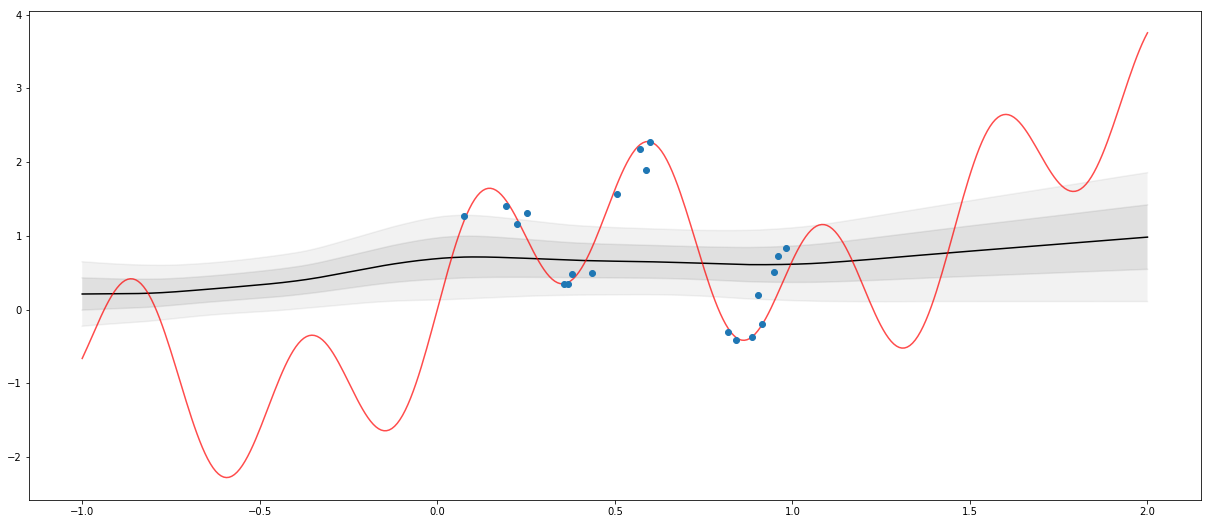

In [92]:
upper1 = np.mean(predictions[:,1:].detach().numpy(),1) + np.std(predictions[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions[:,1:].detach().numpy(),1) + 2 * np.std(predictions[:,1:].detach().numpy(),1)

lower1 = np.mean(predictions[:,1:].detach().numpy(),1) - np.std(predictions[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions[:,1:].detach().numpy(),1) - 2 * np.std(predictions[:,1:].detach().numpy(),1)


plt.figure(figsize=(21,9))
plt.plot(grid,np.mean(predictions[:,1:].detach().numpy(),1),'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.15)
plt.plot(grid,lower2,'gray',alpha=0.1)
plt.fill_between(grid,lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid,lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,y_true,'r',alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')



### pSGLD

In [93]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import psgld




if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

lambda_ = 1e-4
lr = 5e-7
alpha = 0.99


batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=True)

optim = psgld.optim.psgld(network, lr, lambda_, alpha, dataset_size)


predictions_psgld = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(2000):

    running_loss = 0

    
    network.zero_grad()
    output = network(x)
    loss = criterion(output, y)
    loss.backward()
    optim.step()



    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    if (t >= 300) & (t % 100 == 0):
        with torch.autograd.no_grad():
            output = network(x_test)
            predictions_psgld = torch.cat((predictions_psgld, output), 1)

    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

Epoch 0 - loss: 1.3647
Epoch 1 - loss: 328668.0938
Epoch 2 - loss: 274433.4062
Epoch 3 - loss: 42599.2852
Epoch 4 - loss: 15200.4609
Epoch 5 - loss: 44376.1797
Epoch 6 - loss: 44392.3867
Epoch 7 - loss: 49563.8320
Epoch 8 - loss: 49559.2461
Epoch 9 - loss: 49555.0156
Epoch 10 - loss: 49552.5117
Epoch 11 - loss: 49548.7422
Epoch 12 - loss: 49544.4922
Epoch 13 - loss: 49541.0117
Epoch 14 - loss: 49537.5352
Epoch 15 - loss: 49533.4336
Epoch 16 - loss: 49529.0703
Epoch 17 - loss: 49531.3477
Epoch 18 - loss: 49527.3398
Epoch 19 - loss: 49531.3203
Epoch 20 - loss: 49527.6641
Epoch 21 - loss: 49523.5977
Epoch 22 - loss: 49519.5391
Epoch 23 - loss: 49516.0898
Epoch 24 - loss: 49513.0586
Epoch 25 - loss: 49509.3984
Epoch 26 - loss: 49505.6328
Epoch 27 - loss: 49501.4102
Epoch 28 - loss: 49497.1523
Epoch 29 - loss: 49494.3594
Epoch 30 - loss: 49481.5273
Epoch 31 - loss: 49478.7578
Epoch 32 - loss: 49475.6992
Epoch 33 - loss: 49472.4961
Epoch 34 - loss: 49469.5000
Epoch 35 - loss: 49464.0703
Epoc

Epoch 306 - loss: 47532.7578
Epoch 307 - loss: 47528.5312
Epoch 308 - loss: 47524.5820
Epoch 309 - loss: 47521.1094
Epoch 310 - loss: 47517.3359
Epoch 311 - loss: 47513.8672
Epoch 312 - loss: 47510.3867
Epoch 313 - loss: 47505.6094
Epoch 314 - loss: 47501.3008
Epoch 315 - loss: 47497.3750
Epoch 316 - loss: 47493.7930
Epoch 317 - loss: 47489.6562
Epoch 318 - loss: 47485.6406
Epoch 319 - loss: 47480.9180
Epoch 320 - loss: 47477.5625
Epoch 321 - loss: 47473.2305
Epoch 322 - loss: 47469.8203
Epoch 323 - loss: 47466.5000
Epoch 324 - loss: 47461.4258
Epoch 325 - loss: 47457.4688
Epoch 326 - loss: 47453.8164
Epoch 327 - loss: 47449.8320
Epoch 328 - loss: 47445.2969
Epoch 329 - loss: 47441.2422
Epoch 330 - loss: 47437.3164
Epoch 331 - loss: 47432.8359
Epoch 332 - loss: 47429.9453
Epoch 333 - loss: 47425.0664
Epoch 334 - loss: 47420.7617
Epoch 335 - loss: 47416.3281
Epoch 336 - loss: 47413.3008
Epoch 337 - loss: 47409.7188
Epoch 338 - loss: 47405.8477
Epoch 339 - loss: 47401.9414
Epoch 340 - lo

Epoch 632 - loss: 46267.4609
Epoch 633 - loss: 46262.8320
Epoch 634 - loss: 46259.5664
Epoch 635 - loss: 46256.4141
Epoch 636 - loss: 46251.9727
Epoch 637 - loss: 46248.6914
Epoch 638 - loss: 46244.6016
Epoch 639 - loss: 46241.0781
Epoch 640 - loss: 46237.5078
Epoch 641 - loss: 46233.0117
Epoch 642 - loss: 46229.6641
Epoch 643 - loss: 46225.4023
Epoch 644 - loss: 46221.7734
Epoch 645 - loss: 46218.1172
Epoch 646 - loss: 46213.5078
Epoch 647 - loss: 46209.7617
Epoch 648 - loss: 46205.6289
Epoch 649 - loss: 46202.1914
Epoch 650 - loss: 46197.6992
Epoch 651 - loss: 46193.6328
Epoch 652 - loss: 46189.8711
Epoch 653 - loss: 46187.1016
Epoch 654 - loss: 46183.3945
Epoch 655 - loss: 46179.6719
Epoch 656 - loss: 46175.6641
Epoch 657 - loss: 46171.1250
Epoch 658 - loss: 46167.1328
Epoch 659 - loss: 46163.7148
Epoch 660 - loss: 46161.3672
Epoch 661 - loss: 46156.4141
Epoch 662 - loss: 46152.0391
Epoch 663 - loss: 46148.8281
Epoch 664 - loss: 46145.7656
Epoch 665 - loss: 46141.4414
Epoch 666 - lo

Epoch 986 - loss: 44896.5312
Epoch 987 - loss: 44892.3828
Epoch 988 - loss: 44888.6211
Epoch 989 - loss: 44885.3867
Epoch 990 - loss: 44880.6289
Epoch 991 - loss: 44876.3438
Epoch 992 - loss: 44873.0234
Epoch 993 - loss: 44869.0391
Epoch 994 - loss: 44865.1016
Epoch 995 - loss: 44860.8203
Epoch 996 - loss: 44857.0742
Epoch 997 - loss: 44852.2266
Epoch 998 - loss: 44848.7891
Epoch 999 - loss: 44844.9648
Epoch 1000 - loss: 44844.3945
Epoch 1001 - loss: 44843.8438
Epoch 1002 - loss: 44843.4648
Epoch 1003 - loss: 44843.1211
Epoch 1004 - loss: 44842.7891
Epoch 1005 - loss: 44842.4453
Epoch 1006 - loss: 44842.1719
Epoch 1007 - loss: 44841.5938
Epoch 1008 - loss: 44841.0391
Epoch 1009 - loss: 44840.6250
Epoch 1010 - loss: 44840.2422
Epoch 1011 - loss: 44839.8828
Epoch 1012 - loss: 44839.5547
Epoch 1013 - loss: 44839.2969
Epoch 1014 - loss: 44838.9609
Epoch 1015 - loss: 44838.7695
Epoch 1016 - loss: 44838.6914
Epoch 1017 - loss: 44838.3672
Epoch 1018 - loss: 44837.7617
Epoch 1019 - loss: 44837

Epoch 1318 - loss: 44730.0898
Epoch 1319 - loss: 44729.9258
Epoch 1320 - loss: 44729.5312
Epoch 1321 - loss: 44729.2070
Epoch 1322 - loss: 44729.0312
Epoch 1323 - loss: 44728.5859
Epoch 1324 - loss: 44728.0430
Epoch 1325 - loss: 44727.8086
Epoch 1326 - loss: 44727.4883
Epoch 1327 - loss: 44727.1211
Epoch 1328 - loss: 44726.6992
Epoch 1329 - loss: 44726.1211
Epoch 1330 - loss: 44726.0430
Epoch 1331 - loss: 44725.5195
Epoch 1332 - loss: 44725.2109
Epoch 1333 - loss: 44724.8555
Epoch 1334 - loss: 44724.4766
Epoch 1335 - loss: 44724.0547
Epoch 1336 - loss: 44723.6719
Epoch 1337 - loss: 44723.1406
Epoch 1338 - loss: 44722.6836
Epoch 1339 - loss: 44722.4883
Epoch 1340 - loss: 44722.3320
Epoch 1341 - loss: 44721.8906
Epoch 1342 - loss: 44721.5859
Epoch 1343 - loss: 44721.1016
Epoch 1344 - loss: 44720.8203
Epoch 1345 - loss: 44720.7734
Epoch 1346 - loss: 44720.3438
Epoch 1347 - loss: 44719.6172
Epoch 1348 - loss: 44719.5352
Epoch 1349 - loss: 44719.0781
Epoch 1350 - loss: 44718.4883
Epoch 1351

Epoch 1640 - loss: 44602.3086
Epoch 1641 - loss: 44602.0781
Epoch 1642 - loss: 44602.0195
Epoch 1643 - loss: 44601.9922
Epoch 1644 - loss: 44601.5430
Epoch 1645 - loss: 44601.1797
Epoch 1646 - loss: 44600.6211
Epoch 1647 - loss: 44600.0820
Epoch 1648 - loss: 44599.5742
Epoch 1649 - loss: 44599.1133
Epoch 1650 - loss: 44599.0078
Epoch 1651 - loss: 44598.6328
Epoch 1652 - loss: 44598.3984
Epoch 1653 - loss: 44598.2422
Epoch 1654 - loss: 44598.0000
Epoch 1655 - loss: 44597.6211
Epoch 1656 - loss: 44597.1641
Epoch 1657 - loss: 44597.1562
Epoch 1658 - loss: 44596.2188
Epoch 1659 - loss: 44595.8008
Epoch 1660 - loss: 44595.5742
Epoch 1661 - loss: 44595.0078
Epoch 1662 - loss: 44594.8828
Epoch 1663 - loss: 44594.7422
Epoch 1664 - loss: 44594.1797
Epoch 1665 - loss: 44593.6719
Epoch 1666 - loss: 44593.3203
Epoch 1667 - loss: 44593.0469
Epoch 1668 - loss: 44592.5859
Epoch 1669 - loss: 44592.1484
Epoch 1670 - loss: 44591.8672
Epoch 1671 - loss: 44591.2344
Epoch 1672 - loss: 44590.5898
Epoch 1673

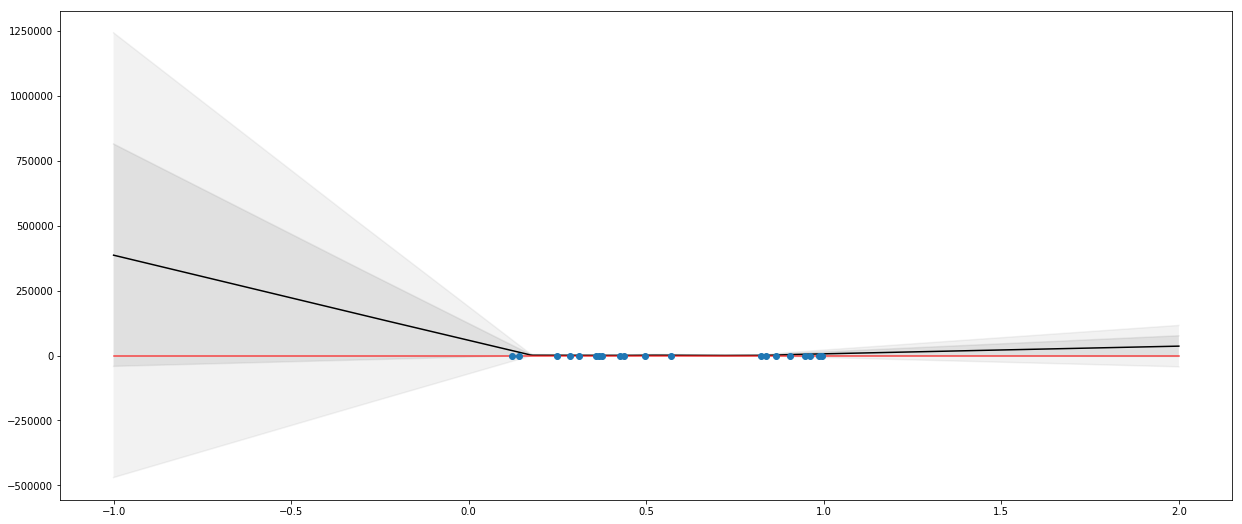

In [30]:
upper1 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) + np.std(predictions_psgld[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) + 2 * np.std(predictions_psgld[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) - np.std(predictions_psgld[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) - 2 * np.std(predictions_psgld[:,1:].detach().numpy(),1)

plt.figure(figsize=(21,9))
plt.plot(grid,np.mean(predictions_psgld[:,1:].detach().numpy(),1), 'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.12)
plt.plot(grid,lower2,'gray',alpha=0.1)
plt.fill_between(grid.squeeze(),lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid.squeeze(),lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,y_true,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')


### KSGFS

In [94]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgfs




if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

lambda_ = 1.
lr = 1e-4
alpha = 0.99


batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=True)

optim = ksgfs.optim.KSGFS(network, criterion, batch_size, dataset_size, eta=1., v=0., lambda_=1e-1, epsilon=0.01, l2=1e-3, invert_every=1)


predictions_sgld = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(20000):

    running_loss = 0
    
    optim.update_curvature(x)
    
    network.zero_grad()
    output = network(x)
    loss = criterion(output, y)
    loss.backward()
    optim.step()

    losses_sgld.append(loss)


    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    if (t >= 300) & (t % 100 == 0):
        with torch.autograd.no_grad():
            output = network(x_test)
            predictions_sgld = torch.cat((predictions_sgld, output), 1)

    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

Epoch 0 - loss: 1.5896
Epoch 1 - loss: 1.6261
Epoch 2 - loss: 1.6321
Epoch 3 - loss: 1.5364
Epoch 4 - loss: 1.4332
Epoch 5 - loss: 1.4114
Epoch 6 - loss: 1.4079
Epoch 7 - loss: 1.3702
Epoch 8 - loss: 1.2703
Epoch 9 - loss: 1.2954
Epoch 10 - loss: 1.2481
Epoch 11 - loss: 1.1800
Epoch 12 - loss: 1.1472
Epoch 13 - loss: 1.0980
Epoch 14 - loss: 1.1089
Epoch 15 - loss: 1.0776
Epoch 16 - loss: 1.0692
Epoch 17 - loss: 1.0365
Epoch 18 - loss: 0.9679
Epoch 19 - loss: 0.9988
Epoch 20 - loss: 1.0192
Epoch 21 - loss: 1.0211
Epoch 22 - loss: 1.0512
Epoch 23 - loss: 1.0137
Epoch 24 - loss: 0.9778
Epoch 25 - loss: 0.8756
Epoch 26 - loss: 0.8283
Epoch 27 - loss: 0.8150
Epoch 28 - loss: 0.7775
Epoch 29 - loss: 0.7824
Epoch 30 - loss: 0.7050
Epoch 31 - loss: 0.6735
Epoch 32 - loss: 0.7227
Epoch 33 - loss: 0.7273
Epoch 34 - loss: 0.7350
Epoch 35 - loss: 0.7515
Epoch 36 - loss: 0.7438
Epoch 37 - loss: 0.7222
Epoch 38 - loss: 0.6724
Epoch 39 - loss: 0.7139
Epoch 40 - loss: 0.7254
Epoch 41 - loss: 0.7094
Ep

Epoch 343 - loss: 0.1108
Epoch 344 - loss: 0.1077
Epoch 345 - loss: 0.1413
Epoch 346 - loss: 0.1498
Epoch 347 - loss: 0.1578
Epoch 348 - loss: 0.1553
Epoch 349 - loss: 0.1862
Epoch 350 - loss: 0.1786
Epoch 351 - loss: 0.1391
Epoch 352 - loss: 0.1484
Epoch 353 - loss: 0.1368
Epoch 354 - loss: 0.1123
Epoch 355 - loss: 0.1053
Epoch 356 - loss: 0.1267
Epoch 357 - loss: 0.1180
Epoch 358 - loss: 0.1606
Epoch 359 - loss: 0.1357
Epoch 360 - loss: 0.1634
Epoch 361 - loss: 0.1792
Epoch 362 - loss: 0.1848
Epoch 363 - loss: 0.1732
Epoch 364 - loss: 0.2221
Epoch 365 - loss: 0.2592
Epoch 366 - loss: 0.1796
Epoch 367 - loss: 0.1491
Epoch 368 - loss: 0.1597
Epoch 369 - loss: 0.1556
Epoch 370 - loss: 0.1815
Epoch 371 - loss: 0.1905
Epoch 372 - loss: 0.1417
Epoch 373 - loss: 0.1448
Epoch 374 - loss: 0.1500
Epoch 375 - loss: 0.1377
Epoch 376 - loss: 0.1440
Epoch 377 - loss: 0.1402
Epoch 378 - loss: 0.1311
Epoch 379 - loss: 0.1142
Epoch 380 - loss: 0.1057
Epoch 381 - loss: 0.1338
Epoch 382 - loss: 0.1533


Epoch 704 - loss: 0.1640
Epoch 705 - loss: 0.2091
Epoch 706 - loss: 0.2278
Epoch 707 - loss: 0.2386
Epoch 708 - loss: 0.1806
Epoch 709 - loss: 0.1204
Epoch 710 - loss: 0.0888
Epoch 711 - loss: 0.1020
Epoch 712 - loss: 0.1550
Epoch 713 - loss: 0.1462
Epoch 714 - loss: 0.1431
Epoch 715 - loss: 0.1615
Epoch 716 - loss: 0.2051
Epoch 717 - loss: 0.1651
Epoch 718 - loss: 0.1534
Epoch 719 - loss: 0.1399
Epoch 720 - loss: 0.1593
Epoch 721 - loss: 0.1427
Epoch 722 - loss: 0.1110
Epoch 723 - loss: 0.0946
Epoch 724 - loss: 0.0877
Epoch 725 - loss: 0.1070
Epoch 726 - loss: 0.1289
Epoch 727 - loss: 0.0859
Epoch 728 - loss: 0.0860
Epoch 729 - loss: 0.0822
Epoch 730 - loss: 0.1276
Epoch 731 - loss: 0.1448
Epoch 732 - loss: 0.1242
Epoch 733 - loss: 0.1111
Epoch 734 - loss: 0.1577
Epoch 735 - loss: 0.1646
Epoch 736 - loss: 0.1389
Epoch 737 - loss: 0.1605
Epoch 738 - loss: 0.1692
Epoch 739 - loss: 0.1815
Epoch 740 - loss: 0.1668
Epoch 741 - loss: 0.1846
Epoch 742 - loss: 0.1352
Epoch 743 - loss: 0.1235


Epoch 1037 - loss: 0.1657
Epoch 1038 - loss: 0.1787
Epoch 1039 - loss: 0.1233
Epoch 1040 - loss: 0.1220
Epoch 1041 - loss: 0.1031
Epoch 1042 - loss: 0.0680
Epoch 1043 - loss: 0.1010
Epoch 1044 - loss: 0.0972
Epoch 1045 - loss: 0.0940
Epoch 1046 - loss: 0.1311
Epoch 1047 - loss: 0.1365
Epoch 1048 - loss: 0.1640
Epoch 1049 - loss: 0.1660
Epoch 1050 - loss: 0.1767
Epoch 1051 - loss: 0.1130
Epoch 1052 - loss: 0.0839
Epoch 1053 - loss: 0.0965
Epoch 1054 - loss: 0.1683
Epoch 1055 - loss: 0.2108
Epoch 1056 - loss: 0.1510
Epoch 1057 - loss: 0.1441
Epoch 1058 - loss: 0.1311
Epoch 1059 - loss: 0.1075
Epoch 1060 - loss: 0.0993
Epoch 1061 - loss: 0.1425
Epoch 1062 - loss: 0.1517
Epoch 1063 - loss: 0.1453
Epoch 1064 - loss: 0.1964
Epoch 1065 - loss: 0.2029
Epoch 1066 - loss: 0.2956
Epoch 1067 - loss: 0.2312
Epoch 1068 - loss: 0.1409
Epoch 1069 - loss: 0.0909
Epoch 1070 - loss: 0.0890
Epoch 1071 - loss: 0.1084
Epoch 1072 - loss: 0.1148
Epoch 1073 - loss: 0.1230
Epoch 1074 - loss: 0.1169
Epoch 1075 -

Epoch 1387 - loss: 0.1562
Epoch 1388 - loss: 0.1272
Epoch 1389 - loss: 0.1029
Epoch 1390 - loss: 0.1538
Epoch 1391 - loss: 0.1135
Epoch 1392 - loss: 0.0968
Epoch 1393 - loss: 0.0825
Epoch 1394 - loss: 0.1051
Epoch 1395 - loss: 0.0814
Epoch 1396 - loss: 0.0524
Epoch 1397 - loss: 0.0798
Epoch 1398 - loss: 0.0722
Epoch 1399 - loss: 0.0865
Epoch 1400 - loss: 0.0931
Epoch 1401 - loss: 0.0934
Epoch 1402 - loss: 0.0997
Epoch 1403 - loss: 0.1297
Epoch 1404 - loss: 0.1634
Epoch 1405 - loss: 0.1958
Epoch 1406 - loss: 0.2579
Epoch 1407 - loss: 0.2009
Epoch 1408 - loss: 0.1658
Epoch 1409 - loss: 0.2006
Epoch 1410 - loss: 0.2542
Epoch 1411 - loss: 0.1529
Epoch 1412 - loss: 0.1378
Epoch 1413 - loss: 0.1042
Epoch 1414 - loss: 0.1582
Epoch 1415 - loss: 0.1002
Epoch 1416 - loss: 0.1102
Epoch 1417 - loss: 0.1318
Epoch 1418 - loss: 0.1441
Epoch 1419 - loss: 0.0945
Epoch 1420 - loss: 0.1377
Epoch 1421 - loss: 0.0830
Epoch 1422 - loss: 0.1094
Epoch 1423 - loss: 0.1175
Epoch 1424 - loss: 0.1230
Epoch 1425 -

Epoch 1718 - loss: 0.4871
Epoch 1719 - loss: 0.4805
Epoch 1720 - loss: 0.2899
Epoch 1721 - loss: 0.3804
Epoch 1722 - loss: 0.2239
Epoch 1723 - loss: 0.2439
Epoch 1724 - loss: 0.3646
Epoch 1725 - loss: 0.3268
Epoch 1726 - loss: 0.2773
Epoch 1727 - loss: 0.4258
Epoch 1728 - loss: 0.4306
Epoch 1729 - loss: 0.3198
Epoch 1730 - loss: 0.5111
Epoch 1731 - loss: 0.5662
Epoch 1732 - loss: 0.5023
Epoch 1733 - loss: 0.4972
Epoch 1734 - loss: 0.4725
Epoch 1735 - loss: 0.4293
Epoch 1736 - loss: 0.3031
Epoch 1737 - loss: 0.1750
Epoch 1738 - loss: 0.2185
Epoch 1739 - loss: 0.2520
Epoch 1740 - loss: 0.2383
Epoch 1741 - loss: 0.2243
Epoch 1742 - loss: 0.2150
Epoch 1743 - loss: 0.1560
Epoch 1744 - loss: 0.1822
Epoch 1745 - loss: 0.2517
Epoch 1746 - loss: 0.2301
Epoch 1747 - loss: 0.1332
Epoch 1748 - loss: 0.1016
Epoch 1749 - loss: 0.2836
Epoch 1750 - loss: 0.2467
Epoch 1751 - loss: 0.2183
Epoch 1752 - loss: 0.2855
Epoch 1753 - loss: 0.1968
Epoch 1754 - loss: 0.1662
Epoch 1755 - loss: 0.2611
Epoch 1756 -

Epoch 2064 - loss: 0.1395
Epoch 2065 - loss: 0.0864
Epoch 2066 - loss: 0.1266
Epoch 2067 - loss: 0.1624
Epoch 2068 - loss: 0.1474
Epoch 2069 - loss: 0.2855
Epoch 2070 - loss: 0.1720
Epoch 2071 - loss: 0.1932
Epoch 2072 - loss: 0.2286
Epoch 2073 - loss: 0.2743
Epoch 2074 - loss: 0.2183
Epoch 2075 - loss: 0.2399
Epoch 2076 - loss: 0.3841
Epoch 2077 - loss: 0.3429
Epoch 2078 - loss: 0.3950
Epoch 2079 - loss: 0.4041
Epoch 2080 - loss: 0.2599
Epoch 2081 - loss: 0.2637
Epoch 2082 - loss: 0.2403
Epoch 2083 - loss: 0.3031
Epoch 2084 - loss: 0.2003
Epoch 2085 - loss: 0.2237
Epoch 2086 - loss: 0.1300
Epoch 2087 - loss: 0.1745
Epoch 2088 - loss: 0.1957
Epoch 2089 - loss: 0.1278
Epoch 2090 - loss: 0.2005
Epoch 2091 - loss: 0.2514
Epoch 2092 - loss: 0.1955
Epoch 2093 - loss: 0.2467
Epoch 2094 - loss: 0.2155
Epoch 2095 - loss: 0.2853
Epoch 2096 - loss: 0.1374
Epoch 2097 - loss: 0.1740
Epoch 2098 - loss: 0.1377
Epoch 2099 - loss: 0.1217
Epoch 2100 - loss: 0.1130
Epoch 2101 - loss: 0.0954
Epoch 2102 -

Epoch 2411 - loss: 0.2219
Epoch 2412 - loss: 0.2460
Epoch 2413 - loss: 0.2296
Epoch 2414 - loss: 0.2175
Epoch 2415 - loss: 0.2337
Epoch 2416 - loss: 0.2893
Epoch 2417 - loss: 0.3039
Epoch 2418 - loss: 0.2475
Epoch 2419 - loss: 0.3143
Epoch 2420 - loss: 0.2462
Epoch 2421 - loss: 0.3123
Epoch 2422 - loss: 0.3046
Epoch 2423 - loss: 0.3615
Epoch 2424 - loss: 0.2129
Epoch 2425 - loss: 0.2335
Epoch 2426 - loss: 0.2082
Epoch 2427 - loss: 0.1733
Epoch 2428 - loss: 0.1927
Epoch 2429 - loss: 0.2133
Epoch 2430 - loss: 0.2331
Epoch 2431 - loss: 0.1633
Epoch 2432 - loss: 0.1715
Epoch 2433 - loss: 0.1672
Epoch 2434 - loss: 0.1476
Epoch 2435 - loss: 0.1536
Epoch 2436 - loss: 0.1437
Epoch 2437 - loss: 0.1298
Epoch 2438 - loss: 0.1291
Epoch 2439 - loss: 0.1635
Epoch 2440 - loss: 0.2040
Epoch 2441 - loss: 0.1597
Epoch 2442 - loss: 0.2095
Epoch 2443 - loss: 0.2302
Epoch 2444 - loss: 0.4028
Epoch 2445 - loss: 0.4025
Epoch 2446 - loss: 0.4157
Epoch 2447 - loss: 0.4460
Epoch 2448 - loss: 0.4855
Epoch 2449 -

Epoch 2752 - loss: 0.4408
Epoch 2753 - loss: 0.3852
Epoch 2754 - loss: 0.2504
Epoch 2755 - loss: 0.2786
Epoch 2756 - loss: 0.3842
Epoch 2757 - loss: 0.3902
Epoch 2758 - loss: 0.4658
Epoch 2759 - loss: 0.3644
Epoch 2760 - loss: 0.3353
Epoch 2761 - loss: 0.2792
Epoch 2762 - loss: 0.2720
Epoch 2763 - loss: 0.2348
Epoch 2764 - loss: 0.1673
Epoch 2765 - loss: 0.1648
Epoch 2766 - loss: 0.1786
Epoch 2767 - loss: 0.1158
Epoch 2768 - loss: 0.1171
Epoch 2769 - loss: 0.1164
Epoch 2770 - loss: 0.1349
Epoch 2771 - loss: 0.0974
Epoch 2772 - loss: 0.1390
Epoch 2773 - loss: 0.1500
Epoch 2774 - loss: 0.1777
Epoch 2775 - loss: 0.1569
Epoch 2776 - loss: 0.1623
Epoch 2777 - loss: 0.1734
Epoch 2778 - loss: 0.2457
Epoch 2779 - loss: 0.2664
Epoch 2780 - loss: 0.2503
Epoch 2781 - loss: 0.2450
Epoch 2782 - loss: 0.4238
Epoch 2783 - loss: 0.3264
Epoch 2784 - loss: 0.1576
Epoch 2785 - loss: 0.1169
Epoch 2786 - loss: 0.1098
Epoch 2787 - loss: 0.0931
Epoch 2788 - loss: 0.1482
Epoch 2789 - loss: 0.1896
Epoch 2790 -

Epoch 3108 - loss: 0.2072
Epoch 3109 - loss: 0.2257
Epoch 3110 - loss: 0.1762
Epoch 3111 - loss: 0.1847
Epoch 3112 - loss: 0.1613
Epoch 3113 - loss: 0.1025
Epoch 3114 - loss: 0.1336
Epoch 3115 - loss: 0.0768
Epoch 3116 - loss: 0.0842
Epoch 3117 - loss: 0.0787
Epoch 3118 - loss: 0.1175
Epoch 3119 - loss: 0.1759
Epoch 3120 - loss: 0.1759
Epoch 3121 - loss: 0.1516
Epoch 3122 - loss: 0.1240
Epoch 3123 - loss: 0.1835
Epoch 3124 - loss: 0.2066
Epoch 3125 - loss: 0.1901
Epoch 3126 - loss: 0.3077
Epoch 3127 - loss: 0.2571
Epoch 3128 - loss: 0.3023
Epoch 3129 - loss: 0.2778
Epoch 3130 - loss: 0.3324
Epoch 3131 - loss: 0.3159
Epoch 3132 - loss: 0.3083
Epoch 3133 - loss: 0.2147
Epoch 3134 - loss: 0.1973
Epoch 3135 - loss: 0.2365
Epoch 3136 - loss: 0.4202
Epoch 3137 - loss: 0.3669
Epoch 3138 - loss: 0.2615
Epoch 3139 - loss: 0.1783
Epoch 3140 - loss: 0.2275
Epoch 3141 - loss: 0.2552
Epoch 3142 - loss: 0.2277
Epoch 3143 - loss: 0.3005
Epoch 3144 - loss: 0.4548
Epoch 3145 - loss: 0.4214
Epoch 3146 -

Epoch 3439 - loss: 0.1545
Epoch 3440 - loss: 0.1100
Epoch 3441 - loss: 0.0907
Epoch 3442 - loss: 0.2669
Epoch 3443 - loss: 0.3921
Epoch 3444 - loss: 0.3244
Epoch 3445 - loss: 0.2414
Epoch 3446 - loss: 0.2114
Epoch 3447 - loss: 0.1354
Epoch 3448 - loss: 0.1383
Epoch 3449 - loss: 0.1006
Epoch 3450 - loss: 0.1742
Epoch 3451 - loss: 0.1795
Epoch 3452 - loss: 0.2466
Epoch 3453 - loss: 0.3283
Epoch 3454 - loss: 0.2819
Epoch 3455 - loss: 0.3150
Epoch 3456 - loss: 0.2338
Epoch 3457 - loss: 0.2342
Epoch 3458 - loss: 0.2638
Epoch 3459 - loss: 0.2206
Epoch 3460 - loss: 0.3915
Epoch 3461 - loss: 0.3642
Epoch 3462 - loss: 0.3244
Epoch 3463 - loss: 0.3825
Epoch 3464 - loss: 0.3487
Epoch 3465 - loss: 0.3767
Epoch 3466 - loss: 0.4853
Epoch 3467 - loss: 0.3410
Epoch 3468 - loss: 0.2317
Epoch 3469 - loss: 0.2047
Epoch 3470 - loss: 0.1607
Epoch 3471 - loss: 0.1788
Epoch 3472 - loss: 0.2105
Epoch 3473 - loss: 0.1488
Epoch 3474 - loss: 0.1610
Epoch 3475 - loss: 0.1313
Epoch 3476 - loss: 0.1681
Epoch 3477 -

Epoch 3773 - loss: 0.2917
Epoch 3774 - loss: 0.3936
Epoch 3775 - loss: 0.2718
Epoch 3776 - loss: 0.2564
Epoch 3777 - loss: 0.1521
Epoch 3778 - loss: 0.1905
Epoch 3779 - loss: 0.1869
Epoch 3780 - loss: 0.2736
Epoch 3781 - loss: 0.2951
Epoch 3782 - loss: 0.2869
Epoch 3783 - loss: 0.3089
Epoch 3784 - loss: 0.2873
Epoch 3785 - loss: 0.4571
Epoch 3786 - loss: 0.5359
Epoch 3787 - loss: 0.5168
Epoch 3788 - loss: 0.5312
Epoch 3789 - loss: 0.4615
Epoch 3790 - loss: 0.3684
Epoch 3791 - loss: 0.3999
Epoch 3792 - loss: 0.2282
Epoch 3793 - loss: 0.2322
Epoch 3794 - loss: 0.3459
Epoch 3795 - loss: 0.4278
Epoch 3796 - loss: 0.3063
Epoch 3797 - loss: 0.1643
Epoch 3798 - loss: 0.1402
Epoch 3799 - loss: 0.0704
Epoch 3800 - loss: 0.4648
Epoch 3801 - loss: 0.4193
Epoch 3802 - loss: 0.3391
Epoch 3803 - loss: 0.4380
Epoch 3804 - loss: 0.2330
Epoch 3805 - loss: 0.2634
Epoch 3806 - loss: 0.1752
Epoch 3807 - loss: 0.2449
Epoch 3808 - loss: 0.2687
Epoch 3809 - loss: 0.2580
Epoch 3810 - loss: 0.3458
Epoch 3811 -

Epoch 4104 - loss: 0.5409
Epoch 4105 - loss: 0.4646
Epoch 4106 - loss: 0.4595
Epoch 4107 - loss: 0.3959
Epoch 4108 - loss: 0.2306
Epoch 4109 - loss: 0.1721
Epoch 4110 - loss: 0.1621
Epoch 4111 - loss: 0.2088
Epoch 4112 - loss: 0.2288
Epoch 4113 - loss: 0.1553
Epoch 4114 - loss: 0.1686
Epoch 4115 - loss: 0.1712
Epoch 4116 - loss: 0.1735
Epoch 4117 - loss: 0.1755
Epoch 4118 - loss: 0.2323
Epoch 4119 - loss: 0.2055
Epoch 4120 - loss: 0.2016
Epoch 4121 - loss: 0.2130
Epoch 4122 - loss: 0.1577
Epoch 4123 - loss: 0.1906
Epoch 4124 - loss: 0.2086
Epoch 4125 - loss: 0.1930
Epoch 4126 - loss: 0.1783
Epoch 4127 - loss: 0.1859
Epoch 4128 - loss: 0.2490
Epoch 4129 - loss: 0.1836
Epoch 4130 - loss: 0.1711
Epoch 4131 - loss: 0.2527
Epoch 4132 - loss: 0.2473
Epoch 4133 - loss: 0.2278
Epoch 4134 - loss: 0.2497
Epoch 4135 - loss: 0.2874
Epoch 4136 - loss: 0.1495
Epoch 4137 - loss: 0.0879
Epoch 4138 - loss: 0.1544
Epoch 4139 - loss: 0.1226
Epoch 4140 - loss: 0.1042
Epoch 4141 - loss: 0.1053
Epoch 4142 -

Epoch 4437 - loss: 0.1350
Epoch 4438 - loss: 0.1559
Epoch 4439 - loss: 0.1228
Epoch 4440 - loss: 0.1051
Epoch 4441 - loss: 0.0911
Epoch 4442 - loss: 0.2141
Epoch 4443 - loss: 0.1183
Epoch 4444 - loss: 0.0729
Epoch 4445 - loss: 0.0578
Epoch 4446 - loss: 0.0688
Epoch 4447 - loss: 0.0971
Epoch 4448 - loss: 0.0621
Epoch 4449 - loss: 0.1163
Epoch 4450 - loss: 0.1608
Epoch 4451 - loss: 0.2055
Epoch 4452 - loss: 0.1562
Epoch 4453 - loss: 0.1306
Epoch 4454 - loss: 0.1754
Epoch 4455 - loss: 0.2258
Epoch 4456 - loss: 0.2970
Epoch 4457 - loss: 0.3595
Epoch 4458 - loss: 0.4580
Epoch 4459 - loss: 0.5119
Epoch 4460 - loss: 0.4716
Epoch 4461 - loss: 0.4592
Epoch 4462 - loss: 0.8281
Epoch 4463 - loss: 0.5862
Epoch 4464 - loss: 0.4165
Epoch 4465 - loss: 0.4340
Epoch 4466 - loss: 0.3550
Epoch 4467 - loss: 0.4093
Epoch 4468 - loss: 0.4790
Epoch 4469 - loss: 0.5844
Epoch 4470 - loss: 0.3972
Epoch 4471 - loss: 0.3626
Epoch 4472 - loss: 0.3901
Epoch 4473 - loss: 0.3979
Epoch 4474 - loss: 0.2383
Epoch 4475 -

Epoch 4759 - loss: 0.0989
Epoch 4760 - loss: 0.0973
Epoch 4761 - loss: 0.0860
Epoch 4762 - loss: 0.0551
Epoch 4763 - loss: 0.0900
Epoch 4764 - loss: 0.1068
Epoch 4765 - loss: 0.1109
Epoch 4766 - loss: 0.1581
Epoch 4767 - loss: 0.1924
Epoch 4768 - loss: 0.1083
Epoch 4769 - loss: 0.1180
Epoch 4770 - loss: 0.1142
Epoch 4771 - loss: 0.1563
Epoch 4772 - loss: 0.2044
Epoch 4773 - loss: 0.2162
Epoch 4774 - loss: 0.2883
Epoch 4775 - loss: 0.1993
Epoch 4776 - loss: 0.1790
Epoch 4777 - loss: 0.2251
Epoch 4778 - loss: 0.1341
Epoch 4779 - loss: 0.0944
Epoch 4780 - loss: 0.0651
Epoch 4781 - loss: 0.1079
Epoch 4782 - loss: 0.1008
Epoch 4783 - loss: 0.1211
Epoch 4784 - loss: 0.0868
Epoch 4785 - loss: 0.1023
Epoch 4786 - loss: 0.1094
Epoch 4787 - loss: 0.1005
Epoch 4788 - loss: 0.1085
Epoch 4789 - loss: 0.1292
Epoch 4790 - loss: 0.1691
Epoch 4791 - loss: 0.1224
Epoch 4792 - loss: 0.1630
Epoch 4793 - loss: 0.3068
Epoch 4794 - loss: 0.3298
Epoch 4795 - loss: 0.2880
Epoch 4796 - loss: 0.3714
Epoch 4797 -

Epoch 5094 - loss: 0.1954
Epoch 5095 - loss: 0.1863
Epoch 5096 - loss: 0.1586
Epoch 5097 - loss: 0.1512
Epoch 5098 - loss: 0.1462
Epoch 5099 - loss: 0.1458
Epoch 5100 - loss: 0.1026
Epoch 5101 - loss: 0.0916
Epoch 5102 - loss: 0.1109
Epoch 5103 - loss: 0.0670
Epoch 5104 - loss: 0.0787
Epoch 5105 - loss: 0.0842
Epoch 5106 - loss: 0.0987
Epoch 5107 - loss: 0.1245
Epoch 5108 - loss: 0.0829
Epoch 5109 - loss: 0.0598
Epoch 5110 - loss: 0.0428
Epoch 5111 - loss: 0.0297
Epoch 5112 - loss: 0.0587
Epoch 5113 - loss: 0.0612
Epoch 5114 - loss: 0.0685
Epoch 5115 - loss: 0.0551
Epoch 5116 - loss: 0.0591
Epoch 5117 - loss: 0.0597
Epoch 5118 - loss: 0.1234
Epoch 5119 - loss: 0.1834
Epoch 5120 - loss: 0.2650
Epoch 5121 - loss: 0.3444
Epoch 5122 - loss: 0.4308
Epoch 5123 - loss: 0.5259
Epoch 5124 - loss: 0.6138
Epoch 5125 - loss: 0.5750
Epoch 5126 - loss: 0.4778
Epoch 5127 - loss: 0.4271
Epoch 5128 - loss: 0.3831
Epoch 5129 - loss: 0.4204
Epoch 5130 - loss: 0.3607
Epoch 5131 - loss: 0.4894
Epoch 5132 -

Epoch 5428 - loss: 0.3006
Epoch 5429 - loss: 0.3177
Epoch 5430 - loss: 0.2537
Epoch 5431 - loss: 0.1826
Epoch 5432 - loss: 0.1274
Epoch 5433 - loss: 0.1362
Epoch 5434 - loss: 0.1968
Epoch 5435 - loss: 0.2426
Epoch 5436 - loss: 0.2001
Epoch 5437 - loss: 0.2679
Epoch 5438 - loss: 0.3718
Epoch 5439 - loss: 0.3620
Epoch 5440 - loss: 0.3138
Epoch 5441 - loss: 0.2817
Epoch 5442 - loss: 0.2574
Epoch 5443 - loss: 0.1804
Epoch 5444 - loss: 0.1821
Epoch 5445 - loss: 0.1989
Epoch 5446 - loss: 0.1983
Epoch 5447 - loss: 0.1500
Epoch 5448 - loss: 0.1397
Epoch 5449 - loss: 0.1071
Epoch 5450 - loss: 0.1865
Epoch 5451 - loss: 0.1213
Epoch 5452 - loss: 0.1236
Epoch 5453 - loss: 0.1246
Epoch 5454 - loss: 0.1450
Epoch 5455 - loss: 0.2570
Epoch 5456 - loss: 0.3395
Epoch 5457 - loss: 0.2835
Epoch 5458 - loss: 0.3429
Epoch 5459 - loss: 0.2560
Epoch 5460 - loss: 0.2043
Epoch 5461 - loss: 0.2138
Epoch 5462 - loss: 0.2481
Epoch 5463 - loss: 0.3289
Epoch 5464 - loss: 0.2651
Epoch 5465 - loss: 0.3198
Epoch 5466 -

Epoch 5776 - loss: 0.0869
Epoch 5777 - loss: 0.1838
Epoch 5778 - loss: 0.1738
Epoch 5779 - loss: 0.1650
Epoch 5780 - loss: 0.1435
Epoch 5781 - loss: 0.1397
Epoch 5782 - loss: 0.1708
Epoch 5783 - loss: 0.1985
Epoch 5784 - loss: 0.2417
Epoch 5785 - loss: 0.2108
Epoch 5786 - loss: 0.2347
Epoch 5787 - loss: 0.2552
Epoch 5788 - loss: 0.2076
Epoch 5789 - loss: 0.2427
Epoch 5790 - loss: 0.1945
Epoch 5791 - loss: 0.2447
Epoch 5792 - loss: 0.2527
Epoch 5793 - loss: 0.2149
Epoch 5794 - loss: 0.2668
Epoch 5795 - loss: 0.2249
Epoch 5796 - loss: 0.2455
Epoch 5797 - loss: 0.2846
Epoch 5798 - loss: 0.3630
Epoch 5799 - loss: 0.2157
Epoch 5800 - loss: 0.2072
Epoch 5801 - loss: 0.2210
Epoch 5802 - loss: 0.2015
Epoch 5803 - loss: 0.2066
Epoch 5804 - loss: 0.1966
Epoch 5805 - loss: 0.1770
Epoch 5806 - loss: 0.2197
Epoch 5807 - loss: 0.2339
Epoch 5808 - loss: 0.2667
Epoch 5809 - loss: 0.1938
Epoch 5810 - loss: 0.1776
Epoch 5811 - loss: 0.1615
Epoch 5812 - loss: 0.1848
Epoch 5813 - loss: 0.1619
Epoch 5814 -

Epoch 6111 - loss: 0.0839
Epoch 6112 - loss: 0.0978
Epoch 6113 - loss: 0.1364
Epoch 6114 - loss: 0.0889
Epoch 6115 - loss: 0.1251
Epoch 6116 - loss: 0.1386
Epoch 6117 - loss: 0.1674
Epoch 6118 - loss: 0.2156
Epoch 6119 - loss: 0.1387
Epoch 6120 - loss: 0.1162
Epoch 6121 - loss: 0.1522
Epoch 6122 - loss: 0.2234
Epoch 6123 - loss: 0.1799
Epoch 6124 - loss: 0.1766
Epoch 6125 - loss: 0.1934
Epoch 6126 - loss: 0.2384
Epoch 6127 - loss: 0.1916
Epoch 6128 - loss: 0.1346
Epoch 6129 - loss: 0.1185
Epoch 6130 - loss: 0.1359
Epoch 6131 - loss: 0.2167
Epoch 6132 - loss: 0.1291
Epoch 6133 - loss: 0.1143
Epoch 6134 - loss: 0.1405
Epoch 6135 - loss: 0.1702
Epoch 6136 - loss: 0.1651
Epoch 6137 - loss: 0.1919
Epoch 6138 - loss: 0.2097
Epoch 6139 - loss: 0.2226
Epoch 6140 - loss: 0.1523
Epoch 6141 - loss: 0.1200
Epoch 6142 - loss: 0.1156
Epoch 6143 - loss: 0.1023
Epoch 6144 - loss: 0.0876
Epoch 6145 - loss: 0.0763
Epoch 6146 - loss: 0.0613
Epoch 6147 - loss: 0.1112
Epoch 6148 - loss: 0.1029
Epoch 6149 -

Epoch 6442 - loss: 0.2286
Epoch 6443 - loss: 0.1765
Epoch 6444 - loss: 0.1621
Epoch 6445 - loss: 0.1608
Epoch 6446 - loss: 0.1524
Epoch 6447 - loss: 0.1955
Epoch 6448 - loss: 0.1737
Epoch 6449 - loss: 0.1756
Epoch 6450 - loss: 0.1969
Epoch 6451 - loss: 0.1840
Epoch 6452 - loss: 0.1621
Epoch 6453 - loss: 0.1482
Epoch 6454 - loss: 0.0873
Epoch 6455 - loss: 0.0965
Epoch 6456 - loss: 0.0615
Epoch 6457 - loss: 0.1182
Epoch 6458 - loss: 0.1192
Epoch 6459 - loss: 0.1410
Epoch 6460 - loss: 0.1038
Epoch 6461 - loss: 0.1499
Epoch 6462 - loss: 0.1161
Epoch 6463 - loss: 0.1633
Epoch 6464 - loss: 0.1075
Epoch 6465 - loss: 0.0988
Epoch 6466 - loss: 0.1037
Epoch 6467 - loss: 0.1224
Epoch 6468 - loss: 0.1407
Epoch 6469 - loss: 0.1659
Epoch 6470 - loss: 0.1378
Epoch 6471 - loss: 0.1635
Epoch 6472 - loss: 0.2325
Epoch 6473 - loss: 0.2294
Epoch 6474 - loss: 0.2206
Epoch 6475 - loss: 0.1718
Epoch 6476 - loss: 0.1476
Epoch 6477 - loss: 0.1601
Epoch 6478 - loss: 0.1008
Epoch 6479 - loss: 0.1455
Epoch 6480 -

Epoch 6800 - loss: 0.1476
Epoch 6801 - loss: 0.1331
Epoch 6802 - loss: 0.1302
Epoch 6803 - loss: 0.2025
Epoch 6804 - loss: 0.1805
Epoch 6805 - loss: 0.2096
Epoch 6806 - loss: 0.1099
Epoch 6807 - loss: 0.1178
Epoch 6808 - loss: 0.1218
Epoch 6809 - loss: 0.1401
Epoch 6810 - loss: 0.1715
Epoch 6811 - loss: 0.1414
Epoch 6812 - loss: 0.1187
Epoch 6813 - loss: 0.0976
Epoch 6814 - loss: 0.1575
Epoch 6815 - loss: 0.1607
Epoch 6816 - loss: 0.1341
Epoch 6817 - loss: 0.0543
Epoch 6818 - loss: 0.0814
Epoch 6819 - loss: 0.1518
Epoch 6820 - loss: 0.1945
Epoch 6821 - loss: 0.2309
Epoch 6822 - loss: 0.2303
Epoch 6823 - loss: 0.1762
Epoch 6824 - loss: 0.1106
Epoch 6825 - loss: 0.2297
Epoch 6826 - loss: 0.2151
Epoch 6827 - loss: 0.1806
Epoch 6828 - loss: 0.2302
Epoch 6829 - loss: 0.2869
Epoch 6830 - loss: 0.2963
Epoch 6831 - loss: 0.2567
Epoch 6832 - loss: 0.3742
Epoch 6833 - loss: 0.2997
Epoch 6834 - loss: 0.3031
Epoch 6835 - loss: 0.3649
Epoch 6836 - loss: 0.2576
Epoch 6837 - loss: 0.1721
Epoch 6838 -

Epoch 7128 - loss: 0.1653
Epoch 7129 - loss: 0.1222
Epoch 7130 - loss: 0.1249
Epoch 7131 - loss: 0.0951
Epoch 7132 - loss: 0.1482
Epoch 7133 - loss: 0.1344
Epoch 7134 - loss: 0.1002
Epoch 7135 - loss: 0.1191
Epoch 7136 - loss: 0.1308
Epoch 7137 - loss: 0.2273
Epoch 7138 - loss: 0.2934
Epoch 7139 - loss: 0.2715
Epoch 7140 - loss: 0.3974
Epoch 7141 - loss: 0.3382
Epoch 7142 - loss: 0.2005
Epoch 7143 - loss: 0.2931
Epoch 7144 - loss: 0.3515
Epoch 7145 - loss: 0.3767
Epoch 7146 - loss: 0.3265
Epoch 7147 - loss: 0.2109
Epoch 7148 - loss: 0.2121
Epoch 7149 - loss: 0.2074
Epoch 7150 - loss: 0.1449
Epoch 7151 - loss: 0.2029
Epoch 7152 - loss: 0.1472
Epoch 7153 - loss: 0.1009
Epoch 7154 - loss: 0.1074
Epoch 7155 - loss: 0.1956
Epoch 7156 - loss: 0.2054
Epoch 7157 - loss: 0.1357
Epoch 7158 - loss: 0.1298
Epoch 7159 - loss: 0.2160
Epoch 7160 - loss: 0.2799
Epoch 7161 - loss: 0.2391
Epoch 7162 - loss: 0.2740
Epoch 7163 - loss: 0.3617
Epoch 7164 - loss: 0.4076
Epoch 7165 - loss: 0.3819
Epoch 7166 -

Epoch 7479 - loss: 0.1756
Epoch 7480 - loss: 0.1823
Epoch 7481 - loss: 0.1775
Epoch 7482 - loss: 0.1862
Epoch 7483 - loss: 0.1614
Epoch 7484 - loss: 0.2264
Epoch 7485 - loss: 0.2207
Epoch 7486 - loss: 0.2090
Epoch 7487 - loss: 0.2028
Epoch 7488 - loss: 0.1239
Epoch 7489 - loss: 0.1342
Epoch 7490 - loss: 0.1752
Epoch 7491 - loss: 0.1477
Epoch 7492 - loss: 0.1851
Epoch 7493 - loss: 0.1799
Epoch 7494 - loss: 0.0894
Epoch 7495 - loss: 0.0863
Epoch 7496 - loss: 0.0737
Epoch 7497 - loss: 0.0901
Epoch 7498 - loss: 0.1626
Epoch 7499 - loss: 0.2756
Epoch 7500 - loss: 0.2453
Epoch 7501 - loss: 0.2640
Epoch 7502 - loss: 0.2499
Epoch 7503 - loss: 0.2306
Epoch 7504 - loss: 0.1795
Epoch 7505 - loss: 0.2812
Epoch 7506 - loss: 0.2258
Epoch 7507 - loss: 0.0915
Epoch 7508 - loss: 0.0924
Epoch 7509 - loss: 0.1647
Epoch 7510 - loss: 0.1597
Epoch 7511 - loss: 0.1175
Epoch 7512 - loss: 0.1559
Epoch 7513 - loss: 0.1949
Epoch 7514 - loss: 0.2397
Epoch 7515 - loss: 0.0832
Epoch 7516 - loss: 0.0896
Epoch 7517 -

Epoch 7821 - loss: 0.1679
Epoch 7822 - loss: 0.1064
Epoch 7823 - loss: 0.1218
Epoch 7824 - loss: 0.1021
Epoch 7825 - loss: 0.1100
Epoch 7826 - loss: 0.1417
Epoch 7827 - loss: 0.1281
Epoch 7828 - loss: 0.1416
Epoch 7829 - loss: 0.1299
Epoch 7830 - loss: 0.0856
Epoch 7831 - loss: 0.0920
Epoch 7832 - loss: 0.0721
Epoch 7833 - loss: 0.1051
Epoch 7834 - loss: 0.1542
Epoch 7835 - loss: 0.1566
Epoch 7836 - loss: 0.1471
Epoch 7837 - loss: 0.1069
Epoch 7838 - loss: 0.1053
Epoch 7839 - loss: 0.1082
Epoch 7840 - loss: 0.1394
Epoch 7841 - loss: 0.1265
Epoch 7842 - loss: 0.1626
Epoch 7843 - loss: 0.1667
Epoch 7844 - loss: 0.1512
Epoch 7845 - loss: 0.1680
Epoch 7846 - loss: 0.2132
Epoch 7847 - loss: 0.1847
Epoch 7848 - loss: 0.1241
Epoch 7849 - loss: 0.1264
Epoch 7850 - loss: 0.1199
Epoch 7851 - loss: 0.1625
Epoch 7852 - loss: 0.1637
Epoch 7853 - loss: 0.1459
Epoch 7854 - loss: 0.1400
Epoch 7855 - loss: 0.1752
Epoch 7856 - loss: 0.1835
Epoch 7857 - loss: 0.2187
Epoch 7858 - loss: 0.2606
Epoch 7859 -

Epoch 8143 - loss: 0.1371
Epoch 8144 - loss: 0.1380
Epoch 8145 - loss: 0.1062
Epoch 8146 - loss: 0.1191
Epoch 8147 - loss: 0.1408
Epoch 8148 - loss: 0.1434
Epoch 8149 - loss: 0.1795
Epoch 8150 - loss: 0.2599
Epoch 8151 - loss: 0.2528
Epoch 8152 - loss: 0.2785
Epoch 8153 - loss: 0.4327
Epoch 8154 - loss: 0.5241
Epoch 8155 - loss: 0.5908
Epoch 8156 - loss: 0.5934
Epoch 8157 - loss: 0.7008
Epoch 8158 - loss: 0.5978
Epoch 8159 - loss: 0.4310
Epoch 8160 - loss: 0.3977
Epoch 8161 - loss: 0.3323
Epoch 8162 - loss: 0.1995
Epoch 8163 - loss: 0.1441
Epoch 8164 - loss: 0.1042
Epoch 8165 - loss: 0.0973
Epoch 8166 - loss: 0.1471
Epoch 8167 - loss: 0.0669
Epoch 8168 - loss: 0.0680
Epoch 8169 - loss: 0.1000
Epoch 8170 - loss: 0.1032
Epoch 8171 - loss: 0.1403
Epoch 8172 - loss: 0.1193
Epoch 8173 - loss: 0.1350
Epoch 8174 - loss: 0.1178
Epoch 8175 - loss: 0.1410
Epoch 8176 - loss: 0.1204
Epoch 8177 - loss: 0.1060
Epoch 8178 - loss: 0.0913
Epoch 8179 - loss: 0.1542
Epoch 8180 - loss: 0.2164
Epoch 8181 -

Epoch 8459 - loss: 0.2274
Epoch 8460 - loss: 0.2112
Epoch 8461 - loss: 0.1960
Epoch 8462 - loss: 0.2400
Epoch 8463 - loss: 0.2325
Epoch 8464 - loss: 0.1646
Epoch 8465 - loss: 0.3509
Epoch 8466 - loss: 0.1364
Epoch 8467 - loss: 0.1199
Epoch 8468 - loss: 0.1039
Epoch 8469 - loss: 0.1635
Epoch 8470 - loss: 0.2921
Epoch 8471 - loss: 0.1201
Epoch 8472 - loss: 0.1299
Epoch 8473 - loss: 0.1453
Epoch 8474 - loss: 0.1993
Epoch 8475 - loss: 0.2744
Epoch 8476 - loss: 0.1709
Epoch 8477 - loss: 0.1381
Epoch 8478 - loss: 0.1331
Epoch 8479 - loss: 0.1402
Epoch 8480 - loss: 0.1127
Epoch 8481 - loss: 0.1257
Epoch 8482 - loss: 0.1235
Epoch 8483 - loss: 0.1514
Epoch 8484 - loss: 0.1306
Epoch 8485 - loss: 0.1688
Epoch 8486 - loss: 0.1564
Epoch 8487 - loss: 0.1361
Epoch 8488 - loss: 0.1062
Epoch 8489 - loss: 0.1235
Epoch 8490 - loss: 0.0970
Epoch 8491 - loss: 0.1143
Epoch 8492 - loss: 0.1637
Epoch 8493 - loss: 0.1990
Epoch 8494 - loss: 0.1427
Epoch 8495 - loss: 0.1050
Epoch 8496 - loss: 0.2273
Epoch 8497 -

Epoch 8819 - loss: 0.3227
Epoch 8820 - loss: 0.2689
Epoch 8821 - loss: 0.1886
Epoch 8822 - loss: 0.1438
Epoch 8823 - loss: 0.1408
Epoch 8824 - loss: 0.1661
Epoch 8825 - loss: 0.2398
Epoch 8826 - loss: 0.3215
Epoch 8827 - loss: 0.3064
Epoch 8828 - loss: 0.2929
Epoch 8829 - loss: 0.2534
Epoch 8830 - loss: 0.1850
Epoch 8831 - loss: 0.1514
Epoch 8832 - loss: 0.1642
Epoch 8833 - loss: 0.1949
Epoch 8834 - loss: 0.1254
Epoch 8835 - loss: 0.1239
Epoch 8836 - loss: 0.1316
Epoch 8837 - loss: 0.1110
Epoch 8838 - loss: 0.1262
Epoch 8839 - loss: 0.1167
Epoch 8840 - loss: 0.1549
Epoch 8841 - loss: 0.1493
Epoch 8842 - loss: 0.2128
Epoch 8843 - loss: 0.3172
Epoch 8844 - loss: 0.1842
Epoch 8845 - loss: 0.1075
Epoch 8846 - loss: 0.1590
Epoch 8847 - loss: 0.1516
Epoch 8848 - loss: 0.3882
Epoch 8849 - loss: 0.3853
Epoch 8850 - loss: 0.3532
Epoch 8851 - loss: 0.3025
Epoch 8852 - loss: 0.4020
Epoch 8853 - loss: 0.4148
Epoch 8854 - loss: 0.3971
Epoch 8855 - loss: 0.2726
Epoch 8856 - loss: 0.3157
Epoch 8857 -

Epoch 9178 - loss: 0.2092
Epoch 9179 - loss: 0.3454
Epoch 9180 - loss: 0.2544
Epoch 9181 - loss: 0.2388
Epoch 9182 - loss: 0.2503
Epoch 9183 - loss: 0.1483
Epoch 9184 - loss: 0.1821
Epoch 9185 - loss: 0.1551
Epoch 9186 - loss: 0.1245
Epoch 9187 - loss: 0.1025
Epoch 9188 - loss: 0.1199
Epoch 9189 - loss: 0.1496
Epoch 9190 - loss: 0.1852
Epoch 9191 - loss: 0.1325
Epoch 9192 - loss: 0.0796
Epoch 9193 - loss: 0.1296
Epoch 9194 - loss: 0.1174
Epoch 9195 - loss: 0.0872
Epoch 9196 - loss: 0.0759
Epoch 9197 - loss: 0.0553
Epoch 9198 - loss: 0.1138
Epoch 9199 - loss: 0.1907
Epoch 9200 - loss: 0.1594
Epoch 9201 - loss: 0.0763
Epoch 9202 - loss: 0.1281
Epoch 9203 - loss: 0.1144
Epoch 9204 - loss: 0.1094
Epoch 9205 - loss: 0.1316
Epoch 9206 - loss: 0.0775
Epoch 9207 - loss: 0.0856
Epoch 9208 - loss: 0.0620
Epoch 9209 - loss: 0.0640
Epoch 9210 - loss: 0.0805
Epoch 9211 - loss: 0.0805
Epoch 9212 - loss: 0.0884
Epoch 9213 - loss: 0.0628
Epoch 9214 - loss: 0.0762
Epoch 9215 - loss: 0.0678
Epoch 9216 -

Epoch 9541 - loss: 0.2526
Epoch 9542 - loss: 0.2678
Epoch 9543 - loss: 0.2208
Epoch 9544 - loss: 0.2659
Epoch 9545 - loss: 0.3138
Epoch 9546 - loss: 0.2102
Epoch 9547 - loss: 0.1647
Epoch 9548 - loss: 0.1980
Epoch 9549 - loss: 0.2262
Epoch 9550 - loss: 0.2651
Epoch 9551 - loss: 0.2577
Epoch 9552 - loss: 0.2406
Epoch 9553 - loss: 0.1678
Epoch 9554 - loss: 0.1797
Epoch 9555 - loss: 0.1918
Epoch 9556 - loss: 0.1756
Epoch 9557 - loss: 0.2119
Epoch 9558 - loss: 0.2730
Epoch 9559 - loss: 0.1464
Epoch 9560 - loss: 0.1205
Epoch 9561 - loss: 0.1540
Epoch 9562 - loss: 0.1199
Epoch 9563 - loss: 0.1259
Epoch 9564 - loss: 0.1200
Epoch 9565 - loss: 0.1837
Epoch 9566 - loss: 0.2717
Epoch 9567 - loss: 0.2232
Epoch 9568 - loss: 0.1754
Epoch 9569 - loss: 0.2062
Epoch 9570 - loss: 0.2977
Epoch 9571 - loss: 0.2453
Epoch 9572 - loss: 0.1771
Epoch 9573 - loss: 0.1619
Epoch 9574 - loss: 0.1787
Epoch 9575 - loss: 0.2341
Epoch 9576 - loss: 0.2462
Epoch 9577 - loss: 0.2929
Epoch 9578 - loss: 0.3147
Epoch 9579 -

Epoch 9867 - loss: 0.1984
Epoch 9868 - loss: 0.0998
Epoch 9869 - loss: 0.1190
Epoch 9870 - loss: 0.1199
Epoch 9871 - loss: 0.1376
Epoch 9872 - loss: 0.1029
Epoch 9873 - loss: 0.1585
Epoch 9874 - loss: 0.1503
Epoch 9875 - loss: 0.0873
Epoch 9876 - loss: 0.0896
Epoch 9877 - loss: 0.1124
Epoch 9878 - loss: 0.2378
Epoch 9879 - loss: 0.2825
Epoch 9880 - loss: 0.2337
Epoch 9881 - loss: 0.2047
Epoch 9882 - loss: 0.2432
Epoch 9883 - loss: 0.2611
Epoch 9884 - loss: 0.3756
Epoch 9885 - loss: 0.2404
Epoch 9886 - loss: 0.1992
Epoch 9887 - loss: 0.1658
Epoch 9888 - loss: 0.1926
Epoch 9889 - loss: 0.2034
Epoch 9890 - loss: 0.1854
Epoch 9891 - loss: 0.1834
Epoch 9892 - loss: 0.2058
Epoch 9893 - loss: 0.1607
Epoch 9894 - loss: 0.1993
Epoch 9895 - loss: 0.1342
Epoch 9896 - loss: 0.1378
Epoch 9897 - loss: 0.1938
Epoch 9898 - loss: 0.2107
Epoch 9899 - loss: 0.1925
Epoch 9900 - loss: 0.2456
Epoch 9901 - loss: 0.2539
Epoch 9902 - loss: 0.2671
Epoch 9903 - loss: 0.2383
Epoch 9904 - loss: 0.2088
Epoch 9905 -

Epoch 10222 - loss: 0.1849
Epoch 10223 - loss: 0.2784
Epoch 10224 - loss: 0.2293
Epoch 10225 - loss: 0.1970
Epoch 10226 - loss: 0.2871
Epoch 10227 - loss: 0.2856
Epoch 10228 - loss: 0.2935
Epoch 10229 - loss: 0.2828
Epoch 10230 - loss: 0.1959
Epoch 10231 - loss: 0.1347
Epoch 10232 - loss: 0.0832
Epoch 10233 - loss: 0.3134
Epoch 10234 - loss: 0.1353
Epoch 10235 - loss: 0.1768
Epoch 10236 - loss: 0.1728
Epoch 10237 - loss: 0.1467
Epoch 10238 - loss: 0.1096
Epoch 10239 - loss: 0.0418
Epoch 10240 - loss: 0.0889
Epoch 10241 - loss: 0.1054
Epoch 10242 - loss: 0.1775
Epoch 10243 - loss: 0.1580
Epoch 10244 - loss: 0.1626
Epoch 10245 - loss: 0.1303
Epoch 10246 - loss: 0.1608
Epoch 10247 - loss: 0.1285
Epoch 10248 - loss: 0.1056
Epoch 10249 - loss: 0.1549
Epoch 10250 - loss: 0.1871
Epoch 10251 - loss: 0.1920
Epoch 10252 - loss: 0.1791
Epoch 10253 - loss: 0.2979
Epoch 10254 - loss: 0.2132
Epoch 10255 - loss: 0.2025
Epoch 10256 - loss: 0.2329
Epoch 10257 - loss: 0.1858
Epoch 10258 - loss: 0.0978
E

Epoch 10556 - loss: 0.2183
Epoch 10557 - loss: 0.1310
Epoch 10558 - loss: 0.1137
Epoch 10559 - loss: 0.1322
Epoch 10560 - loss: 0.0757
Epoch 10561 - loss: 0.0772
Epoch 10562 - loss: 0.0584
Epoch 10563 - loss: 0.0734
Epoch 10564 - loss: 0.1341
Epoch 10565 - loss: 0.1579
Epoch 10566 - loss: 0.1571
Epoch 10567 - loss: 0.1723
Epoch 10568 - loss: 0.1255
Epoch 10569 - loss: 0.0825
Epoch 10570 - loss: 0.0741
Epoch 10571 - loss: 0.0512
Epoch 10572 - loss: 0.0737
Epoch 10573 - loss: 0.0762
Epoch 10574 - loss: 0.0714
Epoch 10575 - loss: 0.0749
Epoch 10576 - loss: 0.0698
Epoch 10577 - loss: 0.0993
Epoch 10578 - loss: 0.1443
Epoch 10579 - loss: 0.1218
Epoch 10580 - loss: 0.1029
Epoch 10581 - loss: 0.1171
Epoch 10582 - loss: 0.1415
Epoch 10583 - loss: 0.2736
Epoch 10584 - loss: 0.2692
Epoch 10585 - loss: 0.2359
Epoch 10586 - loss: 0.2306
Epoch 10587 - loss: 0.1314
Epoch 10588 - loss: 0.1618
Epoch 10589 - loss: 0.2304
Epoch 10590 - loss: 0.1897
Epoch 10591 - loss: 0.1078
Epoch 10592 - loss: 0.1163
E

Epoch 10875 - loss: 0.1233
Epoch 10876 - loss: 0.1425
Epoch 10877 - loss: 0.1292
Epoch 10878 - loss: 0.1208
Epoch 10879 - loss: 0.1639
Epoch 10880 - loss: 0.1670
Epoch 10881 - loss: 0.1440
Epoch 10882 - loss: 0.1536
Epoch 10883 - loss: 0.1192
Epoch 10884 - loss: 0.1385
Epoch 10885 - loss: 0.1449
Epoch 10886 - loss: 0.0986
Epoch 10887 - loss: 0.0879
Epoch 10888 - loss: 0.1340
Epoch 10889 - loss: 0.2469
Epoch 10890 - loss: 0.2199
Epoch 10891 - loss: 0.2142
Epoch 10892 - loss: 0.2030
Epoch 10893 - loss: 0.2495
Epoch 10894 - loss: 0.1882
Epoch 10895 - loss: 0.1656
Epoch 10896 - loss: 0.2414
Epoch 10897 - loss: 0.2301
Epoch 10898 - loss: 0.2598
Epoch 10899 - loss: 0.1814
Epoch 10900 - loss: 0.1669
Epoch 10901 - loss: 0.1784
Epoch 10902 - loss: 0.2013
Epoch 10903 - loss: 0.2483
Epoch 10904 - loss: 0.3142
Epoch 10905 - loss: 0.2984
Epoch 10906 - loss: 0.3493
Epoch 10907 - loss: 0.2753
Epoch 10908 - loss: 0.2780
Epoch 10909 - loss: 0.1790
Epoch 10910 - loss: 0.1817
Epoch 10911 - loss: 0.2545
E

Epoch 11197 - loss: 0.3538
Epoch 11198 - loss: 0.1670
Epoch 11199 - loss: 0.1424
Epoch 11200 - loss: 0.1278
Epoch 11201 - loss: 0.1313
Epoch 11202 - loss: 0.0729
Epoch 11203 - loss: 0.1321
Epoch 11204 - loss: 0.1861
Epoch 11205 - loss: 0.1224
Epoch 11206 - loss: 0.1138
Epoch 11207 - loss: 0.0746
Epoch 11208 - loss: 0.0761
Epoch 11209 - loss: 0.0471
Epoch 11210 - loss: 0.0714
Epoch 11211 - loss: 0.0666
Epoch 11212 - loss: 0.0911
Epoch 11213 - loss: 0.1276
Epoch 11214 - loss: 0.0932
Epoch 11215 - loss: 0.1006
Epoch 11216 - loss: 0.0969
Epoch 11217 - loss: 0.1126
Epoch 11218 - loss: 0.1152
Epoch 11219 - loss: 0.1789
Epoch 11220 - loss: 0.0968
Epoch 11221 - loss: 0.1306
Epoch 11222 - loss: 0.1485
Epoch 11223 - loss: 0.1756
Epoch 11224 - loss: 0.2450
Epoch 11225 - loss: 0.1929
Epoch 11226 - loss: 0.1666
Epoch 11227 - loss: 0.1691
Epoch 11228 - loss: 0.2168
Epoch 11229 - loss: 0.2334
Epoch 11230 - loss: 0.2385
Epoch 11231 - loss: 0.2681
Epoch 11232 - loss: 0.1991
Epoch 11233 - loss: 0.1572
E

Epoch 11519 - loss: 0.1691
Epoch 11520 - loss: 0.2135
Epoch 11521 - loss: 0.1434
Epoch 11522 - loss: 0.1357
Epoch 11523 - loss: 0.1620
Epoch 11524 - loss: 0.1738
Epoch 11525 - loss: 0.1701
Epoch 11526 - loss: 0.1368
Epoch 11527 - loss: 0.2707
Epoch 11528 - loss: 0.4044
Epoch 11529 - loss: 0.3751
Epoch 11530 - loss: 0.4636
Epoch 11531 - loss: 0.3954
Epoch 11532 - loss: 0.3505
Epoch 11533 - loss: 0.3340
Epoch 11534 - loss: 0.2435
Epoch 11535 - loss: 0.2797
Epoch 11536 - loss: 0.2561
Epoch 11537 - loss: 0.2695
Epoch 11538 - loss: 0.2093
Epoch 11539 - loss: 0.2238
Epoch 11540 - loss: 0.1956
Epoch 11541 - loss: 0.1810
Epoch 11542 - loss: 0.1400
Epoch 11543 - loss: 0.1571
Epoch 11544 - loss: 0.2054
Epoch 11545 - loss: 0.2988
Epoch 11546 - loss: 0.3238
Epoch 11547 - loss: 0.2535
Epoch 11548 - loss: 0.2977
Epoch 11549 - loss: 0.3372
Epoch 11550 - loss: 0.2816
Epoch 11551 - loss: 0.3009
Epoch 11552 - loss: 0.2457
Epoch 11553 - loss: 0.3905
Epoch 11554 - loss: 0.4476
Epoch 11555 - loss: 0.3010
E

Epoch 11875 - loss: 0.1965
Epoch 11876 - loss: 0.1461
Epoch 11877 - loss: 0.1847
Epoch 11878 - loss: 0.1077
Epoch 11879 - loss: 0.0753
Epoch 11880 - loss: 0.1368
Epoch 11881 - loss: 0.1264
Epoch 11882 - loss: 0.1649
Epoch 11883 - loss: 0.0947
Epoch 11884 - loss: 0.0830
Epoch 11885 - loss: 0.0784
Epoch 11886 - loss: 0.0924
Epoch 11887 - loss: 0.0616
Epoch 11888 - loss: 0.0446
Epoch 11889 - loss: 0.0646
Epoch 11890 - loss: 0.1038
Epoch 11891 - loss: 0.1024
Epoch 11892 - loss: 0.0893
Epoch 11893 - loss: 0.1309
Epoch 11894 - loss: 0.1577
Epoch 11895 - loss: 0.1647
Epoch 11896 - loss: 0.1680
Epoch 11897 - loss: 0.1982
Epoch 11898 - loss: 0.2312
Epoch 11899 - loss: 0.2019
Epoch 11900 - loss: 0.1972
Epoch 11901 - loss: 0.2750
Epoch 11902 - loss: 0.2062
Epoch 11903 - loss: 0.1843
Epoch 11904 - loss: 0.2026
Epoch 11905 - loss: 0.1828
Epoch 11906 - loss: 0.1951
Epoch 11907 - loss: 0.2592
Epoch 11908 - loss: 0.2148
Epoch 11909 - loss: 0.2928
Epoch 11910 - loss: 0.1759
Epoch 11911 - loss: 0.1511
E

Epoch 12203 - loss: 0.1230
Epoch 12204 - loss: 0.1175
Epoch 12205 - loss: 0.1018
Epoch 12206 - loss: 0.1377
Epoch 12207 - loss: 0.1307
Epoch 12208 - loss: 0.1426
Epoch 12209 - loss: 0.1361
Epoch 12210 - loss: 0.1777
Epoch 12211 - loss: 0.1616
Epoch 12212 - loss: 0.2220
Epoch 12213 - loss: 0.1927
Epoch 12214 - loss: 0.2525
Epoch 12215 - loss: 0.2263
Epoch 12216 - loss: 0.2199
Epoch 12217 - loss: 0.2196
Epoch 12218 - loss: 0.2499
Epoch 12219 - loss: 0.2811
Epoch 12220 - loss: 0.2143
Epoch 12221 - loss: 0.2303
Epoch 12222 - loss: 0.2286
Epoch 12223 - loss: 0.2024
Epoch 12224 - loss: 0.2596
Epoch 12225 - loss: 0.2611
Epoch 12226 - loss: 0.2228
Epoch 12227 - loss: 0.2413
Epoch 12228 - loss: 0.1734
Epoch 12229 - loss: 0.2296
Epoch 12230 - loss: 0.2889
Epoch 12231 - loss: 0.2535
Epoch 12232 - loss: 0.2147
Epoch 12233 - loss: 0.2773
Epoch 12234 - loss: 0.2017
Epoch 12235 - loss: 0.2295
Epoch 12236 - loss: 0.2113
Epoch 12237 - loss: 0.2395
Epoch 12238 - loss: 0.1989
Epoch 12239 - loss: 0.2067
E

Epoch 12508 - loss: 0.1033
Epoch 12509 - loss: 0.1164
Epoch 12510 - loss: 0.1317
Epoch 12511 - loss: 0.1599
Epoch 12512 - loss: 0.1911
Epoch 12513 - loss: 0.1447
Epoch 12514 - loss: 0.2303
Epoch 12515 - loss: 0.2771
Epoch 12516 - loss: 0.2659
Epoch 12517 - loss: 0.2010
Epoch 12518 - loss: 0.1838
Epoch 12519 - loss: 0.1699
Epoch 12520 - loss: 0.1387
Epoch 12521 - loss: 0.1175
Epoch 12522 - loss: 0.1381
Epoch 12523 - loss: 0.1419
Epoch 12524 - loss: 0.1189
Epoch 12525 - loss: 0.1162
Epoch 12526 - loss: 0.0976
Epoch 12527 - loss: 0.1057
Epoch 12528 - loss: 0.1343
Epoch 12529 - loss: 0.1459
Epoch 12530 - loss: 0.1459
Epoch 12531 - loss: 0.1763
Epoch 12532 - loss: 0.1462
Epoch 12533 - loss: 0.1483
Epoch 12534 - loss: 0.1526
Epoch 12535 - loss: 0.3450
Epoch 12536 - loss: 0.2785
Epoch 12537 - loss: 0.2066
Epoch 12538 - loss: 0.1409
Epoch 12539 - loss: 0.1358
Epoch 12540 - loss: 0.1492
Epoch 12541 - loss: 0.2134
Epoch 12542 - loss: 0.1799
Epoch 12543 - loss: 0.2247
Epoch 12544 - loss: 0.2222
E

Epoch 12818 - loss: 0.1748
Epoch 12819 - loss: 0.1766
Epoch 12820 - loss: 0.2129
Epoch 12821 - loss: 0.2758
Epoch 12822 - loss: 0.3563
Epoch 12823 - loss: 0.4345
Epoch 12824 - loss: 0.2813
Epoch 12825 - loss: 0.2086
Epoch 12826 - loss: 0.1480
Epoch 12827 - loss: 0.1994
Epoch 12828 - loss: 0.1994
Epoch 12829 - loss: 0.2251
Epoch 12830 - loss: 0.2071
Epoch 12831 - loss: 0.2083
Epoch 12832 - loss: 0.2017
Epoch 12833 - loss: 0.2410
Epoch 12834 - loss: 0.1936
Epoch 12835 - loss: 0.2373
Epoch 12836 - loss: 0.1865
Epoch 12837 - loss: 0.2476
Epoch 12838 - loss: 0.2176
Epoch 12839 - loss: 0.2316
Epoch 12840 - loss: 0.2434
Epoch 12841 - loss: 0.3052
Epoch 12842 - loss: 0.2840
Epoch 12843 - loss: 0.3357
Epoch 12844 - loss: 0.4696
Epoch 12845 - loss: 0.3037
Epoch 12846 - loss: 0.2999
Epoch 12847 - loss: 0.3024
Epoch 12848 - loss: 0.2903
Epoch 12849 - loss: 0.3274
Epoch 12850 - loss: 0.3324
Epoch 12851 - loss: 0.4202
Epoch 12852 - loss: 0.3884
Epoch 12853 - loss: 0.4505
Epoch 12854 - loss: 0.4184
E

Epoch 13144 - loss: 0.0602
Epoch 13145 - loss: 0.0578
Epoch 13146 - loss: 0.0338
Epoch 13147 - loss: 0.0542
Epoch 13148 - loss: 0.0814
Epoch 13149 - loss: 0.0998
Epoch 13150 - loss: 0.0952
Epoch 13151 - loss: 0.1185
Epoch 13152 - loss: 0.2519
Epoch 13153 - loss: 0.1328
Epoch 13154 - loss: 0.1914
Epoch 13155 - loss: 0.1845
Epoch 13156 - loss: 0.2078
Epoch 13157 - loss: 0.1784
Epoch 13158 - loss: 0.1285
Epoch 13159 - loss: 0.1369
Epoch 13160 - loss: 0.1396
Epoch 13161 - loss: 0.1361
Epoch 13162 - loss: 0.1314
Epoch 13163 - loss: 0.1646
Epoch 13164 - loss: 0.1190
Epoch 13165 - loss: 0.1427
Epoch 13166 - loss: 0.0824
Epoch 13167 - loss: 0.1398
Epoch 13168 - loss: 0.2462
Epoch 13169 - loss: 0.2140
Epoch 13170 - loss: 0.2409
Epoch 13171 - loss: 0.1963
Epoch 13172 - loss: 0.1540
Epoch 13173 - loss: 0.2876
Epoch 13174 - loss: 0.4696
Epoch 13175 - loss: 0.2854
Epoch 13176 - loss: 0.2817
Epoch 13177 - loss: 0.2060
Epoch 13178 - loss: 0.1508
Epoch 13179 - loss: 0.1469
Epoch 13180 - loss: 0.1699
E

Epoch 13470 - loss: 0.2713
Epoch 13471 - loss: 0.2058
Epoch 13472 - loss: 0.3868
Epoch 13473 - loss: 0.3548
Epoch 13474 - loss: 0.2699
Epoch 13475 - loss: 0.3355
Epoch 13476 - loss: 0.3018
Epoch 13477 - loss: 0.2278
Epoch 13478 - loss: 0.2371
Epoch 13479 - loss: 0.2130
Epoch 13480 - loss: 0.1520
Epoch 13481 - loss: 0.1708
Epoch 13482 - loss: 0.1692
Epoch 13483 - loss: 0.1236
Epoch 13484 - loss: 0.1045
Epoch 13485 - loss: 0.0778
Epoch 13486 - loss: 0.0631
Epoch 13487 - loss: 0.0489
Epoch 13488 - loss: 0.0939
Epoch 13489 - loss: 0.0811
Epoch 13490 - loss: 0.0611
Epoch 13491 - loss: 0.0604
Epoch 13492 - loss: 0.0586
Epoch 13493 - loss: 0.0615
Epoch 13494 - loss: 0.0661
Epoch 13495 - loss: 0.0883
Epoch 13496 - loss: 0.1447
Epoch 13497 - loss: 0.2343
Epoch 13498 - loss: 0.1934
Epoch 13499 - loss: 0.1658
Epoch 13500 - loss: 0.1747
Epoch 13501 - loss: 0.1993
Epoch 13502 - loss: 0.1771
Epoch 13503 - loss: 0.1753
Epoch 13504 - loss: 0.1489
Epoch 13505 - loss: 0.1306
Epoch 13506 - loss: 0.1782
E

Epoch 13785 - loss: 0.1846
Epoch 13786 - loss: 0.1577
Epoch 13787 - loss: 0.1542
Epoch 13788 - loss: 0.1138
Epoch 13789 - loss: 0.1327
Epoch 13790 - loss: 0.1274
Epoch 13791 - loss: 0.0944
Epoch 13792 - loss: 0.2047
Epoch 13793 - loss: 0.1362
Epoch 13794 - loss: 0.1327
Epoch 13795 - loss: 0.0900
Epoch 13796 - loss: 0.0790
Epoch 13797 - loss: 0.0866
Epoch 13798 - loss: 0.1385
Epoch 13799 - loss: 0.1661
Epoch 13800 - loss: 0.1197
Epoch 13801 - loss: 0.1392
Epoch 13802 - loss: 0.1497
Epoch 13803 - loss: 0.1059
Epoch 13804 - loss: 0.1594
Epoch 13805 - loss: 0.1237
Epoch 13806 - loss: 0.1202
Epoch 13807 - loss: 0.1114
Epoch 13808 - loss: 0.1326
Epoch 13809 - loss: 0.1153
Epoch 13810 - loss: 0.1861
Epoch 13811 - loss: 0.1496
Epoch 13812 - loss: 0.1706
Epoch 13813 - loss: 0.1642
Epoch 13814 - loss: 0.1653
Epoch 13815 - loss: 0.2795
Epoch 13816 - loss: 0.2825
Epoch 13817 - loss: 0.4285
Epoch 13818 - loss: 0.2997
Epoch 13819 - loss: 0.2440
Epoch 13820 - loss: 0.1887
Epoch 13821 - loss: 0.1454
E

Epoch 14112 - loss: 0.1209
Epoch 14113 - loss: 0.1232
Epoch 14114 - loss: 0.0872
Epoch 14115 - loss: 0.2224
Epoch 14116 - loss: 0.3635
Epoch 14117 - loss: 0.3552
Epoch 14118 - loss: 0.2134
Epoch 14119 - loss: 0.2683
Epoch 14120 - loss: 0.2510
Epoch 14121 - loss: 0.1392
Epoch 14122 - loss: 0.1297
Epoch 14123 - loss: 0.1922
Epoch 14124 - loss: 0.2456
Epoch 14125 - loss: 0.2136
Epoch 14126 - loss: 0.2044
Epoch 14127 - loss: 0.2929
Epoch 14128 - loss: 0.3231
Epoch 14129 - loss: 0.2108
Epoch 14130 - loss: 0.1892
Epoch 14131 - loss: 0.2627
Epoch 14132 - loss: 0.3193
Epoch 14133 - loss: 0.3648
Epoch 14134 - loss: 0.2614
Epoch 14135 - loss: 0.3517
Epoch 14136 - loss: 0.2863
Epoch 14137 - loss: 0.3258
Epoch 14138 - loss: 0.3407
Epoch 14139 - loss: 0.3456
Epoch 14140 - loss: 0.2818
Epoch 14141 - loss: 0.2704
Epoch 14142 - loss: 0.2621
Epoch 14143 - loss: 0.2220
Epoch 14144 - loss: 0.5228
Epoch 14145 - loss: 0.3942
Epoch 14146 - loss: 0.4214
Epoch 14147 - loss: 0.3674
Epoch 14148 - loss: 0.3266
E

Epoch 14422 - loss: 0.2351
Epoch 14423 - loss: 0.2319
Epoch 14424 - loss: 0.2108
Epoch 14425 - loss: 0.2811
Epoch 14426 - loss: 0.2606
Epoch 14427 - loss: 0.3990
Epoch 14428 - loss: 0.3209
Epoch 14429 - loss: 0.3950
Epoch 14430 - loss: 0.4147
Epoch 14431 - loss: 0.4075
Epoch 14432 - loss: 0.3342
Epoch 14433 - loss: 0.3786
Epoch 14434 - loss: 0.3572
Epoch 14435 - loss: 0.2288
Epoch 14436 - loss: 0.2158
Epoch 14437 - loss: 0.1987
Epoch 14438 - loss: 0.1059
Epoch 14439 - loss: 0.0899
Epoch 14440 - loss: 0.0974
Epoch 14441 - loss: 0.1069
Epoch 14442 - loss: 0.1436
Epoch 14443 - loss: 0.1272
Epoch 14444 - loss: 0.1160
Epoch 14445 - loss: 0.1732
Epoch 14446 - loss: 0.2033
Epoch 14447 - loss: 0.2859
Epoch 14448 - loss: 0.3525
Epoch 14449 - loss: 0.4853
Epoch 14450 - loss: 0.3469
Epoch 14451 - loss: 0.4243
Epoch 14452 - loss: 0.3300
Epoch 14453 - loss: 0.3032
Epoch 14454 - loss: 0.2429
Epoch 14455 - loss: 0.3348
Epoch 14456 - loss: 0.3424
Epoch 14457 - loss: 0.2067
Epoch 14458 - loss: 0.2343
E

Epoch 14740 - loss: 0.4318
Epoch 14741 - loss: 0.3111
Epoch 14742 - loss: 0.2645
Epoch 14743 - loss: 0.2930
Epoch 14744 - loss: 0.2843
Epoch 14745 - loss: 0.2716
Epoch 14746 - loss: 0.2868
Epoch 14747 - loss: 0.2608
Epoch 14748 - loss: 0.2592
Epoch 14749 - loss: 0.2225
Epoch 14750 - loss: 0.1980
Epoch 14751 - loss: 0.1995
Epoch 14752 - loss: 0.1767
Epoch 14753 - loss: 0.2696
Epoch 14754 - loss: 0.3188
Epoch 14755 - loss: 0.3009
Epoch 14756 - loss: 0.2091
Epoch 14757 - loss: 0.2988
Epoch 14758 - loss: 0.3867
Epoch 14759 - loss: 0.3744
Epoch 14760 - loss: 0.3864
Epoch 14761 - loss: 0.2772
Epoch 14762 - loss: 0.3265
Epoch 14763 - loss: 0.2863
Epoch 14764 - loss: 0.3262
Epoch 14765 - loss: 0.2666
Epoch 14766 - loss: 0.2300
Epoch 14767 - loss: 0.2860
Epoch 14768 - loss: 0.2022
Epoch 14769 - loss: 0.1278
Epoch 14770 - loss: 0.1818
Epoch 14771 - loss: 0.1884
Epoch 14772 - loss: 0.2301
Epoch 14773 - loss: 0.2396
Epoch 14774 - loss: 0.5230
Epoch 14775 - loss: 0.5169
Epoch 14776 - loss: 0.2558
E

Epoch 15051 - loss: 0.1799
Epoch 15052 - loss: 0.1173
Epoch 15053 - loss: 0.1414
Epoch 15054 - loss: 0.1267
Epoch 15055 - loss: 0.1285
Epoch 15056 - loss: 0.1363
Epoch 15057 - loss: 0.0727
Epoch 15058 - loss: 0.0752
Epoch 15059 - loss: 0.0928
Epoch 15060 - loss: 0.0738
Epoch 15061 - loss: 0.0558
Epoch 15062 - loss: 0.0631
Epoch 15063 - loss: 0.1117
Epoch 15064 - loss: 0.1176
Epoch 15065 - loss: 0.0960
Epoch 15066 - loss: 0.1070
Epoch 15067 - loss: 0.0605
Epoch 15068 - loss: 0.0619
Epoch 15069 - loss: 0.1132
Epoch 15070 - loss: 0.2551
Epoch 15071 - loss: 0.3030
Epoch 15072 - loss: 0.2331
Epoch 15073 - loss: 0.2137
Epoch 15074 - loss: 0.2474
Epoch 15075 - loss: 0.2579
Epoch 15076 - loss: 0.2123
Epoch 15077 - loss: 0.1879
Epoch 15078 - loss: 0.1848
Epoch 15079 - loss: 0.1216
Epoch 15080 - loss: 0.1038
Epoch 15081 - loss: 0.1681
Epoch 15082 - loss: 0.1482
Epoch 15083 - loss: 0.3328
Epoch 15084 - loss: 0.4930
Epoch 15085 - loss: 0.6002
Epoch 15086 - loss: 0.5180
Epoch 15087 - loss: 0.4870
E

Epoch 15365 - loss: 0.1909
Epoch 15366 - loss: 0.1694
Epoch 15367 - loss: 0.1339
Epoch 15368 - loss: 0.1487
Epoch 15369 - loss: 0.2002
Epoch 15370 - loss: 0.1928
Epoch 15371 - loss: 0.2069
Epoch 15372 - loss: 0.2256
Epoch 15373 - loss: 0.1619
Epoch 15374 - loss: 0.2088
Epoch 15375 - loss: 0.2744
Epoch 15376 - loss: 0.2651
Epoch 15377 - loss: 0.2139
Epoch 15378 - loss: 0.1190
Epoch 15379 - loss: 0.1194
Epoch 15380 - loss: 0.0888
Epoch 15381 - loss: 0.0886
Epoch 15382 - loss: 0.0876
Epoch 15383 - loss: 0.1414
Epoch 15384 - loss: 0.1845
Epoch 15385 - loss: 0.2476
Epoch 15386 - loss: 0.2035
Epoch 15387 - loss: 0.1758
Epoch 15388 - loss: 0.1889
Epoch 15389 - loss: 0.2235
Epoch 15390 - loss: 0.2005
Epoch 15391 - loss: 0.2131
Epoch 15392 - loss: 0.2548
Epoch 15393 - loss: 0.1988
Epoch 15394 - loss: 0.1641
Epoch 15395 - loss: 0.2076
Epoch 15396 - loss: 0.1788
Epoch 15397 - loss: 0.1607
Epoch 15398 - loss: 0.2890
Epoch 15399 - loss: 0.3072
Epoch 15400 - loss: 0.2232
Epoch 15401 - loss: 0.1817
E

Epoch 15672 - loss: 0.2533
Epoch 15673 - loss: 0.2024
Epoch 15674 - loss: 0.1861
Epoch 15675 - loss: 0.1949
Epoch 15676 - loss: 0.1908
Epoch 15677 - loss: 0.1744
Epoch 15678 - loss: 0.2727
Epoch 15679 - loss: 0.2607
Epoch 15680 - loss: 0.1717
Epoch 15681 - loss: 0.1712
Epoch 15682 - loss: 0.1605
Epoch 15683 - loss: 0.1497
Epoch 15684 - loss: 0.1568
Epoch 15685 - loss: 0.1292
Epoch 15686 - loss: 0.0761
Epoch 15687 - loss: 0.0963
Epoch 15688 - loss: 0.1538
Epoch 15689 - loss: 0.1571
Epoch 15690 - loss: 0.1355
Epoch 15691 - loss: 0.1357
Epoch 15692 - loss: 0.1629
Epoch 15693 - loss: 0.1403
Epoch 15694 - loss: 0.1063
Epoch 15695 - loss: 0.0811
Epoch 15696 - loss: 0.1100
Epoch 15697 - loss: 0.2434
Epoch 15698 - loss: 0.3447
Epoch 15699 - loss: 0.3416
Epoch 15700 - loss: 0.2148
Epoch 15701 - loss: 0.1687
Epoch 15702 - loss: 0.1987
Epoch 15703 - loss: 0.2002
Epoch 15704 - loss: 0.1884
Epoch 15705 - loss: 0.1953
Epoch 15706 - loss: 0.0846
Epoch 15707 - loss: 0.1122
Epoch 15708 - loss: 0.1293
E

Epoch 15989 - loss: 0.0662
Epoch 15990 - loss: 0.1150
Epoch 15991 - loss: 0.1029
Epoch 15992 - loss: 0.0855
Epoch 15993 - loss: 0.1305
Epoch 15994 - loss: 0.1337
Epoch 15995 - loss: 0.1478
Epoch 15996 - loss: 0.1306
Epoch 15997 - loss: 0.0893
Epoch 15998 - loss: 0.1047
Epoch 15999 - loss: 0.0601
Epoch 16000 - loss: 0.0897
Epoch 16001 - loss: 0.3035
Epoch 16002 - loss: 0.4354
Epoch 16003 - loss: 0.4033
Epoch 16004 - loss: 0.3008
Epoch 16005 - loss: 0.1625
Epoch 16006 - loss: 0.1665
Epoch 16007 - loss: 0.2059
Epoch 16008 - loss: 0.1422
Epoch 16009 - loss: 0.1352
Epoch 16010 - loss: 0.1323
Epoch 16011 - loss: 0.1291
Epoch 16012 - loss: 0.0825
Epoch 16013 - loss: 0.0731
Epoch 16014 - loss: 0.0875
Epoch 16015 - loss: 0.0908
Epoch 16016 - loss: 0.0810
Epoch 16017 - loss: 0.1278
Epoch 16018 - loss: 0.1407
Epoch 16019 - loss: 0.1154
Epoch 16020 - loss: 0.0784
Epoch 16021 - loss: 0.0792
Epoch 16022 - loss: 0.0919
Epoch 16023 - loss: 0.0459
Epoch 16024 - loss: 0.0602
Epoch 16025 - loss: 0.1683
E

Epoch 16334 - loss: 0.3970
Epoch 16335 - loss: 0.1791
Epoch 16336 - loss: 0.2005
Epoch 16337 - loss: 0.1792
Epoch 16338 - loss: 0.1680
Epoch 16339 - loss: 0.1698
Epoch 16340 - loss: 0.1707
Epoch 16341 - loss: 0.1522
Epoch 16342 - loss: 0.2125
Epoch 16343 - loss: 0.2303
Epoch 16344 - loss: 0.2801
Epoch 16345 - loss: 0.2856
Epoch 16346 - loss: 0.2364
Epoch 16347 - loss: 0.2221
Epoch 16348 - loss: 0.2443
Epoch 16349 - loss: 0.2366
Epoch 16350 - loss: 0.2089
Epoch 16351 - loss: 0.2031
Epoch 16352 - loss: 0.1356
Epoch 16353 - loss: 0.1332
Epoch 16354 - loss: 0.1311
Epoch 16355 - loss: 0.1474
Epoch 16356 - loss: 0.1499
Epoch 16357 - loss: 0.1286
Epoch 16358 - loss: 0.0967
Epoch 16359 - loss: 0.0867
Epoch 16360 - loss: 0.0719
Epoch 16361 - loss: 0.0853
Epoch 16362 - loss: 0.0480
Epoch 16363 - loss: 0.0408
Epoch 16364 - loss: 0.1352
Epoch 16365 - loss: 0.1288
Epoch 16366 - loss: 0.1360
Epoch 16367 - loss: 0.1169
Epoch 16368 - loss: 0.1499
Epoch 16369 - loss: 0.1544
Epoch 16370 - loss: 0.1332
E

Epoch 16668 - loss: 0.1643
Epoch 16669 - loss: 0.1853
Epoch 16670 - loss: 0.1242
Epoch 16671 - loss: 0.1264
Epoch 16672 - loss: 0.0942
Epoch 16673 - loss: 0.1180
Epoch 16674 - loss: 0.0952
Epoch 16675 - loss: 0.0609
Epoch 16676 - loss: 0.0794
Epoch 16677 - loss: 0.1346
Epoch 16678 - loss: 0.1095
Epoch 16679 - loss: 0.1298
Epoch 16680 - loss: 0.1302
Epoch 16681 - loss: 0.1494
Epoch 16682 - loss: 0.1626
Epoch 16683 - loss: 0.1766
Epoch 16684 - loss: 0.1586
Epoch 16685 - loss: 0.1660
Epoch 16686 - loss: 0.1760
Epoch 16687 - loss: 0.2730
Epoch 16688 - loss: 0.2955
Epoch 16689 - loss: 0.2563
Epoch 16690 - loss: 0.2836
Epoch 16691 - loss: 0.3235
Epoch 16692 - loss: 0.3005
Epoch 16693 - loss: 0.3123
Epoch 16694 - loss: 0.3543
Epoch 16695 - loss: 0.2750
Epoch 16696 - loss: 0.3137
Epoch 16697 - loss: 0.4137
Epoch 16698 - loss: 0.4026
Epoch 16699 - loss: 0.3353
Epoch 16700 - loss: 0.3604
Epoch 16701 - loss: 0.3797
Epoch 16702 - loss: 0.2159
Epoch 16703 - loss: 0.2116
Epoch 16704 - loss: 0.1531
E

Epoch 16986 - loss: 0.1285
Epoch 16987 - loss: 0.1316
Epoch 16988 - loss: 0.1151
Epoch 16989 - loss: 0.1055
Epoch 16990 - loss: 0.1326
Epoch 16991 - loss: 0.1252
Epoch 16992 - loss: 0.1211
Epoch 16993 - loss: 0.1042
Epoch 16994 - loss: 0.1010
Epoch 16995 - loss: 0.0659
Epoch 16996 - loss: 0.0392
Epoch 16997 - loss: 0.0908
Epoch 16998 - loss: 0.0940
Epoch 16999 - loss: 0.0926
Epoch 17000 - loss: 0.1326
Epoch 17001 - loss: 0.1426
Epoch 17002 - loss: 0.1307
Epoch 17003 - loss: 0.1019
Epoch 17004 - loss: 0.1086
Epoch 17005 - loss: 0.1221
Epoch 17006 - loss: 0.1361
Epoch 17007 - loss: 0.1412
Epoch 17008 - loss: 0.0955
Epoch 17009 - loss: 0.1029
Epoch 17010 - loss: 0.0619
Epoch 17011 - loss: 0.0637
Epoch 17012 - loss: 0.0537
Epoch 17013 - loss: 0.1084
Epoch 17014 - loss: 0.0965
Epoch 17015 - loss: 0.1613
Epoch 17016 - loss: 0.2241
Epoch 17017 - loss: 0.1168
Epoch 17018 - loss: 0.1460
Epoch 17019 - loss: 0.1593
Epoch 17020 - loss: 0.1373
Epoch 17021 - loss: 0.1337
Epoch 17022 - loss: 0.1712
E

Epoch 17311 - loss: 0.2107
Epoch 17312 - loss: 0.1716
Epoch 17313 - loss: 0.1715
Epoch 17314 - loss: 0.2116
Epoch 17315 - loss: 0.2293
Epoch 17316 - loss: 0.1770
Epoch 17317 - loss: 0.1626
Epoch 17318 - loss: 0.1500
Epoch 17319 - loss: 0.2329
Epoch 17320 - loss: 0.2643
Epoch 17321 - loss: 0.2988
Epoch 17322 - loss: 0.2522
Epoch 17323 - loss: 0.1406
Epoch 17324 - loss: 0.1830
Epoch 17325 - loss: 0.1815
Epoch 17326 - loss: 0.1769
Epoch 17327 - loss: 0.1284
Epoch 17328 - loss: 0.2166
Epoch 17329 - loss: 0.1249
Epoch 17330 - loss: 0.1304
Epoch 17331 - loss: 0.1050
Epoch 17332 - loss: 0.0965
Epoch 17333 - loss: 0.0908
Epoch 17334 - loss: 0.1236
Epoch 17335 - loss: 0.0896
Epoch 17336 - loss: 0.1551
Epoch 17337 - loss: 0.1507
Epoch 17338 - loss: 0.2430
Epoch 17339 - loss: 0.2529
Epoch 17340 - loss: 0.2662
Epoch 17341 - loss: 0.2715
Epoch 17342 - loss: 0.3194
Epoch 17343 - loss: 0.4400
Epoch 17344 - loss: 0.4261
Epoch 17345 - loss: 0.3619
Epoch 17346 - loss: 0.2964
Epoch 17347 - loss: 0.2561
E

Epoch 17619 - loss: 0.1875
Epoch 17620 - loss: 0.1874
Epoch 17621 - loss: 0.1720
Epoch 17622 - loss: 0.1814
Epoch 17623 - loss: 0.1293
Epoch 17624 - loss: 0.1823
Epoch 17625 - loss: 0.1757
Epoch 17626 - loss: 0.1561
Epoch 17627 - loss: 0.1723
Epoch 17628 - loss: 0.1610
Epoch 17629 - loss: 0.1791
Epoch 17630 - loss: 0.2254
Epoch 17631 - loss: 0.1661
Epoch 17632 - loss: 0.2608
Epoch 17633 - loss: 0.3233
Epoch 17634 - loss: 0.2630
Epoch 17635 - loss: 0.2974
Epoch 17636 - loss: 0.3040
Epoch 17637 - loss: 0.3467
Epoch 17638 - loss: 0.2325
Epoch 17639 - loss: 0.2161
Epoch 17640 - loss: 0.2536
Epoch 17641 - loss: 0.1751
Epoch 17642 - loss: 0.2029
Epoch 17643 - loss: 0.2440
Epoch 17644 - loss: 0.1776
Epoch 17645 - loss: 0.2146
Epoch 17646 - loss: 0.2637
Epoch 17647 - loss: 0.3186
Epoch 17648 - loss: 0.2740
Epoch 17649 - loss: 0.2925
Epoch 17650 - loss: 0.0849
Epoch 17651 - loss: 0.1068
Epoch 17652 - loss: 0.0870
Epoch 17653 - loss: 0.0854
Epoch 17654 - loss: 0.1038
Epoch 17655 - loss: 0.0723
E

Epoch 17935 - loss: 0.2271
Epoch 17936 - loss: 0.1803
Epoch 17937 - loss: 0.1876
Epoch 17938 - loss: 0.2466
Epoch 17939 - loss: 0.3451
Epoch 17940 - loss: 0.3028
Epoch 17941 - loss: 0.2217
Epoch 17942 - loss: 0.2803
Epoch 17943 - loss: 0.2572
Epoch 17944 - loss: 0.3054
Epoch 17945 - loss: 0.3589
Epoch 17946 - loss: 0.2589
Epoch 17947 - loss: 0.2867
Epoch 17948 - loss: 0.2361
Epoch 17949 - loss: 0.3285
Epoch 17950 - loss: 0.2529
Epoch 17951 - loss: 0.2016
Epoch 17952 - loss: 0.1316
Epoch 17953 - loss: 0.1545
Epoch 17954 - loss: 0.1592
Epoch 17955 - loss: 0.1957
Epoch 17956 - loss: 0.1477
Epoch 17957 - loss: 0.1602
Epoch 17958 - loss: 0.1379
Epoch 17959 - loss: 0.1148
Epoch 17960 - loss: 0.1988
Epoch 17961 - loss: 0.1942
Epoch 17962 - loss: 0.1904
Epoch 17963 - loss: 0.2725
Epoch 17964 - loss: 0.3308
Epoch 17965 - loss: 0.3000
Epoch 17966 - loss: 0.2887
Epoch 17967 - loss: 0.3109
Epoch 17968 - loss: 0.2263
Epoch 17969 - loss: 0.1637
Epoch 17970 - loss: 0.1398
Epoch 17971 - loss: 0.0900
E

Epoch 18262 - loss: 0.1209
Epoch 18263 - loss: 0.1098
Epoch 18264 - loss: 0.0754
Epoch 18265 - loss: 0.1201
Epoch 18266 - loss: 0.1509
Epoch 18267 - loss: 0.1704
Epoch 18268 - loss: 0.1453
Epoch 18269 - loss: 0.1465
Epoch 18270 - loss: 0.1447
Epoch 18271 - loss: 0.2161
Epoch 18272 - loss: 0.2196
Epoch 18273 - loss: 0.1303
Epoch 18274 - loss: 0.1474
Epoch 18275 - loss: 0.2151
Epoch 18276 - loss: 0.1334
Epoch 18277 - loss: 0.0923
Epoch 18278 - loss: 0.1394
Epoch 18279 - loss: 0.1188
Epoch 18280 - loss: 0.1296
Epoch 18281 - loss: 0.0899
Epoch 18282 - loss: 0.0582
Epoch 18283 - loss: 0.1150
Epoch 18284 - loss: 0.1015
Epoch 18285 - loss: 0.0774
Epoch 18286 - loss: 0.0579
Epoch 18287 - loss: 0.0687
Epoch 18288 - loss: 0.0949
Epoch 18289 - loss: 0.1143
Epoch 18290 - loss: 0.1233
Epoch 18291 - loss: 0.1665
Epoch 18292 - loss: 0.1506
Epoch 18293 - loss: 0.0646
Epoch 18294 - loss: 0.0676
Epoch 18295 - loss: 0.0739
Epoch 18296 - loss: 0.1748
Epoch 18297 - loss: 0.1321
Epoch 18298 - loss: 0.0751
E

Epoch 18596 - loss: 0.1637
Epoch 18597 - loss: 0.2751
Epoch 18598 - loss: 0.3146
Epoch 18599 - loss: 0.4083
Epoch 18600 - loss: 0.3226
Epoch 18601 - loss: 0.2341
Epoch 18602 - loss: 0.2349
Epoch 18603 - loss: 0.2203
Epoch 18604 - loss: 0.0585
Epoch 18605 - loss: 0.0540
Epoch 18606 - loss: 0.0702
Epoch 18607 - loss: 0.0674
Epoch 18608 - loss: 0.0922
Epoch 18609 - loss: 0.1001
Epoch 18610 - loss: 0.1056
Epoch 18611 - loss: 0.1217
Epoch 18612 - loss: 0.1476
Epoch 18613 - loss: 0.1377
Epoch 18614 - loss: 0.1629
Epoch 18615 - loss: 0.1563
Epoch 18616 - loss: 0.2624
Epoch 18617 - loss: 0.2091
Epoch 18618 - loss: 0.1991
Epoch 18619 - loss: 0.1857
Epoch 18620 - loss: 0.1857
Epoch 18621 - loss: 0.1985
Epoch 18622 - loss: 0.2737
Epoch 18623 - loss: 0.2503
Epoch 18624 - loss: 0.1418
Epoch 18625 - loss: 0.1033
Epoch 18626 - loss: 0.0955
Epoch 18627 - loss: 0.1236
Epoch 18628 - loss: 0.1488
Epoch 18629 - loss: 0.1369
Epoch 18630 - loss: 0.2300
Epoch 18631 - loss: 0.2566
Epoch 18632 - loss: 0.3131
E

Epoch 18919 - loss: 0.1072
Epoch 18920 - loss: 0.0914
Epoch 18921 - loss: 0.1307
Epoch 18922 - loss: 0.1022
Epoch 18923 - loss: 0.1135
Epoch 18924 - loss: 0.0906
Epoch 18925 - loss: 0.0672
Epoch 18926 - loss: 0.0661
Epoch 18927 - loss: 0.1071
Epoch 18928 - loss: 0.1828
Epoch 18929 - loss: 0.1904
Epoch 18930 - loss: 0.1388
Epoch 18931 - loss: 0.1338
Epoch 18932 - loss: 0.1232
Epoch 18933 - loss: 0.2306
Epoch 18934 - loss: 0.3058
Epoch 18935 - loss: 0.3261
Epoch 18936 - loss: 0.1473
Epoch 18937 - loss: 0.2370
Epoch 18938 - loss: 0.1837
Epoch 18939 - loss: 0.1592
Epoch 18940 - loss: 0.1993
Epoch 18941 - loss: 0.1884
Epoch 18942 - loss: 0.1550
Epoch 18943 - loss: 0.1305
Epoch 18944 - loss: 0.0868
Epoch 18945 - loss: 0.1025
Epoch 18946 - loss: 0.1331
Epoch 18947 - loss: 0.1493
Epoch 18948 - loss: 0.2034
Epoch 18949 - loss: 0.2751
Epoch 18950 - loss: 0.1925
Epoch 18951 - loss: 0.1639
Epoch 18952 - loss: 0.1189
Epoch 18953 - loss: 0.1722
Epoch 18954 - loss: 0.1450
Epoch 18955 - loss: 0.0830
E

Epoch 19228 - loss: 0.2390
Epoch 19229 - loss: 0.1492
Epoch 19230 - loss: 0.1908
Epoch 19231 - loss: 0.2881
Epoch 19232 - loss: 0.2939
Epoch 19233 - loss: 0.2472
Epoch 19234 - loss: 0.3433
Epoch 19235 - loss: 0.4124
Epoch 19236 - loss: 0.3170
Epoch 19237 - loss: 0.3571
Epoch 19238 - loss: 0.2583
Epoch 19239 - loss: 0.2436
Epoch 19240 - loss: 0.2010
Epoch 19241 - loss: 0.2427
Epoch 19242 - loss: 0.2702
Epoch 19243 - loss: 0.2651
Epoch 19244 - loss: 0.1569
Epoch 19245 - loss: 0.1713
Epoch 19246 - loss: 0.2340
Epoch 19247 - loss: 0.1611
Epoch 19248 - loss: 0.2172
Epoch 19249 - loss: 0.2418
Epoch 19250 - loss: 0.2318
Epoch 19251 - loss: 0.4335
Epoch 19252 - loss: 0.5182
Epoch 19253 - loss: 0.3382
Epoch 19254 - loss: 0.2336
Epoch 19255 - loss: 0.1441
Epoch 19256 - loss: 0.1468
Epoch 19257 - loss: 0.1352
Epoch 19258 - loss: 0.1159
Epoch 19259 - loss: 0.1213
Epoch 19260 - loss: 0.1035
Epoch 19261 - loss: 0.1164
Epoch 19262 - loss: 0.1312
Epoch 19263 - loss: 0.1774
Epoch 19264 - loss: 0.1215
E

Epoch 19554 - loss: 0.2161
Epoch 19555 - loss: 0.1768
Epoch 19556 - loss: 0.1803
Epoch 19557 - loss: 0.2869
Epoch 19558 - loss: 0.2433
Epoch 19559 - loss: 0.3438
Epoch 19560 - loss: 0.2882
Epoch 19561 - loss: 0.2478
Epoch 19562 - loss: 0.2272
Epoch 19563 - loss: 0.1460
Epoch 19564 - loss: 0.1560
Epoch 19565 - loss: 0.1926
Epoch 19566 - loss: 0.2835
Epoch 19567 - loss: 0.2893
Epoch 19568 - loss: 0.2925
Epoch 19569 - loss: 0.3254
Epoch 19570 - loss: 0.3813
Epoch 19571 - loss: 0.3732
Epoch 19572 - loss: 0.3229
Epoch 19573 - loss: 0.2776
Epoch 19574 - loss: 0.2669
Epoch 19575 - loss: 0.2850
Epoch 19576 - loss: 0.3132
Epoch 19577 - loss: 0.3396
Epoch 19578 - loss: 0.3044
Epoch 19579 - loss: 0.2068
Epoch 19580 - loss: 0.1649
Epoch 19581 - loss: 0.1771
Epoch 19582 - loss: 0.1003
Epoch 19583 - loss: 0.0608
Epoch 19584 - loss: 0.0790
Epoch 19585 - loss: 0.2974
Epoch 19586 - loss: 0.2818
Epoch 19587 - loss: 0.2472
Epoch 19588 - loss: 0.1993
Epoch 19589 - loss: 0.1984
Epoch 19590 - loss: 0.2505
E

Epoch 19877 - loss: 0.2268
Epoch 19878 - loss: 0.2222
Epoch 19879 - loss: 0.1978
Epoch 19880 - loss: 0.2705
Epoch 19881 - loss: 0.2576
Epoch 19882 - loss: 0.2192
Epoch 19883 - loss: 0.2993
Epoch 19884 - loss: 0.4101
Epoch 19885 - loss: 0.2939
Epoch 19886 - loss: 0.2472
Epoch 19887 - loss: 0.2180
Epoch 19888 - loss: 0.1466
Epoch 19889 - loss: 0.1739
Epoch 19890 - loss: 0.1734
Epoch 19891 - loss: 0.1658
Epoch 19892 - loss: 0.1800
Epoch 19893 - loss: 0.1776
Epoch 19894 - loss: 0.1541
Epoch 19895 - loss: 0.1731
Epoch 19896 - loss: 0.2199
Epoch 19897 - loss: 0.2286
Epoch 19898 - loss: 0.1689
Epoch 19899 - loss: 0.1720
Epoch 19900 - loss: 0.1798
Epoch 19901 - loss: 0.2184
Epoch 19902 - loss: 0.2631
Epoch 19903 - loss: 0.2314
Epoch 19904 - loss: 0.2374
Epoch 19905 - loss: 0.2345
Epoch 19906 - loss: 0.2554
Epoch 19907 - loss: 0.2479
Epoch 19908 - loss: 0.2194
Epoch 19909 - loss: 0.2650
Epoch 19910 - loss: 0.2137
Epoch 19911 - loss: 0.1767
Epoch 19912 - loss: 0.2325
Epoch 19913 - loss: 0.1860
E

(-4, 4)

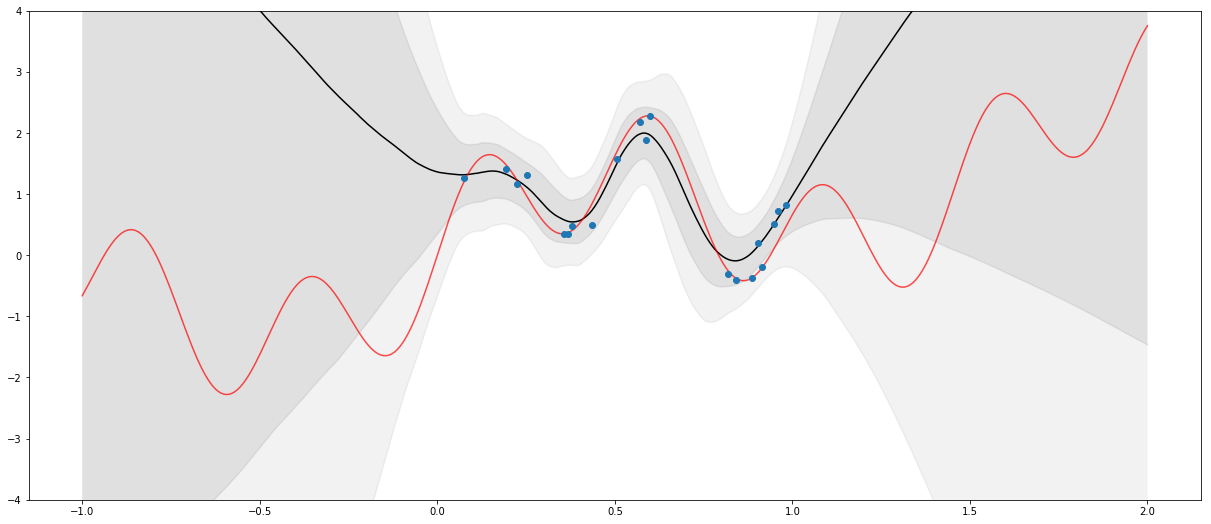

In [96]:
upper1 = np.mean(predictions_sgld[:,1:].detach().numpy(),1) + np.std(predictions_sgld[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_sgld[:,1:].detach().numpy(),1) + 2 * np.std(predictions_sgld[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions_sgld[:,1:].detach().numpy(),1) - np.std(predictions_sgld[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_sgld[:,1:].detach().numpy(),1) - 2 * np.std(predictions_sgld[:,1:].detach().numpy(),1)

plt.figure(figsize=(21,9))
plt.plot(grid,np.mean(predictions_sgld[:,1:].detach().numpy(),1), 'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.15)
plt.plot(grid,lower2,'gray',alpha=0.1)
plt.fill_between(grid,lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid,lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,y_true,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-4,4)

